In [1]:
import numpy, pandas
import conntility
import os
# import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [2]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_funct_conmat_filtered_compressed.h5"
M = conntility.ConnectivityMatrix.from_h5(fn_mat)

## Patch sample and analysis helpers

Functions to patch sample and evaluate triads and connection probabilities

In [3]:
def partition_model_into_subvolumes(M, decomposition_plane, decomposition_sz, min_column_sz):
    grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
    grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

    Ms = []
    for grp in grps:
        m = M.subpopulation(grp)
        if len(m) > min_column_sz:
            Ms.append(m)
    return Ms

In [4]:
from connalysis.network.topology import count_triads_fully_connected
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P, N):
    from connalysis.network.topology import triad_combinations
    from scipy.stats import binom
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    distr_er = binom(N, (p_er / p_er.sum()))
    return distr_er.mean(), distr_er.std()

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25, slice_thickness=150):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    sum_rc = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, slice_thickness)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=col_slc)
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            sum_rc += s.to_reciprocal().matrix.nnz
            counts.append(count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((1, -1, 2)) - s.vertices[col_slc].values.reshape((-1, 1, 2))
            delta_rec.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() > 0)], columns=["horizontal", "vertical"]
            ))
            delta_con.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() == 0)], columns=["horizontal", "vertical"]
            ))
            delta_unc.append(pandas.DataFrame(
                D[(s.array == 0)], columns=["horizontal", "vertical"]
            ))
        except:
            pass
    P = sum_connected / sum_pairs
    Prec = sum_rc / sum_pairs
    deltas = pandas.concat([
        pandas.concat(delta_rec, axis=0, names=["sample"], keys=range(len(delta_rec))),
        pandas.concat(delta_con, axis=0, names=["sample"], keys=range(len(delta_con))),
        pandas.concat(delta_unc, axis=0, names=["sample"], keys=range(len(delta_unc)))
    ], axis=0, keys=["reciprocal", "unidirectional", "unconnected"])
    counts = numpy.vstack(counts).sum(axis=0)
    return counts, (P, Prec), deltas


Main entry point

In [5]:
def execute_slice_and_patch_campaign(M, param_dict):
    if "decomposition_plane" in param_dict:
        Ms = partition_model_into_subvolumes(M, param_dict["decomposition_plane"],
                                             param_dict["decomposition_sz"], param_dict["min_column_sz"])
    else:
        Ms = [M]
    
    all_counts = []
    all_er = []
    all_deltas = []

    mv_cv = numpy.array(param_dict["mv_cv"])
    patch_kwargs = param_dict["patch_kwargs"]
    allP_u = []; allP_rc = []
    for m in Ms:
        counts, P, deltas = sample_and_count_triads(m, mv_cv, **patch_kwargs)
        allP_u.append(P[0]); allP_rc.append(P[1])
        count_er_mn, count_er_sd = number_expected_er(P[0], counts.sum())
        all_counts.append((counts - count_er_mn) / count_er_sd)
        all_deltas.append(deltas)

    all_counts = pandas.DataFrame(all_counts,
                     index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                     columns=pandas.RangeIndex(13, name="motif"))
    all_deltas = pandas.concat(all_deltas, axis=0, names=["subvolume"], keys=range(len(all_deltas)))
    return all_counts, all_deltas, pandas.DataFrame({"unidirectional": allP_u,
                                                     "reciprocal": allP_rc})
    

## EXECUTE!

### Part I: Triad motifs for a realistic sampling
Note: If you are only interested in part II, you can skip execution of this part.

In [6]:
campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

all_counts, all_deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)

  4%|▎         | 2/55 [00:00<00:04, 10.75it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0017805099487304688
Found 40 connected triads
Time spent classifying triads: 0.002933502197265625
Testing 54 potential triadic pairs
Time spent finding triads: 0.0020101070404052734
Found 74 connected triads
Time spent classifying triads: 0.004565715789794922
Testing 59 potential triadic pairs
Time spent finding triads: 0.0020482540130615234
Found 90 connected triads
Time spent classifying triads: 0.005487203598022461


  7%|▋         | 4/55 [00:00<00:05, 10.20it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0016427040100097656
Found 56 connected triads
Time spent classifying triads: 0.003820180892944336
Testing 65 potential triadic pairs
Time spent finding triads: 0.002183675765991211
Found 136 connected triads
Time spent classifying triads: 0.008494138717651367
Testing 52 potential triadic pairs
Time spent finding triads: 0.0024824142456054688
Found 69 connected triads
Time spent classifying triads: 0.0063228607177734375


 15%|█▍        | 8/55 [00:00<00:05,  8.26it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.004388570785522461
Found 119 connected triads
Time spent classifying triads: 0.015833616256713867
Testing 50 potential triadic pairs
Time spent finding triads: 0.002640962600708008
Found 68 connected triads
Time spent classifying triads: 0.006159305572509766
Testing 52 potential triadic pairs
Time spent finding triads: 0.0024001598358154297
Found 64 connected triads
Time spent classifying triads: 0.005866527557373047


 20%|██        | 11/55 [00:01<00:05,  7.91it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0026755332946777344
Found 50 connected triads
Time spent classifying triads: 0.004605770111083984
Testing 34 potential triadic pairs
Time spent finding triads: 0.0022139549255371094
Found 38 connected triads
Time spent classifying triads: 0.003566741943359375
Testing 65 potential triadic pairs
Time spent finding triads: 0.0028541088104248047
Found 103 connected triads
Time spent classifying triads: 0.009147882461547852


 25%|██▌       | 14/55 [00:01<00:04,  8.36it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0019266605377197266
Found 89 connected triads
Time spent classifying triads: 0.006079912185668945
Testing 49 potential triadic pairs
Time spent finding triads: 0.0020024776458740234
Found 70 connected triads
Time spent classifying triads: 0.004701137542724609
Testing 66 potential triadic pairs
Time spent finding triads: 0.002384185791015625
Found 144 connected triads
Time spent classifying triads: 0.00937962532043457


 31%|███       | 17/55 [00:01<00:04,  8.79it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0021288394927978516
Found 79 connected triads
Time spent classifying triads: 0.005232810974121094
Testing 46 potential triadic pairs
Time spent finding triads: 0.0037581920623779297
Found 55 connected triads
Time spent classifying triads: 0.0037631988525390625
Testing 45 potential triadic pairs
Time spent finding triads: 0.0019183158874511719
Found 45 connected triads
Time spent classifying triads: 0.0028738975524902344


 36%|███▋      | 20/55 [00:02<00:03,  8.79it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0027420520782470703
Found 70 connected triads
Time spent classifying triads: 0.006412029266357422
Testing 43 potential triadic pairs
Time spent finding triads: 0.002007007598876953
Found 59 connected triads
Time spent classifying triads: 0.004140377044677734
Testing 43 potential triadic pairs
Time spent finding triads: 0.002058267593383789
Found 55 connected triads
Time spent classifying triads: 0.0036509037017822266


 42%|████▏     | 23/55 [00:02<00:03,  8.61it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.002172708511352539
Found 58 connected triads
Time spent classifying triads: 0.004119873046875
Testing 61 potential triadic pairs
Time spent finding triads: 0.0020570755004882812
Found 108 connected triads
Time spent classifying triads: 0.007555961608886719


 45%|████▌     | 25/55 [00:02<00:03,  8.98it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.001580953598022461
Found 32 connected triads
Time spent classifying triads: 0.0025081634521484375
Testing 48 potential triadic pairs
Time spent finding triads: 0.001767873764038086
Found 57 connected triads
Time spent classifying triads: 0.004056215286254883
Testing 40 potential triadic pairs
Time spent finding triads: 0.0020089149475097656
Found 57 connected triads
Time spent classifying triads: 0.004028797149658203


 51%|█████     | 28/55 [00:03<00:03,  7.78it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0025396347045898438
Found 27 connected triads
Time spent classifying triads: 0.002779722213745117
Testing 47 potential triadic pairs
Time spent finding triads: 0.0034661293029785156
Found 53 connected triads
Time spent classifying triads: 0.0069386959075927734


 55%|█████▍    | 30/55 [00:03<00:03,  7.43it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0028159618377685547
Found 73 connected triads
Time spent classifying triads: 0.00655674934387207
Testing 49 potential triadic pairs
Time spent finding triads: 0.0035400390625
Found 56 connected triads
Time spent classifying triads: 0.006352424621582031


 58%|█████▊    | 32/55 [00:03<00:03,  7.26it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.002743959426879883
Found 53 connected triads
Time spent classifying triads: 0.004960298538208008
Testing 64 potential triadic pairs
Time spent finding triads: 0.002794027328491211
Found 93 connected triads
Time spent classifying triads: 0.006382465362548828


 62%|██████▏   | 34/55 [00:04<00:02,  8.37it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.002042531967163086
Found 55 connected triads
Time spent classifying triads: 0.003818988800048828
Testing 39 potential triadic pairs
Time spent finding triads: 0.0018794536590576172
Found 43 connected triads
Time spent classifying triads: 0.003028392791748047
Testing 39 potential triadic pairs
Time spent finding triads: 0.0018491744995117188
Found 49 connected triads
Time spent classifying triads: 0.0034127235412597656


 67%|██████▋   | 37/55 [00:04<00:01,  9.05it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0016896724700927734
Found 52 connected triads
Time spent classifying triads: 0.003631591796875
Testing 47 potential triadic pairs
Time spent finding triads: 0.0016417503356933594
Found 52 connected triads
Time spent classifying triads: 0.003615140914916992


 71%|███████   | 39/55 [00:04<00:02,  6.89it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0026330947875976562
Found 58 connected triads
Time spent classifying triads: 0.005349636077880859
Testing 60 potential triadic pairs
Time spent finding triads: 0.001800537109375
Found 98 connected triads
Time spent classifying triads: 0.005372285842895508
Testing 26 potential triadic pairs
Time spent finding triads: 0.0015709400177001953
Found 24 connected triads
Time spent classifying triads: 0.0016372203826904297


 76%|███████▋  | 42/55 [00:05<00:01,  8.24it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001766204833984375
Found 45 connected triads
Time spent classifying triads: 0.0033059120178222656
Testing 53 potential triadic pairs
Time spent finding triads: 0.0018355846405029297
Found 72 connected triads
Time spent classifying triads: 0.005210399627685547
Testing 61 potential triadic pairs
Time spent finding triads: 0.001967906951904297
Found 98 connected triads
Time spent classifying triads: 0.006834745407104492


 82%|████████▏ | 45/55 [00:05<00:01,  8.76it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.002174854278564453
Found 65 connected triads
Time spent classifying triads: 0.004534244537353516
Testing 48 potential triadic pairs
Time spent finding triads: 0.0019974708557128906
Found 60 connected triads
Time spent classifying triads: 0.004206180572509766
Testing 38 potential triadic pairs
Time spent finding triads: 0.0026557445526123047
Found 49 connected triads
Time spent classifying triads: 0.005046367645263672


 87%|████████▋ | 48/55 [00:05<00:00,  8.13it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0016753673553466797
Found 46 connected triads
Time spent classifying triads: 0.002917051315307617
Testing 58 potential triadic pairs
Time spent finding triads: 0.0027565956115722656
Found 92 connected triads
Time spent classifying triads: 0.008127927780151367
Testing 18 potential triadic pairs
Time spent finding triads: 0.0013899803161621094
Found 27 connected triads
Time spent classifying triads: 0.0016484260559082031


 93%|█████████▎| 51/55 [00:06<00:00,  8.46it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0020406246185302734
Found 76 connected triads
Time spent classifying triads: 0.004852771759033203
Testing 50 potential triadic pairs
Time spent finding triads: 0.002863168716430664
Found 84 connected triads
Time spent classifying triads: 0.008489608764648438


 96%|█████████▋| 53/55 [00:06<00:00,  8.14it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.003045320510864258
Found 75 connected triads
Time spent classifying triads: 0.007515430450439453
Testing 50 potential triadic pairs
Time spent finding triads: 0.0017380714416503906
Found 63 connected triads
Time spent classifying triads: 0.0038704872131347656
Testing 51 potential triadic pairs
Time spent finding triads: 0.0017104148864746094
Found 63 connected triads
Time spent classifying triads: 0.0038967132568359375


100%|██████████| 55/55 [00:06<00:00,  8.27it/s]


Testing 55 potential triadic pairs
Time spent finding triads: 0.004038333892822266
Found 98 connected triads
Time spent classifying triads: 0.013010978698730469


  2%|▏         | 1/55 [00:00<00:06,  8.59it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001967906951904297
Found 54 connected triads
Time spent classifying triads: 0.0036542415618896484
Testing 35 potential triadic pairs
Time spent finding triads: 0.0015501976013183594
Found 40 connected triads
Time spent classifying triads: 0.0023725032806396484
Testing 52 potential triadic pairs
Time spent finding triads: 0.001684427261352539
Found 79 connected triads
Time spent classifying triads: 0.004509925842285156


  7%|▋         | 4/55 [00:00<00:05,  9.59it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0013911724090576172
Found 18 connected triads
Time spent classifying triads: 0.001216888427734375


  9%|▉         | 5/55 [00:00<00:05,  9.66it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0016252994537353516
Found 49 connected triads
Time spent classifying triads: 0.003158092498779297
Testing 43 potential triadic pairs
Time spent finding triads: 0.0015842914581298828
Found 54 connected triads
Time spent classifying triads: 0.003435373306274414


 13%|█▎        | 7/55 [00:00<00:04,  9.95it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.001745462417602539
Found 62 connected triads
Time spent classifying triads: 0.003557443618774414


 15%|█▍        | 8/55 [00:00<00:04,  9.85it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0019383430480957031
Found 108 connected triads
Time spent classifying triads: 0.006134510040283203
Testing 59 potential triadic pairs
Time spent finding triads: 0.0020465850830078125
Found 82 connected triads
Time spent classifying triads: 0.004693269729614258


 16%|█▋        | 9/55 [00:00<00:04,  9.58it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0017871856689453125
Found 76 connected triads
Time spent classifying triads: 0.004708766937255859


 20%|██        | 11/55 [00:01<00:04,  9.54it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0018076896667480469
Found 71 connected triads
Time spent classifying triads: 0.004106998443603516
Testing 55 potential triadic pairs
Time spent finding triads: 0.0016651153564453125
Found 61 connected triads
Time spent classifying triads: 0.0034995079040527344


 22%|██▏       | 12/55 [00:01<00:04,  9.31it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0016436576843261719
Found 51 connected triads
Time spent classifying triads: 0.003299236297607422


 27%|██▋       | 15/55 [00:01<00:04,  9.63it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0017478466033935547
Found 65 connected triads
Time spent classifying triads: 0.004097700119018555
Testing 43 potential triadic pairs
Time spent finding triads: 0.0015935897827148438
Found 55 connected triads
Time spent classifying triads: 0.0034859180450439453
Testing 65 potential triadic pairs
Time spent finding triads: 0.0019915103912353516
Found 121 connected triads
Time spent classifying triads: 0.006880521774291992


 31%|███       | 17/55 [00:01<00:04,  9.42it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001692056655883789
Found 67 connected triads
Time spent classifying triads: 0.0038967132568359375
Testing 56 potential triadic pairs
Time spent finding triads: 0.0017330646514892578
Found 72 connected triads
Time spent classifying triads: 0.004122734069824219


 33%|███▎      | 18/55 [00:01<00:03,  9.33it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0017435550689697266
Found 75 connected triads
Time spent classifying triads: 0.00433039665222168


 35%|███▍      | 19/55 [00:01<00:03,  9.40it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001575469970703125
Found 37 connected triads
Time spent classifying triads: 0.002243518829345703
Testing 22 potential triadic pairs
Time spent finding triads: 0.0013494491577148438
Found 20 connected triads
Time spent classifying triads: 0.0012881755828857422


 40%|████      | 22/55 [00:02<00:03,  9.59it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0017518997192382812
Found 73 connected triads
Time spent classifying triads: 0.00420069694519043


 44%|████▎     | 24/55 [00:02<00:03,  9.78it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0017445087432861328
Found 56 connected triads
Time spent classifying triads: 0.003571748733520508
Testing 44 potential triadic pairs
Time spent finding triads: 0.0015954971313476562
Found 56 connected triads
Time spent classifying triads: 0.003566265106201172


 45%|████▌     | 25/55 [00:02<00:03,  9.71it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001680612564086914
Found 47 connected triads
Time spent classifying triads: 0.0027849674224853516


 47%|████▋     | 26/55 [00:02<00:02,  9.74it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0018007755279541016
Found 88 connected triads
Time spent classifying triads: 0.004683971405029297


 49%|████▉     | 27/55 [00:02<00:03,  8.93it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.002666950225830078
Found 46 connected triads
Time spent classifying triads: 0.004380941390991211
Testing 43 potential triadic pairs
Time spent finding triads: 0.0014989376068115234
Found 41 connected triads
Time spent classifying triads: 0.0024690628051757812


 55%|█████▍    | 30/55 [00:03<00:03,  7.97it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0027866363525390625
Found 62 connected triads
Time spent classifying triads: 0.005615711212158203
Testing 62 potential triadic pairs
Time spent finding triads: 0.0030117034912109375
Found 122 connected triads
Time spent classifying triads: 0.010915994644165039


 58%|█████▊    | 32/55 [00:03<00:03,  7.29it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.002783536911010742
Found 87 connected triads
Time spent classifying triads: 0.0077130794525146484
Testing 64 potential triadic pairs
Time spent finding triads: 0.003177642822265625
Found 118 connected triads
Time spent classifying triads: 0.010622024536132812


 62%|██████▏   | 34/55 [00:03<00:02,  7.22it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0025873184204101562
Found 78 connected triads
Time spent classifying triads: 0.006758689880371094
Testing 64 potential triadic pairs
Time spent finding triads: 0.0028138160705566406
Found 113 connected triads
Time spent classifying triads: 0.010032892227172852


 65%|██████▌   | 36/55 [00:04<00:02,  7.44it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0027992725372314453
Found 94 connected triads
Time spent classifying triads: 0.008354902267456055
Testing 24 potential triadic pairs
Time spent finding triads: 0.0022563934326171875
Found 27 connected triads
Time spent classifying triads: 0.002583026885986328


 69%|██████▉   | 38/55 [00:04<00:02,  7.37it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0020380020141601562
Found 16 connected triads
Time spent classifying triads: 0.0016069412231445312
Testing 39 potential triadic pairs
Time spent finding triads: 0.0023353099822998047
Found 51 connected triads
Time spent classifying triads: 0.004720211029052734
Testing 65 potential triadic pairs
Time spent finding triads: 0.002830028533935547
Found 96 connected triads
Time spent classifying triads: 0.008472204208374023


 75%|███████▍  | 41/55 [00:04<00:01,  7.50it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0026586055755615234
Found 58 connected triads
Time spent classifying triads: 0.005417823791503906
Testing 61 potential triadic pairs
Time spent finding triads: 0.0028836727142333984
Found 107 connected triads
Time spent classifying triads: 0.009535074234008789


 78%|███████▊  | 43/55 [00:04<00:01,  7.88it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0017616748809814453
Found 58 connected triads
Time spent classifying triads: 0.003926515579223633
Testing 65 potential triadic pairs
Time spent finding triads: 0.0022954940795898438
Found 125 connected triads
Time spent classifying triads: 0.008267641067504883
Testing 55 potential triadic pairs
Time spent finding triads: 0.0021038055419921875
Found 84 connected triads
Time spent classifying triads: 0.00554203987121582


 84%|████████▎ | 46/55 [00:05<00:01,  8.76it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0018725395202636719
Found 38 connected triads
Time spent classifying triads: 0.002727508544921875
Testing 25 potential triadic pairs
Time spent finding triads: 0.0014350414276123047
Found 24 connected triads
Time spent classifying triads: 0.0018639564514160156
Testing 64 potential triadic pairs
Time spent finding triads: 0.0030281543731689453
Found 114 connected triads
Time spent classifying triads: 0.009890317916870117


 89%|████████▉ | 49/55 [00:05<00:00,  8.33it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0018773078918457031
Found 68 connected triads
Time spent classifying triads: 0.00463104248046875
Testing 39 potential triadic pairs
Time spent finding triads: 0.0018618106842041016
Found 38 connected triads
Time spent classifying triads: 0.0024390220642089844


 93%|█████████▎| 51/55 [00:05<00:00,  8.58it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0015969276428222656
Found 37 connected triads
Time spent classifying triads: 0.0027015209197998047
Testing 60 potential triadic pairs
Time spent finding triads: 0.0021293163299560547
Found 85 connected triads
Time spent classifying triads: 0.005612373352050781
Testing 31 potential triadic pairs
Time spent finding triads: 0.001478433609008789
Found 31 connected triads
Time spent classifying triads: 0.0023069381713867188


 98%|█████████▊| 54/55 [00:06<00:00,  7.98it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0018832683563232422
Found 88 connected triads
Time spent classifying triads: 0.007725954055786133
Testing 51 potential triadic pairs
Time spent finding triads: 0.0024590492248535156
Found 59 connected triads
Time spent classifying triads: 0.00485539436340332


100%|██████████| 55/55 [00:06<00:00,  8.59it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0025594234466552734
Found 105 connected triads
Time spent classifying triads: 0.007175922393798828


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0020112991333007812
Found 105 connected triads
Time spent classifying triads: 0.007206916809082031


  4%|▎         | 2/55 [00:00<00:04, 10.71it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0022792816162109375
Found 118 connected triads
Time spent classifying triads: 0.007943868637084961
Testing 27 potential triadic pairs
Time spent finding triads: 0.0014348030090332031
Found 28 connected triads
Time spent classifying triads: 0.002131938934326172


  7%|▋         | 4/55 [00:00<00:04, 10.42it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0020067691802978516
Found 96 connected triads
Time spent classifying triads: 0.0066411495208740234
Testing 61 potential triadic pairs
Time spent finding triads: 0.0022001266479492188
Found 81 connected triads
Time spent classifying triads: 0.006524085998535156


 11%|█         | 6/55 [00:00<00:05,  9.24it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.002783536911010742
Found 99 connected triads
Time spent classifying triads: 0.008884191513061523


 15%|█▍        | 8/55 [00:00<00:04,  9.72it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0020198822021484375
Found 119 connected triads
Time spent classifying triads: 0.007874488830566406
Testing 41 potential triadic pairs
Time spent finding triads: 0.0015926361083984375
Found 43 connected triads
Time spent classifying triads: 0.0030243396759033203


 16%|█▋        | 9/55 [00:00<00:04,  9.67it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0018603801727294922
Found 79 connected triads
Time spent classifying triads: 0.0054280757904052734


 18%|█▊        | 10/55 [00:01<00:04,  9.71it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.002061128616333008
Found 65 connected triads
Time spent classifying triads: 0.004415035247802734
Testing 31 potential triadic pairs
Time spent finding triads: 0.0014719963073730469
Found 32 connected triads
Time spent classifying triads: 0.002396106719970703


 22%|██▏       | 12/55 [00:01<00:04,  9.74it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.002405881881713867
Found 23 connected triads
Time spent classifying triads: 0.002223491668701172


 24%|██▎       | 13/55 [00:01<00:04,  9.01it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0031244754791259766
Found 78 connected triads
Time spent classifying triads: 0.00814509391784668
Testing 52 potential triadic pairs
Time spent finding triads: 0.0029175281524658203
Found 71 connected triads
Time spent classifying triads: 0.007437229156494141


 29%|██▉       | 16/55 [00:01<00:04,  8.43it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0021033287048339844
Found 66 connected triads
Time spent classifying triads: 0.004495382308959961
Testing 54 potential triadic pairs
Time spent finding triads: 0.0032389163970947266
Found 73 connected triads
Time spent classifying triads: 0.008008241653442383


 33%|███▎      | 18/55 [00:01<00:04,  8.28it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.002156496047973633
Found 86 connected triads
Time spent classifying triads: 0.0057146549224853516
Testing 56 potential triadic pairs
Time spent finding triads: 0.003139019012451172
Found 67 connected triads
Time spent classifying triads: 0.007013559341430664
Testing 55 potential triadic pairs
Time spent finding triads: 0.0020008087158203125
Found 64 connected triads
Time spent classifying triads: 0.004366159439086914


 38%|███▊      | 21/55 [00:02<00:04,  8.37it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.002454519271850586
Found 91 connected triads
Time spent classifying triads: 0.007481813430786133
Testing 49 potential triadic pairs
Time spent finding triads: 0.002125978469848633
Found 59 connected triads
Time spent classifying triads: 0.004044532775878906
Testing 51 potential triadic pairs
Time spent finding triads: 0.0018095970153808594
Found 92 connected triads
Time spent classifying triads: 0.006489753723144531


 45%|████▌     | 25/55 [00:02<00:03,  9.91it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.002167940139770508
Found 81 connected triads
Time spent classifying triads: 0.00550532341003418
Testing 56 potential triadic pairs
Time spent finding triads: 0.0021028518676757812
Found 81 connected triads
Time spent classifying triads: 0.0054721832275390625
Testing 63 potential triadic pairs
Time spent finding triads: 0.002052783966064453
Found 116 connected triads
Time spent classifying triads: 0.007840394973754883


 51%|█████     | 28/55 [00:03<00:02, 10.23it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.002230405807495117
Found 100 connected triads
Time spent classifying triads: 0.006598472595214844
Testing 50 potential triadic pairs
Time spent finding triads: 0.002075672149658203
Found 76 connected triads
Time spent classifying triads: 0.005122184753417969
Testing 60 potential triadic pairs
Time spent finding triads: 0.0019106864929199219
Found 95 connected triads
Time spent classifying triads: 0.005098819732666016


 55%|█████▍    | 30/55 [00:03<00:02,  9.96it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001882791519165039
Found 74 connected triads
Time spent classifying triads: 0.005186796188354492
Testing 50 potential triadic pairs
Time spent finding triads: 0.0020623207092285156
Found 80 connected triads
Time spent classifying triads: 0.00554966926574707
Testing 66 potential triadic pairs
Time spent finding triads: 0.002015829086303711
Found 138 connected triads
Time spent classifying triads: 0.00922703742980957


 62%|██████▏   | 34/55 [00:03<00:02, 10.16it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002444744110107422
Found 140 connected triads
Time spent classifying triads: 0.009434700012207031
Testing 53 potential triadic pairs
Time spent finding triads: 0.002046823501586914
Found 71 connected triads
Time spent classifying triads: 0.004692554473876953
Testing 55 potential triadic pairs
Time spent finding triads: 0.0016243457794189453
Found 64 connected triads
Time spent classifying triads: 0.0036399364471435547


 65%|██████▌   | 36/55 [00:03<00:01,  9.83it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002205371856689453
Found 169 connected triads
Time spent classifying triads: 0.010368824005126953
Testing 59 potential triadic pairs
Time spent finding triads: 0.002714395523071289
Found 90 connected triads
Time spent classifying triads: 0.008013248443603516
Testing 56 potential triadic pairs
Time spent finding triads: 0.001775503158569336
Found 72 connected triads
Time spent classifying triads: 0.004336357116699219


 73%|███████▎  | 40/55 [00:04<00:01, 10.02it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.002183198928833008
Found 154 connected triads
Time spent classifying triads: 0.009206056594848633
Testing 53 potential triadic pairs
Time spent finding triads: 0.0017461776733398438
Found 94 connected triads
Time spent classifying triads: 0.005837917327880859
Testing 59 potential triadic pairs
Time spent finding triads: 0.0020477771759033203
Found 86 connected triads
Time spent classifying triads: 0.005956411361694336


 78%|███████▊  | 43/55 [00:04<00:01, 10.21it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0025763511657714844
Found 202 connected triads
Time spent classifying triads: 0.015093088150024414
Testing 56 potential triadic pairs
Time spent finding triads: 0.0020842552185058594
Found 73 connected triads
Time spent classifying triads: 0.005193471908569336
Testing 25 potential triadic pairs
Time spent finding triads: 0.0016469955444335938
Found 25 connected triads
Time spent classifying triads: 0.0019032955169677734


 82%|████████▏ | 45/55 [00:04<00:01,  9.95it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.010388374328613281
Found 75 connected triads
Time spent classifying triads: 0.0046231746673583984
Testing 55 potential triadic pairs
Time spent finding triads: 0.0017375946044921875
Found 80 connected triads
Time spent classifying triads: 0.004969358444213867
Testing 38 potential triadic pairs
Time spent finding triads: 0.0015048980712890625
Found 40 connected triads
Time spent classifying triads: 0.002507448196411133


 89%|████████▉ | 49/55 [00:05<00:00, 10.36it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0019512176513671875
Found 114 connected triads
Time spent classifying triads: 0.007200717926025391
Testing 57 potential triadic pairs
Time spent finding triads: 0.0017094612121582031
Found 79 connected triads
Time spent classifying triads: 0.005056142807006836
Testing 64 potential triadic pairs
Time spent finding triads: 0.0019328594207763672
Found 139 connected triads
Time spent classifying triads: 0.00858449935913086


 93%|█████████▎| 51/55 [00:05<00:00, 10.66it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002111673355102539
Found 178 connected triads
Time spent classifying triads: 0.010981082916259766
Testing 54 potential triadic pairs
Time spent finding triads: 0.0016546249389648438
Found 66 connected triads
Time spent classifying triads: 0.0040132999420166016
Testing 52 potential triadic pairs
Time spent finding triads: 0.0016663074493408203
Found 67 connected triads
Time spent classifying triads: 0.004090785980224609


100%|██████████| 55/55 [00:05<00:00,  9.73it/s]


Testing 53 potential triadic pairs
Time spent finding triads: 0.001725912094116211
Found 65 connected triads
Time spent classifying triads: 0.003989219665527344
Testing 59 potential triadic pairs
Time spent finding triads: 0.0017800331115722656
Found 89 connected triads
Time spent classifying triads: 0.005357265472412109
Testing 66 potential triadic pairs
Time spent finding triads: 0.0019376277923583984
Found 134 connected triads
Time spent classifying triads: 0.008285284042358398


  4%|▎         | 2/55 [00:00<00:06,  7.93it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0017845630645751953
Found 31 connected triads
Time spent classifying triads: 0.0020279884338378906
Testing 65 potential triadic pairs
Time spent finding triads: 0.0019373893737792969
Found 133 connected triads
Time spent classifying triads: 0.00824117660522461


  7%|▋         | 4/55 [00:00<00:07,  6.70it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0038459300994873047
Found 91 connected triads
Time spent classifying triads: 0.011678695678710938
Testing 53 potential triadic pairs
Time spent finding triads: 0.0018432140350341797
Found 72 connected triads
Time spent classifying triads: 0.004392385482788086


 11%|█         | 6/55 [00:00<00:06,  7.19it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.002042055130004883
Found 74 connected triads
Time spent classifying triads: 0.00456690788269043
Testing 56 potential triadic pairs
Time spent finding triads: 0.001737833023071289
Found 84 connected triads
Time spent classifying triads: 0.00532841682434082


 15%|█▍        | 8/55 [00:01<00:06,  7.64it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0017249584197998047
Found 65 connected triads
Time spent classifying triads: 0.004270792007446289
Testing 52 potential triadic pairs
Time spent finding triads: 0.0017020702362060547
Found 74 connected triads
Time spent classifying triads: 0.004681825637817383


 18%|█▊        | 10/55 [00:01<00:05,  7.84it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0015785694122314453
Found 30 connected triads
Time spent classifying triads: 0.002003908157348633
Testing 54 potential triadic pairs
Time spent finding triads: 0.0017652511596679688
Found 87 connected triads
Time spent classifying triads: 0.005575895309448242


 22%|██▏       | 12/55 [00:01<00:05,  8.00it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0016078948974609375
Found 49 connected triads
Time spent classifying triads: 0.0033369064331054688
Testing 42 potential triadic pairs
Time spent finding triads: 0.001566171646118164
Found 51 connected triads
Time spent classifying triads: 0.0033910274505615234


 25%|██▌       | 14/55 [00:01<00:05,  7.02it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0018665790557861328
Found 93 connected triads
Time spent classifying triads: 0.0059299468994140625
Testing 52 potential triadic pairs
Time spent finding triads: 0.0036783218383789062
Found 76 connected triads
Time spent classifying triads: 0.009981870651245117


 29%|██▉       | 16/55 [00:02<00:06,  6.39it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0029449462890625
Found 110 connected triads
Time spent classifying triads: 0.00977182388305664
Testing 52 potential triadic pairs
Time spent finding triads: 0.0023674964904785156
Found 69 connected triads
Time spent classifying triads: 0.006141185760498047


 33%|███▎      | 18/55 [00:02<00:05,  6.43it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0022056102752685547
Found 39 connected triads
Time spent classifying triads: 0.003633260726928711
Testing 63 potential triadic pairs
Time spent finding triads: 0.002788066864013672
Found 101 connected triads
Time spent classifying triads: 0.009026050567626953


 36%|███▋      | 20/55 [00:02<00:05,  6.86it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.002457857131958008
Found 49 connected triads
Time spent classifying triads: 0.003431558609008789
Testing 63 potential triadic pairs
Time spent finding triads: 0.0018587112426757812
Found 82 connected triads
Time spent classifying triads: 0.005675077438354492


 40%|████      | 22/55 [00:03<00:04,  7.32it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0020055770874023438
Found 59 connected triads
Time spent classifying triads: 0.004008293151855469
Testing 25 potential triadic pairs
Time spent finding triads: 0.0014424324035644531
Found 43 connected triads
Time spent classifying triads: 0.003026723861694336


 44%|████▎     | 24/55 [00:03<00:04,  6.97it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.002048492431640625
Found 66 connected triads
Time spent classifying triads: 0.004483222961425781
Testing 58 potential triadic pairs
Time spent finding triads: 0.002818584442138672
Found 93 connected triads
Time spent classifying triads: 0.00832366943359375


 47%|████▋     | 26/55 [00:03<00:04,  7.09it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0018112659454345703
Found 38 connected triads
Time spent classifying triads: 0.0028591156005859375
Testing 46 potential triadic pairs
Time spent finding triads: 0.0017902851104736328
Found 55 connected triads
Time spent classifying triads: 0.00393986701965332
Testing 62 potential triadic pairs
Time spent finding triads: 0.0022764205932617188
Found 106 connected triads
Time spent classifying triads: 0.0075435638427734375


 53%|█████▎    | 29/55 [00:04<00:03,  7.16it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0017902851104736328
Found 47 connected triads
Time spent classifying triads: 0.003530740737915039
Testing 65 potential triadic pairs
Time spent finding triads: 0.0023288726806640625
Found 123 connected triads
Time spent classifying triads: 0.008658409118652344


 56%|█████▋    | 31/55 [00:04<00:03,  6.42it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.002353191375732422
Found 114 connected triads
Time spent classifying triads: 0.008061408996582031
Testing 53 potential triadic pairs
Time spent finding triads: 0.002366781234741211
Found 57 connected triads
Time spent classifying triads: 0.004502058029174805


 60%|██████    | 33/55 [00:04<00:03,  6.14it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0028998851776123047
Found 124 connected triads
Time spent classifying triads: 0.011082649230957031
Testing 48 potential triadic pairs
Time spent finding triads: 0.001668691635131836
Found 58 connected triads
Time spent classifying triads: 0.00397038459777832


 64%|██████▎   | 35/55 [00:05<00:03,  6.60it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0019981861114501953
Found 86 connected triads
Time spent classifying triads: 0.006016254425048828
Testing 62 potential triadic pairs
Time spent finding triads: 0.002176046371459961
Found 96 connected triads
Time spent classifying triads: 0.00658726692199707


 67%|██████▋   | 37/55 [00:05<00:02,  7.01it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0018181800842285156
Found 74 connected triads
Time spent classifying triads: 0.005259275436401367
Testing 50 potential triadic pairs
Time spent finding triads: 0.0019867420196533203
Found 62 connected triads
Time spent classifying triads: 0.004198551177978516
Testing 31 potential triadic pairs
Time spent finding triads: 0.0014715194702148438
Found 29 connected triads
Time spent classifying triads: 0.002204418182373047


 73%|███████▎  | 40/55 [00:05<00:02,  6.96it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.001979351043701172
Found 18 connected triads
Time spent classifying triads: 0.0016415119171142578
Testing 59 potential triadic pairs
Time spent finding triads: 0.0026993751525878906
Found 78 connected triads
Time spent classifying triads: 0.007062673568725586


 76%|███████▋  | 42/55 [00:05<00:01,  7.43it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0016927719116210938
Found 59 connected triads
Time spent classifying triads: 0.0033593177795410156
Testing 56 potential triadic pairs
Time spent finding triads: 0.0019807815551757812
Found 82 connected triads
Time spent classifying triads: 0.005235910415649414


 80%|████████  | 44/55 [00:06<00:01,  7.68it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0021371841430664062
Found 66 connected triads
Time spent classifying triads: 0.004567861557006836
Testing 34 potential triadic pairs
Time spent finding triads: 0.001871347427368164
Found 37 connected triads
Time spent classifying triads: 0.0024671554565429688


 84%|████████▎ | 46/55 [00:06<00:01,  7.57it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0018377304077148438
Found 56 connected triads
Time spent classifying triads: 0.003939628601074219
Testing 65 potential triadic pairs
Time spent finding triads: 0.002305269241333008
Found 123 connected triads
Time spent classifying triads: 0.008361577987670898


 87%|████████▋ | 48/55 [00:06<00:00,  7.06it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.002920389175415039
Found 48 connected triads
Time spent classifying triads: 0.004949331283569336
Testing 4 potential triadic pairs
Time spent finding triads: 0.0011684894561767578
Found 4 connected triads
Time spent classifying triads: 0.00037980079650878906


 91%|█████████ | 50/55 [00:07<00:00,  7.28it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.00250244140625
Found 34 connected triads
Time spent classifying triads: 0.0032126903533935547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0019893646240234375
Found 130 connected triads
Time spent classifying triads: 0.007910966873168945


 95%|█████████▍| 52/55 [00:07<00:00,  6.86it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0023550987243652344
Found 14 connected triads
Time spent classifying triads: 0.0016558170318603516
Testing 26 potential triadic pairs
Time spent finding triads: 0.0024514198303222656
Found 24 connected triads
Time spent classifying triads: 0.0025725364685058594


 98%|█████████▊| 54/55 [00:07<00:00,  7.42it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0016040802001953125
Found 43 connected triads
Time spent classifying triads: 0.002721548080444336
Testing 46 potential triadic pairs
Time spent finding triads: 0.00164794921875
Found 53 connected triads
Time spent classifying triads: 0.0032815933227539062


100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


Testing 42 potential triadic pairs
Time spent finding triads: 0.001981496810913086
Found 55 connected triads
Time spent classifying triads: 0.003911018371582031


  2%|▏         | 1/55 [00:00<00:06,  8.61it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0017714500427246094
Found 59 connected triads
Time spent classifying triads: 0.0038928985595703125


  4%|▎         | 2/55 [00:00<00:06,  8.64it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0015554428100585938
Found 40 connected triads
Time spent classifying triads: 0.0023674964904785156


  5%|▌         | 3/55 [00:00<00:05,  8.76it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0017511844635009766
Found 75 connected triads
Time spent classifying triads: 0.004323482513427734


  7%|▋         | 4/55 [00:00<00:05,  8.68it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0018146038055419922
Found 80 connected triads
Time spent classifying triads: 0.004610776901245117


  9%|▉         | 5/55 [00:00<00:05,  8.76it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0017595291137695312
Found 66 connected triads
Time spent classifying triads: 0.003816366195678711


 11%|█         | 6/55 [00:00<00:05,  8.70it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0017986297607421875
Found 86 connected triads
Time spent classifying triads: 0.004935503005981445


 13%|█▎        | 7/55 [00:00<00:05,  8.83it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.001535654067993164
Found 37 connected triads
Time spent classifying triads: 0.0022149085998535156
Testing 65 potential triadic pairs
Time spent finding triads: 0.0018775463104248047
Found 125 connected triads
Time spent classifying triads: 0.007011890411376953


 15%|█▍        | 8/55 [00:00<00:05,  8.87it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0016770362854003906
Found 56 connected triads
Time spent classifying triads: 0.003552675247192383


 18%|█▊        | 10/55 [00:01<00:04,  9.00it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0018842220306396484
Found 105 connected triads
Time spent classifying triads: 0.005203962326049805
Testing 27 potential triadic pairs
Time spent finding triads: 0.0014150142669677734
Found 21 connected triads
Time spent classifying triads: 0.0012972354888916016


 20%|██        | 11/55 [00:01<00:04,  9.07it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001878499984741211
Found 106 connected triads
Time spent classifying triads: 0.006289482116699219


 24%|██▎       | 13/55 [00:01<00:04,  9.01it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001734018325805664
Found 70 connected triads
Time spent classifying triads: 0.0039675235748291016
Testing 63 potential triadic pairs
Time spent finding triads: 0.001786947250366211
Found 93 connected triads
Time spent classifying triads: 0.00555729866027832


 25%|██▌       | 14/55 [00:01<00:04,  9.05it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0018286705017089844
Found 99 connected triads
Time spent classifying triads: 0.005585193634033203


 29%|██▉       | 16/55 [00:01<00:04,  9.15it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0018303394317626953
Found 89 connected triads
Time spent classifying triads: 0.004963874816894531
Testing 21 potential triadic pairs
Time spent finding triads: 0.0016162395477294922
Found 21 connected triads
Time spent classifying triads: 0.0013048648834228516


 31%|███       | 17/55 [00:01<00:04,  9.23it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0016303062438964844
Found 50 connected triads
Time spent classifying triads: 0.0029282569885253906


 35%|███▍      | 19/55 [00:02<00:03,  9.17it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0015206336975097656
Found 32 connected triads
Time spent classifying triads: 0.001955747604370117
Testing 44 potential triadic pairs
Time spent finding triads: 0.0015592575073242188
Found 50 connected triads
Time spent classifying triads: 0.002909421920776367


 36%|███▋      | 20/55 [00:02<00:03,  9.16it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0018358230590820312
Found 94 connected triads
Time spent classifying triads: 0.005314350128173828


 40%|████      | 22/55 [00:02<00:03,  9.16it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001955747604370117
Found 123 connected triads
Time spent classifying triads: 0.007235527038574219
Testing 60 potential triadic pairs
Time spent finding triads: 0.0017559528350830078
Found 100 connected triads
Time spent classifying triads: 0.005629062652587891


 42%|████▏     | 23/55 [00:02<00:03,  9.28it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0019161701202392578
Found 114 connected triads
Time spent classifying triads: 0.006676435470581055


 45%|████▌     | 25/55 [00:02<00:03,  9.13it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002032041549682617
Found 141 connected triads
Time spent classifying triads: 0.008194208145141602
Testing 51 potential triadic pairs
Time spent finding triads: 0.0016894340515136719
Found 77 connected triads
Time spent classifying triads: 0.00435185432434082


 47%|████▋     | 26/55 [00:02<00:03,  9.07it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001756906509399414
Found 70 connected triads
Time spent classifying triads: 0.0043413639068603516


 51%|█████     | 28/55 [00:03<00:02,  9.34it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0015833377838134766
Found 41 connected triads
Time spent classifying triads: 0.002725839614868164


 53%|█████▎    | 29/55 [00:03<00:03,  8.49it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0028541088104248047
Found 82 connected triads
Time spent classifying triads: 0.007227182388305664


 55%|█████▍    | 30/55 [00:03<00:03,  8.31it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001489877700805664
Found 39 connected triads
Time spent classifying triads: 0.0023250579833984375


 56%|█████▋    | 31/55 [00:03<00:02,  8.13it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0033288002014160156
Found 84 connected triads
Time spent classifying triads: 0.008860349655151367


 58%|█████▊    | 32/55 [00:03<00:03,  7.61it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0027382373809814453
Found 75 connected triads
Time spent classifying triads: 0.006650209426879883


 60%|██████    | 33/55 [00:03<00:02,  7.45it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.002279520034790039
Found 52 connected triads
Time spent classifying triads: 0.0048580169677734375


 62%|██████▏   | 34/55 [00:03<00:02,  7.29it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0024628639221191406
Found 56 connected triads
Time spent classifying triads: 0.005019664764404297


 64%|██████▎   | 35/55 [00:04<00:02,  7.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0029692649841308594
Found 108 connected triads
Time spent classifying triads: 0.009712696075439453


 65%|██████▌   | 36/55 [00:04<00:02,  7.02it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0026273727416992188
Found 44 connected triads
Time spent classifying triads: 0.003952741622924805


 67%|██████▋   | 37/55 [00:04<00:02,  6.93it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.002390146255493164
Found 47 connected triads
Time spent classifying triads: 0.00439000129699707


 69%|██████▉   | 38/55 [00:04<00:02,  6.84it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.002750396728515625
Found 67 connected triads
Time spent classifying triads: 0.00616145133972168


 71%|███████   | 39/55 [00:04<00:02,  6.82it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0026061534881591797
Found 52 connected triads
Time spent classifying triads: 0.004766225814819336


 73%|███████▎  | 40/55 [00:04<00:02,  6.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002955913543701172
Found 138 connected triads
Time spent classifying triads: 0.01242971420288086


 75%|███████▍  | 41/55 [00:04<00:02,  6.72it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.002850770950317383
Found 91 connected triads
Time spent classifying triads: 0.008254289627075195


 76%|███████▋  | 42/55 [00:05<00:01,  6.86it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.002136707305908203
Found 33 connected triads
Time spent classifying triads: 0.003223896026611328


 78%|███████▊  | 43/55 [00:05<00:01,  6.94it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.002771139144897461
Found 63 connected triads
Time spent classifying triads: 0.005684614181518555


 80%|████████  | 44/55 [00:05<00:01,  7.42it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0022444725036621094
Found 104 connected triads
Time spent classifying triads: 0.006728410720825195


 82%|████████▏ | 45/55 [00:05<00:01,  7.75it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0022835731506347656
Found 86 connected triads
Time spent classifying triads: 0.0056383609771728516


 84%|████████▎ | 46/55 [00:05<00:01,  7.94it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0022194385528564453
Found 84 connected triads
Time spent classifying triads: 0.005482673645019531


 85%|████████▌ | 47/55 [00:05<00:00,  8.20it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0022313594818115234
Found 100 connected triads
Time spent classifying triads: 0.006827354431152344
Testing 60 potential triadic pairs
Time spent finding triads: 0.0021598339080810547
Found 94 connected triads
Time spent classifying triads: 0.006417512893676758


 87%|████████▋ | 48/55 [00:05<00:00,  8.31it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.003057718276977539
Found 96 connected triads
Time spent classifying triads: 0.008541584014892578


 91%|█████████ | 50/55 [00:06<00:00,  7.92it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0022623538970947266
Found 102 connected triads
Time spent classifying triads: 0.006653308868408203


 93%|█████████▎| 51/55 [00:06<00:00,  7.98it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0016443729400634766
Found 44 connected triads
Time spent classifying triads: 0.003916501998901367
Testing 62 potential triadic pairs
Time spent finding triads: 0.002078533172607422
Found 105 connected triads
Time spent classifying triads: 0.0068051815032958984


 98%|█████████▊| 54/55 [00:06<00:00,  8.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0022864341735839844
Found 108 connected triads
Time spent classifying triads: 0.007594585418701172
Testing 56 potential triadic pairs
Time spent finding triads: 0.0020852088928222656
Found 79 connected triads
Time spent classifying triads: 0.005196094512939453


100%|██████████| 55/55 [00:06<00:00,  8.20it/s]


Testing 56 potential triadic pairs
Time spent finding triads: 0.0026788711547851562
Found 78 connected triads
Time spent classifying triads: 0.006924152374267578


  2%|▏         | 1/55 [00:00<00:06,  8.58it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0020241737365722656
Found 94 connected triads
Time spent classifying triads: 0.006498813629150391


  4%|▎         | 2/55 [00:00<00:06,  8.53it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.001398324966430664
Found 14 connected triads
Time spent classifying triads: 0.0013103485107421875


  5%|▌         | 3/55 [00:00<00:06,  8.45it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0016968250274658203
Found 53 connected triads
Time spent classifying triads: 0.0037326812744140625


  7%|▋         | 4/55 [00:00<00:05,  8.68it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0018947124481201172
Found 44 connected triads
Time spent classifying triads: 0.003160715103149414


  9%|▉         | 5/55 [00:00<00:05,  8.64it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0017371177673339844
Found 21 connected triads
Time spent classifying triads: 0.0014684200286865234


 11%|█         | 6/55 [00:00<00:05,  8.19it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0026917457580566406
Found 54 connected triads
Time spent classifying triads: 0.004912137985229492


 13%|█▎        | 7/55 [00:00<00:06,  7.83it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0020122528076171875
Found 86 connected triads
Time spent classifying triads: 0.0063190460205078125


 15%|█▍        | 8/55 [00:00<00:05,  7.87it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0020508766174316406
Found 63 connected triads
Time spent classifying triads: 0.004457235336303711


 16%|█▋        | 9/55 [00:01<00:05,  7.80it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002202749252319336
Found 124 connected triads
Time spent classifying triads: 0.008854150772094727


 18%|█▊        | 10/55 [00:01<00:05,  7.88it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0019567012786865234
Found 64 connected triads
Time spent classifying triads: 0.00470733642578125


 20%|██        | 11/55 [00:01<00:05,  7.87it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0018014907836914062
Found 53 connected triads
Time spent classifying triads: 0.003792285919189453
Testing 18 potential triadic pairs
Time spent finding triads: 0.001995563507080078
Found 20 connected triads
Time spent classifying triads: 0.001951456069946289


 25%|██▌       | 14/55 [00:01<00:05,  6.90it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0029754638671875
Found 42 connected triads
Time spent classifying triads: 0.004674673080444336
Testing 46 potential triadic pairs
Time spent finding triads: 0.002811908721923828
Found 57 connected triads
Time spent classifying triads: 0.006093502044677734


 29%|██▉       | 16/55 [00:02<00:05,  6.93it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0026826858520507812
Found 36 connected triads
Time spent classifying triads: 0.0040662288665771484
Testing 39 potential triadic pairs
Time spent finding triads: 0.0017843246459960938
Found 46 connected triads
Time spent classifying triads: 0.003044605255126953


 33%|███▎      | 18/55 [00:02<00:05,  6.82it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0020554065704345703
Found 56 connected triads
Time spent classifying triads: 0.0038726329803466797
Testing 44 potential triadic pairs
Time spent finding triads: 0.0024089813232421875
Found 66 connected triads
Time spent classifying triads: 0.0045588016510009766


 36%|███▋      | 20/55 [00:02<00:04,  7.29it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.001813650131225586
Found 74 connected triads
Time spent classifying triads: 0.00475001335144043
Testing 55 potential triadic pairs
Time spent finding triads: 0.001882791519165039
Found 71 connected triads
Time spent classifying triads: 0.004755496978759766
Testing 56 potential triadic pairs
Time spent finding triads: 0.0019221305847167969
Found 83 connected triads
Time spent classifying triads: 0.005480527877807617


 42%|████▏     | 23/55 [00:03<00:04,  7.71it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0019383430480957031
Found 71 connected triads
Time spent classifying triads: 0.004803180694580078
Testing 38 potential triadic pairs
Time spent finding triads: 0.0016477108001708984
Found 53 connected triads
Time spent classifying triads: 0.003619670867919922


 45%|████▌     | 25/55 [00:03<00:03,  8.00it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0018968582153320312
Found 30 connected triads
Time spent classifying triads: 0.0019469261169433594
Testing 63 potential triadic pairs
Time spent finding triads: 0.0020132064819335938
Found 103 connected triads
Time spent classifying triads: 0.006665468215942383


 49%|████▉     | 27/55 [00:03<00:03,  8.07it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0019059181213378906
Found 124 connected triads
Time spent classifying triads: 0.007212638854980469
Testing 27 potential triadic pairs
Time spent finding triads: 0.0018317699432373047
Found 50 connected triads
Time spent classifying triads: 0.0030999183654785156


 53%|█████▎    | 29/55 [00:03<00:03,  8.27it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0016407966613769531
Found 29 connected triads
Time spent classifying triads: 0.0019345283508300781
Testing 60 potential triadic pairs
Time spent finding triads: 0.0019431114196777344
Found 91 connected triads
Time spent classifying triads: 0.005620718002319336


 56%|█████▋    | 31/55 [00:04<00:02,  8.30it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.003076791763305664
Found 94 connected triads
Time spent classifying triads: 0.006324291229248047
Testing 53 potential triadic pairs
Time spent finding triads: 0.0020248889923095703
Found 67 connected triads
Time spent classifying triads: 0.004462242126464844


 60%|██████    | 33/55 [00:04<00:02,  8.26it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0013947486877441406
Found 12 connected triads
Time spent classifying triads: 0.0010898113250732422
Testing 59 potential triadic pairs
Time spent finding triads: 0.0020694732666015625
Found 85 connected triads
Time spent classifying triads: 0.0054242610931396484


 64%|██████▎   | 35/55 [00:04<00:02,  8.51it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0021905899047851562
Found 86 connected triads
Time spent classifying triads: 0.005834817886352539
Testing 55 potential triadic pairs
Time spent finding triads: 0.0027060508728027344
Found 78 connected triads
Time spent classifying triads: 0.0059893131256103516


 67%|██████▋   | 37/55 [00:04<00:02,  8.10it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0027937889099121094
Found 40 connected triads
Time spent classifying triads: 0.0036535263061523438
Testing 47 potential triadic pairs
Time spent finding triads: 0.0016536712646484375
Found 56 connected triads
Time spent classifying triads: 0.003403902053833008
Testing 60 potential triadic pairs
Time spent finding triads: 0.0019805431365966797
Found 97 connected triads
Time spent classifying triads: 0.006323575973510742


 73%|███████▎  | 40/55 [00:05<00:01,  8.47it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0021250247955322266
Found 106 connected triads
Time spent classifying triads: 0.006905794143676758
Testing 55 potential triadic pairs
Time spent finding triads: 0.0018622875213623047
Found 75 connected triads
Time spent classifying triads: 0.004632711410522461
Testing 54 potential triadic pairs
Time spent finding triads: 0.001714944839477539
Found 77 connected triads
Time spent classifying triads: 0.00466609001159668


 78%|███████▊  | 43/55 [00:05<00:01,  8.20it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0016658306121826172
Found 37 connected triads
Time spent classifying triads: 0.0024802684783935547
Testing 38 potential triadic pairs
Time spent finding triads: 0.0017316341400146484
Found 37 connected triads
Time spent classifying triads: 0.00220489501953125
Testing 37 potential triadic pairs
Time spent finding triads: 0.002516031265258789
Found 46 connected triads
Time spent classifying triads: 0.004147529602050781


 84%|████████▎ | 46/55 [00:05<00:01,  8.29it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0022072792053222656
Found 89 connected triads
Time spent classifying triads: 0.0067157745361328125
Testing 59 potential triadic pairs
Time spent finding triads: 0.001783132553100586
Found 85 connected triads
Time spent classifying triads: 0.005116939544677734


 87%|████████▋ | 48/55 [00:06<00:00,  8.04it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0022156238555908203
Found 64 connected triads
Time spent classifying triads: 0.004154205322265625
Testing 43 potential triadic pairs
Time spent finding triads: 0.002349376678466797
Found 59 connected triads
Time spent classifying triads: 0.004477262496948242


 91%|█████████ | 50/55 [00:06<00:00,  8.17it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.002971649169921875
Found 101 connected triads
Time spent classifying triads: 0.009210586547851562
Testing 53 potential triadic pairs
Time spent finding triads: 0.0017251968383789062
Found 66 connected triads
Time spent classifying triads: 0.004374265670776367
Testing 42 potential triadic pairs
Time spent finding triads: 0.0019905567169189453
Found 54 connected triads
Time spent classifying triads: 0.004347562789916992


 96%|█████████▋| 53/55 [00:06<00:00,  7.96it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002347230911254883
Found 86 connected triads
Time spent classifying triads: 0.006131172180175781
Testing 38 potential triadic pairs
Time spent finding triads: 0.0016582012176513672
Found 37 connected triads
Time spent classifying triads: 0.002661466598510742


100%|██████████| 55/55 [00:06<00:00,  7.93it/s]


Testing 56 potential triadic pairs
Time spent finding triads: 0.0018322467803955078
Found 59 connected triads
Time spent classifying triads: 0.004065990447998047
Testing 51 potential triadic pairs
Time spent finding triads: 0.0021440982818603516
Found 76 connected triads
Time spent classifying triads: 0.005287885665893555


  4%|▎         | 2/55 [00:00<00:07,  6.98it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.003117084503173828
Found 60 connected triads
Time spent classifying triads: 0.0060770511627197266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0019850730895996094
Found 110 connected triads
Time spent classifying triads: 0.012433767318725586


  7%|▋         | 4/55 [00:00<00:06,  7.87it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001705169677734375
Found 51 connected triads
Time spent classifying triads: 0.003215789794921875
Testing 37 potential triadic pairs
Time spent finding triads: 0.0015537738800048828
Found 47 connected triads
Time spent classifying triads: 0.002844572067260742
Testing 47 potential triadic pairs
Time spent finding triads: 0.0017421245574951172
Found 60 connected triads
Time spent classifying triads: 0.003618955612182617


 13%|█▎        | 7/55 [00:00<00:05,  8.48it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0018498897552490234
Found 59 connected triads
Time spent classifying triads: 0.003696918487548828
Testing 40 potential triadic pairs
Time spent finding triads: 0.0015795230865478516
Found 41 connected triads
Time spent classifying triads: 0.0025250911712646484
Testing 64 potential triadic pairs
Time spent finding triads: 0.0019500255584716797
Found 120 connected triads
Time spent classifying triads: 0.006999015808105469


 18%|█▊        | 10/55 [00:01<00:05,  8.35it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.002000570297241211
Found 91 connected triads
Time spent classifying triads: 0.005491018295288086
Testing 44 potential triadic pairs
Time spent finding triads: 0.0026481151580810547
Found 40 connected triads
Time spent classifying triads: 0.0037810802459716797


 22%|██▏       | 12/55 [00:01<00:05,  7.98it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0016646385192871094
Found 37 connected triads
Time spent classifying triads: 0.0027260780334472656
Testing 59 potential triadic pairs
Time spent finding triads: 0.0017859935760498047
Found 92 connected triads
Time spent classifying triads: 0.005328178405761719


 25%|██▌       | 14/55 [00:01<00:05,  7.84it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.002793550491333008
Found 68 connected triads
Time spent classifying triads: 0.006282329559326172
Testing 63 potential triadic pairs
Time spent finding triads: 0.003476381301879883
Found 157 connected triads
Time spent classifying triads: 0.014592647552490234


 29%|██▉       | 16/55 [00:02<00:05,  7.53it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0022003650665283203
Found 110 connected triads
Time spent classifying triads: 0.011089801788330078
Testing 53 potential triadic pairs
Time spent finding triads: 0.0018031597137451172
Found 74 connected triads
Time spent classifying triads: 0.004533052444458008


 33%|███▎      | 18/55 [00:02<00:04,  8.04it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0014765262603759766
Found 34 connected triads
Time spent classifying triads: 0.001989126205444336
Testing 38 potential triadic pairs
Time spent finding triads: 0.0014510154724121094
Found 43 connected triads
Time spent classifying triads: 0.0024428367614746094
Testing 55 potential triadic pairs
Time spent finding triads: 0.001653432846069336
Found 75 connected triads
Time spent classifying triads: 0.004111766815185547


 38%|███▊      | 21/55 [00:02<00:03,  8.80it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0014519691467285156
Found 29 connected triads
Time spent classifying triads: 0.001726388931274414
Testing 48 potential triadic pairs
Time spent finding triads: 0.0016100406646728516
Found 66 connected triads
Time spent classifying triads: 0.0037817955017089844
Testing 58 potential triadic pairs
Time spent finding triads: 0.0018472671508789062
Found 95 connected triads
Time spent classifying triads: 0.005453586578369141


 44%|████▎     | 24/55 [00:02<00:03,  8.13it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0015854835510253906
Found 20 connected triads
Time spent classifying triads: 0.0015783309936523438
Testing 40 potential triadic pairs
Time spent finding triads: 0.0024635791778564453
Found 47 connected triads
Time spent classifying triads: 0.004626274108886719


 47%|████▋     | 26/55 [00:03<00:03,  8.18it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0017194747924804688
Found 47 connected triads
Time spent classifying triads: 0.0031669139862060547
Testing 34 potential triadic pairs
Time spent finding triads: 0.001542806625366211
Found 43 connected triads
Time spent classifying triads: 0.002979278564453125


 51%|█████     | 28/55 [00:03<00:03,  7.76it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0019266605377197266
Found 65 connected triads
Time spent classifying triads: 0.0045855045318603516
Testing 39 potential triadic pairs
Time spent finding triads: 0.002771139144897461
Found 45 connected triads
Time spent classifying triads: 0.00471806526184082
Testing 47 potential triadic pairs
Time spent finding triads: 0.0017287731170654297
Found 65 connected triads
Time spent classifying triads: 0.004006147384643555


 56%|█████▋    | 31/55 [00:03<00:03,  7.75it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0016341209411621094
Found 35 connected triads
Time spent classifying triads: 0.002237558364868164
Testing 56 potential triadic pairs
Time spent finding triads: 0.0017254352569580078
Found 71 connected triads
Time spent classifying triads: 0.004149198532104492


 60%|██████    | 33/55 [00:04<00:02,  7.90it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001970052719116211
Found 104 connected triads
Time spent classifying triads: 0.006099700927734375
Testing 62 potential triadic pairs
Time spent finding triads: 0.0020635128021240234
Found 102 connected triads
Time spent classifying triads: 0.006428956985473633


 64%|██████▎   | 35/55 [00:04<00:02,  8.20it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0016934871673583984
Found 52 connected triads
Time spent classifying triads: 0.003198385238647461
Testing 65 potential triadic pairs
Time spent finding triads: 0.0019617080688476562
Found 114 connected triads
Time spent classifying triads: 0.006714344024658203


 67%|██████▋   | 37/55 [00:04<00:02,  8.01it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0017173290252685547
Found 51 connected triads
Time spent classifying triads: 0.003213167190551758
Testing 60 potential triadic pairs
Time spent finding triads: 0.002657175064086914
Found 78 connected triads
Time spent classifying triads: 0.007688283920288086


 71%|███████   | 39/55 [00:04<00:02,  7.72it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001814126968383789
Found 65 connected triads
Time spent classifying triads: 0.004456043243408203
Testing 55 potential triadic pairs
Time spent finding triads: 0.0020933151245117188
Found 98 connected triads
Time spent classifying triads: 0.0065898895263671875


 75%|███████▍  | 41/55 [00:05<00:01,  7.73it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.002011537551879883
Found 87 connected triads
Time spent classifying triads: 0.0061838626861572266
Testing 55 potential triadic pairs
Time spent finding triads: 0.0025222301483154297
Found 83 connected triads
Time spent classifying triads: 0.005293130874633789


 78%|███████▊  | 43/55 [00:05<00:01,  7.63it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0025169849395751953
Found 104 connected triads
Time spent classifying triads: 0.00655817985534668
Testing 63 potential triadic pairs
Time spent finding triads: 0.0020117759704589844
Found 119 connected triads
Time spent classifying triads: 0.007163286209106445


 82%|████████▏ | 45/55 [00:05<00:01,  8.14it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0018286705017089844
Found 103 connected triads
Time spent classifying triads: 0.0056858062744140625
Testing 51 potential triadic pairs
Time spent finding triads: 0.0016193389892578125
Found 64 connected triads
Time spent classifying triads: 0.003573894500732422
Testing 54 potential triadic pairs
Time spent finding triads: 0.0017476081848144531
Found 104 connected triads
Time spent classifying triads: 0.005663633346557617


 87%|████████▋ | 48/55 [00:05<00:00,  8.63it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0018219947814941406
Found 98 connected triads
Time spent classifying triads: 0.005482673645019531
Testing 62 potential triadic pairs
Time spent finding triads: 0.0018351078033447266
Found 105 connected triads
Time spent classifying triads: 0.0059490203857421875


 91%|█████████ | 50/55 [00:06<00:00,  8.27it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0017802715301513672
Found 75 connected triads
Time spent classifying triads: 0.004693031311035156
Testing 24 potential triadic pairs
Time spent finding triads: 0.00296783447265625
Found 21 connected triads
Time spent classifying triads: 0.0031440258026123047


 95%|█████████▍| 52/55 [00:06<00:00,  7.68it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.002066373825073242
Found 35 connected triads
Time spent classifying triads: 0.002710580825805664
Testing 33 potential triadic pairs
Time spent finding triads: 0.0015072822570800781
Found 33 connected triads
Time spent classifying triads: 0.0024340152740478516


 98%|█████████▊| 54/55 [00:06<00:00,  7.90it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0019712448120117188
Found 49 connected triads
Time spent classifying triads: 0.0034241676330566406
Testing 33 potential triadic pairs
Time spent finding triads: 0.001787424087524414
Found 33 connected triads
Time spent classifying triads: 0.0022063255310058594


100%|██████████| 55/55 [00:06<00:00,  8.02it/s]


Testing 46 potential triadic pairs
Time spent finding triads: 0.0017290115356445312
Found 56 connected triads
Time spent classifying triads: 0.0035474300384521484


  4%|▎         | 2/55 [00:00<00:03, 16.10it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0018630027770996094
Found 87 connected triads
Time spent classifying triads: 0.005404233932495117
Testing 61 potential triadic pairs
Time spent finding triads: 0.0016982555389404297
Found 114 connected triads
Time spent classifying triads: 0.0062673091888427734


  7%|▋         | 4/55 [00:00<00:03, 15.21it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0019931793212890625
Found 154 connected triads
Time spent classifying triads: 0.009238481521606445
Testing 31 potential triadic pairs
Time spent finding triads: 0.0014274120330810547
Found 43 connected triads
Time spent classifying triads: 0.0024518966674804688
Testing 66 potential triadic pairs
Time spent finding triads: 0.002393960952758789
Found 169 connected triads
Time spent classifying triads: 0.010036468505859375


 11%|█         | 6/55 [00:00<00:03, 15.03it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0017032623291015625
Found 63 connected triads
Time spent classifying triads: 0.0038340091705322266
Testing 45 potential triadic pairs
Time spent finding triads: 0.0014934539794921875
Found 53 connected triads
Time spent classifying triads: 0.002969980239868164
Testing 64 potential triadic pairs
Time spent finding triads: 0.0017669200897216797
Found 123 connected triads
Time spent classifying triads: 0.006903171539306641


 18%|█▊        | 10/55 [00:00<00:02, 15.57it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0018146038055419922
Found 47 connected triads
Time spent classifying triads: 0.002735614776611328
Testing 45 potential triadic pairs
Time spent finding triads: 0.0017733573913574219
Found 59 connected triads
Time spent classifying triads: 0.004187822341918945


 22%|██▏       | 12/55 [00:00<00:02, 15.48it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0020797252655029297
Found 169 connected triads
Time spent classifying triads: 0.008494853973388672
Testing 66 potential triadic pairs
Time spent finding triads: 0.002335071563720703
Found 124 connected triads
Time spent classifying triads: 0.007490873336791992
Testing 26 potential triadic pairs
Time spent finding triads: 0.0012996196746826172
Found 26 connected triads
Time spent classifying triads: 0.0018346309661865234


 25%|██▌       | 14/55 [00:00<00:02, 15.83it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0022766590118408203
Found 112 connected triads
Time spent classifying triads: 0.0070345401763916016
Testing 52 potential triadic pairs
Time spent finding triads: 0.001562356948852539
Found 73 connected triads
Time spent classifying triads: 0.004250288009643555


 29%|██▉       | 16/55 [00:01<00:02, 15.87it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.002069234848022461
Found 107 connected triads
Time spent classifying triads: 0.0062351226806640625
Testing 43 potential triadic pairs
Time spent finding triads: 0.001758575439453125
Found 55 connected triads
Time spent classifying triads: 0.003980398178100586
Testing 53 potential triadic pairs
Time spent finding triads: 0.0017156600952148438
Found 63 connected triads
Time spent classifying triads: 0.0043523311614990234


 33%|███▎      | 18/55 [00:01<00:02, 15.85it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0018413066864013672
Found 82 connected triads
Time spent classifying triads: 0.007638216018676758


 36%|███▋      | 20/55 [00:01<00:02, 15.41it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001961231231689453
Found 101 connected triads
Time spent classifying triads: 0.0066165924072265625
Testing 60 potential triadic pairs
Time spent finding triads: 0.0018274784088134766
Found 95 connected triads
Time spent classifying triads: 0.005692720413208008
Testing 56 potential triadic pairs
Time spent finding triads: 0.0017592906951904297
Found 74 connected triads
Time spent classifying triads: 0.00473785400390625


 44%|████▎     | 24/55 [00:01<00:01, 15.52it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0018396377563476562
Found 78 connected triads
Time spent classifying triads: 0.0053980350494384766
Testing 64 potential triadic pairs
Time spent finding triads: 0.0019423961639404297
Found 115 connected triads
Time spent classifying triads: 0.007754325866699219


 47%|████▋     | 26/55 [00:01<00:01, 15.18it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002055644989013672
Found 139 connected triads
Time spent classifying triads: 0.009035110473632812
Testing 41 potential triadic pairs
Time spent finding triads: 0.0016469955444335938
Found 49 connected triads
Time spent classifying triads: 0.0033774375915527344
Testing 63 potential triadic pairs
Time spent finding triads: 0.001979827880859375
Found 115 connected triads
Time spent classifying triads: 0.007443904876708984
Testing 62 potential triadic pairs
Time spent finding triads: 0.002061605453491211
Found 118 connected triads
Time spent classifying triads: 0.008962869644165039


 58%|█████▊    | 32/55 [00:02<00:01, 15.38it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0016360282897949219
Found 48 connected triads
Time spent classifying triads: 0.0033888816833496094
Testing 63 potential triadic pairs
Time spent finding triads: 0.0020339488983154297
Found 95 connected triads
Time spent classifying triads: 0.005954265594482422
Testing 60 potential triadic pairs
Time spent finding triads: 0.0019783973693847656
Found 98 connected triads
Time spent classifying triads: 0.00592350959777832
Testing 31 potential triadic pairs
Time spent finding triads: 0.0015358924865722656
Found 39 connected triads
Time spent classifying triads: 0.002544879913330078
Testing 52 potential triadic pairs
Time spent finding triads: 0.001728057861328125
Found 62 connected triads
Time spent classifying triads: 0.003800630569458008


 65%|██████▌   | 36/55 [00:02<00:01, 15.65it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0016007423400878906
Found 39 connected triads
Time spent classifying triads: 0.0028467178344726562
Testing 56 potential triadic pairs
Time spent finding triads: 0.0018346309661865234
Found 73 connected triads
Time spent classifying triads: 0.0049648284912109375
Testing 56 potential triadic pairs
Time spent finding triads: 0.0018317699432373047
Found 66 connected triads
Time spent classifying triads: 0.004256725311279297
Testing 65 potential triadic pairs
Time spent finding triads: 0.0019674301147460938
Found 108 connected triads
Time spent classifying triads: 0.0068743228912353516


 73%|███████▎  | 40/55 [00:02<00:00, 15.50it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0022933483123779297
Found 128 connected triads
Time spent classifying triads: 0.008160114288330078
Testing 49 potential triadic pairs
Time spent finding triads: 0.0018985271453857422
Found 63 connected triads
Time spent classifying triads: 0.0043489933013916016
Testing 52 potential triadic pairs
Time spent finding triads: 0.0018589496612548828
Found 64 connected triads
Time spent classifying triads: 0.0045397281646728516
Testing 66 potential triadic pairs
Time spent finding triads: 0.002122640609741211
Found 139 connected triads
Time spent classifying triads: 0.009390592575073242


 80%|████████  | 44/55 [00:02<00:00, 15.27it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0015835762023925781
Found 31 connected triads
Time spent classifying triads: 0.00213623046875
Testing 66 potential triadic pairs
Time spent finding triads: 0.001956462860107422
Found 138 connected triads
Time spent classifying triads: 0.008846282958984375
Testing 65 potential triadic pairs
Time spent finding triads: 0.0021326541900634766
Found 118 connected triads
Time spent classifying triads: 0.007611989974975586
Testing 65 potential triadic pairs
Time spent finding triads: 0.0020792484283447266
Found 101 connected triads
Time spent classifying triads: 0.006341457366943359


 87%|████████▋ | 48/55 [00:03<00:00, 15.04it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0018999576568603516
Found 110 connected triads
Time spent classifying triads: 0.006973981857299805
Testing 63 potential triadic pairs
Time spent finding triads: 0.002132415771484375
Found 136 connected triads
Time spent classifying triads: 0.009009599685668945
Testing 62 potential triadic pairs
Time spent finding triads: 0.001988649368286133
Found 101 connected triads
Time spent classifying triads: 0.006558656692504883
Testing 66 potential triadic pairs
Time spent finding triads: 0.002021312713623047
Found 145 connected triads
Time spent classifying triads: 0.009609460830688477


 95%|█████████▍| 52/55 [00:03<00:00, 15.14it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.002073526382446289
Found 106 connected triads
Time spent classifying triads: 0.008399248123168945
Testing 58 potential triadic pairs
Time spent finding triads: 0.0016968250274658203
Found 92 connected triads
Time spent classifying triads: 0.005128145217895508
Testing 50 potential triadic pairs
Time spent finding triads: 0.0019674301147460938
Found 85 connected triads
Time spent classifying triads: 0.006240129470825195
Testing 66 potential triadic pairs
Time spent finding triads: 0.0020020008087158203
Found 111 connected triads
Time spent classifying triads: 0.007359743118286133


100%|██████████| 55/55 [00:03<00:00, 15.32it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0015826225280761719
Found 47 connected triads
Time spent classifying triads: 0.003214597702026367
Testing 64 potential triadic pairs
Time spent finding triads: 0.002004384994506836
Found 139 connected triads
Time spent classifying triads: 0.008820772171020508


#### Plot triads


Text(0, 0.5, 'Z-score')

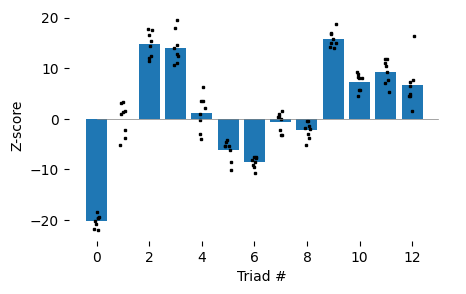

In [7]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.bar(all_counts.columns, all_counts.mean())
x = numpy.repeat(all_counts.columns.values.reshape((1, -1)), len(all_counts), axis=0)
x = x + 0.25 * (numpy.random.rand(*x.shape) - 0.5)
ax.plot(x, all_counts.values, color="black", ls="None", marker='s', ms=2)
ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

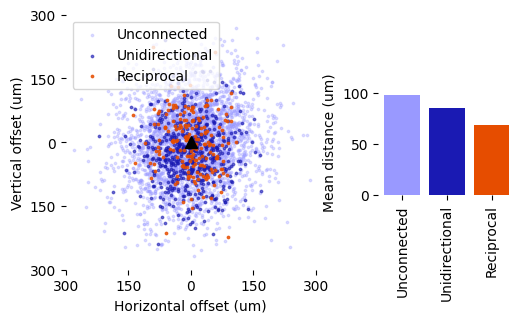

In [8]:
i = 0
d = all_deltas.loc[i]
d["distance"] = numpy.linalg.norm(d, axis=1)
dists = d.reset_index().groupby("level_0")["distance"].mean()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(len(arr_in), int(len(arr_in) * frac), replace=False)
    return arr_in.iloc[b]["horizontal"], arr_in.iloc[b]["vertical"]

cols_use = [[0.6, 0.6, 1.0], [0.1, 0.1, 0.7], [0.9, 0.3, 0.0]]

ax.scatter(*sample_random_fraction(d.loc["unconnected"], 0.5), color=cols_use[0], s=3, alpha=0.3, label="Unconnected")
ax.scatter(*sample_random_fraction(d.loc["unidirectional"], 0.5), color=cols_use[1], s=3, alpha=0.6, label="Unidirectional")
ax.scatter(*sample_random_fraction(d.loc["reciprocal"], 0.5), color=cols_use[2], s=3, alpha=0.8, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
ax.set_frame_on(False)
# plt.axis("equal")
ax.set_xlim([-300, 300]); ax.set_xticks([-300, -150, 0, 150, 300]); ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_ylim([-300, 300]); ax.set_yticks([-300, -150, 0, 150, 300]); ax.set_yticklabels([300, 150, 0, 150, 300])
plt.legend()

ax = fig.add_axes([0.725, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color=cols_use[2])
ax.bar(1, dists["unidirectional"], color=cols_use[1])
ax.bar(0, dists["unconnected"], color=cols_use[0])
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")
ax.set_frame_on(False)

The purpose of the plot above is to show our sampling, and that it resembles in vitro sampling.
To be compared to Peng et al., Figure 2A

Also, we see that at this scale there is a bit of distance-dependence, but not much: Unconnected, unidirectionally connected and reciprocally connected pairs are at slightly different distances.

## Part II: How the scale over which we sample affects things
This part includes a look at reciprocal connectivity: Is it over- or under-expressed?

#### Validate connection probabilites
To be compared to Peng et al., Figure 1B

First panel showing that we closely match Peng et al. connection probabilities. But only with "s2f" pruning.


In [10]:
fns = {
    "Circ. model": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_NEWfunct_conmat_filtered_compressed.h5",
    "E to T": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_pruned_edges_to_touches.h5",
    "T to T": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_pruned_touches_to_touches.h5",
    "E to E": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_prunedEdges_conmat.h5",
    "T to E": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_prunedTouches_conmat.h5"
}

Ms = dict([(k, conntility.ConnectivityMatrix.from_h5(v))
           for k, v in fns.items()])

For context: Sampling at scales that resemble Peng et al (see above). But now including the various controls.

In [11]:
def patch_result_to_con_probs(deltas):
    deltas = deltas[(deltas != 0).any(axis=1)]

    tst = deltas.reset_index().groupby("subvolume")["level_1"].value_counts().unstack("level_1")
    tst["connected"] = tst["reciprocal"] + tst["unidirectional"]
    tst["reciprocal_pairs"] = tst["reciprocal"] / 2 # Because the original analysis counts rc pairs twice, once for each direction
    tst["sorted_pairs"] = tst["connected"] + tst["unconnected"]
    tst["pairs"] = tst["sorted_pairs"] / 2

    count_srt = int(tst["sorted_pairs"][0]) # All samplings have the same number. Just using the first.
    count_unsrt = int(tst["pairs"][0])
    
    return tst, count_srt, count_unsrt

campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

df_Ps = []; counts_srt = []; counts_unsrt = []
for k, M in Ms.items():
    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    df_P, c_srt, c_un = patch_result_to_con_probs(deltas)
    df_Ps.append((k, df_P)); counts_srt.append((k, c_srt)); counts_unsrt.append((k, c_un))
df_Ps = dict(df_Ps); counts_srt = dict(counts_srt); counts_unsrt = dict(counts_unsrt)

  7%|▋         | 4/55 [00:00<00:03, 15.30it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010454654693603516
Found 42 connected triads
Time spent classifying triads: 0.003945827484130859
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 43 connected triads
Time spent classifying triads: 0.0017404556274414062
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011649131774902344
Found 103 connected triads
Time spent classifying triads: 0.003962993621826172
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011522769927978516
Found 90 connected triads
Time spent classifying triads: 0.003506898880004883


 15%|█▍        | 8/55 [00:00<00:03, 15.35it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 87 connected triads
Time spent classifying triads: 0.008070230484008789
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 27 connected triads
Time spent classifying triads: 0.0011382102966308594
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010998249053955078
Found 81 connected triads
Time spent classifying triads: 0.003148794174194336
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010981559753417969
Found 90 connected triads
Time spent classifying triads: 0.0035147666931152344


 22%|██▏       | 12/55 [00:00<00:02, 15.72it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010995864868164062
Found 73 connected triads
Time spent classifying triads: 0.006794452667236328
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007565021514892578
Found 8 connected triads
Time spent classifying triads: 0.0004162788391113281
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 10 connected triads
Time spent classifying triads: 0.0004928112030029297
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 75 connected triads
Time spent classifying triads: 0.0029387474060058594


 29%|██▉       | 16/55 [00:01<00:02, 15.72it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009801387786865234
Found 34 connected triads
Time spent classifying triads: 0.003221273422241211
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 20 connected triads
Time spent classifying triads: 0.0008704662322998047
Testing 31 potential triadic pairs
Time spent finding triads: 0.000919342041015625
Found 46 connected triads
Time spent classifying triads: 0.001840353012084961
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 42 connected triads
Time spent classifying triads: 0.0016932487487792969


 36%|███▋      | 20/55 [00:01<00:02, 15.59it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012843608856201172
Found 131 connected triads
Time spent classifying triads: 0.010408401489257812
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010895729064941406
Found 77 connected triads
Time spent classifying triads: 0.0030236244201660156
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008516311645507812
Found 22 connected triads
Time spent classifying triads: 0.0009386539459228516
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010793209075927734
Found 65 connected triads
Time spent classifying triads: 0.0025682449340820312


 44%|████▎     | 24/55 [00:01<00:01, 15.70it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009648799896240234
Found 41 connected triads
Time spent classifying triads: 0.0038449764251708984
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 35 connected triads
Time spent classifying triads: 0.0014362335205078125
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011043548583984375
Found 79 connected triads
Time spent classifying triads: 0.0030989646911621094
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010013580322265625
Found 44 connected triads
Time spent classifying triads: 0.0018270015716552734


 51%|█████     | 28/55 [00:01<00:01, 15.58it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010530948638916016
Found 52 connected triads
Time spent classifying triads: 0.004850625991821289
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009491443634033203
Found 43 connected triads
Time spent classifying triads: 0.0017240047454833984
Testing 49 potential triadic pairs
Time spent finding triads: 0.0011043548583984375
Found 90 connected triads
Time spent classifying triads: 0.0034987926483154297
Testing 46 potential triadic pairs
Time spent finding triads: 0.001020669937133789
Found 60 connected triads
Time spent classifying triads: 0.0023670196533203125


 58%|█████▊    | 32/55 [00:02<00:01, 15.68it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010771751403808594
Found 53 connected triads
Time spent classifying triads: 0.004970550537109375
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007498264312744141
Found 5 connected triads
Time spent classifying triads: 0.00030112266540527344
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010352134704589844
Found 58 connected triads
Time spent classifying triads: 0.002307415008544922
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010132789611816406
Found 48 connected triads
Time spent classifying triads: 0.0019173622131347656


 65%|██████▌   | 36/55 [00:02<00:01, 15.74it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010080337524414062
Found 47 connected triads
Time spent classifying triads: 0.0044171810150146484
Testing 6 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 6 connected triads
Time spent classifying triads: 0.000331878662109375
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011720657348632812
Found 103 connected triads
Time spent classifying triads: 0.003978729248046875
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 9 connected triads
Time spent classifying triads: 0.0004405975341796875


 73%|███████▎  | 40/55 [00:02<00:00, 15.79it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 9 connected triads
Time spent classifying triads: 0.0009417533874511719
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 84 connected triads
Time spent classifying triads: 0.0032739639282226562
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008945465087890625
Found 32 connected triads
Time spent classifying triads: 0.0013225078582763672
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009744167327880859
Found 49 connected triads
Time spent classifying triads: 0.0019559860229492188


 80%|████████  | 44/55 [00:02<00:00, 15.85it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 22 connected triads
Time spent classifying triads: 0.0021250247955322266
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 13 connected triads
Time spent classifying triads: 0.0006055831909179688
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 41 connected triads
Time spent classifying triads: 0.0016720294952392578
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009582042694091797
Found 37 connected triads
Time spent classifying triads: 0.0015072822570800781


 87%|████████▋ | 48/55 [00:03<00:00, 15.77it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 16 connected triads
Time spent classifying triads: 0.0015873908996582031
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007610321044921875
Found 5 connected triads
Time spent classifying triads: 0.00029397010803222656
Testing 66 potential triadic pairs
Time spent finding triads: 0.001264810562133789
Found 153 connected triads
Time spent classifying triads: 0.005891323089599609
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011546611785888672
Found 89 connected triads
Time spent classifying triads: 0.0034835338592529297


 95%|█████████▍| 52/55 [00:03<00:00, 15.48it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012941360473632812
Found 133 connected triads
Time spent classifying triads: 0.01220083236694336
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 12 connected triads
Time spent classifying triads: 0.0005650520324707031
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011932849884033203
Found 110 connected triads
Time spent classifying triads: 0.004241943359375
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009784698486328125
Found 43 connected triads
Time spent classifying triads: 0.001728057861328125


100%|██████████| 55/55 [00:03<00:00, 15.60it/s]


Testing 36 potential triadic pairs
Time spent finding triads: 0.0010018348693847656
Found 36 connected triads
Time spent classifying triads: 0.003403902053833008
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 18 connected triads
Time spent classifying triads: 0.0007810592651367188
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 13 connected triads
Time spent classifying triads: 0.0005939006805419922


  7%|▋         | 4/55 [00:00<00:03, 15.66it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010979175567626953
Found 73 connected triads
Time spent classifying triads: 0.004182577133178711
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011143684387207031
Found 78 connected triads
Time spent classifying triads: 0.003044605255126953
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009524822235107422
Found 36 connected triads
Time spent classifying triads: 0.001478433609008789
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 27 connected triads
Time spent classifying triads: 0.0011324882507324219


 15%|█▍        | 8/55 [00:00<00:03, 15.37it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010590553283691406
Found 48 connected triads
Time spent classifying triads: 0.0022978782653808594
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011129379272460938
Found 94 connected triads
Time spent classifying triads: 0.003838062286376953
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010423660278320312
Found 59 connected triads
Time spent classifying triads: 0.0023086071014404297
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 22 connected triads
Time spent classifying triads: 0.0009293556213378906


 22%|██▏       | 12/55 [00:00<00:02, 15.39it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010416507720947266
Found 55 connected triads
Time spent classifying triads: 0.0051229000091552734
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 19 connected triads
Time spent classifying triads: 0.0008330345153808594
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010635852813720703
Found 75 connected triads
Time spent classifying triads: 0.002946615219116211
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 19 connected triads
Time spent classifying triads: 0.0008401870727539062


 25%|██▌       | 14/55 [00:00<00:02, 15.35it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 10 connected triads
Time spent classifying triads: 0.00103759765625
Testing 48 potential triadic pairs
Time spent finding triads: 0.001043081283569336
Found 64 connected triads
Time spent classifying triads: 0.002542257308959961
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008890628814697266
Found 26 connected triads
Time spent classifying triads: 0.0010995864868164062
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 50 connected triads
Time spent classifying triads: 0.0019991397857666016


 33%|███▎      | 18/55 [00:01<00:02, 15.23it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011053085327148438
Found 56 connected triads
Time spent classifying triads: 0.0051937103271484375
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010173320770263672
Found 57 connected triads
Time spent classifying triads: 0.002259492874145508
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011076927185058594
Found 77 connected triads
Time spent classifying triads: 0.003000020980834961
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011341571807861328
Found 82 connected triads
Time spent classifying triads: 0.0031986236572265625


 44%|████▎     | 24/55 [00:01<00:02, 15.33it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 36 connected triads
Time spent classifying triads: 0.0033943653106689453
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009813308715820312
Found 52 connected triads
Time spent classifying triads: 0.0020656585693359375
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 86 connected triads
Time spent classifying triads: 0.003345489501953125
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010461807250976562
Found 61 connected triads
Time spent classifying triads: 0.0024192333221435547


 51%|█████     | 28/55 [00:01<00:01, 15.41it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010030269622802734
Found 40 connected triads
Time spent classifying triads: 0.003751516342163086
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 30 connected triads
Time spent classifying triads: 0.0012347698211669922
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010082721710205078
Found 58 connected triads
Time spent classifying triads: 0.002269268035888672
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 17 connected triads
Time spent classifying triads: 0.0007412433624267578


 55%|█████▍    | 30/55 [00:01<00:01, 15.15it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010046958923339844
Found 37 connected triads
Time spent classifying triads: 0.0035033226013183594
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 108 connected triads
Time spent classifying triads: 0.0041713714599609375
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011050701141357422
Found 82 connected triads
Time spent classifying triads: 0.005453348159790039
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 12 connected triads
Time spent classifying triads: 0.0005552768707275391


 62%|██████▏   | 34/55 [00:02<00:01, 15.18it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 72 connected triads
Time spent classifying triads: 0.0036373138427734375
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007574558258056641
Found 5 connected triads
Time spent classifying triads: 0.00029540061950683594
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010771751403808594
Found 67 connected triads
Time spent classifying triads: 0.002640247344970703
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010864734649658203
Found 46 connected triads
Time spent classifying triads: 0.003960132598876953


 73%|███████▎  | 40/55 [00:02<00:00, 15.13it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 10 connected triads
Time spent classifying triads: 0.0010373592376708984
Testing 53 potential triadic pairs
Time spent finding triads: 0.001081228256225586
Found 65 connected triads
Time spent classifying triads: 0.002559185028076172
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011401176452636719
Found 70 connected triads
Time spent classifying triads: 0.0027341842651367188
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 19 connected triads
Time spent classifying triads: 0.0008292198181152344


 80%|████████  | 44/55 [00:02<00:00, 15.58it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011279582977294922
Found 81 connected triads
Time spent classifying triads: 0.003601551055908203
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 17 connected triads
Time spent classifying triads: 0.0007460117340087891
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009133815765380859
Found 27 connected triads
Time spent classifying triads: 0.0011281967163085938
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007121562957763672
Found 0 connected triads
Time spent classifying triads: 0.00010538101196289062
!


 87%|████████▋ | 48/55 [00:03<00:00, 15.65it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008485317230224609
Found 11 connected triads
Time spent classifying triads: 0.0011277198791503906
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009701251983642578
Found 44 connected triads
Time spent classifying triads: 0.001764059066772461
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008797645568847656
Found 22 connected triads
Time spent classifying triads: 0.0009341239929199219
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007121562957763672
Found 0 connected triads
Time spent classifying triads: 6.842613220214844e-05
!


 95%|█████████▍| 52/55 [00:03<00:00, 15.35it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 17 connected triads
Time spent classifying triads: 0.0016753673553466797
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010590553283691406
Found 69 connected triads
Time spent classifying triads: 0.0027174949645996094
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010216236114501953
Found 79 connected triads
Time spent classifying triads: 0.0030732154846191406
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 9 connected triads
Time spent classifying triads: 0.00045561790466308594


100%|██████████| 55/55 [00:03<00:00, 15.24it/s]


Testing 48 potential triadic pairs
Time spent finding triads: 0.0011022090911865234
Found 62 connected triads
Time spent classifying triads: 0.0057888031005859375
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 20 connected triads
Time spent classifying triads: 0.0008726119995117188
Testing 55 potential triadic pairs
Time spent finding triads: 0.001186370849609375
Found 125 connected triads
Time spent classifying triads: 0.005232334136962891


  7%|▋         | 4/55 [00:00<00:03, 16.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012736320495605469
Found 139 connected triads
Time spent classifying triads: 0.012796878814697266
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011386871337890625
Found 96 connected triads
Time spent classifying triads: 0.003737926483154297
Testing 12 potential triadic pairs
Time spent finding triads: 0.0009169578552246094
Found 16 connected triads
Time spent classifying triads: 0.0007140636444091797
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 27 connected triads
Time spent classifying triads: 0.0011420249938964844


 15%|█▍        | 8/55 [00:00<00:02, 16.79it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 17 connected triads
Time spent classifying triads: 0.0016717910766601562
Testing 35 potential triadic pairs
Time spent finding triads: 0.00095367431640625
Found 43 connected triads
Time spent classifying triads: 0.0017333030700683594
Testing 47 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 61 connected triads
Time spent classifying triads: 0.002412080764770508
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 11 connected triads
Time spent classifying triads: 0.0005328655242919922


 22%|██▏       | 12/55 [00:00<00:02, 16.99it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 5 connected triads
Time spent classifying triads: 0.0005855560302734375
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009894371032714844
Found 49 connected triads
Time spent classifying triads: 0.0019588470458984375
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010409355163574219
Found 58 connected triads
Time spent classifying triads: 0.0023033618927001953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012195110321044922
Found 128 connected triads
Time spent classifying triads: 0.00493931770324707


 29%|██▉       | 16/55 [00:00<00:02, 16.93it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010175704956054688
Found 40 connected triads
Time spent classifying triads: 0.0037467479705810547
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009045600891113281
Found 29 connected triads
Time spent classifying triads: 0.0012056827545166016
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 16 connected triads
Time spent classifying triads: 0.0007064342498779297
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011467933654785156
Found 100 connected triads
Time spent classifying triads: 0.0038747787475585938


 36%|███▋      | 20/55 [00:01<00:02, 16.37it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011143684387207031
Found 65 connected triads
Time spent classifying triads: 0.006063222885131836
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012826919555664062
Found 158 connected triads
Time spent classifying triads: 0.006051063537597656
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011141300201416016
Found 79 connected triads
Time spent classifying triads: 0.003091573715209961
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011925697326660156
Found 115 connected triads
Time spent classifying triads: 0.0043942928314208984


 44%|████▎     | 24/55 [00:01<00:01, 16.86it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010859966278076172
Found 52 connected triads
Time spent classifying triads: 0.004857778549194336
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011227130889892578
Found 88 connected triads
Time spent classifying triads: 0.003443002700805664
Testing 30 potential triadic pairs
Time spent finding triads: 0.00089263916015625
Found 35 connected triads
Time spent classifying triads: 0.0014224052429199219
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011124610900878906
Found 92 connected triads
Time spent classifying triads: 0.0035789012908935547


 51%|█████     | 28/55 [00:01<00:01, 16.57it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011343955993652344
Found 79 connected triads
Time spent classifying triads: 0.004535675048828125
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 34 connected triads
Time spent classifying triads: 0.0013964176177978516
Testing 55 potential triadic pairs
Time spent finding triads: 0.001077890396118164
Found 73 connected triads
Time spent classifying triads: 0.0028533935546875
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009169578552246094
Found 34 connected triads
Time spent classifying triads: 0.0014071464538574219


 58%|█████▊    | 32/55 [00:01<00:01, 16.18it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011625289916992188
Found 96 connected triads
Time spent classifying triads: 0.008887529373168945
Testing 65 potential triadic pairs
Time spent finding triads: 0.001203775405883789
Found 125 connected triads
Time spent classifying triads: 0.004822731018066406
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 41 connected triads
Time spent classifying triads: 0.0016677379608154297
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 85 connected triads
Time spent classifying triads: 0.0033364295959472656


 65%|██████▌   | 36/55 [00:02<00:01, 16.22it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011038780212402344
Found 64 connected triads
Time spent classifying triads: 0.005953311920166016
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007185935974121094
Found 1 connected triads
Time spent classifying triads: 0.0001773834228515625
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 26 connected triads
Time spent classifying triads: 0.0010974407196044922
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 62 connected triads
Time spent classifying triads: 0.005218505859375


 73%|███████▎  | 40/55 [00:02<00:00, 16.67it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010242462158203125
Found 46 connected triads
Time spent classifying triads: 0.004335641860961914
Testing 47 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 68 connected triads
Time spent classifying triads: 0.002679586410522461
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009248256683349609
Found 31 connected triads
Time spent classifying triads: 0.0012869834899902344
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 23 connected triads
Time spent classifying triads: 0.0009818077087402344


 80%|████████  | 44/55 [00:02<00:00, 16.41it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010225772857666016
Found 44 connected triads
Time spent classifying triads: 0.004158735275268555
Testing 38 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 49 connected triads
Time spent classifying triads: 0.001962423324584961
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008451938629150391
Found 23 connected triads
Time spent classifying triads: 0.000972747802734375
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 42 connected triads
Time spent classifying triads: 0.0016961097717285156


 87%|████████▋ | 48/55 [00:02<00:00, 16.35it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010304450988769531
Found 45 connected triads
Time spent classifying triads: 0.00424504280090332
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007541179656982422
Found 8 connected triads
Time spent classifying triads: 0.0004150867462158203
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010647773742675781
Found 68 connected triads
Time spent classifying triads: 0.0026712417602539062
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009856224060058594
Found 51 connected triads
Time spent classifying triads: 0.002022981643676758


 95%|█████████▍| 52/55 [00:03<00:00, 16.38it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009748935699462891
Found 31 connected triads
Time spent classifying triads: 0.0029642581939697266
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010800361633300781
Found 67 connected triads
Time spent classifying triads: 0.002650737762451172
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010328292846679688
Found 69 connected triads
Time spent classifying triads: 0.002707958221435547
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009701251983642578
Found 43 connected triads
Time spent classifying triads: 0.001735687255859375


100%|██████████| 55/55 [00:03<00:00, 16.46it/s]


Testing 51 potential triadic pairs
Time spent finding triads: 0.0011479854583740234
Found 70 connected triads
Time spent classifying triads: 0.003047466278076172
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 89 connected triads
Time spent classifying triads: 0.0034589767456054688
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010864734649658203
Found 78 connected triads
Time spent classifying triads: 0.0030388832092285156


  4%|▎         | 2/55 [00:00<00:03, 14.40it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009677410125732422
Found 35 connected triads
Time spent classifying triads: 0.0033135414123535156
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 22 connected triads
Time spent classifying triads: 0.0009388923645019531
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 42 connected triads
Time spent classifying triads: 0.0017044544219970703


 11%|█         | 6/55 [00:00<00:03, 14.29it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0015881061553955078
Found 29 connected triads
Time spent classifying triads: 0.0027697086334228516
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012154579162597656
Found 114 connected triads
Time spent classifying triads: 0.004424571990966797
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 18 connected triads
Time spent classifying triads: 0.0007941722869873047


 15%|█▍        | 8/55 [00:00<00:03, 14.02it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0014414787292480469
Found 40 connected triads
Time spent classifying triads: 0.003795623779296875
Testing 59 potential triadic pairs
Time spent finding triads: 0.001119375228881836
Found 72 connected triads
Time spent classifying triads: 0.0028231143951416016
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 24 connected triads
Time spent classifying triads: 0.0010216236114501953


 22%|██▏       | 12/55 [00:00<00:03, 14.07it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0011844635009765625
Found 18 connected triads
Time spent classifying triads: 0.0017745494842529297
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 38 connected triads
Time spent classifying triads: 0.0015523433685302734
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011780261993408203
Found 114 connected triads
Time spent classifying triads: 0.004408121109008789


 25%|██▌       | 14/55 [00:00<00:02, 14.12it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001055002212524414
Found 47 connected triads
Time spent classifying triads: 0.0037789344787597656
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 9 connected triads
Time spent classifying triads: 0.00044846534729003906
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009639263153076172
Found 40 connected triads
Time spent classifying triads: 0.001627206802368164


 33%|███▎      | 18/55 [00:01<00:02, 14.22it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001890420913696289
Found 74 connected triads
Time spent classifying triads: 0.006478548049926758
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007424354553222656
Found 3 connected triads
Time spent classifying triads: 0.000217437744140625
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009160041809082031
Found 29 connected triads
Time spent classifying triads: 0.0012094974517822266


 36%|███▋      | 20/55 [00:01<00:02, 13.88it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001169443130493164
Found 87 connected triads
Time spent classifying triads: 0.008049964904785156
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012729167938232422
Found 145 connected triads
Time spent classifying triads: 0.005532741546630859
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 53 connected triads
Time spent classifying triads: 0.0021033287048339844


 44%|████▎     | 24/55 [00:01<00:02, 14.02it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010173320770263672
Found 42 connected triads
Time spent classifying triads: 0.003942251205444336
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010046958923339844
Found 49 connected triads
Time spent classifying triads: 0.001959085464477539
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009474754333496094
Found 39 connected triads
Time spent classifying triads: 0.0015895366668701172


 47%|████▋     | 26/55 [00:01<00:02, 14.06it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0011267662048339844
Found 10 connected triads
Time spent classifying triads: 0.0008938312530517578
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009007453918457031
Found 29 connected triads
Time spent classifying triads: 0.0012078285217285156
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010409355163574219
Found 55 connected triads
Time spent classifying triads: 0.0021948814392089844


 55%|█████▍    | 30/55 [00:02<00:01, 14.18it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0012428760528564453
Found 63 connected triads
Time spent classifying triads: 0.0058858394622802734
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010199546813964844
Found 56 connected triads
Time spent classifying triads: 0.0022192001342773438
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007147789001464844
Found 0 connected triads
Time spent classifying triads: 6.866455078125e-05
!


 58%|█████▊    | 32/55 [00:02<00:01, 14.03it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0022830963134765625
Found 96 connected triads
Time spent classifying triads: 0.004861593246459961
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010204315185546875
Found 51 connected triads
Time spent classifying triads: 0.002025127410888672
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010919570922851562
Found 78 connected triads
Time spent classifying triads: 0.003044605255126953


 65%|██████▌   | 36/55 [00:02<00:01, 13.99it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001176595687866211
Found 86 connected triads
Time spent classifying triads: 0.007956266403198242
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011339187622070312
Found 91 connected triads
Time spent classifying triads: 0.0035495758056640625
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009102821350097656
Found 27 connected triads
Time spent classifying triads: 0.0011289119720458984


 73%|███████▎  | 40/55 [00:02<00:01, 14.49it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 0 connected triads
Time spent classifying triads: 0.00012373924255371094
!
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 29 connected triads
Time spent classifying triads: 0.0012161731719970703
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007300376892089844
Found 2 connected triads
Time spent classifying triads: 0.0001766681671142578
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 10 connected triads
Time spent classifying triads: 0.00048470497131347656


 76%|███████▋  | 42/55 [00:02<00:00, 14.28it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0013422966003417969
Found 103 connected triads
Time spent classifying triads: 0.004677534103393555
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011289119720458984
Found 85 connected triads
Time spent classifying triads: 0.0033147335052490234
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009627342224121094
Found 44 connected triads
Time spent classifying triads: 0.0017704963684082031


 84%|████████▎ | 46/55 [00:03<00:00, 14.15it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 59 connected triads
Time spent classifying triads: 0.0054929256439208984
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011601448059082031
Found 97 connected triads
Time spent classifying triads: 0.003735065460205078
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011813640594482422
Found 97 connected triads
Time spent classifying triads: 0.003761768341064453


 87%|████████▋ | 48/55 [00:03<00:00, 14.34it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 5 connected triads
Time spent classifying triads: 0.0005867481231689453
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007238388061523438
Found 0 connected triads
Time spent classifying triads: 7.152557373046875e-05
!
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007784366607666016
Found 9 connected triads
Time spent classifying triads: 0.00044918060302734375
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010640621185302734
Found 76 connected triads
Time spent classifying triads: 0.003526449203491211


 95%|█████████▍| 52/55 [00:03<00:00, 14.29it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 12 connected triads
Time spent classifying triads: 0.0012099742889404297
Testing 54 potential triadic pairs
Time spent finding triads: 0.001104116439819336
Found 75 connected triads
Time spent classifying triads: 0.002931833267211914
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010297298431396484
Found 62 connected triads
Time spent classifying triads: 0.002440929412841797


100%|██████████| 55/55 [00:03<00:00, 14.13it/s]


Testing 26 potential triadic pairs
Time spent finding triads: 0.0012814998626708984
Found 25 connected triads
Time spent classifying triads: 0.001990795135498047
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 14 connected triads
Time spent classifying triads: 0.0006330013275146484


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011513233184814453
Found 84 connected triads
Time spent classifying triads: 0.007798671722412109


  7%|▋         | 4/55 [00:00<00:02, 18.25it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 11 connected triads
Time spent classifying triads: 0.0011265277862548828
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 19 connected triads
Time spent classifying triads: 0.0008263587951660156
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007691383361816406
Found 10 connected triads
Time spent classifying triads: 0.0004792213439941406
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 30 connected triads
Time spent classifying triads: 0.0028803348541259766


 15%|█▍        | 8/55 [00:00<00:02, 17.38it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 51 connected triads
Time spent classifying triads: 0.0047833919525146484
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007579326629638672
Found 7 connected triads
Time spent classifying triads: 0.00036644935607910156
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011868476867675781
Found 112 connected triads
Time spent classifying triads: 0.0043218135833740234
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 13 connected triads
Time spent classifying triads: 0.0013115406036376953


 22%|██▏       | 12/55 [00:00<00:02, 17.13it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011184215545654297
Found 72 connected triads
Time spent classifying triads: 0.0066640377044677734
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009379386901855469
Found 29 connected triads
Time spent classifying triads: 0.0011949539184570312
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007255077362060547
Found 1 connected triads
Time spent classifying triads: 0.00012755393981933594
Testing 16 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 14 connected triads
Time spent classifying triads: 0.0013949871063232422


 29%|██▉       | 16/55 [00:00<00:02, 16.96it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007603168487548828
Found 2 connected triads
Time spent classifying triads: 0.0002903938293457031
Testing 47 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 73 connected triads
Time spent classifying triads: 0.0028562545776367188
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011696815490722656
Found 100 connected triads
Time spent classifying triads: 0.0038766860961914062
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009198188781738281
Found 30 connected triads
Time spent classifying triads: 0.0028476715087890625


 36%|███▋      | 20/55 [00:01<00:02, 17.02it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 14 connected triads
Time spent classifying triads: 0.0014119148254394531
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 19 connected triads
Time spent classifying triads: 0.0008270740509033203
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009124279022216797
Found 35 connected triads
Time spent classifying triads: 0.001425027847290039
Testing 37 potential triadic pairs
Time spent finding triads: 0.0010151863098144531
Found 39 connected triads
Time spent classifying triads: 0.0036847591400146484


 44%|████▎     | 24/55 [00:01<00:01, 17.27it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 24 connected triads
Time spent classifying triads: 0.0014235973358154297
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007359981536865234
Found 3 connected triads
Time spent classifying triads: 0.00021696090698242188
Testing 39 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 49 connected triads
Time spent classifying triads: 0.001973867416381836
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009915828704833984
Found 34 connected triads
Time spent classifying triads: 0.003229379653930664


 51%|█████     | 28/55 [00:01<00:01, 17.26it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010230541229248047
Found 54 connected triads
Time spent classifying triads: 0.005055904388427734
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010318756103515625
Found 62 connected triads
Time spent classifying triads: 0.0024480819702148438
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 60 connected triads
Time spent classifying triads: 0.0023746490478515625
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011219978332519531
Found 68 connected triads
Time spent classifying triads: 0.0063440799713134766


 58%|█████▊    | 32/55 [00:01<00:01, 17.18it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012712478637695312
Found 140 connected triads
Time spent classifying triads: 0.009926795959472656
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 39 connected triads
Time spent classifying triads: 0.0015666484832763672
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011014938354492188
Found 72 connected triads
Time spent classifying triads: 0.0028247833251953125
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011625289916992188
Found 85 connected triads
Time spent classifying triads: 0.007881402969360352


 65%|██████▌   | 36/55 [00:02<00:01, 17.02it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011298656463623047
Found 73 connected triads
Time spent classifying triads: 0.006768465042114258
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009496212005615234
Found 42 connected triads
Time spent classifying triads: 0.0016944408416748047
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 23 connected triads
Time spent classifying triads: 0.0009860992431640625
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011010169982910156
Found 63 connected triads
Time spent classifying triads: 0.00587153434753418


 73%|███████▎  | 40/55 [00:02<00:00, 16.75it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.00113677978515625
Found 75 connected triads
Time spent classifying triads: 0.0069463253021240234
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 26 connected triads
Time spent classifying triads: 0.0010950565338134766
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007777214050292969
Found 10 connected triads
Time spent classifying triads: 0.0004918575286865234
Testing 39 potential triadic pairs
Time spent finding triads: 0.0010128021240234375
Found 41 connected triads
Time spent classifying triads: 0.00260162353515625


 80%|████████  | 44/55 [00:02<00:00, 17.05it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 20 connected triads
Time spent classifying triads: 0.0019495487213134766
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009968280792236328
Found 40 connected triads
Time spent classifying triads: 0.0016100406646728516
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009613037109375
Found 46 connected triads
Time spent classifying triads: 0.0018286705017089844
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 9 connected triads
Time spent classifying triads: 0.0009424686431884766


 87%|████████▋ | 48/55 [00:02<00:00, 17.36it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 42 connected triads
Time spent classifying triads: 0.0039768218994140625
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007262229919433594
Found 1 connected triads
Time spent classifying triads: 0.00012874603271484375
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009641647338867188
Found 56 connected triads
Time spent classifying triads: 0.0021810531616210938
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010693073272705078
Found 69 connected triads
Time spent classifying triads: 0.006409168243408203


 95%|█████████▍| 52/55 [00:03<00:00, 17.03it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0010917186737060547
Found 61 connected triads
Time spent classifying triads: 0.005694389343261719
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 41 connected triads
Time spent classifying triads: 0.001657724380493164
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012326240539550781
Found 130 connected triads
Time spent classifying triads: 0.0049896240234375
Testing 47 potential triadic pairs
Time spent finding triads: 0.001066446304321289
Found 52 connected triads
Time spent classifying triads: 0.0049016475677490234


100%|██████████| 55/55 [00:03<00:00, 17.00it/s]


Testing 40 potential triadic pairs
Time spent finding triads: 0.0010304450988769531
Found 46 connected triads
Time spent classifying triads: 0.004314422607421875
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 31 connected triads
Time spent classifying triads: 0.0012755393981933594


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011990070343017578
Found 60 connected triads
Time spent classifying triads: 0.0056018829345703125


  7%|▋         | 4/55 [00:00<00:03, 15.30it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011320114135742188
Found 79 connected triads
Time spent classifying triads: 0.007371664047241211
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010221004486083984
Found 51 connected triads
Time spent classifying triads: 0.002014636993408203
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 15 connected triads
Time spent classifying triads: 0.0006783008575439453
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 18 connected triads
Time spent classifying triads: 0.001766204833984375


 15%|█▍        | 8/55 [00:00<00:02, 15.73it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009570121765136719
Found 28 connected triads
Time spent classifying triads: 0.0026717185974121094
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010786056518554688
Found 67 connected triads
Time spent classifying triads: 0.0026297569274902344
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 37 connected triads
Time spent classifying triads: 0.0015037059783935547
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012226104736328125
Found 108 connected triads
Time spent classifying triads: 0.009957551956176758


 22%|██▏       | 12/55 [00:00<00:02, 15.66it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010519027709960938
Found 44 connected triads
Time spent classifying triads: 0.0041692256927490234
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 22 connected triads
Time spent classifying triads: 0.0009303092956542969
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010707378387451172
Found 75 connected triads
Time spent classifying triads: 0.002942800521850586
Testing 23 potential triadic pairs
Time spent finding triads: 0.0009160041809082031
Found 29 connected triads
Time spent classifying triads: 0.0027806758880615234


 29%|██▉       | 16/55 [00:01<00:02, 15.82it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009615421295166016
Found 30 connected triads
Time spent classifying triads: 0.002861499786376953
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009443759918212891
Found 38 connected triads
Time spent classifying triads: 0.0015344619750976562
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010671615600585938
Found 78 connected triads
Time spent classifying triads: 0.003055572509765625
Testing 66 potential triadic pairs
Time spent finding triads: 0.001264810562133789
Found 114 connected triads
Time spent classifying triads: 0.010549068450927734


 36%|███▋      | 20/55 [00:01<00:02, 15.26it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009772777557373047
Found 40 connected triads
Time spent classifying triads: 0.003770112991333008
Testing 55 potential triadic pairs
Time spent finding triads: 0.0012378692626953125
Found 73 connected triads
Time spent classifying triads: 0.002873659133911133
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013117790222167969
Found 162 connected triads
Time spent classifying triads: 0.006211519241333008
Testing 50 potential triadic pairs
Time spent finding triads: 0.0011181831359863281
Found 64 connected triads
Time spent classifying triads: 0.0059642791748046875


 44%|████▎     | 24/55 [00:01<00:01, 15.56it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010004043579101562
Found 41 connected triads
Time spent classifying triads: 0.0038738250732421875
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 32 connected triads
Time spent classifying triads: 0.0013210773468017578
Testing 9 potential triadic pairs
Time spent finding triads: 0.000782012939453125
Found 9 connected triads
Time spent classifying triads: 0.00045037269592285156
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 71 connected triads
Time spent classifying triads: 0.006619691848754883


 51%|█████     | 28/55 [00:01<00:01, 15.46it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009698867797851562
Found 34 connected triads
Time spent classifying triads: 0.0032341480255126953
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009701251983642578
Found 43 connected triads
Time spent classifying triads: 0.0017385482788085938
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009822845458984375
Found 53 connected triads
Time spent classifying triads: 0.0021033287048339844
Testing 39 potential triadic pairs
Time spent finding triads: 0.0010151863098144531
Found 39 connected triads
Time spent classifying triads: 0.003691434860229492


 55%|█████▍    | 30/55 [00:01<00:01, 15.14it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 131 connected triads
Time spent classifying triads: 0.012044906616210938
Testing 45 potential triadic pairs
Time spent finding triads: 0.001009225845336914
Found 56 connected triads
Time spent classifying triads: 0.002691984176635742
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010852813720703125
Found 77 connected triads
Time spent classifying triads: 0.002996206283569336


 58%|█████▊    | 32/55 [00:02<00:01, 15.26it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009920597076416016
Found 36 connected triads
Time spent classifying triads: 0.0034275054931640625


 62%|██████▏   | 34/55 [00:02<00:01, 15.24it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010342597961425781
Found 51 connected triads
Time spent classifying triads: 0.0027065277099609375
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010526180267333984
Found 64 connected triads
Time spent classifying triads: 0.0025146007537841797


 69%|██████▉   | 38/55 [00:02<00:01, 13.34it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010662078857421875
Found 49 connected triads
Time spent classifying triads: 0.0046041011810302734
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010995864868164062
Found 83 connected triads
Time spent classifying triads: 0.0032203197479248047
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 14 connected triads
Time spent classifying triads: 0.0006358623504638672
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011217594146728516
Found 92 connected triads
Time spent classifying triads: 0.0035598278045654297


 76%|███████▋  | 42/55 [00:02<00:00, 14.49it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009756088256835938
Found 40 connected triads
Time spent classifying triads: 0.0037572383880615234
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010333061218261719
Found 61 connected triads
Time spent classifying triads: 0.0023949146270751953
Testing 48 potential triadic pairs
Time spent finding triads: 0.001032114028930664
Found 59 connected triads
Time spent classifying triads: 0.002330303192138672
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 55 connected triads
Time spent classifying triads: 0.0022165775299072266


 84%|████████▎ | 46/55 [00:03<00:00, 14.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007781982421875
Found 1 connected triads
Time spent classifying triads: 0.00018787384033203125
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011115074157714844
Found 74 connected triads
Time spent classifying triads: 0.0028862953186035156
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012247562408447266
Found 136 connected triads
Time spent classifying triads: 0.005183219909667969
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010383129119873047
Found 58 connected triads
Time spent classifying triads: 0.0022847652435302734


 91%|█████████ | 50/55 [00:03<00:00, 15.27it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 82 connected triads
Time spent classifying triads: 0.005242109298706055
Testing 64 potential triadic pairs
Time spent finding triads: 0.001180887222290039
Found 100 connected triads
Time spent classifying triads: 0.003854036331176758
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010144710540771484
Found 54 connected triads
Time spent classifying triads: 0.0021333694458007812
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 70 connected triads
Time spent classifying triads: 0.00272369384765625


100%|██████████| 55/55 [00:03<00:00, 15.02it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010478496551513672
Found 59 connected triads
Time spent classifying triads: 0.005529165267944336
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 60 connected triads
Time spent classifying triads: 0.0023441314697265625
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 110 connected triads
Time spent classifying triads: 0.004237174987792969
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007212162017822266
Found 1 connected triads
Time spent classifying triads: 0.0001323223114013672



  7%|▋         | 4/55 [00:00<00:03, 15.62it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001220703125
Found 104 connected triads
Time spent classifying triads: 0.009549856185913086
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010271072387695312
Found 58 connected triads
Time spent classifying triads: 0.0022873878479003906
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009090900421142578
Found 27 connected triads
Time spent classifying triads: 0.0011262893676757812
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 23 connected triads
Time spent classifying triads: 0.0009713172912597656


 15%|█▍        | 8/55 [00:00<00:02, 15.84it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010983943939208984
Found 56 connected triads
Time spent classifying triads: 0.005254507064819336
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010676383972167969
Found 69 connected triads
Time spent classifying triads: 0.002691030502319336
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009334087371826172
Found 39 connected triads
Time spent classifying triads: 0.0015816688537597656
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 42 connected triads
Time spent classifying triads: 0.0016927719116210938


 22%|██▏       | 12/55 [00:00<00:02, 15.78it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009002685546875
Found 18 connected triads
Time spent classifying triads: 0.0017704963684082031
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011196136474609375
Found 93 connected triads
Time spent classifying triads: 0.003578662872314453
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010502338409423828
Found 68 connected triads
Time spent classifying triads: 0.002646207809448242
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 31 connected triads
Time spent classifying triads: 0.00127410888671875


 29%|██▉       | 16/55 [00:01<00:02, 16.10it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 22 connected triads
Time spent classifying triads: 0.0021119117736816406
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009794235229492188
Found 45 connected triads
Time spent classifying triads: 0.001804351806640625
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 28 connected triads
Time spent classifying triads: 0.001163482666015625
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012097358703613281
Found 127 connected triads
Time spent classifying triads: 0.004892587661743164


 36%|███▋      | 20/55 [00:01<00:02, 15.95it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009109973907470703
Found 21 connected triads
Time spent classifying triads: 0.0020465850830078125
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010001659393310547
Found 61 connected triads
Time spent classifying triads: 0.002410888671875
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010581016540527344
Found 60 connected triads
Time spent classifying triads: 0.002377033233642578
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010497570037841797
Found 71 connected triads
Time spent classifying triads: 0.0027666091918945312


 44%|████▎     | 24/55 [00:01<00:01, 15.84it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009744167327880859
Found 31 connected triads
Time spent classifying triads: 0.0029451847076416016
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 25 connected triads
Time spent classifying triads: 0.0010347366333007812
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011205673217773438
Found 86 connected triads
Time spent classifying triads: 0.0033309459686279297
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011355876922607422
Found 88 connected triads
Time spent classifying triads: 0.003412961959838867


 51%|█████     | 28/55 [00:01<00:01, 16.01it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009524822235107422
Found 29 connected triads
Time spent classifying triads: 0.0027577877044677734
Testing 55 potential triadic pairs
Time spent finding triads: 0.001138448715209961
Found 95 connected triads
Time spent classifying triads: 0.003672361373901367
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010607242584228516
Found 57 connected triads
Time spent classifying triads: 0.002244710922241211
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010979175567626953
Found 75 connected triads
Time spent classifying triads: 0.0029256343841552734


 58%|█████▊    | 32/55 [00:02<00:01, 16.29it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 25 connected triads
Time spent classifying triads: 0.0024127960205078125
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009961128234863281
Found 54 connected triads
Time spent classifying triads: 0.002141237258911133
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 27 connected triads
Time spent classifying triads: 0.0011296272277832031
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 11 connected triads
Time spent classifying triads: 0.0005152225494384766


 65%|██████▌   | 36/55 [00:02<00:01, 16.17it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009322166442871094
Found 26 connected triads
Time spent classifying triads: 0.0025033950805664062
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011699199676513672
Found 101 connected triads
Time spent classifying triads: 0.003908872604370117
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 26 connected triads
Time spent classifying triads: 0.0010857582092285156
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007412433624267578
Found 3 connected triads
Time spent classifying triads: 0.0002167224884033203


 73%|███████▎  | 40/55 [00:02<00:00, 15.90it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001222848892211914
Found 106 connected triads
Time spent classifying triads: 0.009814739227294922
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010106563568115234
Found 50 connected triads
Time spent classifying triads: 0.0019941329956054688
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 21 connected triads
Time spent classifying triads: 0.0008955001831054688
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011315345764160156
Found 99 connected triads
Time spent classifying triads: 0.003837108612060547


 80%|████████  | 44/55 [00:02<00:00, 15.90it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001131296157836914
Found 77 connected triads
Time spent classifying triads: 0.007134914398193359
Testing 49 potential triadic pairs
Time spent finding triads: 0.001016855239868164
Found 52 connected triads
Time spent classifying triads: 0.002058267593383789
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011181831359863281
Found 86 connected triads
Time spent classifying triads: 0.003330230712890625
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010504722595214844
Found 62 connected triads
Time spent classifying triads: 0.0024309158325195312


 87%|████████▋ | 48/55 [00:03<00:00, 15.83it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011606216430664062
Found 85 connected triads
Time spent classifying triads: 0.007898092269897461
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 25 connected triads
Time spent classifying triads: 0.0010476112365722656
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009212493896484375
Found 31 connected triads
Time spent classifying triads: 0.001285552978515625
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 33 connected triads
Time spent classifying triads: 0.001360177993774414


 95%|█████████▍| 52/55 [00:03<00:00, 15.66it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010581016540527344
Found 47 connected triads
Time spent classifying triads: 0.0044155120849609375
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 86 connected triads
Time spent classifying triads: 0.0033402442932128906
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011448860168457031
Found 96 connected triads
Time spent classifying triads: 0.003689289093017578
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 17 connected triads
Time spent classifying triads: 0.0007517337799072266


100%|██████████| 55/55 [00:03<00:00, 15.85it/s]


Testing 61 potential triadic pairs
Time spent finding triads: 0.0011932849884033203
Found 95 connected triads
Time spent classifying triads: 0.008747339248657227
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010952949523925781
Found 75 connected triads
Time spent classifying triads: 0.002907276153564453
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 21 connected triads
Time spent classifying triads: 0.0008931159973144531


  4%|▎         | 2/55 [00:00<00:03, 14.97it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009710788726806641
Found 26 connected triads
Time spent classifying triads: 0.0017576217651367188
Testing 13 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 13 connected triads
Time spent classifying triads: 0.0006034374237060547
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 24 connected triads
Time spent classifying triads: 0.0010194778442382812
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 15 connected triads
Time spent classifying triads: 0.000667572021484375


 15%|█▍        | 8/55 [00:00<00:03, 15.13it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008740425109863281
Found 14 connected triads
Time spent classifying triads: 0.0013930797576904297
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 37 connected triads
Time spent classifying triads: 0.0015001296997070312
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007431507110595703
Found 2 connected triads
Time spent classifying triads: 0.0001773834228515625
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 12 connected triads
Time spent classifying triads: 0.0005555152893066406


 22%|██▏       | 12/55 [00:00<00:02, 15.20it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 15 connected triads
Time spent classifying triads: 0.0014994144439697266
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 14 connected triads
Time spent classifying triads: 0.0006392002105712891
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008966922760009766
Found 31 connected triads
Time spent classifying triads: 0.0012767314910888672
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 18 connected triads
Time spent classifying triads: 0.0007958412170410156


 29%|██▉       | 16/55 [00:01<00:02, 15.21it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009708404541015625
Found 27 connected triads
Time spent classifying triads: 0.002600431442260742
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009129047393798828
Found 30 connected triads
Time spent classifying triads: 0.00124359130859375
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 11 connected triads
Time spent classifying triads: 0.0005173683166503906
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009431838989257812
Found 38 connected triads
Time spent classifying triads: 0.0015397071838378906


 33%|███▎      | 18/55 [00:01<00:02, 15.03it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009894371032714844
Found 31 connected triads
Time spent classifying triads: 0.002948760986328125
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011146068572998047
Found 79 connected triads
Time spent classifying triads: 0.003086566925048828
Testing 29 potential triadic pairs
Time spent finding triads: 0.0010528564453125
Found 35 connected triads
Time spent classifying triads: 0.0014235973358154297
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009739398956298828
Found 43 connected triads
Time spent classifying triads: 0.004030942916870117


 44%|████▎     | 24/55 [00:01<00:02, 14.96it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0010483264923095703
Found 31 connected triads
Time spent classifying triads: 0.0025823116302490234
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008616447448730469
Found 24 connected triads
Time spent classifying triads: 0.0010213851928710938
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009515285491943359
Found 35 connected triads
Time spent classifying triads: 0.0014317035675048828
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 9 connected triads
Time spent classifying triads: 0.00045108795166015625


 51%|█████     | 28/55 [00:01<00:01, 15.08it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008881092071533203
Found 15 connected triads
Time spent classifying triads: 0.001491546630859375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 11 connected triads
Time spent classifying triads: 0.0005292892456054688
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 15 connected triads
Time spent classifying triads: 0.00067138671875
Testing 20 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 18 connected triads
Time spent classifying triads: 0.0007970333099365234


 58%|█████▊    | 32/55 [00:02<00:01, 15.15it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 15 connected triads
Time spent classifying triads: 0.0015118122100830078
Testing 9 potential triadic pairs
Time spent finding triads: 0.000774383544921875
Found 9 connected triads
Time spent classifying triads: 0.0004558563232421875
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007379055023193359
Found 4 connected triads
Time spent classifying triads: 0.00026488304138183594
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009062290191650391
Found 28 connected triads
Time spent classifying triads: 0.0011615753173828125


 65%|██████▌   | 36/55 [00:02<00:01, 15.02it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010247230529785156
Found 38 connected triads
Time spent classifying triads: 0.003584623336791992
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 18 connected triads
Time spent classifying triads: 0.0008013248443603516
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 52 connected triads
Time spent classifying triads: 0.0020515918731689453
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 21 connected triads
Time spent classifying triads: 0.0009009838104248047


 69%|██████▉   | 38/55 [00:02<00:01, 14.96it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009348392486572266
Found 27 connected triads
Time spent classifying triads: 0.002583742141723633
Testing 44 potential triadic pairs
Time spent finding triads: 0.001001596450805664
Found 53 connected triads
Time spent classifying triads: 0.0021140575408935547
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 21 connected triads
Time spent classifying triads: 0.0009062290191650391
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009179115295410156
Found 26 connected triads
Time spent classifying triads: 0.0011036396026611328


 80%|████████  | 44/55 [00:02<00:00, 15.08it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001043081283569336
Found 47 connected triads
Time spent classifying triads: 0.00441741943359375
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 15 connected triads
Time spent classifying triads: 0.0006756782531738281
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007584095001220703
Found 7 connected triads
Time spent classifying triads: 0.0003795623779296875
Testing 13 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 13 connected triads
Time spent classifying triads: 0.0006062984466552734


 87%|████████▋ | 48/55 [00:03<00:00, 15.04it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011327266693115234
Found 69 connected triads
Time spent classifying triads: 0.006399869918823242
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 19 connected triads
Time spent classifying triads: 0.0008189678192138672
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 12 connected triads
Time spent classifying triads: 0.000568389892578125
Testing 46 potential triadic pairs
Time spent finding triads: 0.001016855239868164
Found 48 connected triads
Time spent classifying triads: 0.0019240379333496094


 91%|█████████ | 50/55 [00:03<00:00, 15.00it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 20 connected triads
Time spent classifying triads: 0.001947164535522461
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 24 connected triads
Time spent classifying triads: 0.0010173320770263672
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 60 connected triads
Time spent classifying triads: 0.0023682117462158203


100%|██████████| 55/55 [00:03<00:00, 14.99it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0014188289642333984
Found 17 connected triads
Time spent classifying triads: 0.0017101764678955078
Testing 16 potential triadic pairs
Time spent finding triads: 0.0009293556213378906
Found 14 connected triads
Time spent classifying triads: 0.0006353855133056641
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 19 connected triads
Time spent classifying triads: 0.0008306503295898438
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 35 connected triads
Time spent classifying triads: 0.0014295578002929688



  4%|▎         | 2/55 [00:00<00:03, 15.00it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 4 connected triads
Time spent classifying triads: 0.00047969818115234375
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 19 connected triads
Time spent classifying triads: 0.0008203983306884766
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 30 connected triads
Time spent classifying triads: 0.0012388229370117188
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 15 connected triads
Time spent classifying triads: 0.0014801025390625


 11%|█         | 6/55 [00:00<00:03, 14.48it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001146554946899414
Found 44 connected triads
Time spent classifying triads: 0.004137992858886719
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 28 connected triads
Time spent classifying triads: 0.0011734962463378906
Testing 45 potential triadic pairs
Time spent finding triads: 0.0011234283447265625
Found 61 connected triads
Time spent classifying triads: 0.002403736114501953
Testing 12 potential triadic pairs
Time spent finding triads: 0.0008916854858398438
Found 14 connected triads
Time spent classifying triads: 0.0013816356658935547


 22%|██▏       | 12/55 [00:00<00:02, 14.84it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0010600090026855469
Found 22 connected triads
Time spent classifying triads: 0.002135038375854492
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009219646453857422
Found 33 connected triads
Time spent classifying triads: 0.0013637542724609375
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 10 connected triads
Time spent classifying triads: 0.0004813671112060547
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 41 connected triads
Time spent classifying triads: 0.0016598701477050781


 25%|██▌       | 14/55 [00:00<00:02, 14.95it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 12 connected triads
Time spent classifying triads: 0.0012178421020507812
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 33 connected triads
Time spent classifying triads: 0.0013599395751953125
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010068416595458984
Found 52 connected triads
Time spent classifying triads: 0.0020685195922851562
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 21 connected triads
Time spent classifying triads: 0.0009102821350097656


 33%|███▎      | 18/55 [00:01<00:02, 14.68it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0010600090026855469
Found 24 connected triads
Time spent classifying triads: 0.002321958541870117
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 28 connected triads
Time spent classifying triads: 0.0011622905731201172
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009455680847167969
Found 33 connected triads
Time spent classifying triads: 0.0013589859008789062


 40%|████      | 22/55 [00:01<00:02, 14.67it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0011823177337646484
Found 37 connected triads
Time spent classifying triads: 0.003480672836303711
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007483959197998047
Found 5 connected triads
Time spent classifying triads: 0.00030517578125
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008695125579833984
Found 23 connected triads
Time spent classifying triads: 0.0009751319885253906
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 17 connected triads
Time spent classifying triads: 0.0007562637329101562


 47%|████▋     | 26/55 [00:01<00:02, 14.46it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009946823120117188
Found 28 connected triads
Time spent classifying triads: 0.002682924270629883
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 21 connected triads
Time spent classifying triads: 0.0009126663208007812
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009171962738037109
Found 29 connected triads
Time spent classifying triads: 0.0012073516845703125


 51%|█████     | 28/55 [00:01<00:01, 14.47it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 3 connected triads
Time spent classifying triads: 0.00037741661071777344
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007815361022949219
Found 6 connected triads
Time spent classifying triads: 0.00033593177795410156
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009143352508544922
Found 30 connected triads
Time spent classifying triads: 0.0028460025787353516


 58%|█████▊    | 32/55 [00:02<00:01, 14.28it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001298666000366211
Found 82 connected triads
Time spent classifying triads: 0.007582187652587891
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010204315185546875
Found 54 connected triads
Time spent classifying triads: 0.002148151397705078
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 37 connected triads
Time spent classifying triads: 0.0014982223510742188
Testing 32 potential triadic pairs
Time spent finding triads: 0.0010552406311035156
Found 34 connected triads
Time spent classifying triads: 0.0032072067260742188


 65%|██████▌   | 36/55 [00:02<00:01, 14.38it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009706020355224609
Found 31 connected triads
Time spent classifying triads: 0.002952098846435547
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009012222290039062
Found 29 connected triads
Time spent classifying triads: 0.0011959075927734375
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 23 connected triads
Time spent classifying triads: 0.000978708267211914


 69%|██████▉   | 38/55 [00:02<00:01, 14.41it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0013577938079833984
Found 2 connected triads
Time spent classifying triads: 0.0002884864807128906
Testing 43 potential triadic pairs
Time spent finding triads: 0.000997304916381836
Found 50 connected triads
Time spent classifying triads: 0.002004384994506836
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009770393371582031
Found 25 connected triads
Time spent classifying triads: 0.002414703369140625


 76%|███████▋  | 42/55 [00:02<00:00, 14.50it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0014333724975585938
Found 40 connected triads
Time spent classifying triads: 0.0037720203399658203
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 8 connected triads
Time spent classifying triads: 0.00042057037353515625
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009129047393798828
Found 28 connected triads
Time spent classifying triads: 0.0011675357818603516
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 14 connected triads
Time spent classifying triads: 0.0008816719055175781


 84%|████████▎ | 46/55 [00:03<00:00, 14.43it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009036064147949219
Found 16 connected triads
Time spent classifying triads: 0.0015988349914550781
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 48 connected triads
Time spent classifying triads: 0.0019328594207763672
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009329319000244141
Found 28 connected triads
Time spent classifying triads: 0.0011737346649169922


 87%|████████▋ | 48/55 [00:03<00:00, 14.26it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 36 connected triads
Time spent classifying triads: 0.003409862518310547
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010323524475097656
Found 54 connected triads
Time spent classifying triads: 0.0021495819091796875
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008187294006347656
Found 13 connected triads
Time spent classifying triads: 0.0006067752838134766


 95%|█████████▍| 52/55 [00:03<00:00, 14.56it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0015385150909423828
Found 18 connected triads
Time spent classifying triads: 0.0017609596252441406
Testing 3 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 3 connected triads
Time spent classifying triads: 0.0002205371856689453
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 25 connected triads
Time spent classifying triads: 0.0010542869567871094
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007631778717041016
Found 6 connected triads
Time spent classifying triads: 0.00033283233642578125


100%|██████████| 55/55 [00:03<00:00, 14.50it/s]


Testing 8 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 8 connected triads
Time spent classifying triads: 0.0008502006530761719
Testing 15 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 13 connected triads
Time spent classifying triads: 0.0006108283996582031


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010058879852294922
Found 35 connected triads
Time spent classifying triads: 0.0033311843872070312


  7%|▋         | 4/55 [00:00<00:03, 16.33it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009515285491943359
Found 26 connected triads
Time spent classifying triads: 0.0024955272674560547
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007655620574951172
Found 4 connected triads
Time spent classifying triads: 0.0002589225769042969
Testing 34 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 38 connected triads
Time spent classifying triads: 0.0015408992767333984
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 59 connected triads
Time spent classifying triads: 0.0055010318756103516


 15%|█▍        | 8/55 [00:00<00:02, 16.31it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009677410125732422
Found 38 connected triads
Time spent classifying triads: 0.0035758018493652344
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007860660552978516
Found 10 connected triads
Time spent classifying triads: 0.0004906654357910156
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 17 connected triads
Time spent classifying triads: 0.0007560253143310547
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009088516235351562
Found 25 connected triads
Time spent classifying triads: 0.0023937225341796875


 22%|██▏       | 12/55 [00:00<00:02, 16.56it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 16 connected triads
Time spent classifying triads: 0.0015900135040283203
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010602474212646484
Found 64 connected triads
Time spent classifying triads: 0.002527952194213867
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 61 connected triads
Time spent classifying triads: 0.0024199485778808594
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009958744049072266
Found 42 connected triads
Time spent classifying triads: 0.004003047943115234


 29%|██▉       | 16/55 [00:00<00:02, 16.62it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 20 connected triads
Time spent classifying triads: 0.0018262863159179688
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009844303131103516
Found 46 connected triads
Time spent classifying triads: 0.0018439292907714844
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 23 connected triads
Time spent classifying triads: 0.0009760856628417969
Testing 51 potential triadic pairs
Time spent finding triads: 0.0011081695556640625
Found 76 connected triads
Time spent classifying triads: 0.007075786590576172


 36%|███▋      | 20/55 [00:01<00:02, 16.85it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009188652038574219
Found 25 connected triads
Time spent classifying triads: 0.002409219741821289
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 23 connected triads
Time spent classifying triads: 0.0009806156158447266
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 31 connected triads
Time spent classifying triads: 0.0012729167938232422
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008828639984130859
Found 20 connected triads
Time spent classifying triads: 0.0019435882568359375


 44%|████▎     | 24/55 [00:01<00:01, 16.16it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001012563705444336
Found 37 connected triads
Time spent classifying triads: 0.003428220748901367
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 34 connected triads
Time spent classifying triads: 0.0014088153839111328
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 23 connected triads
Time spent classifying triads: 0.0009768009185791016
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009913444519042969
Found 40 connected triads
Time spent classifying triads: 0.0035092830657958984


 51%|█████     | 28/55 [00:01<00:01, 16.26it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 48 connected triads
Time spent classifying triads: 0.004484415054321289
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010230541229248047
Found 65 connected triads
Time spent classifying triads: 0.002552509307861328
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 25 connected triads
Time spent classifying triads: 0.0010523796081542969
Testing 24 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 22 connected triads
Time spent classifying triads: 0.0021352767944335938


 58%|█████▊    | 32/55 [00:01<00:01, 16.30it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010366439819335938
Found 47 connected triads
Time spent classifying triads: 0.004418134689331055
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009026527404785156
Found 26 connected triads
Time spent classifying triads: 0.001104593276977539
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009021759033203125
Found 28 connected triads
Time spent classifying triads: 0.0011799335479736328
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009596347808837891
Found 36 connected triads
Time spent classifying triads: 0.003418445587158203


 65%|██████▌   | 36/55 [00:02<00:01, 16.08it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 16 connected triads
Time spent classifying triads: 0.0016028881072998047
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009810924530029297
Found 42 connected triads
Time spent classifying triads: 0.0017011165618896484
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009310245513916016
Found 34 connected triads
Time spent classifying triads: 0.0014026165008544922
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 8 connected triads
Time spent classifying triads: 0.0008513927459716797


 73%|███████▎  | 40/55 [00:02<00:00, 16.45it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 14 connected triads
Time spent classifying triads: 0.0014019012451171875
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009109973907470703
Found 31 connected triads
Time spent classifying triads: 0.0012824535369873047
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 20 connected triads
Time spent classifying triads: 0.0008616447448730469
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 14 connected triads
Time spent classifying triads: 0.001413583755493164


 80%|████████  | 44/55 [00:02<00:00, 16.04it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008840560913085938
Found 20 connected triads
Time spent classifying triads: 0.0019447803497314453
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 30 connected triads
Time spent classifying triads: 0.0012407302856445312
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009987354278564453
Found 48 connected triads
Time spent classifying triads: 0.0019161701202392578
Testing 4 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 6 connected triads
Time spent classifying triads: 0.0006642341613769531


 87%|████████▋ | 48/55 [00:02<00:00, 16.39it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010733604431152344
Found 63 connected triads
Time spent classifying triads: 0.0058710575103759766
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 26 connected triads
Time spent classifying triads: 0.0010833740234375
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007731914520263672
Found 10 connected triads
Time spent classifying triads: 0.0004930496215820312
Testing 38 potential triadic pairs
Time spent finding triads: 0.00101470947265625
Found 47 connected triads
Time spent classifying triads: 0.004430055618286133


 95%|█████████▍| 52/55 [00:03<00:00, 16.68it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009922981262207031
Found 39 connected triads
Time spent classifying triads: 0.0037207603454589844
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 20 connected triads
Time spent classifying triads: 0.0008738040924072266
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 33 connected triads
Time spent classifying triads: 0.001363515853881836
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 24 connected triads
Time spent classifying triads: 0.002310037612915039


100%|██████████| 55/55 [00:03<00:00, 16.28it/s]


Testing 15 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 13 connected triads
Time spent classifying triads: 0.0013246536254882812
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007636547088623047
Found 6 connected triads
Time spent classifying triads: 0.00033545494079589844


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009663105010986328
Found 32 connected triads
Time spent classifying triads: 0.003057718276977539


  4%|▎         | 2/55 [00:00<00:04, 12.69it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009465217590332031
Found 31 connected triads
Time spent classifying triads: 0.0029540061950683594
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 18 connected triads
Time spent classifying triads: 0.0007991790771484375


  7%|▋         | 4/55 [00:00<00:04, 12.71it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 42 connected triads
Time spent classifying triads: 0.003966331481933594


 11%|█         | 6/55 [00:00<00:03, 12.96it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 5 connected triads
Time spent classifying triads: 0.0005676746368408203
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 34 connected triads
Time spent classifying triads: 0.0013844966888427734
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010867118835449219
Found 46 connected triads
Time spent classifying triads: 0.0043032169342041016


 15%|█▍        | 8/55 [00:00<00:03, 12.66it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009832382202148438
Found 40 connected triads
Time spent classifying triads: 0.0022249221801757812
Testing 9 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 7 connected triads
Time spent classifying triads: 0.0003821849822998047


 18%|█▊        | 10/55 [00:00<00:03, 12.85it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 22 connected triads
Time spent classifying triads: 0.0021343231201171875


 22%|██▏       | 12/55 [00:00<00:03, 12.95it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 36 connected triads
Time spent classifying triads: 0.003402233123779297
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007517337799072266
Found 5 connected triads
Time spent classifying triads: 0.0002956390380859375
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010848045349121094
Found 59 connected triads
Time spent classifying triads: 0.005517005920410156


 25%|██▌       | 14/55 [00:01<00:03, 12.74it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 16 connected triads
Time spent classifying triads: 0.0015845298767089844
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 14 connected triads
Time spent classifying triads: 0.0006375312805175781


 29%|██▉       | 16/55 [00:01<00:03, 12.89it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 9 connected triads
Time spent classifying triads: 0.0009377002716064453


 33%|███▎      | 18/55 [00:01<00:02, 12.99it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009846687316894531
Found 43 connected triads
Time spent classifying triads: 0.002524137496948242
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007874965667724609
Found 10 connected triads
Time spent classifying triads: 0.0004870891571044922
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 30 connected triads
Time spent classifying triads: 0.002858877182006836


 36%|███▋      | 20/55 [00:01<00:02, 12.94it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 23 connected triads
Time spent classifying triads: 0.0022149085998535156
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007631778717041016
Found 5 connected triads
Time spent classifying triads: 0.0003008842468261719


 40%|████      | 22/55 [00:01<00:02, 12.95it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 28 connected triads
Time spent classifying triads: 0.0026836395263671875


 44%|████▎     | 24/55 [00:01<00:02, 12.92it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009760856628417969
Found 37 connected triads
Time spent classifying triads: 0.0035085678100585938
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 14 connected triads
Time spent classifying triads: 0.0006465911865234375
Testing 23 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 21 connected triads
Time spent classifying triads: 0.0020520687103271484


 47%|████▋     | 26/55 [00:02<00:02, 12.84it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010137557983398438
Found 31 connected triads
Time spent classifying triads: 0.002961397171020508
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 35 connected triads
Time spent classifying triads: 0.0014317035675048828


 51%|█████     | 28/55 [00:02<00:02, 12.89it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 16 connected triads
Time spent classifying triads: 0.0015914440155029297


 55%|█████▍    | 30/55 [00:02<00:01, 13.03it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 10 connected triads
Time spent classifying triads: 0.0010378360748291016
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 14 connected triads
Time spent classifying triads: 0.0006337165832519531
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009889602661132812
Found 34 connected triads
Time spent classifying triads: 0.002969503402709961


 58%|█████▊    | 32/55 [00:02<00:01, 12.97it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0009186267852783203
Found 15 connected triads
Time spent classifying triads: 0.001493692398071289
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 32 connected triads
Time spent classifying triads: 0.0013167858123779297


 62%|██████▏   | 34/55 [00:02<00:01, 12.91it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 25 connected triads
Time spent classifying triads: 0.0024039745330810547


 65%|██████▌   | 36/55 [00:02<00:01, 12.95it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 24 connected triads
Time spent classifying triads: 0.002315998077392578
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 16 connected triads
Time spent classifying triads: 0.0007050037384033203
Testing 38 potential triadic pairs
Time spent finding triads: 0.0010149478912353516
Found 49 connected triads
Time spent classifying triads: 0.002692699432373047


 69%|██████▉   | 38/55 [00:02<00:01, 12.80it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.001104116439819336
Found 61 connected triads
Time spent classifying triads: 0.005697011947631836
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 21 connected triads
Time spent classifying triads: 0.0009109973907470703


 73%|███████▎  | 40/55 [00:03<00:01, 12.86it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 27 connected triads
Time spent classifying triads: 0.002574920654296875


 76%|███████▋  | 42/55 [00:03<00:01, 12.98it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0011594295501708984
Found 40 connected triads
Time spent classifying triads: 0.0016541481018066406
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 19 connected triads
Time spent classifying triads: 0.0008327960968017578
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 8 connected triads
Time spent classifying triads: 0.0008604526519775391


 80%|████████  | 44/55 [00:03<00:00, 12.90it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009350776672363281
Found 30 connected triads
Time spent classifying triads: 0.0028617382049560547
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 27 connected triads
Time spent classifying triads: 0.0011181831359863281


 84%|████████▎ | 46/55 [00:03<00:00, 12.85it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 14 connected triads
Time spent classifying triads: 0.0013990402221679688


 87%|████████▋ | 48/55 [00:03<00:00, 12.88it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001018524169921875
Found 48 connected triads
Time spent classifying triads: 0.00450587272644043
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 23 connected triads
Time spent classifying triads: 0.0009813308715820312
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010950565338134766
Found 53 connected triads
Time spent classifying triads: 0.004968404769897461


 91%|█████████ | 50/55 [00:03<00:00, 12.79it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009059906005859375
Found 18 connected triads
Time spent classifying triads: 0.0017778873443603516
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 19 connected triads
Time spent classifying triads: 0.0008258819580078125


 95%|█████████▍| 52/55 [00:04<00:00, 12.83it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 15 connected triads
Time spent classifying triads: 0.0016925334930419922


 98%|█████████▊| 54/55 [00:04<00:00, 12.90it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 10 connected triads
Time spent classifying triads: 0.0010323524475097656
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009915828704833984
Found 51 connected triads
Time spent classifying triads: 0.0020415782928466797


100%|██████████| 55/55 [00:04<00:00, 12.88it/s]


Testing 7 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 7 connected triads
Time spent classifying triads: 0.0007584095001220703


  4%|▎         | 2/55 [00:00<00:03, 17.16it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010271072387695312
Found 48 connected triads
Time spent classifying triads: 0.004502534866333008
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009324550628662109
Found 38 connected triads
Time spent classifying triads: 0.0015451908111572266


  7%|▋         | 4/55 [00:00<00:03, 15.89it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010173320770263672
Found 41 connected triads
Time spent classifying triads: 0.003881692886352539
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009908676147460938
Found 44 connected triads
Time spent classifying triads: 0.0017857551574707031


 11%|█         | 6/55 [00:00<00:03, 16.28it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009360313415527344
Found 28 connected triads
Time spent classifying triads: 0.002661466598510742
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 30 connected triads
Time spent classifying triads: 0.0012464523315429688


 15%|█▍        | 8/55 [00:00<00:02, 16.16it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009918212890625
Found 40 connected triads
Time spent classifying triads: 0.003775358200073242
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 14 connected triads
Time spent classifying triads: 0.0006465911865234375


 18%|█▊        | 10/55 [00:00<00:02, 16.32it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 27 connected triads
Time spent classifying triads: 0.002572774887084961
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 14 connected triads
Time spent classifying triads: 0.0006325244903564453


 22%|██▏       | 12/55 [00:00<00:02, 16.43it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 15 connected triads
Time spent classifying triads: 0.0014805793762207031
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008821487426757812
Found 25 connected triads
Time spent classifying triads: 0.001062154769897461


 25%|██▌       | 14/55 [00:00<00:02, 16.25it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007686614990234375
Found 3 connected triads
Time spent classifying triads: 0.0003993511199951172
Testing 28 potential triadic pairs
Time spent finding triads: 0.000911712646484375
Found 39 connected triads
Time spent classifying triads: 0.0015866756439208984


 29%|██▉       | 16/55 [00:00<00:02, 16.35it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001050710678100586
Found 52 connected triads
Time spent classifying triads: 0.004877805709838867
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 32 connected triads
Time spent classifying triads: 0.0013146400451660156


 33%|███▎      | 18/55 [00:01<00:02, 16.35it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009129047393798828
Found 30 connected triads
Time spent classifying triads: 0.002852916717529297
Testing 36 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 40 connected triads
Time spent classifying triads: 0.001621246337890625


 36%|███▋      | 20/55 [00:01<00:02, 16.18it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010590553283691406
Found 56 connected triads
Time spent classifying triads: 0.005239963531494141
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 26 connected triads
Time spent classifying triads: 0.0011038780212402344


 40%|████      | 22/55 [00:01<00:01, 16.64it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 19 connected triads
Time spent classifying triads: 0.0018587112426757812
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007624626159667969
Found 10 connected triads
Time spent classifying triads: 0.0004918575286865234


 44%|████▎     | 24/55 [00:01<00:01, 16.69it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 7 connected triads
Time spent classifying triads: 0.0007622241973876953
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 35 connected triads
Time spent classifying triads: 0.001424551010131836


 47%|████▋     | 26/55 [00:01<00:01, 16.98it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 10 connected triads
Time spent classifying triads: 0.0010340213775634766
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 22 connected triads
Time spent classifying triads: 0.0009367465972900391


 51%|█████     | 28/55 [00:01<00:01, 16.88it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.00095367431640625
Found 32 connected triads
Time spent classifying triads: 0.003060579299926758
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 14 connected triads
Time spent classifying triads: 0.0006337165832519531


 55%|█████▍    | 30/55 [00:01<00:01, 17.03it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009834766387939453
Found 40 connected triads
Time spent classifying triads: 0.003787517547607422
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007686614990234375
Found 9 connected triads
Time spent classifying triads: 0.00044226646423339844


 58%|█████▊    | 32/55 [00:01<00:01, 16.51it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 14 connected triads
Time spent classifying triads: 0.0013988018035888672
Testing 34 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 28 connected triads
Time spent classifying triads: 0.0011646747589111328


 62%|██████▏   | 34/55 [00:02<00:01, 16.80it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 8 connected triads
Time spent classifying triads: 0.000827789306640625
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 25 connected triads
Time spent classifying triads: 0.0010499954223632812


 65%|██████▌   | 36/55 [00:02<00:01, 16.60it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 7 connected triads
Time spent classifying triads: 0.0007669925689697266
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 38 connected triads
Time spent classifying triads: 0.0015273094177246094


 69%|██████▉   | 38/55 [00:02<00:01, 16.71it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 23 connected triads
Time spent classifying triads: 0.0022194385528564453
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 17 connected triads
Time spent classifying triads: 0.0007531642913818359


 73%|███████▎  | 40/55 [00:02<00:00, 16.68it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010499954223632812
Found 37 connected triads
Time spent classifying triads: 0.003482818603515625
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 9 connected triads
Time spent classifying triads: 0.00044798851013183594


 76%|███████▋  | 42/55 [00:02<00:00, 16.89it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008668899536132812
Found 17 connected triads
Time spent classifying triads: 0.001678466796875
Testing 32 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 32 connected triads
Time spent classifying triads: 0.0013051033020019531


 80%|████████  | 44/55 [00:02<00:00, 16.56it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 18 connected triads
Time spent classifying triads: 0.0017697811126708984
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 15 connected triads
Time spent classifying triads: 0.0006818771362304688


 84%|████████▎ | 46/55 [00:02<00:00, 16.92it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 25 connected triads
Time spent classifying triads: 0.0021505355834960938
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008780956268310547
Found 29 connected triads
Time spent classifying triads: 0.0011982917785644531


 87%|████████▋ | 48/55 [00:02<00:00, 16.89it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 21 connected triads
Time spent classifying triads: 0.002038717269897461
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 17 connected triads
Time spent classifying triads: 0.0007562637329101562


 91%|█████████ | 50/55 [00:03<00:00, 16.78it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 10 connected triads
Time spent classifying triads: 0.0010380744934082031
Testing 47 potential triadic pairs
Time spent finding triads: 0.001013040542602539
Found 52 connected triads
Time spent classifying triads: 0.002079486846923828


 95%|█████████▍| 52/55 [00:03<00:00, 16.87it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 24 connected triads
Time spent classifying triads: 0.0023338794708251953
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 14 connected triads
Time spent classifying triads: 0.0006384849548339844


 98%|█████████▊| 54/55 [00:03<00:00, 16.69it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010230541229248047
Found 32 connected triads
Time spent classifying triads: 0.003057718276977539
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009286403656005859
Found 32 connected triads
Time spent classifying triads: 0.0013210773468017578


100%|██████████| 55/55 [00:03<00:00, 16.63it/s]


Testing 34 potential triadic pairs
Time spent finding triads: 0.0009703636169433594
Found 39 connected triads
Time spent classifying triads: 0.0036940574645996094


  4%|▎         | 2/55 [00:00<00:03, 15.56it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001009225845336914
Found 37 connected triads
Time spent classifying triads: 0.0034875869750976562
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 27 connected triads
Time spent classifying triads: 0.0011303424835205078
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 28 connected triads
Time spent classifying triads: 0.002677440643310547
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009667873382568359
Found 42 connected triads
Time spent classifying triads: 0.0017132759094238281


  7%|▋         | 4/55 [00:00<00:03, 15.06it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010218620300292969
Found 38 connected triads
Time spent classifying triads: 0.003597259521484375
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 27 connected triads
Time spent classifying triads: 0.001135110855102539


 11%|█         | 6/55 [00:00<00:03, 15.01it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010268688201904297
Found 44 connected triads
Time spent classifying triads: 0.0041429996490478516


 15%|█▍        | 8/55 [00:00<00:04, 11.34it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010650157928466797
Found 62 connected triads
Time spent classifying triads: 0.005776166915893555


 18%|█▊        | 10/55 [00:00<00:03, 12.29it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009279251098632812
Found 27 connected triads
Time spent classifying triads: 0.0025718212127685547
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 17 connected triads
Time spent classifying triads: 0.0007555484771728516
Testing 31 potential triadic pairs
Time spent finding triads: 0.0012023448944091797
Found 27 connected triads
Time spent classifying triads: 0.0025985240936279297


 25%|██▌       | 14/55 [00:01<00:02, 13.69it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0015151500701904297
Found 36 connected triads
Time spent classifying triads: 0.0034027099609375
Testing 16 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 22 connected triads
Time spent classifying triads: 0.0009391307830810547
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009458065032958984
Found 35 connected triads
Time spent classifying triads: 0.0014317035675048828
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 37 connected triads
Time spent classifying triads: 0.0035114288330078125


 29%|██▉       | 16/55 [00:01<00:02, 14.06it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 34 connected triads
Time spent classifying triads: 0.003219127655029297
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 43 connected triads
Time spent classifying triads: 0.0017309188842773438
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 31 connected triads
Time spent classifying triads: 0.001270294189453125


 33%|███▎      | 18/55 [00:01<00:02, 14.24it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009572505950927734
Found 26 connected triads
Time spent classifying triads: 0.0025196075439453125


 36%|███▋      | 20/55 [00:01<00:02, 14.50it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 29 connected triads
Time spent classifying triads: 0.0027680397033691406
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009100437164306641
Found 32 connected triads
Time spent classifying triads: 0.0013201236724853516
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 24 connected triads
Time spent classifying triads: 0.001013040542602539


 47%|████▋     | 26/55 [00:01<00:01, 15.02it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 4 connected triads
Time spent classifying triads: 0.00047659873962402344
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 6 connected triads
Time spent classifying triads: 0.00032901763916015625
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 20 connected triads
Time spent classifying triads: 0.0008683204650878906
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007522106170654297
Found 4 connected triads
Time spent classifying triads: 0.00025534629821777344


 55%|█████▍    | 30/55 [00:02<00:01, 15.22it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.000942230224609375
Found 28 connected triads
Time spent classifying triads: 0.0026700496673583984
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009992122650146484
Found 49 connected triads
Time spent classifying triads: 0.0019571781158447266
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 24 connected triads
Time spent classifying triads: 0.00101470947265625
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 15 connected triads
Time spent classifying triads: 0.0006792545318603516


 62%|██████▏   | 34/55 [00:02<00:01, 15.25it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010170936584472656
Found 47 connected triads
Time spent classifying triads: 0.004415035247802734
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 13 connected triads
Time spent classifying triads: 0.0006098747253417969
Testing 19 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 19 connected triads
Time spent classifying triads: 0.0008280277252197266
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 39 connected triads
Time spent classifying triads: 0.0016169548034667969


 65%|██████▌   | 36/55 [00:02<00:01, 15.23it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 22 connected triads
Time spent classifying triads: 0.002138376235961914
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008771419525146484
Found 32 connected triads
Time spent classifying triads: 0.0013282299041748047
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 28 connected triads
Time spent classifying triads: 0.0011603832244873047
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007417201995849609
Found 5 connected triads
Time spent classifying triads: 0.0002999305725097656


 76%|███████▋  | 42/55 [00:02<00:00, 15.16it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 12 connected triads
Time spent classifying triads: 0.001218557357788086
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009708404541015625
Found 47 connected triads
Time spent classifying triads: 0.0018839836120605469
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009832382202148438
Found 47 connected triads
Time spent classifying triads: 0.0018858909606933594
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 17 connected triads
Time spent classifying triads: 0.0007574558258056641


 84%|████████▎ | 46/55 [00:03<00:00, 15.21it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.000911712646484375
Found 23 connected triads
Time spent classifying triads: 0.0022232532501220703
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 26 connected triads
Time spent classifying triads: 0.0010986328125
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009391307830810547
Found 44 connected triads
Time spent classifying triads: 0.001764059066772461
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 25 connected triads
Time spent classifying triads: 0.0010631084442138672


 87%|████████▋ | 48/55 [00:03<00:00, 15.04it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 7 connected triads
Time spent classifying triads: 0.0007615089416503906
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 17 connected triads
Time spent classifying triads: 0.0007605552673339844
Testing 32 potential triadic pairs
Time spent finding triads: 0.00091552734375
Found 36 connected triads
Time spent classifying triads: 0.0015971660614013672
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 4 connected triads
Time spent classifying triads: 0.00026607513427734375


 98%|█████████▊| 54/55 [00:03<00:00, 15.07it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 28 connected triads
Time spent classifying triads: 0.00266265869140625
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 18 connected triads
Time spent classifying triads: 0.0007910728454589844
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008919239044189453
Found 27 connected triads
Time spent classifying triads: 0.0011272430419921875
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 23 connected triads
Time spent classifying triads: 0.0009751319885253906


100%|██████████| 55/55 [00:03<00:00, 14.62it/s]


Testing 25 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 25 connected triads
Time spent classifying triads: 0.002407073974609375


  4%|▎         | 2/55 [00:00<00:03, 15.75it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 10 connected triads
Time spent classifying triads: 0.001039743423461914
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 20 connected triads
Time spent classifying triads: 0.0008723735809326172


  7%|▋         | 4/55 [00:00<00:03, 15.44it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009293556213378906
Found 29 connected triads
Time spent classifying triads: 0.002759695053100586
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007784366607666016
Found 8 connected triads
Time spent classifying triads: 0.00040721893310546875


 11%|█         | 6/55 [00:00<00:03, 15.63it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009620189666748047
Found 29 connected triads
Time spent classifying triads: 0.0027701854705810547
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 13 connected triads
Time spent classifying triads: 0.0005886554718017578


 15%|█▍        | 8/55 [00:00<00:03, 15.42it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009715557098388672
Found 31 connected triads
Time spent classifying triads: 0.0029532909393310547
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 16 connected triads
Time spent classifying triads: 0.0007140636444091797


 18%|█▊        | 10/55 [00:00<00:02, 15.52it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 39 connected triads
Time spent classifying triads: 0.003694772720336914
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 22 connected triads
Time spent classifying triads: 0.0009417533874511719


 22%|██▏       | 12/55 [00:00<00:02, 15.27it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 13 connected triads
Time spent classifying triads: 0.0013172626495361328
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008840560913085938
Found 28 connected triads
Time spent classifying triads: 0.001165628433227539


 25%|██▌       | 14/55 [00:00<00:02, 15.28it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008633136749267578
Found 16 connected triads
Time spent classifying triads: 0.0016057491302490234
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 26 connected triads
Time spent classifying triads: 0.0010862350463867188


 29%|██▉       | 16/55 [00:01<00:02, 15.40it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 21 connected triads
Time spent classifying triads: 0.002032041549682617
Testing 11 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 9 connected triads
Time spent classifying triads: 0.00045561790466308594


 33%|███▎      | 18/55 [00:01<00:02, 15.45it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 20 connected triads
Time spent classifying triads: 0.0019528865814208984
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 13 connected triads
Time spent classifying triads: 0.0006003379821777344


 36%|███▋      | 20/55 [00:01<00:02, 15.50it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 5 connected triads
Time spent classifying triads: 0.0005829334259033203
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007464885711669922
Found 3 connected triads
Time spent classifying triads: 0.00021505355834960938


 40%|████      | 22/55 [00:01<00:02, 15.53it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 2 connected triads
Time spent classifying triads: 0.00028896331787109375
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 19 connected triads
Time spent classifying triads: 0.0008323192596435547


 44%|████▎     | 24/55 [00:01<00:01, 15.52it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010249614715576172
Found 42 connected triads
Time spent classifying triads: 0.003998994827270508
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 13 connected triads
Time spent classifying triads: 0.0006017684936523438


 47%|████▋     | 26/55 [00:01<00:01, 15.42it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010859966278076172
Found 57 connected triads
Time spent classifying triads: 0.005315065383911133
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 39 connected triads
Time spent classifying triads: 0.0015871524810791016


 51%|█████     | 28/55 [00:01<00:01, 15.43it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 9 connected triads
Time spent classifying triads: 0.0009462833404541016
Testing 14 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 14 connected triads
Time spent classifying triads: 0.0006411075592041016


 55%|█████▍    | 30/55 [00:01<00:01, 15.41it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 19 connected triads
Time spent classifying triads: 0.0018553733825683594
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 9 connected triads
Time spent classifying triads: 0.00045871734619140625


 58%|█████▊    | 32/55 [00:02<00:01, 15.39it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010247230529785156
Found 44 connected triads
Time spent classifying triads: 0.0041408538818359375
Testing 3 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 3 connected triads
Time spent classifying triads: 0.00021648406982421875


 62%|██████▏   | 34/55 [00:02<00:01, 15.63it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 14 connected triads
Time spent classifying triads: 0.0014061927795410156
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009183883666992188
Found 32 connected triads
Time spent classifying triads: 0.001323699951171875


 65%|██████▌   | 36/55 [00:02<00:01, 15.47it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010080337524414062
Found 41 connected triads
Time spent classifying triads: 0.0038433074951171875
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 22 connected triads
Time spent classifying triads: 0.0009407997131347656
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009570121765136719
Found 27 connected triads
Time spent classifying triads: 0.002564668655395508
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 17 connected triads
Time spent classifying triads: 0.0007572174072265625


 73%|███████▎  | 40/55 [00:02<00:00, 15.57it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 30 connected triads
Time spent classifying triads: 0.0025043487548828125
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 5 connected triads
Time spent classifying triads: 0.0002913475036621094


 76%|███████▋  | 42/55 [00:02<00:00, 15.61it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 3 connected triads
Time spent classifying triads: 0.0003840923309326172
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 21 connected triads
Time spent classifying triads: 0.0008966922760009766


 80%|████████  | 44/55 [00:02<00:00, 15.55it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009245872497558594
Found 24 connected triads
Time spent classifying triads: 0.0024802684783935547
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008382797241210938
Found 24 connected triads
Time spent classifying triads: 0.0010161399841308594


 84%|████████▎ | 46/55 [00:02<00:00, 15.59it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 15 connected triads
Time spent classifying triads: 0.0014889240264892578
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 14 connected triads
Time spent classifying triads: 0.0006468296051025391


 87%|████████▋ | 48/55 [00:03<00:00, 15.38it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009365081787109375
Found 28 connected triads
Time spent classifying triads: 0.0026693344116210938
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007758140563964844
Found 8 connected triads
Time spent classifying triads: 0.00041103363037109375


 91%|█████████ | 50/55 [00:03<00:00, 15.34it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.000919342041015625
Found 23 connected triads
Time spent classifying triads: 0.002213001251220703
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008890628814697266
Found 30 connected triads
Time spent classifying triads: 0.0012364387512207031


 95%|█████████▍| 52/55 [00:03<00:00, 15.36it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009090900421142578
Found 25 connected triads
Time spent classifying triads: 0.0024123191833496094
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 8 connected triads
Time spent classifying triads: 0.00040602684020996094


 98%|█████████▊| 54/55 [00:03<00:00, 15.61it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 19 connected triads
Time spent classifying triads: 0.001852273941040039
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 9 connected triads
Time spent classifying triads: 0.00044345855712890625


100%|██████████| 55/55 [00:03<00:00, 15.46it/s]


Testing 40 potential triadic pairs
Time spent finding triads: 0.0010287761688232422
Found 47 connected triads
Time spent classifying triads: 0.0044116973876953125


  4%|▎         | 2/55 [00:00<00:05,  9.33it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013396739959716797
Found 138 connected triads
Time spent classifying triads: 0.006436586380004883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012972354888916016
Found 179 connected triads
Time spent classifying triads: 0.012019634246826172


  7%|▋         | 4/55 [00:00<00:05,  9.17it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0013442039489746094
Found 102 connected triads
Time spent classifying triads: 0.009462833404541016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012671947479248047
Found 162 connected triads
Time spent classifying triads: 0.014661550521850586


 11%|█         | 6/55 [00:00<00:05,  9.66it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.002006053924560547
Found 44 connected triads
Time spent classifying triads: 0.0030863285064697266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013856887817382812
Found 205 connected triads
Time spent classifying triads: 0.007777690887451172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012307167053222656
Found 129 connected triads
Time spent classifying triads: 0.004979848861694336


 18%|█▊        | 10/55 [00:01<00:04,  9.92it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013282299041748047
Found 138 connected triads
Time spent classifying triads: 0.012699365615844727
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009987354278564453
Found 50 connected triads
Time spent classifying triads: 0.0020012855529785156
Testing 52 potential triadic pairs
Time spent finding triads: 0.001070261001586914
Found 76 connected triads
Time spent classifying triads: 0.003002166748046875


 22%|██▏       | 12/55 [00:01<00:04,  9.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001413583755493164
Found 191 connected triads
Time spent classifying triads: 0.01756572723388672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014214515686035156
Found 214 connected triads
Time spent classifying triads: 0.008159399032592773
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012552738189697266
Found 139 connected triads


 25%|██▌       | 14/55 [00:01<00:04,  9.62it/s]

Time spent classifying triads: 0.009302616119384766
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012121200561523438
Found 121 connected triads
Time spent classifying triads: 0.0073893070220947266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013632774353027344
Found 198 connected triads
Time spent classifying triads: 0.01559901237487793


 31%|███       | 17/55 [00:01<00:03,  9.68it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009946823120117188
Found 42 connected triads
Time spent classifying triads: 0.0037696361541748047
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011937618255615234
Found 110 connected triads
Time spent classifying triads: 0.004278659820556641
Testing 58 potential triadic pairs
Time spent finding triads: 0.001134634017944336
Found 72 connected triads


 35%|███▍      | 19/55 [00:01<00:03,  9.63it/s]

Time spent classifying triads: 0.007014274597167969
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013089179992675781
Found 114 connected triads
Time spent classifying triads: 0.00437617301940918
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 172 connected triads
Time spent classifying triads: 0.006602048873901367


 42%|████▏     | 23/55 [00:02<00:03,  9.94it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013015270233154297
Found 134 connected triads
Time spent classifying triads: 0.01239323616027832
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011248588562011719
Found 87 connected triads
Time spent classifying triads: 0.0038416385650634766
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011968612670898438
Found 118 connected triads
Time spent classifying triads: 0.0045773983001708984


 45%|████▌     | 25/55 [00:02<00:02, 10.03it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009868144989013672
Found 33 connected triads
Time spent classifying triads: 0.0031435489654541016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012621879577636719
Found 148 connected triads
Time spent classifying triads: 0.005694389343261719
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012540817260742188
Found 142 connected triads
Time spent classifying triads: 0.005474090576171875


 53%|█████▎    | 29/55 [00:02<00:02,  9.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013277530670166016
Found 154 connected triads
Time spent classifying triads: 0.014154911041259766
Testing 46 potential triadic pairs
Time spent finding triads: 0.00101470947265625
Found 56 connected triads
Time spent classifying triads: 0.002461671829223633
Testing 50 potential triadic pairs
Time spent finding triads: 0.001046895980834961
Found 59 connected triads
Time spent classifying triads: 0.002330780029296875


 56%|█████▋    | 31/55 [00:03<00:02,  9.73it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011208057403564453
Found 72 connected triads
Time spent classifying triads: 0.006684064865112305
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012471675872802734
Found 152 connected triads
Time spent classifying triads: 0.005908966064453125


 60%|██████    | 33/55 [00:03<00:02,  9.45it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001979351043701172
Found 154 connected triads
Time spent classifying triads: 0.01421499252319336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 171 connected triads
Time spent classifying triads: 0.006536960601806641
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 40 connected triads
Time spent classifying triads: 0.0016314983367919922


 65%|██████▌   | 36/55 [00:03<00:01,  9.53it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013620853424072266
Found 155 connected triads
Time spent classifying triads: 0.014288187026977539
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012006759643554688
Found 122 connected triads
Time spent classifying triads: 0.004694700241088867
Testing 65 potential triadic pairs
Time spent finding triads: 0.001317739486694336
Found 163 connected triads
Time spent classifying triads: 0.01495814323425293


 71%|███████   | 39/55 [00:04<00:01,  9.80it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0013332366943359375
Found 79 connected triads
Time spent classifying triads: 0.003083944320678711
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011305809020996094
Found 83 connected triads
Time spent classifying triads: 0.003226757049560547
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009133815765380859
Found 29 connected triads
Time spent classifying triads: 0.0012066364288330078


 76%|███████▋  | 42/55 [00:04<00:01,  9.88it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011904239654541016
Found 79 connected triads
Time spent classifying triads: 0.007322549819946289
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012254714965820312
Found 132 connected triads
Time spent classifying triads: 0.00508427619934082
Testing 46 potential triadic pairs
Time spent finding triads: 0.001020669937133789
Found 57 connected triads
Time spent classifying triads: 0.0022516250610351562


 84%|████████▎ | 46/55 [00:04<00:00,  9.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013272762298583984
Found 154 connected triads
Time spent classifying triads: 0.014174938201904297
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 36 connected triads
Time spent classifying triads: 0.0014719963073730469
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012476444244384766
Found 145 connected triads
Time spent classifying triads: 0.0055484771728515625


 87%|████████▋ | 48/55 [00:04<00:00,  9.81it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012974739074707031
Found 128 connected triads
Time spent classifying triads: 0.011780738830566406
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011534690856933594
Found 100 connected triads
Time spent classifying triads: 0.003859281539916992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013959407806396484
Found 201 connected triads
Time spent classifying triads: 0.013297080993652344


 93%|█████████▎| 51/55 [00:05<00:00,  9.76it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001600503921508789
Found 121 connected triads
Time spent classifying triads: 0.004719972610473633
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009622573852539062
Found 41 connected triads
Time spent classifying triads: 0.0016512870788574219
Testing 59 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 101 connected triads
Time spent classifying triads: 0.009312629699707031


 98%|█████████▊| 54/55 [00:05<00:00,  9.38it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013382434844970703
Found 160 connected triads
Time spent classifying triads: 0.011593818664550781
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012700557708740234
Found 146 connected triads
Time spent classifying triads: 0.013478517532348633


100%|██████████| 55/55 [00:05<00:00,  9.69it/s]


Testing 62 potential triadic pairs
Time spent finding triads: 0.0022993087768554688
Found 124 connected triads
Time spent classifying triads: 0.005254983901977539


  2%|▏         | 1/55 [00:00<00:06,  8.95it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0013377666473388672
Found 155 connected triads
Time spent classifying triads: 0.014319181442260742


  4%|▎         | 2/55 [00:00<00:06,  8.74it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012404918670654297
Found 118 connected triads
Time spent classifying triads: 0.010860681533813477


  5%|▌         | 3/55 [00:00<00:05,  8.83it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001424551010131836
Found 196 connected triads
Time spent classifying triads: 0.007889509201049805


  7%|▋         | 4/55 [00:00<00:05,  8.89it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0019426345825195312
Found 139 connected triads
Time spent classifying triads: 0.012634515762329102


  9%|▉         | 5/55 [00:00<00:05,  8.72it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012497901916503906
Found 121 connected triads
Time spent classifying triads: 0.011196136474609375


 11%|█         | 6/55 [00:00<00:05,  8.85it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012655258178710938
Found 114 connected triads
Time spent classifying triads: 0.009228229522705078


 13%|█▎        | 7/55 [00:00<00:05,  8.78it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012269020080566406
Found 106 connected triads
Time spent classifying triads: 0.009792327880859375


 15%|█▍        | 8/55 [00:00<00:05,  8.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013148784637451172
Found 155 connected triads
Time spent classifying triads: 0.014254093170166016


 16%|█▋        | 9/55 [00:01<00:05,  8.57it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001443624496459961
Found 201 connected triads
Time spent classifying triads: 0.01845550537109375


 18%|█▊        | 10/55 [00:01<00:05,  8.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013113021850585938
Found 153 connected triads
Time spent classifying triads: 0.00728154182434082


 20%|██        | 11/55 [00:01<00:04,  8.84it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012865066528320312
Found 127 connected triads
Time spent classifying triads: 0.005445241928100586


 22%|██▏       | 12/55 [00:01<00:04,  8.94it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011692047119140625
Found 77 connected triads
Time spent classifying triads: 0.007188081741333008


 24%|██▎       | 13/55 [00:01<00:04,  8.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00131988525390625
Found 154 connected triads
Time spent classifying triads: 0.014171600341796875


 25%|██▌       | 14/55 [00:01<00:04,  9.00it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010666847229003906
Found 52 connected triads
Time spent classifying triads: 0.004859209060668945
Testing 55 potential triadic pairs
Time spent finding triads: 0.00128173828125
Found 105 connected triads
Time spent classifying triads: 0.009663581848144531


 31%|███       | 17/55 [00:01<00:04,  9.10it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0013473033905029297
Found 158 connected triads
Time spent classifying triads: 0.014543533325195312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013785362243652344
Found 206 connected triads
Time spent classifying triads: 0.00786590576171875


 35%|███▍      | 19/55 [00:02<00:04,  8.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002267599105834961
Found 113 connected triads
Time spent classifying triads: 0.010488271713256836
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013384819030761719
Found 169 connected triads
Time spent classifying triads: 0.006500720977783203


 38%|███▊      | 21/55 [00:02<00:03,  9.17it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.001058340072631836
Found 50 connected triads
Time spent classifying triads: 0.0046961307525634766
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009925365447998047
Found 50 connected triads
Time spent classifying triads: 0.002010345458984375


 42%|████▏     | 23/55 [00:02<00:03,  9.32it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001562356948852539
Found 54 connected triads
Time spent classifying triads: 0.005042552947998047
Testing 49 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 67 connected triads
Time spent classifying triads: 0.0026302337646484375
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012099742889404297
Found 114 connected triads
Time spent classifying triads: 0.010060548782348633


 47%|████▋     | 26/55 [00:02<00:03,  9.38it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001384735107421875
Found 157 connected triads
Time spent classifying triads: 0.007500410079956055
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010614395141601562
Found 65 connected triads
Time spent classifying triads: 0.0029883384704589844


 51%|█████     | 28/55 [00:03<00:02,  9.17it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0020775794982910156
Found 133 connected triads
Time spent classifying triads: 0.012042045593261719
Testing 66 potential triadic pairs
Time spent finding triads: 0.001386880874633789
Found 192 connected triads
Time spent classifying triads: 0.007384777069091797


 55%|█████▍    | 30/55 [00:03<00:02,  9.26it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011205673217773438
Found 65 connected triads
Time spent classifying triads: 0.0060710906982421875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013554096221923828
Found 182 connected triads
Time spent classifying triads: 0.006951332092285156


 58%|█████▊    | 32/55 [00:03<00:02,  9.26it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0025167465209960938
Found 120 connected triads
Time spent classifying triads: 0.011177301406860352
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013124942779541016
Found 171 connected triads
Time spent classifying triads: 0.006579160690307617


 62%|██████▏   | 34/55 [00:03<00:02,  9.32it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0023212432861328125
Found 105 connected triads
Time spent classifying triads: 0.005228757858276367
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011713504791259766
Found 104 connected triads
Time spent classifying triads: 0.004002571105957031


 65%|██████▌   | 36/55 [00:03<00:02,  9.18it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0024085044860839844
Found 159 connected triads
Time spent classifying triads: 0.014738082885742188
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009684562683105469
Found 50 connected triads
Time spent classifying triads: 0.0019855499267578125


 69%|██████▉   | 38/55 [00:04<00:01,  9.06it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012252330780029297
Found 110 connected triads
Time spent classifying triads: 0.007342100143432617
Testing 66 potential triadic pairs
Time spent finding triads: 0.001291036605834961
Found 171 connected triads
Time spent classifying triads: 0.006513833999633789


 73%|███████▎  | 40/55 [00:04<00:01,  9.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013141632080078125
Found 149 connected triads
Time spent classifying triads: 0.013752460479736328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012402534484863281
Found 143 connected triads
Time spent classifying triads: 0.0054895877838134766


 76%|███████▋  | 42/55 [00:04<00:01,  9.16it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001542806625366211
Found 104 connected triads
Time spent classifying triads: 0.009601116180419922
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011687278747558594
Found 104 connected triads
Time spent classifying triads: 0.004039764404296875


 80%|████████  | 44/55 [00:04<00:01,  9.09it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.002101421356201172
Found 71 connected triads
Time spent classifying triads: 0.0062448978424072266
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012285709381103516
Found 140 connected triads
Time spent classifying triads: 0.00536036491394043


 84%|████████▎ | 46/55 [00:05<00:00,  9.20it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009884834289550781
Found 34 connected triads
Time spent classifying triads: 0.00275421142578125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013289451599121094
Found 179 connected triads
Time spent classifying triads: 0.011730670928955078


 87%|████████▋ | 48/55 [00:05<00:00,  9.23it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 43 connected triads
Time spent classifying triads: 0.004040956497192383
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013189315795898438
Found 168 connected triads
Time spent classifying triads: 0.006412506103515625


 91%|█████████ | 50/55 [00:05<00:00,  9.41it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010178089141845703
Found 38 connected triads
Time spent classifying triads: 0.0036230087280273438
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013539791107177734
Found 103 connected triads
Time spent classifying triads: 0.00398707389831543


 95%|█████████▍| 52/55 [00:05<00:00,  9.18it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.002474546432495117
Found 120 connected triads
Time spent classifying triads: 0.007410764694213867
Testing 65 potential triadic pairs
Time spent finding triads: 0.001337289810180664
Found 165 connected triads
Time spent classifying triads: 0.0063097476959228516


 98%|█████████▊| 54/55 [00:05<00:00,  9.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014846324920654297
Found 202 connected triads
Time spent classifying triads: 0.01865386962890625
Testing 65 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 108 connected triads
Time spent classifying triads: 0.004194021224975586


100%|██████████| 55/55 [00:06<00:00,  9.05it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0024645328521728516
Found 165 connected triads
Time spent classifying triads: 0.01532292366027832


  2%|▏         | 1/55 [00:00<00:05,  9.96it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012919902801513672
Found 132 connected triads
Time spent classifying triads: 0.012018918991088867


  4%|▎         | 2/55 [00:00<00:05,  9.90it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001283407211303711
Found 134 connected triads
Time spent classifying triads: 0.011983871459960938
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010883808135986328
Found 78 connected triads
Time spent classifying triads: 0.0030400753021240234
Testing 66 potential triadic pairs
Time spent finding triads: 0.001373291015625
Found 163 connected triads
Time spent classifying triads: 0.014979124069213867


  9%|▉         | 5/55 [00:00<00:05,  9.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013427734375
Found 152 connected triads
Time spent classifying triads: 0.014021873474121094
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012249946594238281
Found 133 connected triads
Time spent classifying triads: 0.005114078521728516


 13%|█▎        | 7/55 [00:00<00:04, 10.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013468265533447266
Found 174 connected triads
Time spent classifying triads: 0.01604747772216797


 16%|█▋        | 9/55 [00:00<00:04, 10.53it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012705326080322266
Found 113 connected triads
Time spent classifying triads: 0.010462284088134766
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010976791381835938
Found 79 connected triads
Time spent classifying triads: 0.003096342086791992
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011038780212402344
Found 58 connected triads
Time spent classifying triads: 0.0054111480712890625


 20%|██        | 11/55 [00:01<00:04, 10.65it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012755393981933594
Found 114 connected triads
Time spent classifying triads: 0.010576486587524414
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013415813446044922
Found 179 connected triads
Time spent classifying triads: 0.006880283355712891


 24%|██▎       | 13/55 [00:01<00:03, 10.98it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 66 connected triads
Time spent classifying triads: 0.006159782409667969


 27%|██▋       | 15/55 [00:01<00:03, 10.96it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010924339294433594
Found 57 connected triads
Time spent classifying triads: 0.005353450775146484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012967586517333984
Found 161 connected triads
Time spent classifying triads: 0.006134748458862305
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012209415435791016
Found 96 connected triads
Time spent classifying triads: 0.00887918472290039


 31%|███       | 17/55 [00:01<00:03, 10.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013272762298583984
Found 136 connected triads
Time spent classifying triads: 0.012572765350341797
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012161731719970703
Found 123 connected triads
Time spent classifying triads: 0.0047185420989990234


 35%|███▍      | 19/55 [00:01<00:03, 10.86it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011417865753173828
Found 63 connected triads
Time spent classifying triads: 0.005896091461181641


 38%|███▊      | 21/55 [00:01<00:03, 10.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013985633850097656
Found 185 connected triads
Time spent classifying triads: 0.017055273056030273
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011487007141113281
Found 94 connected triads
Time spent classifying triads: 0.0036537647247314453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013506412506103516
Found 170 connected triads
Time spent classifying triads: 0.01562809944152832


 42%|████▏     | 23/55 [00:02<00:02, 10.69it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011682510375976562
Found 84 connected triads
Time spent classifying triads: 0.007794618606567383
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012018680572509766
Found 111 connected triads
Time spent classifying triads: 0.004273176193237305


 45%|████▌     | 25/55 [00:02<00:02, 10.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013508796691894531
Found 160 connected triads
Time spent classifying triads: 0.014776945114135742


 49%|████▉     | 27/55 [00:02<00:02, 10.60it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011310577392578125
Found 64 connected triads
Time spent classifying triads: 0.005972146987915039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013761520385742188
Found 194 connected triads
Time spent classifying triads: 0.0073544979095458984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013289451599121094
Found 145 connected triads
Time spent classifying triads: 0.013362884521484375


 53%|█████▎    | 29/55 [00:02<00:02, 10.68it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001432180404663086
Found 194 connected triads
Time spent classifying triads: 0.017869949340820312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 175 connected triads
Time spent classifying triads: 0.006692171096801758
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013403892517089844
Found 158 connected triads
Time spent classifying triads: 0.014508724212646484


 60%|██████    | 33/55 [00:03<00:02, 10.67it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013206005096435547
Found 152 connected triads
Time spent classifying triads: 0.01397252082824707
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013091564178466797
Found 163 connected triads
Time spent classifying triads: 0.006191253662109375
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 83 connected triads
Time spent classifying triads: 0.007714271545410156


 64%|██████▎   | 35/55 [00:03<00:01, 10.88it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012907981872558594
Found 126 connected triads
Time spent classifying triads: 0.007895231246948242
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010073184967041016
Found 45 connected triads
Time spent classifying triads: 0.0018210411071777344


 67%|██████▋   | 37/55 [00:03<00:01, 10.81it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001422882080078125
Found 193 connected triads
Time spent classifying triads: 0.0177004337310791
Testing 66 potential triadic pairs
Time spent finding triads: 0.001435995101928711
Found 194 connected triads
Time spent classifying triads: 0.014868021011352539
Testing 57 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 104 connected triads


 71%|███████   | 39/55 [00:03<00:01, 10.42it/s]

Time spent classifying triads: 0.007847785949707031
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011806488037109375
Found 109 connected triads
Time spent classifying triads: 0.004212141036987305


 75%|███████▍  | 41/55 [00:03<00:01, 10.61it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 63 connected triads
Time spent classifying triads: 0.00602269172668457


 78%|███████▊  | 43/55 [00:04<00:01, 10.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014188289642333984
Found 195 connected triads
Time spent classifying triads: 0.017949342727661133
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013134479522705078
Found 169 connected triads
Time spent classifying triads: 0.0064699649810791016
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012714862823486328
Found 114 connected triads
Time spent classifying triads: 0.010503768920898438


 82%|████████▏ | 45/55 [00:04<00:00, 10.41it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013260841369628906
Found 158 connected triads
Time spent classifying triads: 0.014510154724121094
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009639263153076172
Found 41 connected triads
Time spent classifying triads: 0.0016531944274902344


 85%|████████▌ | 47/55 [00:04<00:00, 10.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014531612396240234
Found 205 connected triads
Time spent classifying triads: 0.018819093704223633


 89%|████████▉ | 49/55 [00:04<00:00, 10.66it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012214183807373047
Found 93 connected triads
Time spent classifying triads: 0.008617639541625977
Testing 63 potential triadic pairs
Time spent finding triads: 0.00115966796875
Found 94 connected triads
Time spent classifying triads: 0.0036318302154541016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012803077697753906
Found 137 connected triads
Time spent classifying triads: 0.012607336044311523


 93%|█████████▎| 51/55 [00:04<00:00, 10.55it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011932849884033203
Found 88 connected triads
Time spent classifying triads: 0.008171558380126953
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009119510650634766
Found 33 connected triads
Time spent classifying triads: 0.001361846923828125


 96%|█████████▋| 53/55 [00:04<00:00, 10.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013811588287353516
Found 188 connected triads
Time spent classifying triads: 0.017245769500732422


100%|██████████| 55/55 [00:05<00:00, 10.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014393329620361328
Found 201 connected triads
Time spent classifying triads: 0.01839470863342285
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010745525360107422
Found 69 connected triads
Time spent classifying triads: 0.002712249755859375



  4%|▎         | 2/55 [00:00<00:06,  8.30it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011081695556640625
Found 52 connected triads
Time spent classifying triads: 0.004842996597290039
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011053085327148438
Found 78 connected triads
Time spent classifying triads: 0.003065347671508789


  7%|▋         | 4/55 [00:00<00:06,  8.34it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011298656463623047
Found 69 connected triads
Time spent classifying triads: 0.0039272308349609375
Testing 12 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 10 connected triads
Time spent classifying triads: 0.0004909038543701172


 11%|█         | 6/55 [00:00<00:06,  8.09it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011835098266601562
Found 78 connected triads
Time spent classifying triads: 0.007292032241821289
Testing 53 potential triadic pairs
Time spent finding triads: 0.001074075698852539
Found 73 connected triads
Time spent classifying triads: 0.002846240997314453


 15%|█▍        | 8/55 [00:00<00:05,  8.18it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001222848892211914
Found 115 connected triads
Time spent classifying triads: 0.010644912719726562
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010745525360107422
Found 74 connected triads
Time spent classifying triads: 0.002892732620239258


 18%|█▊        | 10/55 [00:01<00:05,  8.28it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001195669174194336
Found 88 connected triads
Time spent classifying triads: 0.0056154727935791016
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 74 connected triads
Time spent classifying triads: 0.0028939247131347656


 22%|██▏       | 12/55 [00:01<00:05,  8.17it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013153553009033203
Found 149 connected triads
Time spent classifying triads: 0.013771295547485352
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009326934814453125
Found 32 connected triads
Time spent classifying triads: 0.001329660415649414


 25%|██▌       | 14/55 [00:01<00:05,  7.88it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0012049674987792969
Found 99 connected triads
Time spent classifying triads: 0.00923609733581543
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012822151184082031
Found 150 connected triads
Time spent classifying triads: 0.005748271942138672


 29%|██▉       | 16/55 [00:01<00:04,  7.82it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.001058816909790039
Found 51 connected triads
Time spent classifying triads: 0.004776954650878906
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012557506561279297
Found 145 connected triads
Time spent classifying triads: 0.005552053451538086


 33%|███▎      | 18/55 [00:02<00:04,  7.78it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012888908386230469
Found 133 connected triads
Time spent classifying triads: 0.012261390686035156
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012438297271728516
Found 145 connected triads
Time spent classifying triads: 0.0055277347564697266


 36%|███▋      | 20/55 [00:02<00:04,  7.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013844966888427734
Found 175 connected triads
Time spent classifying triads: 0.016090869903564453
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012247562408447266
Found 121 connected triads
Time spent classifying triads: 0.004639863967895508


 40%|████      | 22/55 [00:02<00:04,  8.01it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001195669174194336
Found 90 connected triads
Time spent classifying triads: 0.00838923454284668
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013337135314941406
Found 171 connected triads
Time spent classifying triads: 0.0065648555755615234


 44%|████▎     | 24/55 [00:02<00:03,  8.16it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 115 connected triads
Time spent classifying triads: 0.007602691650390625
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010967254638671875
Found 77 connected triads
Time spent classifying triads: 0.0030138492584228516


 47%|████▋     | 26/55 [00:03<00:03,  8.26it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010919570922851562
Found 58 connected triads
Time spent classifying triads: 0.0054569244384765625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013041496276855469
Found 173 connected triads
Time spent classifying triads: 0.006608486175537109


 51%|█████     | 28/55 [00:03<00:03,  8.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013835430145263672
Found 169 connected triads
Time spent classifying triads: 0.015546798706054688
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012769699096679688
Found 152 connected triads
Time spent classifying triads: 0.005838871002197266


 55%|█████▍    | 30/55 [00:03<00:03,  7.98it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013043880462646484
Found 144 connected triads
Time spent classifying triads: 0.013336181640625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014107227325439453
Found 199 connected triads
Time spent classifying triads: 0.0075969696044921875


 58%|█████▊    | 32/55 [00:03<00:02,  8.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001413583755493164
Found 185 connected triads
Time spent classifying triads: 0.01701951026916504
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 66 connected triads
Time spent classifying triads: 0.0025942325592041016


 62%|██████▏   | 34/55 [00:04<00:02,  8.14it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012288093566894531
Found 105 connected triads
Time spent classifying triads: 0.00974416732788086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013642311096191406
Found 194 connected triads
Time spent classifying triads: 0.0074481964111328125


 65%|██████▌   | 36/55 [00:04<00:02,  8.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001355886459350586
Found 181 connected triads
Time spent classifying triads: 0.016727685928344727
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013206005096435547
Found 171 connected triads
Time spent classifying triads: 0.006582498550415039


 69%|██████▉   | 38/55 [00:04<00:02,  8.08it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008981227874755859
Found 17 connected triads
Time spent classifying triads: 0.0016863346099853516
Testing 66 potential triadic pairs
Time spent finding triads: 0.001268148422241211
Found 154 connected triads
Time spent classifying triads: 0.005894184112548828


 73%|███████▎  | 40/55 [00:04<00:01,  8.10it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012862682342529297
Found 130 connected triads
Time spent classifying triads: 0.011952400207519531
Testing 66 potential triadic pairs
Time spent finding triads: 0.001317739486694336
Found 179 connected triads
Time spent classifying triads: 0.006794929504394531


 76%|███████▋  | 42/55 [00:05<00:01,  8.18it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011823177337646484
Found 79 connected triads
Time spent classifying triads: 0.007368803024291992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012798309326171875
Found 154 connected triads
Time spent classifying triads: 0.005893707275390625


 80%|████████  | 44/55 [00:05<00:01,  8.27it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0012540817260742188
Found 53 connected triads
Time spent classifying triads: 0.0021326541900634766
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013377666473388672
Found 166 connected triads
Time spent classifying triads: 0.006413698196411133


 84%|████████▎ | 46/55 [00:05<00:01,  8.12it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001455068588256836
Found 195 connected triads
Time spent classifying triads: 0.017901182174682617
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011610984802246094
Found 98 connected triads
Time spent classifying triads: 0.0038323402404785156


 87%|████████▋ | 48/55 [00:06<00:00,  7.19it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012218952178955078
Found 100 connected triads
Time spent classifying triads: 0.009471654891967773
Testing 62 potential triadic pairs
Time spent finding triads: 0.0021958351135253906
Found 128 connected triads
Time spent classifying triads: 0.009986162185668945


 91%|█████████ | 50/55 [00:06<00:00,  6.19it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001314401626586914
Found 152 connected triads
Time spent classifying triads: 0.013945341110229492
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013642311096191406
Found 192 connected triads
Time spent classifying triads: 0.007331132888793945


 95%|█████████▍| 52/55 [00:06<00:00,  6.96it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013217926025390625
Found 151 connected triads
Time spent classifying triads: 0.013888120651245117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012645721435546875
Found 154 connected triads
Time spent classifying triads: 0.006338357925415039


 98%|█████████▊| 54/55 [00:06<00:00,  7.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013883113861083984
Found 174 connected triads
Time spent classifying triads: 0.01599860191345215
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009326934814453125
Found 32 connected triads
Time spent classifying triads: 0.0013287067413330078


100%|██████████| 55/55 [00:07<00:00,  7.81it/s]


Testing 64 potential triadic pairs
Time spent finding triads: 0.001268625259399414
Found 133 connected triads
Time spent classifying triads: 0.0056645870208740234


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013759136199951172
Found 167 connected triads
Time spent classifying triads: 0.006864309310913086


  4%|▎         | 2/55 [00:00<00:04, 11.06it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011641979217529297
Found 45 connected triads
Time spent classifying triads: 0.004208803176879883
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010921955108642578
Found 79 connected triads
Time spent classifying triads: 0.003103017807006836


  7%|▋         | 4/55 [00:00<00:04, 10.93it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012650489807128906
Found 123 connected triads
Time spent classifying triads: 0.011329889297485352


 11%|█         | 6/55 [00:00<00:04, 11.00it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001317739486694336
Found 152 connected triads
Time spent classifying triads: 0.01395416259765625
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 49 connected triads
Time spent classifying triads: 0.0019516944885253906
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011525154113769531
Found 77 connected triads
Time spent classifying triads: 0.00713348388671875


 15%|█▍        | 8/55 [00:00<00:04, 11.07it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001424551010131836
Found 195 connected triads
Time spent classifying triads: 0.01795673370361328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013470649719238281
Found 177 connected triads
Time spent classifying triads: 0.006785392761230469


 18%|█▊        | 10/55 [00:00<00:04, 11.08it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012602806091308594
Found 117 connected triads
Time spent classifying triads: 0.010814666748046875


 22%|██▏       | 12/55 [00:01<00:03, 11.01it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009965896606445312
Found 37 connected triads
Time spent classifying triads: 0.003508329391479492
Testing 66 potential triadic pairs
Time spent finding triads: 0.001344919204711914
Found 178 connected triads
Time spent classifying triads: 0.0067980289459228516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013241767883300781
Found 159 connected triads
Time spent classifying triads: 0.01464700698852539


 25%|██▌       | 14/55 [00:01<00:03, 10.81it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001062154769897461
Found 43 connected triads
Time spent classifying triads: 0.00406193733215332
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012443065643310547
Found 132 connected triads
Time spent classifying triads: 0.005088090896606445


 29%|██▉       | 16/55 [00:01<00:03, 11.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013310909271240234
Found 161 connected triads
Time spent classifying triads: 0.007441282272338867


 33%|███▎      | 18/55 [00:01<00:03, 11.36it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 76 connected triads
Time spent classifying triads: 0.007040977478027344
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012481212615966797
Found 130 connected triads
Time spent classifying triads: 0.004963874816894531
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013687610626220703
Found 161 connected triads
Time spent classifying triads: 0.014774322509765625


 36%|███▋      | 20/55 [00:01<00:03, 11.11it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012140274047851562
Found 105 connected triads
Time spent classifying triads: 0.00968170166015625
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 51 connected triads
Time spent classifying triads: 0.0020432472229003906


 40%|████      | 22/55 [00:01<00:02, 11.18it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001199483871459961
Found 91 connected triads
Time spent classifying triads: 0.006767988204956055


 44%|████▎     | 24/55 [00:02<00:02, 11.14it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014581680297851562
Found 205 connected triads
Time spent classifying triads: 0.012026071548461914
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 82 connected triads
Time spent classifying triads: 0.003185749053955078
Testing 20 potential triadic pairs
Time spent finding triads: 0.0011608600616455078
Found 22 connected triads
Time spent classifying triads: 0.0021409988403320312


 47%|████▋     | 26/55 [00:02<00:02, 11.34it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013012886047363281
Found 133 connected triads
Time spent classifying triads: 0.011960506439208984
Testing 51 potential triadic pairs
Time spent finding triads: 0.001055002212524414
Found 59 connected triads
Time spent classifying triads: 0.0023369789123535156


 51%|█████     | 28/55 [00:02<00:02, 11.40it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.00118255615234375
Found 89 connected triads
Time spent classifying triads: 0.008109807968139648


 55%|█████▍    | 30/55 [00:02<00:02, 11.30it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013637542724609375
Found 179 connected triads
Time spent classifying triads: 0.0164644718170166
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011022090911865234
Found 83 connected triads
Time spent classifying triads: 0.0032203197479248047
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011963844299316406
Found 86 connected triads
Time spent classifying triads: 0.008007526397705078


 58%|█████▊    | 32/55 [00:02<00:02, 10.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001375436782836914
Found 182 connected triads
Time spent classifying triads: 0.01674509048461914
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012362003326416016
Found 134 connected triads
Time spent classifying triads: 0.005164623260498047


 62%|██████▏   | 34/55 [00:03<00:01, 10.93it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013451576232910156
Found 169 connected triads
Time spent classifying triads: 0.015538930892944336


 65%|██████▌   | 36/55 [00:03<00:01, 10.85it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012345314025878906
Found 106 connected triads
Time spent classifying triads: 0.009832143783569336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012774467468261719
Found 151 connected triads
Time spent classifying triads: 0.0058040618896484375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013327598571777344
Found 149 connected triads
Time spent classifying triads: 0.013728618621826172


 69%|██████▉   | 38/55 [00:03<00:01, 10.86it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001102447509765625
Found 58 connected triads
Time spent classifying triads: 0.00542902946472168
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013074874877929688
Found 166 connected triads
Time spent classifying triads: 0.0063610076904296875


 73%|███████▎  | 40/55 [00:03<00:01, 10.83it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013434886932373047
Found 159 connected triads
Time spent classifying triads: 0.014676570892333984


 76%|███████▋  | 42/55 [00:03<00:01, 11.02it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001447916030883789
Found 193 connected triads
Time spent classifying triads: 0.01776432991027832
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012881755828857422
Found 163 connected triads
Time spent classifying triads: 0.006230354309082031
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013415813446044922
Found 155 connected triads
Time spent classifying triads: 0.014291524887084961


 80%|████████  | 44/55 [00:04<00:01, 10.69it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013511180877685547
Found 169 connected triads
Time spent classifying triads: 0.015527486801147461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013682842254638672
Found 197 connected triads
Time spent classifying triads: 0.007480144500732422
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015251636505126953
Found 213 connected triads
Time spent classifying triads: 0.01966094970703125


 87%|████████▋ | 48/55 [00:04<00:00, 10.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014340877532958984
Found 185 connected triads
Time spent classifying triads: 0.014847517013549805
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012884140014648438
Found 159 connected triads
Time spent classifying triads: 0.006093502044677734
Testing 66 potential triadic pairs
Time spent finding triads: 0.00136566162109375
Found 184 connected triads
Time spent classifying triads: 0.016956806182861328


 91%|█████████ | 50/55 [00:04<00:00, 10.73it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011293888092041016
Found 69 connected triads
Time spent classifying triads: 0.0064465999603271484
Testing 66 potential triadic pairs
Time spent finding triads: 0.001222372055053711
Found 143 connected triads
Time spent classifying triads: 0.005491971969604492


 95%|█████████▍| 52/55 [00:04<00:00, 10.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013363361358642578
Found 159 connected triads
Time spent classifying triads: 0.008345603942871094


 98%|█████████▊| 54/55 [00:04<00:00, 10.88it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012652873992919922
Found 125 connected triads
Time spent classifying triads: 0.011464595794677734
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012125968933105469
Found 112 connected triads
Time spent classifying triads: 0.0042874813079833984


100%|██████████| 55/55 [00:05<00:00, 10.95it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010914802551269531
Found 59 connected triads
Time spent classifying triads: 0.005497455596923828



  2%|▏         | 1/55 [00:00<00:06,  8.84it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001344919204711914
Found 158 connected triads
Time spent classifying triads: 0.014511823654174805


  4%|▎         | 2/55 [00:00<00:05,  9.13it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0014102458953857422
Found 134 connected triads
Time spent classifying triads: 0.012341499328613281


  5%|▌         | 3/55 [00:00<00:05,  9.34it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0015501976013183594
Found 66 connected triads
Time spent classifying triads: 0.006135225296020508
Testing 66 potential triadic pairs
Time spent finding triads: 0.001310110092163086
Found 167 connected triads
Time spent classifying triads: 0.011819839477539062


  7%|▋         | 4/55 [00:00<00:05,  9.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013856887817382812
Found 165 connected triads
Time spent classifying triads: 0.015140533447265625


 11%|█         | 6/55 [00:00<00:05,  9.47it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 31 connected triads
Time spent classifying triads: 0.0029456615447998047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 139 connected triads
Time spent classifying triads: 0.0053098201751708984
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013380050659179688
Found 144 connected triads
Time spent classifying triads: 0.013228654861450195


 16%|█▋        | 9/55 [00:00<00:04,  9.51it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011339187622070312
Found 72 connected triads
Time spent classifying triads: 0.006659507751464844
Testing 42 potential triadic pairs
Time spent finding triads: 0.000997781753540039
Found 51 connected triads
Time spent classifying triads: 0.00203704833984375


 20%|██        | 11/55 [00:01<00:04,  9.86it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011386871337890625
Found 66 connected triads
Time spent classifying triads: 0.006122112274169922


 22%|██▏       | 12/55 [00:01<00:04,  9.63it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014312267303466797
Found 195 connected triads
Time spent classifying triads: 0.018007755279541016


 24%|██▎       | 13/55 [00:01<00:04,  9.52it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 98 connected triads
Time spent classifying triads: 0.007453441619873047
Testing 43 potential triadic pairs
Time spent finding triads: 0.0011301040649414062
Found 51 connected triads
Time spent classifying triads: 0.004804849624633789


 25%|██▌       | 14/55 [00:01<00:04,  9.60it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 53 connected triads
Time spent classifying triads: 0.004984140396118164


 29%|██▉       | 16/55 [00:01<00:03,  9.86it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011463165283203125
Found 72 connected triads
Time spent classifying triads: 0.005751371383666992
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010912418365478516
Found 71 connected triads
Time spent classifying triads: 0.002788543701171875


 33%|███▎      | 18/55 [00:01<00:03,  9.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012774467468261719
Found 121 connected triads
Time spent classifying triads: 0.00511479377746582


 35%|███▍      | 19/55 [00:01<00:03,  9.90it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.00101470947265625
Found 39 connected triads
Time spent classifying triads: 0.0036611557006835938
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012695789337158203
Found 128 connected triads
Time spent classifying triads: 0.010703563690185547


 36%|███▋      | 20/55 [00:02<00:03,  9.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001275777816772461
Found 127 connected triads


 40%|████      | 22/55 [00:02<00:03,  9.47it/s]

Time spent classifying triads: 0.012186050415039062
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013339519500732422
Found 167 connected triads
Time spent classifying triads: 0.0149383544921875


 44%|████▎     | 24/55 [00:02<00:03,  9.25it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013344287872314453
Found 155 connected triads
Time spent classifying triads: 0.014288902282714844
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013632774353027344
Found 192 connected triads
Time spent classifying triads: 0.016862869262695312


 49%|████▉     | 27/55 [00:02<00:02,  9.80it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0018150806427001953
Found 111 connected triads
Time spent classifying triads: 0.010311126708984375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012576580047607422
Found 149 connected triads
Time spent classifying triads: 0.005747795104980469
Testing 25 potential triadic pairs
Time spent finding triads: 0.0009088516235351562
Found 26 connected triads
Time spent classifying triads: 0.001093149185180664


 51%|█████     | 28/55 [00:02<00:02,  9.52it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00141143798828125
Found 190 connected triads
Time spent classifying triads: 0.015195846557617188
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012733936309814453
Found 82 connected triads
Time spent classifying triads: 0.0032134056091308594
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013363361358642578
Found 189 connected triads
Time spent classifying triads: 0.00732731819152832


 58%|█████▊    | 32/55 [00:03<00:02,  9.76it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012023448944091797
Found 101 connected triads
Time spent classifying triads: 0.009338140487670898
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012836456298828125
Found 152 connected triads
Time spent classifying triads: 0.005796670913696289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012707710266113281
Found 152 connected triads
Time spent classifying triads: 0.005819082260131836


 64%|██████▎   | 35/55 [00:03<00:02,  9.89it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001214742660522461
Found 97 connected triads
Time spent classifying triads: 0.008963584899902344
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013082027435302734
Found 162 connected triads
Time spent classifying triads: 0.006216526031494141
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012214183807373047
Found 121 connected triads
Time spent classifying triads: 0.0046749114990234375


 69%|██████▉   | 38/55 [00:03<00:01,  9.93it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 48 connected triads
Time spent classifying triads: 0.004505634307861328
Testing 66 potential triadic pairs
Time spent finding triads: 0.00127410888671875
Found 155 connected triads
Time spent classifying triads: 0.00589299201965332
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012590885162353516
Found 145 connected triads
Time spent classifying triads: 0.011313438415527344


 76%|███████▋  | 42/55 [00:04<00:01, 10.04it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0012974739074707031
Found 73 connected triads
Time spent classifying triads: 0.006777763366699219
Testing 66 potential triadic pairs
Time spent finding triads: 0.001276254653930664
Found 151 connected triads
Time spent classifying triads: 0.005769491195678711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013594627380371094
Found 188 connected triads
Time spent classifying triads: 0.0072062015533447266


 82%|████████▏ | 45/55 [00:04<00:00, 10.33it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012552738189697266
Found 112 connected triads
Time spent classifying triads: 0.010381937026977539
Testing 51 potential triadic pairs
Time spent finding triads: 0.0011222362518310547
Found 89 connected triads
Time spent classifying triads: 0.0034894943237304688
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010440349578857422
Found 59 connected triads
Time spent classifying triads: 0.002330303192138672


 85%|████████▌ | 47/55 [00:04<00:00, 10.31it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014159679412841797
Found 184 connected triads
Time spent classifying triads: 0.007652759552001953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013549327850341797
Found 193 connected triads
Time spent classifying triads: 0.007406949996948242
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010769367218017578
Found 69 connected triads
Time spent classifying triads: 0.002714395523071289


 93%|█████████▎| 51/55 [00:05<00:00, 10.23it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0013010501861572266
Found 123 connected triads
Time spent classifying triads: 0.011377096176147461
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 111 connected triads
Time spent classifying triads: 0.00431370735168457
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012054443359375
Found 113 connected triads
Time spent classifying triads: 0.004353761672973633


 96%|█████████▋| 53/55 [00:05<00:00,  9.96it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013439655303955078
Found 155 connected triads
Time spent classifying triads: 0.014293670654296875
Testing 66 potential triadic pairs
Time spent finding triads: 0.001264333724975586
Found 140 connected triads
Time spent classifying triads: 0.0053484439849853516
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012001991271972656
Found 111 connected triads
Time spent classifying triads: 0.004289150238037109


100%|██████████| 55/55 [00:05<00:00,  9.77it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0012764930725097656
Found 121 connected triads
Time spent classifying triads: 0.010066032409667969


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001239776611328125
Found 108 connected triads
Time spent classifying triads: 0.009982585906982422


  4%|▎         | 2/55 [00:00<00:05, 10.34it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011668205261230469
Found 73 connected triads
Time spent classifying triads: 0.006768703460693359
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011036396026611328
Found 77 connected triads
Time spent classifying triads: 0.0030198097229003906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013806819915771484
Found 159 connected triads
Time spent classifying triads: 0.014662504196166992


  9%|▉         | 5/55 [00:00<00:05,  9.70it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 115 connected triads
Time spent classifying triads: 0.010640859603881836


 11%|█         | 6/55 [00:00<00:05,  9.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0024793148040771484
Found 161 connected triads
Time spent classifying triads: 0.007080793380737305
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012600421905517578
Found 160 connected triads
Time spent classifying triads: 0.006140708923339844
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014448165893554688
Found 201 connected triads
Time spent classifying triads: 0.008632183074951172


 16%|█▋        | 9/55 [00:00<00:04,  9.84it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011386871337890625
Found 59 connected triads
Time spent classifying triads: 0.0054929256439208984


 18%|█▊        | 10/55 [00:01<00:04,  9.81it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001768350601196289
Found 177 connected triads
Time spent classifying triads: 0.009624481201171875
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011661052703857422
Found 97 connected triads
Time spent classifying triads: 0.003749847412109375


 25%|██▌       | 14/55 [00:01<00:04, 10.02it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0012743473052978516
Found 70 connected triads
Time spent classifying triads: 0.006539821624755859
Testing 66 potential triadic pairs
Time spent finding triads: 0.001377105712890625
Found 186 connected triads
Time spent classifying triads: 0.0071697235107421875
Testing 41 potential triadic pairs
Time spent finding triads: 0.0010075569152832031
Found 51 connected triads
Time spent classifying triads: 0.0020377635955810547


 29%|██▉       | 16/55 [00:01<00:03, 10.04it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011119842529296875
Found 67 connected triads
Time spent classifying triads: 0.006302595138549805
Testing 66 potential triadic pairs
Time spent finding triads: 0.001352548599243164
Found 186 connected triads
Time spent classifying triads: 0.007092475891113281
Testing 32 potential triadic pairs
Time spent finding triads: 0.000934600830078125
Found 33 connected triads
Time spent classifying triads: 0.001371145248413086


 33%|███▎      | 18/55 [00:01<00:03, 10.18it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012242794036865234
Found 90 connected triads
Time spent classifying triads: 0.008367776870727539
Testing 66 potential triadic pairs
Time spent finding triads: 0.001374959945678711
Found 190 connected triads
Time spent classifying triads: 0.007260799407958984


 40%|████      | 22/55 [00:02<00:03, 10.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0026559829711914062
Found 168 connected triads
Time spent classifying triads: 0.015343666076660156
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011603832244873047
Found 99 connected triads
Time spent classifying triads: 0.0038280487060546875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012617111206054688
Found 136 connected triads
Time spent classifying triads: 0.005194902420043945


 44%|████▎     | 24/55 [00:02<00:03,  9.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013859272003173828
Found 159 connected triads
Time spent classifying triads: 0.014676094055175781
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013284683227539062
Found 181 connected triads
Time spent classifying triads: 0.015607118606567383
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010900497436523438
Found 67 connected triads
Time spent classifying triads: 0.006270647048950195


 51%|█████     | 28/55 [00:02<00:02,  9.89it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012784004211425781
Found 120 connected triads
Time spent classifying triads: 0.011070728302001953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012576580047607422
Found 157 connected triads
Time spent classifying triads: 0.006007194519042969
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012352466583251953
Found 131 connected triads
Time spent classifying triads: 0.005015850067138672


 55%|█████▍    | 30/55 [00:03<00:02,  9.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001493692398071289
Found 213 connected triads
Time spent classifying triads: 0.01948833465576172
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011532306671142578
Found 80 connected triads
Time spent classifying triads: 0.007377147674560547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013589859008789062
Found 184 connected triads
Time spent classifying triads: 0.009587526321411133


 60%|██████    | 33/55 [00:03<00:02,  9.46it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001417398452758789
Found 191 connected triads
Time spent classifying triads: 0.011623382568359375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012354850769042969
Found 129 connected triads
Time spent classifying triads: 0.011807680130004883


 65%|██████▌   | 36/55 [00:03<00:01,  9.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0019257068634033203
Found 179 connected triads
Time spent classifying triads: 0.01645827293395996
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013005733489990234
Found 166 connected triads
Time spent classifying triads: 0.006322622299194336
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010421276092529297
Found 64 connected triads
Time spent classifying triads: 0.0024979114532470703


 71%|███████   | 39/55 [00:03<00:01, 10.07it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014109611511230469
Found 183 connected triads
Time spent classifying triads: 0.01680469512939453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0015299320220947266
Found 191 connected triads
Time spent classifying triads: 0.007322788238525391
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011827945709228516
Found 109 connected triads
Time spent classifying triads: 0.004223823547363281


 75%|███████▍  | 41/55 [00:04<00:01, 10.35it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009520053863525391
Found 20 connected triads
Time spent classifying triads: 0.001954793930053711
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 62 connected triads
Time spent classifying triads: 0.0024385452270507812
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012242794036865234
Found 126 connected triads
Time spent classifying triads: 0.004848957061767578


 82%|████████▏ | 45/55 [00:04<00:00, 10.38it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0013086795806884766
Found 135 connected triads
Time spent classifying triads: 0.012466669082641602
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 32 connected triads
Time spent classifying triads: 0.0013294219970703125
Testing 66 potential triadic pairs
Time spent finding triads: 0.001374959945678711
Found 192 connected triads
Time spent classifying triads: 0.0073394775390625


 85%|████████▌ | 47/55 [00:04<00:00, 10.13it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012938976287841797
Found 130 connected triads
Time spent classifying triads: 0.012014389038085938
Testing 48 potential triadic pairs
Time spent finding triads: 0.0011925697326660156
Found 47 connected triads
Time spent classifying triads: 0.0019023418426513672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013837814331054688
Found 187 connected triads
Time spent classifying triads: 0.007125377655029297


 93%|█████████▎| 51/55 [00:05<00:00, 10.20it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012440681457519531
Found 112 connected triads
Time spent classifying triads: 0.010281562805175781
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012247562408447266
Found 139 connected triads
Time spent classifying triads: 0.005324363708496094
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011000633239746094
Found 76 connected triads
Time spent classifying triads: 0.002960205078125


 96%|█████████▋| 53/55 [00:05<00:00, 10.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013921260833740234
Found 176 connected triads
Time spent classifying triads: 0.016172170639038086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013473033905029297
Found 182 connected triads
Time spent classifying triads: 0.007178783416748047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012814998626708984
Found 153 connected triads
Time spent classifying triads: 0.005852222442626953


100%|██████████| 55/55 [00:05<00:00,  9.91it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014743804931640625
Found 197 connected triads
Time spent classifying triads: 0.018170595169067383



  7%|▋         | 4/55 [00:00<00:02, 18.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 1 connected triads
Time spent classifying triads: 0.00019431114196777344
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007593631744384766
Found 9 connected triads
Time spent classifying triads: 0.0004508495330810547
Testing 12 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 12 connected triads
Time spent classifying triads: 0.0005636215209960938
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007226467132568359
Found 2 connected triads
Time spent classifying triads: 0.00017404556274414062


 15%|█▍        | 8/55 [00:00<00:02, 18.10it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 12 connected triads
Time spent classifying triads: 0.001224517822265625
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007674694061279297
Found 6 connected triads
Time spent classifying triads: 0.0003268718719482422
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 16 connected triads
Time spent classifying triads: 0.0007152557373046875
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 17 connected triads
Time spent classifying triads: 0.0007441043853759766


 22%|██▏       | 12/55 [00:00<00:02, 18.13it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 2 connected triads
Time spent classifying triads: 0.00028324127197265625
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007505416870117188
Found 6 connected triads
Time spent classifying triads: 0.00032901763916015625
Testing 15 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 13 connected triads
Time spent classifying triads: 0.0005910396575927734
Testing 11 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 9 connected triads
Time spent classifying triads: 0.0004432201385498047


 29%|██▉       | 16/55 [00:00<00:02, 18.14it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 17 connected triads
Time spent classifying triads: 0.001668691635131836
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 18 connected triads
Time spent classifying triads: 0.0007815361022949219
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 12 connected triads
Time spent classifying triads: 0.0005686283111572266
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007359981536865234
Found 4 connected triads
Time spent classifying triads: 0.00025081634521484375


 36%|███▋      | 20/55 [00:01<00:01, 18.05it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 6 connected triads
Time spent classifying triads: 0.0006718635559082031
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008687973022460938
Found 28 connected triads
Time spent classifying triads: 0.0011725425720214844
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007383823394775391
Found 7 connected triads
Time spent classifying triads: 0.0003731250762939453
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 18 connected triads
Time spent classifying triads: 0.0007824897766113281


 44%|████▎     | 24/55 [00:01<00:01, 18.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007474422454833984
Found 0 connected triads
Time spent classifying triads: 7.557868957519531e-05
!
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007231235504150391
Found 2 connected triads
Time spent classifying triads: 0.00017571449279785156
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007672309875488281
Found 10 connected triads
Time spent classifying triads: 0.0004830360412597656
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007331371307373047
Found 5 connected triads
Time spent classifying triads: 0.0003006458282470703


 51%|█████     | 28/55 [00:01<00:01, 18.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007441043853759766
Found 0 connected triads
Time spent classifying triads: 7.605552673339844e-05
!
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007243156433105469
Found 3 connected triads
Time spent classifying triads: 0.00021505355834960938
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 25 connected triads
Time spent classifying triads: 0.0010521411895751953
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 23 connected triads
Time spent classifying triads: 0.0009706020355224609


 58%|█████▊    | 32/55 [00:01<00:01, 17.95it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007793903350830078
Found 6 connected triads
Time spent classifying triads: 0.0006682872772216797
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 10 connected triads
Time spent classifying triads: 0.0004909038543701172
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 12 connected triads
Time spent classifying triads: 0.0005598068237304688
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007557868957519531
Found 5 connected triads
Time spent classifying triads: 0.00028824806213378906


 65%|██████▌   | 36/55 [00:01<00:01, 17.98it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008509159088134766
Found 14 connected triads
Time spent classifying triads: 0.0014111995697021484
Testing 20 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 22 connected triads
Time spent classifying triads: 0.0009350776672363281
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 9 connected triads
Time spent classifying triads: 0.0004627704620361328
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 14 connected triads
Time spent classifying triads: 0.0006306171417236328


 73%|███████▎  | 40/55 [00:02<00:00, 17.82it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 5 connected triads
Time spent classifying triads: 0.0005698204040527344
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 17 connected triads
Time spent classifying triads: 0.0007479190826416016
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007634162902832031
Found 10 connected triads
Time spent classifying triads: 0.00048828125
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 21 connected triads
Time spent classifying triads: 0.0008878707885742188


 80%|████████  | 44/55 [00:02<00:00, 17.98it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009188652038574219
Found 29 connected triads
Time spent classifying triads: 0.0027725696563720703
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 18 connected triads
Time spent classifying triads: 0.0007872581481933594
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007779598236083984
Found 11 connected triads
Time spent classifying triads: 0.0005311965942382812
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 11 connected triads
Time spent classifying triads: 0.0005161762237548828


 87%|████████▋ | 48/55 [00:02<00:00, 18.22it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 6 connected triads
Time spent classifying triads: 0.0006666183471679688
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007860660552978516
Found 12 connected triads
Time spent classifying triads: 0.0005609989166259766
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007314682006835938
Found 4 connected triads
Time spent classifying triads: 0.00025343894958496094
Testing 3 potential triadic pairs
Time spent finding triads: 0.00072479248046875
Found 3 connected triads
Time spent classifying triads: 0.000213623046875


 95%|█████████▍| 52/55 [00:02<00:00, 18.33it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 9 connected triads
Time spent classifying triads: 0.0009438991546630859
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 26 connected triads
Time spent classifying triads: 0.0010848045349121094
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007758140563964844
Found 11 connected triads
Time spent classifying triads: 0.0005285739898681641
Testing 0 potential triadic pairs
Time spent finding triads: 0.0006992816925048828
Found 0 connected triads
Time spent classifying triads: 6.842613220214844e-05
!


100%|██████████| 55/55 [00:03<00:00, 18.09it/s]


Testing 9 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 9 connected triads
Time spent classifying triads: 0.0009469985961914062
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 21 connected triads
Time spent classifying triads: 0.0009052753448486328
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 10 connected triads
Time spent classifying triads: 0.0004818439483642578


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007805824279785156
Found 3 connected triads
Time spent classifying triads: 0.00038504600524902344


  7%|▋         | 4/55 [00:00<00:02, 18.12it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 4 connected triads
Time spent classifying triads: 0.0004780292510986328
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 11 connected triads
Time spent classifying triads: 0.0005197525024414062
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007088184356689453
Found 0 connected triads
Time spent classifying triads: 6.818771362304688e-05
!
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010683536529541016
Found 67 connected triads
Time spent classifying triads: 0.006220817565917969


 15%|█▍        | 8/55 [00:00<00:02, 17.29it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007655620574951172
Found 2 connected triads
Time spent classifying triads: 0.00028014183044433594
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 26 connected triads
Time spent classifying triads: 0.001094818115234375
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007808208465576172
Found 11 connected triads
Time spent classifying triads: 0.0005180835723876953
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009100437164306641
Found 24 connected triads
Time spent classifying triads: 0.002313852310180664


 22%|██▏       | 12/55 [00:00<00:02, 17.37it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008742809295654297
Found 17 connected triads
Time spent classifying triads: 0.001665353775024414
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008862018585205078
Found 29 connected triads
Time spent classifying triads: 0.0012059211730957031
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 7 connected triads
Time spent classifying triads: 0.0003695487976074219
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 7 connected triads
Time spent classifying triads: 0.0007541179656982422


 29%|██▉       | 16/55 [00:00<00:02, 17.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007662773132324219
Found 2 connected triads
Time spent classifying triads: 0.00028252601623535156
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007584095001220703
Found 7 connected triads
Time spent classifying triads: 0.0003771781921386719
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007622241973876953
Found 8 connected triads
Time spent classifying triads: 0.0004050731658935547
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 21 connected triads
Time spent classifying triads: 0.0020406246185302734


 36%|███▋      | 20/55 [00:01<00:01, 17.57it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 8 connected triads
Time spent classifying triads: 0.0008440017700195312
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007321834564208984
Found 3 connected triads
Time spent classifying triads: 0.00021505355834960938
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 48 connected triads
Time spent classifying triads: 0.0018990039825439453
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007739067077636719
Found 2 connected triads
Time spent classifying triads: 0.0002830028533935547


 44%|████▎     | 24/55 [00:01<00:01, 17.63it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 13 connected triads
Time spent classifying triads: 0.001306295394897461
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 10 connected triads
Time spent classifying triads: 0.0004849433898925781
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007555484771728516
Found 8 connected triads
Time spent classifying triads: 0.00041604042053222656
Testing 21 potential triadic pairs
Time spent finding triads: 0.0009133815765380859
Found 19 connected triads
Time spent classifying triads: 0.0018684864044189453


 51%|█████     | 28/55 [00:01<00:01, 17.28it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 11 connected triads
Time spent classifying triads: 0.0011208057403564453
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 40 connected triads
Time spent classifying triads: 0.0015997886657714844
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007686614990234375
Found 6 connected triads
Time spent classifying triads: 0.00032806396484375
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 2 connected triads
Time spent classifying triads: 0.0002846717834472656


 58%|█████▊    | 32/55 [00:01<00:01, 17.23it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009067058563232422
Found 26 connected triads
Time spent classifying triads: 0.0025053024291992188
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 14 connected triads
Time spent classifying triads: 0.0006432533264160156
Testing 5 potential triadic pairs
Time spent finding triads: 0.000751495361328125
Found 5 connected triads
Time spent classifying triads: 0.000293731689453125
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 19 connected triads
Time spent classifying triads: 0.0018498897552490234


 65%|██████▌   | 36/55 [00:02<00:01, 17.47it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 13 connected triads
Time spent classifying triads: 0.001341104507446289
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007233619689941406
Found 1 connected triads
Time spent classifying triads: 0.00013113021850585938
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007503032684326172
Found 6 connected triads
Time spent classifying triads: 0.0003445148468017578
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 14 connected triads
Time spent classifying triads: 0.001399993896484375


 73%|███████▎  | 40/55 [00:02<00:00, 17.39it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 27 connected triads
Time spent classifying triads: 0.002585172653198242
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007717609405517578
Found 12 connected triads
Time spent classifying triads: 0.0005526542663574219
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 22 connected triads
Time spent classifying triads: 0.0009317398071289062
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009336471557617188
Found 29 connected triads
Time spent classifying triads: 0.0023508071899414062


 80%|████████  | 44/55 [00:02<00:00, 17.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 0 connected triads
Time spent classifying triads: 7.677078247070312e-05
!
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 12 connected triads
Time spent classifying triads: 0.0005970001220703125
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 15 connected triads
Time spent classifying triads: 0.0006763935089111328
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 6 connected triads
Time spent classifying triads: 0.0006766319274902344


 87%|████████▋ | 48/55 [00:02<00:00, 17.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007784366607666016
Found 2 connected triads
Time spent classifying triads: 0.00028228759765625
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 24 connected triads
Time spent classifying triads: 0.001020193099975586
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 11 connected triads
Time spent classifying triads: 0.0005166530609130859
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 9 connected triads
Time spent classifying triads: 0.0009386539459228516


 95%|█████████▍| 52/55 [00:02<00:00, 17.38it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 6 connected triads
Time spent classifying triads: 0.0006678104400634766
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007424354553222656
Found 4 connected triads
Time spent classifying triads: 0.0002536773681640625
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007586479187011719
Found 5 connected triads
Time spent classifying triads: 0.0002894401550292969
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 8 connected triads
Time spent classifying triads: 0.0008533000946044922


100%|██████████| 55/55 [00:03<00:00, 17.36it/s]


Testing 21 potential triadic pairs
Time spent finding triads: 0.0008938312530517578
Found 19 connected triads
Time spent classifying triads: 0.001851797103881836
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007314682006835938
Found 2 connected triads
Time spent classifying triads: 0.0001747608184814453


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0009829998016357422
Found 10 connected triads
Time spent classifying triads: 0.0004949569702148438


  4%|▎         | 2/55 [00:00<00:02, 18.31it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 11 connected triads
Time spent classifying triads: 0.0011196136474609375


  7%|▋         | 4/55 [00:00<00:02, 18.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007441043853759766
Found 1 connected triads
Time spent classifying triads: 0.00018835067749023438
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007550716400146484
Found 9 connected triads
Time spent classifying triads: 0.0004515647888183594
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 13 connected triads
Time spent classifying triads: 0.0013165473937988281


 11%|█         | 6/55 [00:00<00:02, 18.35it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007808208465576172
Found 1 connected triads
Time spent classifying triads: 0.0001857280731201172


 15%|█▍        | 8/55 [00:00<00:02, 18.22it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 20 connected triads
Time spent classifying triads: 0.0019466876983642578
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 8 connected triads
Time spent classifying triads: 0.0004024505615234375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 13 connected triads
Time spent classifying triads: 0.0009083747863769531


 18%|█▊        | 10/55 [00:00<00:02, 18.58it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 9 connected triads
Time spent classifying triads: 0.0009391307830810547


 22%|██▏       | 12/55 [00:00<00:02, 18.55it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 18 connected triads
Time spent classifying triads: 0.0017707347869873047
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007386207580566406
Found 3 connected triads
Time spent classifying triads: 0.0002148151397705078
Testing 4 potential triadic pairs
Time spent finding triads: 0.0011141300201416016
Found 4 connected triads
Time spent classifying triads: 0.0004551410675048828


 25%|██▌       | 14/55 [00:00<00:02, 18.55it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 11 connected triads
Time spent classifying triads: 0.00113677978515625


 29%|██▉       | 16/55 [00:00<00:02, 18.91it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0011379718780517578
Found 8 connected triads
Time spent classifying triads: 0.0007381439208984375
Testing 41 potential triadic pairs
Time spent finding triads: 0.0010199546813964844
Found 47 connected triads
Time spent classifying triads: 0.004403591156005859
Testing 11 potential triadic pairs
Time spent finding triads: 0.001516580581665039
Found 9 connected triads
Time spent classifying triads: 0.0008552074432373047
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 7 connected triads
Time spent classifying triads: 0.0004849433898925781


 36%|███▋      | 20/55 [00:01<00:01, 19.07it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0010068416595458984
Found 27 connected triads
Time spent classifying triads: 0.0025849342346191406
Testing 4 potential triadic pairs
Time spent finding triads: 0.0008382797241210938
Found 4 connected triads
Time spent classifying triads: 0.000270843505859375


 40%|████      | 22/55 [00:01<00:01, 19.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 0 connected triads
Time spent classifying triads: 0.00012063980102539062
!
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007445812225341797
Found 1 connected triads
Time spent classifying triads: 0.00012826919555664062


 44%|████▎     | 24/55 [00:01<00:01, 19.03it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0014224052429199219
Found 34 connected triads
Time spent classifying triads: 0.0030405521392822266
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 11 connected triads
Time spent classifying triads: 0.0005276203155517578


 47%|████▋     | 26/55 [00:01<00:01, 19.19it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 22 connected triads
Time spent classifying triads: 0.0021317005157470703
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007719993591308594
Found 11 connected triads
Time spent classifying triads: 0.0005259513854980469


 51%|█████     | 28/55 [00:01<00:01, 19.14it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 17 connected triads
Time spent classifying triads: 0.0016875267028808594
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 18 connected triads
Time spent classifying triads: 0.0007927417755126953


 55%|█████▍    | 30/55 [00:01<00:01, 18.82it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 8 connected triads
Time spent classifying triads: 0.0008521080017089844
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 23 connected triads
Time spent classifying triads: 0.0009961128234863281
Testing 9 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 7 connected triads
Time spent classifying triads: 0.0007708072662353516
Testing 1 potential triadic pairs
Time spent finding triads: 0.0006961822509765625
Found 1 connected triads
Time spent classifying triads: 0.00013637542724609375


 60%|██████    | 33/55 [00:01<00:01, 19.21it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0016162395477294922
Found 12 connected triads
Time spent classifying triads: 0.0010457038879394531
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007386207580566406
Found 6 connected triads
Time spent classifying triads: 0.0003402233123779297
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 13 connected triads


 64%|██████▎   | 35/55 [00:01<00:01, 19.16it/s]

Time spent classifying triads: 0.0015153884887695312
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 19 connected triads
Time spent classifying triads: 0.0008189678192138672


 67%|██████▋   | 37/55 [00:01<00:00, 18.91it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 12 connected triads
Time spent classifying triads: 0.0012125968933105469
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007581710815429688
Found 6 connected triads
Time spent classifying triads: 0.00033092498779296875


 71%|███████   | 39/55 [00:02<00:00, 19.15it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0015532970428466797
Found 10 connected triads
Time spent classifying triads: 0.0004954338073730469
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 23 connected triads
Time spent classifying triads: 0.0009720325469970703
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007307529449462891
Found 3 connected triads
Time spent classifying triads: 0.00021505355834960938


 75%|███████▍  | 41/55 [00:02<00:00, 19.29it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 10 connected triads
Time spent classifying triads: 0.0010325908660888672


 82%|████████▏ | 45/55 [00:02<00:00, 19.26it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0013713836669921875
Found 19 connected triads
Time spent classifying triads: 0.0016031265258789062
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007557868957519531
Found 7 connected triads
Time spent classifying triads: 0.00036716461181640625
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007622241973876953
Found 7 connected triads
Time spent classifying triads: 0.0003631114959716797
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 6 connected triads
Time spent classifying triads: 0.0006699562072753906


 89%|████████▉ | 49/55 [00:02<00:00, 19.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 2 connected triads
Time spent classifying triads: 0.00028324127197265625
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 20 connected triads
Time spent classifying triads: 0.0008568763732910156
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007128715515136719
Found 1 connected triads
Time spent classifying triads: 0.00012683868408203125
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007770061492919922
Found 3 connected triads
Time spent classifying triads: 0.00038433074951171875


 96%|█████████▋| 53/55 [00:02<00:00, 19.04it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009069442749023438
Found 21 connected triads
Time spent classifying triads: 0.002045154571533203
Testing 9 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 7 connected triads
Time spent classifying triads: 0.000385284423828125
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007610321044921875
Found 9 connected triads
Time spent classifying triads: 0.0004436969757080078
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007731914520263672
Found 6 connected triads
Time spent classifying triads: 0.0006678104400634766


100%|██████████| 55/55 [00:02<00:00, 18.95it/s]


Testing 1 potential triadic pairs
Time spent finding triads: 0.0007467269897460938
Found 1 connected triads
Time spent classifying triads: 0.00018310546875


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 7 connected triads
Time spent classifying triads: 0.0007622241973876953


  4%|▎         | 2/55 [00:00<00:03, 15.90it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 8 connected triads
Time spent classifying triads: 0.0008537769317626953


  7%|▋         | 4/55 [00:00<00:03, 16.14it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007688999176025391
Found 2 connected triads
Time spent classifying triads: 0.00029277801513671875
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007650852203369141
Found 5 connected triads
Time spent classifying triads: 0.00030612945556640625
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 24 connected triads
Time spent classifying triads: 0.002310514450073242


 11%|█         | 6/55 [00:00<00:03, 15.94it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 8 connected triads
Time spent classifying triads: 0.0008485317230224609


 15%|█▍        | 8/55 [00:00<00:02, 16.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007822513580322266
Found 0 connected triads
Time spent classifying triads: 7.796287536621094e-05
!
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007493495941162109
Found 4 connected triads
Time spent classifying triads: 0.0002727508544921875
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009853839874267578
Found 30 connected triads
Time spent classifying triads: 0.0028722286224365234


 18%|█▊        | 10/55 [00:00<00:02, 15.89it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 9 connected triads
Time spent classifying triads: 0.0009379386901855469


 22%|██▏       | 12/55 [00:00<00:02, 16.11it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 4 connected triads
Time spent classifying triads: 0.00048160552978515625
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007703304290771484
Found 7 connected triads
Time spent classifying triads: 0.0003800392150878906
Testing 9 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 14 connected triads
Time spent classifying triads: 0.0014071464538574219


 25%|██▌       | 14/55 [00:00<00:02, 15.92it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 8 connected triads
Time spent classifying triads: 0.0008580684661865234


 29%|██▉       | 16/55 [00:00<00:02, 15.99it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 8 connected triads
Time spent classifying triads: 0.0008640289306640625
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 8 connected triads
Time spent classifying triads: 0.00040912628173828125
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009093284606933594
Found 18 connected triads
Time spent classifying triads: 0.0017659664154052734


 33%|███▎      | 18/55 [00:01<00:02, 15.98it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 12 connected triads
Time spent classifying triads: 0.0012145042419433594


 36%|███▋      | 20/55 [00:01<00:02, 15.90it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 19 connected triads
Time spent classifying triads: 0.0018696784973144531
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007495880126953125
Found 8 connected triads
Time spent classifying triads: 0.00041747093200683594
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007729530334472656
Found 2 connected triads
Time spent classifying triads: 0.00028586387634277344


 40%|████      | 22/55 [00:01<00:02, 15.90it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 2 connected triads
Time spent classifying triads: 0.0002875328063964844


 44%|████▎     | 24/55 [00:01<00:01, 16.05it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007603168487548828
Found 1 connected triads
Time spent classifying triads: 0.00019621849060058594
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009171962738037109
Found 35 connected triads
Time spent classifying triads: 0.001434326171875
Testing 9 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 9 connected triads
Time spent classifying triads: 0.0009467601776123047


 47%|████▋     | 26/55 [00:01<00:01, 16.02it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 8 connected triads
Time spent classifying triads: 0.0008573532104492188


 51%|█████     | 28/55 [00:01<00:01, 16.12it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 6 connected triads
Time spent classifying triads: 0.0006811618804931641
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 10 connected triads
Time spent classifying triads: 0.0004801750183105469
Testing 4 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 4 connected triads
Time spent classifying triads: 0.0004825592041015625


 55%|█████▍    | 30/55 [00:01<00:01, 16.00it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 4 connected triads
Time spent classifying triads: 0.0004887580871582031


 58%|█████▊    | 32/55 [00:02<00:01, 15.94it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0009310245513916016
Found 9 connected triads
Time spent classifying triads: 0.0009784698486328125
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 17 connected triads
Time spent classifying triads: 0.000762939453125
Testing 5 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 5 connected triads
Time spent classifying triads: 0.0005846023559570312


 62%|██████▏   | 34/55 [00:02<00:01, 15.94it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 11 connected triads
Time spent classifying triads: 0.0011348724365234375


 65%|██████▌   | 36/55 [00:02<00:01, 16.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 5 connected triads
Time spent classifying triads: 0.0005702972412109375
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 19 connected triads
Time spent classifying triads: 0.0008318424224853516
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 14 connected triads
Time spent classifying triads: 0.00139617919921875


 69%|██████▉   | 38/55 [00:02<00:01, 15.96it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 16 connected triads
Time spent classifying triads: 0.0015828609466552734


 73%|███████▎  | 40/55 [00:02<00:00, 16.00it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009500980377197266
Found 28 connected triads
Time spent classifying triads: 0.0026788711547851562
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007588863372802734
Found 5 connected triads
Time spent classifying triads: 0.0002932548522949219
Testing 5 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 5 connected triads
Time spent classifying triads: 0.0005834102630615234


 76%|███████▋  | 42/55 [00:02<00:00, 15.98it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 4 connected triads
Time spent classifying triads: 0.0004813671112060547


 80%|████████  | 44/55 [00:02<00:00, 16.14it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 9 connected triads
Time spent classifying triads: 0.0009496212005615234
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007195472717285156
Found 0 connected triads
Time spent classifying triads: 6.890296936035156e-05
!
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 84%|████████▎ | 46/55 [00:02<00:00, 16.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 1 connected triads
Time spent classifying triads: 0.00023245811462402344


 87%|████████▋ | 48/55 [00:02<00:00, 16.08it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 14 connected triads
Time spent classifying triads: 0.0014200210571289062
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008656978607177734
Found 24 connected triads
Time spent classifying triads: 0.001018524169921875
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 21 connected triads
Time spent classifying triads: 0.0020432472229003906


 91%|█████████ | 50/55 [00:03<00:00, 16.03it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 5 connected triads
Time spent classifying triads: 0.0005829334259033203


 95%|█████████▍| 52/55 [00:03<00:00, 16.05it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 5 connected triads
Time spent classifying triads: 0.0006079673767089844
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007596015930175781
Found 7 connected triads
Time spent classifying triads: 0.0003719329833984375


100%|██████████| 55/55 [00:03<00:00, 15.52it/s]


Testing 2 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 2 connected triads
Time spent classifying triads: 0.0003001689910888672
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007309913635253906
Found 2 connected triads
Time spent classifying triads: 0.00017309188842773438
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007355213165283203
Found 2 connected triads
Time spent classifying triads: 0.0001742839813232422


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 16 connected triads
Time spent classifying triads: 0.0015757083892822266


  4%|▎         | 2/55 [00:00<00:02, 19.40it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009214878082275391
Found 28 connected triads
Time spent classifying triads: 0.0026907920837402344
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007264614105224609
Found 3 connected triads
Time spent classifying triads: 0.00021386146545410156
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 18 connected triads
Time spent classifying triads: 0.0007953643798828125
Testing 15 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 17 connected triads
Time spent classifying triads: 0.0007512569427490234


  9%|▉         | 5/55 [00:00<00:02, 20.23it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 19 connected triads
Time spent classifying triads: 0.0018453598022460938


 15%|█▍        | 8/55 [00:00<00:02, 19.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007445812225341797
Found 1 connected triads
Time spent classifying triads: 0.00019240379333496094
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007240772247314453
Found 3 connected triads
Time spent classifying triads: 0.00021219253540039062
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 23 connected triads
Time spent classifying triads: 0.0009694099426269531
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007166862487792969
Found 4 connected triads
Time spent classifying triads: 0.0002624988555908203
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 6 connected triads
Time spent classifying triads: 0.0006687641143798828


 25%|██▌       | 14/55 [00:00<00:02, 19.92it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 11 connected triads
Time spent classifying triads: 0.0011222362518310547
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007555484771728516
Found 7 connected triads
Time spent classifying triads: 0.000377655029296875
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007648468017578125
Found 8 connected triads
Time spent classifying triads: 0.0004019737243652344
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 17 connected triads
Time spent classifying triads: 0.0016658306121826172


 33%|███▎      | 18/55 [00:00<00:01, 19.51it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 6 connected triads
Time spent classifying triads: 0.0006644725799560547
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007200241088867188
Found 2 connected triads
Time spent classifying triads: 0.00017452239990234375
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007581710815429688
Found 10 connected triads
Time spent classifying triads: 0.00048732757568359375
Testing 9 potential triadic pairs
Time spent finding triads: 0.0011610984802246094
Found 11 connected triads
Time spent classifying triads: 0.0009806156158447266


 40%|████      | 22/55 [00:01<00:01, 19.21it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 13 connected triads
Time spent classifying triads: 0.001295328140258789
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007321834564208984
Found 2 connected triads
Time spent classifying triads: 0.00017309188842773438
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 14 connected triads
Time spent classifying triads: 0.0006301403045654297
Testing 29 potential triadic pairs
Time spent finding triads: 0.0013628005981445312
Found 34 connected triads
Time spent classifying triads: 0.0030472278594970703


 49%|████▉     | 27/55 [00:01<00:01, 19.66it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0014195442199707031
Found 3 connected triads
Time spent classifying triads: 0.0003871917724609375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007283687591552734
Found 4 connected triads
Time spent classifying triads: 0.0002529621124267578
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 18 connected triads
Time spent classifying triads: 0.0007829666137695312
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007033348083496094
Found 1 connected triads
Time spent classifying triads: 0.00013518333435058594
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 8 connected triads
Time spent classifying triads: 0.0008528232574462891


 56%|█████▋    | 31/55 [00:01<00:01, 19.37it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009183883666992188
Found 29 connected triads
Time spent classifying triads: 0.0027751922607421875
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007278919219970703
Found 2 connected triads
Time spent classifying triads: 0.00017309188842773438
Testing 34 potential triadic pairs
Time spent finding triads: 0.001068115234375
Found 32 connected triads
Time spent classifying triads: 0.0013134479522705078
Testing 10 potential triadic pairs
Time spent finding triads: 0.0011053085327148438
Found 12 connected triads
Time spent classifying triads: 0.0010557174682617188


 60%|██████    | 33/55 [00:01<00:01, 19.30it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0012922286987304688
Found 27 connected triads
Time spent classifying triads: 0.0023348331451416016
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007202625274658203
Found 2 connected triads
Time spent classifying triads: 0.00017142295837402344
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009312629699707031
Found 34 connected triads
Time spent classifying triads: 0.0013852119445800781


 65%|██████▌   | 36/55 [00:01<00:00, 19.27it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0014848709106445312
Found 25 connected triads
Time spent classifying triads: 0.002012014389038086


 69%|██████▉   | 38/55 [00:01<00:00, 19.23it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 4 connected triads
Time spent classifying triads: 0.00048041343688964844
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007603168487548828
Found 7 connected triads
Time spent classifying triads: 0.0003724098205566406
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007805824279785156
Found 9 connected triads
Time spent classifying triads: 0.0004515647888183594


 73%|███████▎  | 40/55 [00:02<00:00, 18.91it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008530616760253906
Found 17 connected triads
Time spent classifying triads: 0.0016932487487792969


 78%|███████▊  | 43/55 [00:02<00:00, 19.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007557868957519531
Found 1 connected triads
Time spent classifying triads: 0.00018525123596191406
Testing 9 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 9 connected triads
Time spent classifying triads: 0.00044345855712890625
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007603168487548828
Found 8 connected triads
Time spent classifying triads: 0.0004115104675292969
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007474422454833984
Found 4 connected triads
Time spent classifying triads: 0.00025391578674316406
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 13 connected triads
Time spent classifying triads: 0.0013098716735839844


 85%|████████▌ | 47/55 [00:02<00:00, 19.20it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 7 connected triads
Time spent classifying triads: 0.0007574558258056641
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 8 connected triads
Time spent classifying triads: 0.0004112720489501953
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007388591766357422
Found 6 connected triads
Time spent classifying triads: 0.00032782554626464844


 89%|████████▉ | 49/55 [00:02<00:00, 19.08it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 17 connected triads
Time spent classifying triads: 0.0016765594482421875


 95%|█████████▍| 52/55 [00:02<00:00, 19.61it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 9 connected triads
Time spent classifying triads: 0.0009505748748779297
Testing 4 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 4 connected triads
Time spent classifying triads: 0.0002541542053222656
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 30 connected triads
Time spent classifying triads: 0.0012333393096923828
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007572174072265625
Found 4 connected triads
Time spent classifying triads: 0.00025534629821777344


 98%|█████████▊| 54/55 [00:02<00:00, 19.61it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 23 connected triads
Time spent classifying triads: 0.0022363662719726562


100%|██████████| 55/55 [00:02<00:00, 19.45it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0007696151733398438
Found 3 connected triads
Time spent classifying triads: 0.00039458274841308594


  4%|▎         | 2/55 [00:00<00:02, 18.11it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 8 connected triads
Time spent classifying triads: 0.0008428096771240234
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007712841033935547
Found 9 connected triads
Time spent classifying triads: 0.0004508495330810547
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 11 connected triads
Time spent classifying triads: 0.0011210441589355469


  7%|▋         | 4/55 [00:00<00:02, 17.68it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008642673492431641
Found 18 connected triads
Time spent classifying triads: 0.0017609596252441406


 11%|█         | 6/55 [00:00<00:02, 17.75it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 10 connected triads
Time spent classifying triads: 0.0010294914245605469
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 16 connected triads
Time spent classifying triads: 0.0007107257843017578
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007808208465576172
Found 3 connected triads
Time spent classifying triads: 0.0003962516784667969


 15%|█▍        | 8/55 [00:00<00:02, 17.57it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 18 connected triads
Time spent classifying triads: 0.001764535903930664


 18%|█▊        | 10/55 [00:00<00:02, 17.65it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 3 connected triads
Time spent classifying triads: 0.0003864765167236328
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 25 connected triads
Time spent classifying triads: 0.0010530948638916016
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 6 connected triads
Time spent classifying triads: 0.0006639957427978516


 22%|██▏       | 12/55 [00:00<00:02, 17.77it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007815361022949219
Found 2 connected triads
Time spent classifying triads: 0.0002837181091308594


 25%|██▌       | 14/55 [00:00<00:02, 17.82it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007851123809814453
Found 6 connected triads
Time spent classifying triads: 0.0006630420684814453
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007519721984863281
Found 4 connected triads
Time spent classifying triads: 0.0002512931823730469
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007526874542236328
Found 0 connected triads
Time spent classifying triads: 7.581710815429688e-05
!


 29%|██▉       | 16/55 [00:00<00:02, 17.80it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 21 connected triads
Time spent classifying triads: 0.0020339488983154297


 33%|███▎      | 18/55 [00:01<00:02, 17.92it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 28 connected triads
Time spent classifying triads: 0.0026807785034179688
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007309913635253906
Found 5 connected triads
Time spent classifying triads: 0.0003001689910888672
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 8 connected triads
Time spent classifying triads: 0.0008554458618164062


 36%|███▋      | 20/55 [00:01<00:01, 17.80it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 12 connected triads
Time spent classifying triads: 0.0012216567993164062


 40%|████      | 22/55 [00:01<00:01, 17.98it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 4 connected triads
Time spent classifying triads: 0.00048828125
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007631778717041016
Found 7 connected triads
Time spent classifying triads: 0.00036787986755371094
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 6 connected triads
Time spent classifying triads: 0.0006580352783203125


 44%|████▎     | 24/55 [00:01<00:01, 17.91it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 14 connected triads
Time spent classifying triads: 0.0013985633850097656


 47%|████▋     | 26/55 [00:01<00:01, 17.95it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 25 connected triads
Time spent classifying triads: 0.0023927688598632812
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007565021514892578
Found 7 connected triads
Time spent classifying triads: 0.00036597251892089844
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008187294006347656
Found 8 connected triads
Time spent classifying triads: 0.0008578300476074219


 51%|█████     | 28/55 [00:01<00:01, 17.94it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007793903350830078
Found 2 connected triads
Time spent classifying triads: 0.0002808570861816406


 55%|█████▍    | 30/55 [00:01<00:01, 17.92it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 20 connected triads
Time spent classifying triads: 0.0019457340240478516
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 10 connected triads
Time spent classifying triads: 0.0004951953887939453
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 4 connected triads
Time spent classifying triads: 0.00047969818115234375


 58%|█████▊    | 32/55 [00:01<00:01, 18.06it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 4 connected triads
Time spent classifying triads: 0.00047659873962402344


 62%|██████▏   | 34/55 [00:01<00:01, 18.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007772445678710938
Found 4 connected triads
Time spent classifying triads: 0.0004904270172119141
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 3 connected triads
Time spent classifying triads: 0.000213623046875
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 14 connected triads
Time spent classifying triads: 0.0013990402221679688


 65%|██████▌   | 36/55 [00:02<00:01, 17.95it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 5 connected triads
Time spent classifying triads: 0.0005595684051513672


 69%|██████▉   | 38/55 [00:02<00:00, 18.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 1 connected triads
Time spent classifying triads: 0.0001380443572998047
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007145404815673828
Found 1 connected triads
Time spent classifying triads: 0.00013971328735351562
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008246898651123047
Found 11 connected triads
Time spent classifying triads: 0.001115560531616211


 73%|███████▎  | 40/55 [00:02<00:00, 18.06it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007669925689697266
Found 2 connected triads
Time spent classifying triads: 0.0002961158752441406


 76%|███████▋  | 42/55 [00:02<00:00, 18.11it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 8 connected triads
Time spent classifying triads: 0.0008602142333984375
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 16 connected triads
Time spent classifying triads: 0.0007157325744628906
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007727146148681641
Found 4 connected triads
Time spent classifying triads: 0.000484466552734375


 80%|████████  | 44/55 [00:02<00:00, 17.79it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009212493896484375
Found 32 connected triads
Time spent classifying triads: 0.003020048141479492


 84%|████████▎ | 46/55 [00:02<00:00, 17.66it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 29 connected triads
Time spent classifying triads: 0.002756357192993164
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007522106170654297
Found 6 connected triads
Time spent classifying triads: 0.0003314018249511719
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009512901306152344
Found 27 connected triads
Time spent classifying triads: 0.0026013851165771484


 87%|████████▋ | 48/55 [00:02<00:00, 17.63it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0010466575622558594
Found 23 connected triads
Time spent classifying triads: 0.0009911060333251953


 91%|█████████ | 50/55 [00:02<00:00, 17.82it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 2 connected triads
Time spent classifying triads: 0.0002930164337158203
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007829666137695312
Found 10 connected triads
Time spent classifying triads: 0.0004799365997314453
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 11 connected triads
Time spent classifying triads: 0.0011188983917236328


 95%|█████████▍| 52/55 [00:02<00:00, 17.87it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008602142333984375
Found 15 connected triads
Time spent classifying triads: 0.0009181499481201172


 98%|█████████▊| 54/55 [00:03<00:00, 18.00it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 11 connected triads
Time spent classifying triads: 0.0011272430419921875
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 22 connected triads
Time spent classifying triads: 0.0009341239929199219


100%|██████████| 55/55 [00:03<00:00, 17.88it/s]


Testing 5 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 5 connected triads
Time spent classifying triads: 0.0005767345428466797


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 10 connected triads
Time spent classifying triads: 0.0010263919830322266


  4%|▎         | 2/55 [00:00<00:02, 19.11it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 2 connected triads
Time spent classifying triads: 0.0002770423889160156
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009143352508544922
Found 32 connected triads
Time spent classifying triads: 0.0013093948364257812


  7%|▋         | 4/55 [00:00<00:02, 18.75it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 1 connected triads
Time spent classifying triads: 0.0001811981201171875
Testing 10 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 10 connected triads
Time spent classifying triads: 0.0010364055633544922


 11%|█         | 6/55 [00:00<00:02, 18.67it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 14 connected triads
Time spent classifying triads: 0.0008792877197265625
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007276535034179688
Found 1 connected triads
Time spent classifying triads: 0.00012874603271484375


 15%|█▍        | 8/55 [00:00<00:02, 18.30it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 14 connected triads
Time spent classifying triads: 0.0014128684997558594
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 10 connected triads
Time spent classifying triads: 0.0010399818420410156


 18%|█▊        | 10/55 [00:00<00:02, 18.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007445812225341797
Found 0 connected triads
Time spent classifying triads: 7.176399230957031e-05
!
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 14 connected triads
Time spent classifying triads: 0.0006449222564697266


 22%|██▏       | 12/55 [00:00<00:02, 18.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007588863372802734
Found 2 connected triads
Time spent classifying triads: 0.0002903938293457031
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 15 connected triads
Time spent classifying triads: 0.001486063003540039


 25%|██▌       | 14/55 [00:00<00:02, 17.97it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 4 connected triads
Time spent classifying triads: 0.0004811286926269531
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 8 connected triads
Time spent classifying triads: 0.0004138946533203125


 29%|██▉       | 16/55 [00:00<00:02, 18.03it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 7 connected triads
Time spent classifying triads: 0.0007472038269042969
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 15 connected triads
Time spent classifying triads: 0.0014965534210205078


 33%|███▎      | 18/55 [00:00<00:02, 17.78it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 18 connected triads
Time spent classifying triads: 0.0017726421356201172
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 17 connected triads
Time spent classifying triads: 0.0007455348968505859


 36%|███▋      | 20/55 [00:01<00:01, 17.73it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 18 connected triads
Time spent classifying triads: 0.0014791488647460938
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 17 connected triads
Time spent classifying triads: 0.0016601085662841797


 40%|████      | 22/55 [00:01<00:01, 17.81it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 3 connected triads
Time spent classifying triads: 0.0003933906555175781
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007812976837158203
Found 10 connected triads
Time spent classifying triads: 0.0004901885986328125


 44%|████▎     | 24/55 [00:01<00:01, 18.10it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 4 connected triads
Time spent classifying triads: 0.0004744529724121094
Testing 17 potential triadic pairs
Time spent finding triads: 0.000865936279296875
Found 15 connected triads
Time spent classifying triads: 0.0014972686767578125


 47%|████▋     | 26/55 [00:01<00:01, 18.17it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 9 connected triads
Time spent classifying triads: 0.0009412765502929688
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 14 connected triads
Time spent classifying triads: 0.0006344318389892578


 51%|█████     | 28/55 [00:01<00:01, 18.11it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.000986337661743164
Found 37 connected triads
Time spent classifying triads: 0.0018274784088134766
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010063648223876953
Found 38 connected triads
Time spent classifying triads: 0.003602743148803711


 55%|█████▍    | 30/55 [00:01<00:01, 17.83it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009045600891113281
Found 23 connected triads
Time spent classifying triads: 0.0022089481353759766
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 19 connected triads
Time spent classifying triads: 0.0008203983306884766


 58%|█████▊    | 32/55 [00:01<00:01, 17.90it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 25 connected triads
Time spent classifying triads: 0.0024199485778808594
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008883476257324219
Found 19 connected triads
Time spent classifying triads: 0.0018532276153564453


 62%|██████▏   | 34/55 [00:01<00:01, 17.78it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008485317230224609
Found 14 connected triads
Time spent classifying triads: 0.0013966560363769531
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007448196411132812
Found 5 connected triads
Time spent classifying triads: 0.00029349327087402344


 65%|██████▌   | 36/55 [00:01<00:01, 17.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 1 connected triads
Time spent classifying triads: 0.00018310546875
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007455348968505859
Found 0 connected triads
Time spent classifying triads: 7.534027099609375e-05
!


 69%|██████▉   | 38/55 [00:02<00:00, 18.12it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 10 connected triads
Time spent classifying triads: 0.0010294914245605469
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007271766662597656
Found 4 connected triads
Time spent classifying triads: 0.0002524852752685547


 73%|███████▎  | 40/55 [00:02<00:00, 18.23it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 11 connected triads
Time spent classifying triads: 0.0011239051818847656
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 3 connected triads
Time spent classifying triads: 0.000385284423828125


 76%|███████▋  | 42/55 [00:02<00:00, 17.99it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 17 connected triads
Time spent classifying triads: 0.0016624927520751953
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 10 connected triads
Time spent classifying triads: 0.00048160552978515625


 80%|████████  | 44/55 [00:02<00:00, 18.03it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 23 connected triads
Time spent classifying triads: 0.002221822738647461
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 19 connected triads
Time spent classifying triads: 0.001861572265625


 84%|████████▎ | 46/55 [00:02<00:00, 17.96it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 9 connected triads
Time spent classifying triads: 0.0009458065032958984
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 5 connected triads
Time spent classifying triads: 0.0002932548522949219


 87%|████████▋ | 48/55 [00:02<00:00, 18.13it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 8 connected triads
Time spent classifying triads: 0.0008449554443359375
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 6 connected triads
Time spent classifying triads: 0.0006618499755859375


 91%|█████████ | 50/55 [00:02<00:00, 17.99it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 8 connected triads
Time spent classifying triads: 0.0008516311645507812
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007691383361816406
Found 11 connected triads
Time spent classifying triads: 0.0005347728729248047


 95%|█████████▍| 52/55 [00:02<00:00, 18.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007688999176025391
Found 3 connected triads
Time spent classifying triads: 0.0003833770751953125
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 16 connected triads
Time spent classifying triads: 0.0015730857849121094


100%|██████████| 55/55 [00:03<00:00, 18.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000732421875
Found 0 connected triads
Time spent classifying triads: 7.224082946777344e-05
!
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 17 connected triads
Time spent classifying triads: 0.0007467269897460938



  7%|▋         | 4/55 [00:00<00:03, 16.63it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 24 connected triads
Time spent classifying triads: 0.0023298263549804688
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 12 connected triads
Time spent classifying triads: 0.0005593299865722656
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 30 connected triads
Time spent classifying triads: 0.0012297630310058594
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009815692901611328
Found 47 connected triads
Time spent classifying triads: 0.0018873214721679688


 15%|█▍        | 8/55 [00:00<00:02, 16.71it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0011734962463378906
Found 6 connected triads
Time spent classifying triads: 0.0006709098815917969
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 58 connected triads
Time spent classifying triads: 0.0023038387298583984
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011248588562011719
Found 97 connected triads
Time spent classifying triads: 0.0037283897399902344
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007650852203369141
Found 7 connected triads
Time spent classifying triads: 0.0003826618194580078


 22%|██▏       | 12/55 [00:00<00:02, 16.84it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009121894836425781
Found 22 connected triads
Time spent classifying triads: 0.0021250247955322266
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007326602935791016
Found 3 connected triads
Time spent classifying triads: 0.00021648406982421875
Testing 2 potential triadic pairs
Time spent finding triads: 0.000720977783203125
Found 2 connected triads
Time spent classifying triads: 0.00017452239990234375
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007739067077636719
Found 9 connected triads
Time spent classifying triads: 0.0004439353942871094


 29%|██▉       | 16/55 [00:00<00:02, 16.66it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011620521545410156
Found 77 connected triads
Time spent classifying triads: 0.007146120071411133
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 32 connected triads
Time spent classifying triads: 0.0013031959533691406
Testing 18 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 16 connected triads
Time spent classifying triads: 0.0007174015045166016
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 20 connected triads
Time spent classifying triads: 0.0008575916290283203


 36%|███▋      | 20/55 [00:01<00:02, 16.79it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 13 connected triads
Time spent classifying triads: 0.0013003349304199219
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 37 connected triads
Time spent classifying triads: 0.0014944076538085938
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 22 connected triads
Time spent classifying triads: 0.0009522438049316406
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 7 connected triads
Time spent classifying triads: 0.0003662109375


 44%|████▎     | 24/55 [00:01<00:01, 16.49it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012326240539550781
Found 118 connected triads
Time spent classifying triads: 0.010966777801513672
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007486343383789062
Found 7 connected triads
Time spent classifying triads: 0.00037479400634765625
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 13 connected triads
Time spent classifying triads: 0.0006003379821777344
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 9 connected triads
Time spent classifying triads: 0.0004425048828125


 51%|█████     | 28/55 [00:01<00:01, 16.40it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010797977447509766
Found 55 connected triads
Time spent classifying triads: 0.00514984130859375
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007841587066650391
Found 10 connected triads
Time spent classifying triads: 0.0004820823669433594
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010666847229003906
Found 71 connected triads
Time spent classifying triads: 0.0027849674224853516
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 23 connected triads
Time spent classifying triads: 0.0009758472442626953


 58%|█████▊    | 32/55 [00:01<00:01, 16.34it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010433197021484375
Found 47 connected triads
Time spent classifying triads: 0.0043981075286865234
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011970996856689453
Found 114 connected triads
Time spent classifying triads: 0.0043985843658447266
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009696483612060547
Found 45 connected triads
Time spent classifying triads: 0.0017936229705810547
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 36 connected triads
Time spent classifying triads: 0.0014526844024658203


 65%|██████▌   | 36/55 [00:02<00:01, 16.23it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010161399841308594
Found 49 connected triads
Time spent classifying triads: 0.0045931339263916016
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011224746704101562
Found 99 connected triads
Time spent classifying triads: 0.003834247589111328
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011310577392578125
Found 105 connected triads
Time spent classifying triads: 0.0040471553802490234
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 26 connected triads
Time spent classifying triads: 0.0010797977447509766


 73%|███████▎  | 40/55 [00:02<00:00, 16.35it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 18 connected triads
Time spent classifying triads: 0.0017538070678710938
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 14 connected triads
Time spent classifying triads: 0.0006461143493652344
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010633468627929688
Found 68 connected triads
Time spent classifying triads: 0.002660989761352539
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009355545043945312
Found 44 connected triads
Time spent classifying triads: 0.0017523765563964844


 80%|████████  | 44/55 [00:02<00:00, 16.69it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 17 connected triads
Time spent classifying triads: 0.0016865730285644531
Testing 31 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 31 connected triads
Time spent classifying triads: 0.0012710094451904297
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009443759918212891
Found 44 connected triads
Time spent classifying triads: 0.0017533302307128906
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 25 connected triads
Time spent classifying triads: 0.0010540485382080078


 87%|████████▋ | 48/55 [00:02<00:00, 16.61it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011029243469238281
Found 63 connected triads
Time spent classifying triads: 0.00585627555847168
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 14 connected triads
Time spent classifying triads: 0.0006449222564697266
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 10 connected triads
Time spent classifying triads: 0.000484466552734375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007274150848388672
Found 4 connected triads
Time spent classifying triads: 0.0002570152282714844


 95%|█████████▍| 52/55 [00:03<00:00, 16.65it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 52 connected triads
Time spent classifying triads: 0.004856586456298828
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 15 connected triads
Time spent classifying triads: 0.000675201416015625
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010018348693847656
Found 60 connected triads
Time spent classifying triads: 0.002347707748413086
Testing 29 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 31 connected triads
Time spent classifying triads: 0.0012805461883544922


100%|██████████| 55/55 [00:03<00:00, 16.49it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 3 connected triads
Time spent classifying triads: 0.00038123130798339844
Testing 31 potential triadic pairs
Time spent finding triads: 0.00090789794921875
Found 29 connected triads
Time spent classifying triads: 0.0012021064758300781
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010786056518554688
Found 75 connected triads
Time spent classifying triads: 0.0029196739196777344


  7%|▋         | 4/55 [00:00<00:03, 16.14it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009539127349853516
Found 32 connected triads
Time spent classifying triads: 0.003036022186279297
Testing 55 potential triadic pairs
Time spent finding triads: 0.001071929931640625
Found 62 connected triads
Time spent classifying triads: 0.0024573802947998047
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007762908935546875
Found 9 connected triads
Time spent classifying triads: 0.00044989585876464844
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 32 connected triads
Time spent classifying triads: 0.0013110637664794922


 15%|█▍        | 8/55 [00:00<00:02, 15.88it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012137889862060547
Found 109 connected triads
Time spent classifying triads: 0.006532907485961914
Testing 57 potential triadic pairs
Time spent finding triads: 0.001108407974243164
Found 80 connected triads
Time spent classifying triads: 0.003145456314086914
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 11 connected triads
Time spent classifying triads: 0.0005316734313964844
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007379055023193359
Found 4 connected triads
Time spent classifying triads: 0.0002620220184326172


 22%|██▏       | 12/55 [00:00<00:02, 15.91it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010638236999511719
Found 59 connected triads
Time spent classifying triads: 0.005516529083251953
Testing 41 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 59 connected triads
Time spent classifying triads: 0.002340078353881836
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 39 connected triads
Time spent classifying triads: 0.0015881061553955078
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009472370147705078
Found 35 connected triads
Time spent classifying triads: 0.0014417171478271484


 29%|██▉       | 16/55 [00:01<00:02, 16.06it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009431838989257812
Found 27 connected triads
Time spent classifying triads: 0.002621173858642578
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 32 connected triads
Time spent classifying triads: 0.0013110637664794922
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 20 connected triads
Time spent classifying triads: 0.0008645057678222656
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009002685546875
Found 30 connected triads
Time spent classifying triads: 0.0012400150299072266


 36%|███▋      | 20/55 [00:01<00:02, 16.07it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 7 connected triads
Time spent classifying triads: 0.0009481906890869141
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 31 connected triads
Time spent classifying triads: 0.0012903213500976562
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010311603546142578
Found 50 connected triads
Time spent classifying triads: 0.001994609832763672
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007276535034179688
Found 1 connected triads
Time spent classifying triads: 0.00012803077697753906


 44%|████▎     | 24/55 [00:01<00:01, 16.13it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 15 connected triads
Time spent classifying triads: 0.001495361328125
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007822513580322266
Found 11 connected triads
Time spent classifying triads: 0.000530242919921875
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007433891296386719
Found 5 connected triads
Time spent classifying triads: 0.0003046989440917969
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 15 connected triads
Time spent classifying triads: 0.0006773471832275391


 51%|█████     | 28/55 [00:01<00:01, 16.31it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 2 connected triads
Time spent classifying triads: 0.00028586387634277344
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011153221130371094
Found 96 connected triads
Time spent classifying triads: 0.0036983489990234375
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007224082946777344
Found 1 connected triads
Time spent classifying triads: 0.0001327991485595703
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007259845733642578
Found 1 connected triads
Time spent classifying triads: 0.0001289844512939453


 58%|█████▊    | 32/55 [00:01<00:01, 16.31it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 11 connected triads
Time spent classifying triads: 0.0011224746704101562
Testing 42 potential triadic pairs
Time spent finding triads: 0.001001119613647461
Found 57 connected triads
Time spent classifying triads: 0.0022590160369873047
Testing 51 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 67 connected triads
Time spent classifying triads: 0.002626657485961914
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 16 connected triads
Time spent classifying triads: 0.0007131099700927734


 65%|██████▌   | 36/55 [00:02<00:01, 16.28it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 8 connected triads
Time spent classifying triads: 0.0008630752563476562
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 7 connected triads
Time spent classifying triads: 0.0003676414489746094
Testing 63 potential triadic pairs
Time spent finding triads: 0.001134634017944336
Found 85 connected triads
Time spent classifying triads: 0.003309011459350586
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 9 connected triads
Time spent classifying triads: 0.0004601478576660156


 73%|███████▎  | 40/55 [00:02<00:00, 16.13it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010194778442382812
Found 39 connected triads
Time spent classifying triads: 0.003699064254760742
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008840560913085938
Found 28 connected triads
Time spent classifying triads: 0.0011630058288574219
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009324550628662109
Found 36 connected triads
Time spent classifying triads: 0.0014700889587402344
Testing 14 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 12 connected triads
Time spent classifying triads: 0.0005660057067871094


 80%|████████  | 44/55 [00:02<00:00, 16.33it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000782012939453125
Found 2 connected triads
Time spent classifying triads: 0.00028443336486816406
Testing 29 potential triadic pairs
Time spent finding triads: 0.000904083251953125
Found 33 connected triads
Time spent classifying triads: 0.0013470649719238281
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009107589721679688
Found 28 connected triads
Time spent classifying triads: 0.001172780990600586
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010128021240234375
Found 58 connected triads
Time spent classifying triads: 0.002283334732055664


 87%|████████▋ | 48/55 [00:02<00:00, 16.27it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 6 connected triads
Time spent classifying triads: 0.0006663799285888672
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011599063873291016
Found 95 connected triads
Time spent classifying triads: 0.0036797523498535156
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 10 connected triads
Time spent classifying triads: 0.0004870891571044922
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010750293731689453
Found 69 connected triads
Time spent classifying triads: 0.002716064453125


 95%|█████████▍| 52/55 [00:03<00:00, 16.10it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011157989501953125
Found 75 connected triads
Time spent classifying triads: 0.006949186325073242
Testing 33 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 45 connected triads
Time spent classifying triads: 0.0018112659454345703
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007128715515136719
Found 1 connected triads
Time spent classifying triads: 0.00012874603271484375
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009667873382568359
Found 41 connected triads
Time spent classifying triads: 0.0016579627990722656


100%|██████████| 55/55 [00:03<00:00, 16.10it/s]


Testing 15 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 17 connected triads
Time spent classifying triads: 0.0016655921936035156
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007631778717041016
Found 8 connected triads
Time spent classifying triads: 0.00040793418884277344
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011200904846191406
Found 79 connected triads
Time spent classifying triads: 0.0030698776245117188


  7%|▋         | 4/55 [00:00<00:02, 18.08it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 7 connected triads
Time spent classifying triads: 0.0007507801055908203
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 32 connected triads
Time spent classifying triads: 0.0013017654418945312
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 19 connected triads
Time spent classifying triads: 0.0008251667022705078
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009868144989013672
Found 45 connected triads
Time spent classifying triads: 0.0017995834350585938


 15%|█▍        | 8/55 [00:00<00:02, 18.20it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010783672332763672
Found 52 connected triads
Time spent classifying triads: 0.004891395568847656
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007169246673583984
Found 2 connected triads
Time spent classifying triads: 0.00017213821411132812
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009493827819824219
Found 43 connected triads
Time spent classifying triads: 0.00171661376953125
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 24 connected triads
Time spent classifying triads: 0.0010075569152832031


 22%|██▏       | 12/55 [00:00<00:02, 18.41it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 11 connected triads
Time spent classifying triads: 0.0011210441589355469
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007538795471191406
Found 7 connected triads
Time spent classifying triads: 0.00036525726318359375
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 24 connected triads
Time spent classifying triads: 0.0010066032409667969
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010657310485839844
Found 69 connected triads
Time spent classifying triads: 0.0027189254760742188


 29%|██▉       | 16/55 [00:00<00:02, 17.95it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 34 connected triads
Time spent classifying triads: 0.0032508373260498047
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 28 connected triads
Time spent classifying triads: 0.001168966293334961
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 11 connected triads
Time spent classifying triads: 0.0005156993865966797
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 5 connected triads
Time spent classifying triads: 0.00028896331787109375


 36%|███▋      | 20/55 [00:01<00:01, 17.90it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001092672348022461
Found 69 connected triads
Time spent classifying triads: 0.0049169063568115234
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 23 connected triads
Time spent classifying triads: 0.0009751319885253906
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 65 connected triads
Time spent classifying triads: 0.0025539398193359375
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 35 connected triads
Time spent classifying triads: 0.0014226436614990234


 44%|████▎     | 24/55 [00:01<00:01, 18.43it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008144378662109375
Found 11 connected triads
Time spent classifying triads: 0.001138925552368164
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 91 connected triads
Time spent classifying triads: 0.003545522689819336
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009925365447998047
Found 50 connected triads
Time spent classifying triads: 0.0019807815551757812
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 10 connected triads
Time spent classifying triads: 0.0004887580871582031


 51%|█████     | 28/55 [00:01<00:01, 17.84it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012195110321044922
Found 115 connected triads
Time spent classifying triads: 0.01064920425415039
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 8 connected triads
Time spent classifying triads: 0.00040650367736816406
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010554790496826172
Found 69 connected triads
Time spent classifying triads: 0.0026807785034179688
Testing 40 potential triadic pairs
Time spent finding triads: 0.000957489013671875
Found 43 connected triads
Time spent classifying triads: 0.0017244815826416016


 58%|█████▊    | 32/55 [00:01<00:01, 18.00it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 45 connected triads
Time spent classifying triads: 0.004229068756103516
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 34 connected triads
Time spent classifying triads: 0.0013790130615234375
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 23 connected triads
Time spent classifying triads: 0.000978231430053711
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009257793426513672
Found 35 connected triads
Time spent classifying triads: 0.0014121532440185547


 65%|██████▌   | 36/55 [00:01<00:01, 18.12it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0009989738464355469
Found 43 connected triads
Time spent classifying triads: 0.0040395259857177734
Testing 42 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 50 connected triads
Time spent classifying triads: 0.001982450485229492
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 45 connected triads
Time spent classifying triads: 0.0018172264099121094
Testing 5 potential triadic pairs
Time spent finding triads: 0.00074005126953125
Found 5 connected triads
Time spent classifying triads: 0.0002899169921875


 73%|███████▎  | 40/55 [00:02<00:00, 17.95it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 6 connected triads
Time spent classifying triads: 0.0006723403930664062
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 27 connected triads
Time spent classifying triads: 0.0011098384857177734
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007326602935791016
Found 4 connected triads
Time spent classifying triads: 0.00025177001953125
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011413097381591797
Found 97 connected triads
Time spent classifying triads: 0.0037584304809570312


 80%|████████  | 44/55 [00:02<00:00, 18.01it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 10 connected triads
Time spent classifying triads: 0.0010333061218261719
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009508132934570312
Found 44 connected triads
Time spent classifying triads: 0.001773834228515625
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 22 connected triads
Time spent classifying triads: 0.000949859619140625
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 23 connected triads
Time spent classifying triads: 0.0009725093841552734


 87%|████████▋ | 48/55 [00:02<00:00, 17.93it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 7 connected triads
Time spent classifying triads: 0.0007736682891845703
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 23 connected triads
Time spent classifying triads: 0.0009808540344238281
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 31 connected triads
Time spent classifying triads: 0.0012755393981933594
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010728836059570312
Found 68 connected triads
Time spent classifying triads: 0.0026636123657226562


 95%|█████████▍| 52/55 [00:02<00:00, 17.98it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011365413665771484
Found 82 connected triads
Time spent classifying triads: 0.007619619369506836
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010571479797363281
Found 71 connected triads
Time spent classifying triads: 0.0027697086334228516
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007369518280029297
Found 4 connected triads
Time spent classifying triads: 0.00025534629821777344
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010492801666259766
Found 70 connected triads
Time spent classifying triads: 0.0027806758880615234


100%|██████████| 55/55 [00:03<00:00, 17.95it/s]


Testing 38 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 36 connected triads
Time spent classifying triads: 0.003422975540161133
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 56 connected triads
Time spent classifying triads: 0.0022401809692382812
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009710788726806641
Found 51 connected triads
Time spent classifying triads: 0.0020265579223632812


  7%|▋         | 4/55 [00:00<00:03, 15.18it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 11 connected triads
Time spent classifying triads: 0.0011255741119384766
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007317066192626953
Found 4 connected triads
Time spent classifying triads: 0.0002639293670654297
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 18 connected triads
Time spent classifying triads: 0.0007913112640380859
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 26 connected triads
Time spent classifying triads: 0.0010895729064941406


 11%|█         | 6/55 [00:00<00:03, 14.83it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011260509490966797
Found 65 connected triads
Time spent classifying triads: 0.006067037582397461
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009856224060058594
Found 46 connected triads
Time spent classifying triads: 0.0018427371978759766
Testing 33 potential triadic pairs
Time spent finding triads: 0.001070261001586914
Found 33 connected triads
Time spent classifying triads: 0.0013580322265625
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 20 connected triads
Time spent classifying triads: 0.0008614063262939453


 22%|██▏       | 12/55 [00:00<00:02, 15.14it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009086132049560547
Found 24 connected triads
Time spent classifying triads: 0.0023093223571777344
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011458396911621094
Found 94 connected triads
Time spent classifying triads: 0.0036172866821289062
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007674694061279297
Found 7 connected triads
Time spent classifying triads: 0.00038623809814453125
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007712841033935547
Found 6 connected triads
Time spent classifying triads: 0.0003349781036376953


 29%|██▉       | 16/55 [00:01<00:02, 15.10it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 17 connected triads
Time spent classifying triads: 0.0016858577728271484
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010998249053955078
Found 78 connected triads
Time spent classifying triads: 0.0030527114868164062
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007367134094238281
Found 4 connected triads
Time spent classifying triads: 0.00026726722717285156
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 33 connected triads
Time spent classifying triads: 0.001352071762084961


 36%|███▋      | 20/55 [00:01<00:02, 15.05it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 14 connected triads
Time spent classifying triads: 0.0013985633850097656
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009300708770751953
Found 34 connected triads
Time spent classifying triads: 0.0013914108276367188
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009207725524902344
Found 36 connected triads
Time spent classifying triads: 0.0014567375183105469
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007250308990478516
Found 1 connected triads
Time spent classifying triads: 0.0001308917999267578


 44%|████▎     | 24/55 [00:01<00:02, 15.09it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 16 connected triads
Time spent classifying triads: 0.001573324203491211
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008950233459472656
Found 29 connected triads
Time spent classifying triads: 0.001209259033203125
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 25 connected triads
Time spent classifying triads: 0.0010559558868408203
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008885860443115234
Found 31 connected triads
Time spent classifying triads: 0.0012786388397216797


 47%|████▋     | 26/55 [00:01<00:02, 12.07it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011258125305175781
Found 69 connected triads
Time spent classifying triads: 0.006375312805175781
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010955333709716797
Found 84 connected triads
Time spent classifying triads: 0.003286600112915039
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 11 connected triads
Time spent classifying triads: 0.0005242824554443359
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 29 connected triads
Time spent classifying triads: 0.0012023448944091797


 58%|█████▊    | 32/55 [00:02<00:01, 13.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 4 connected triads
Time spent classifying triads: 0.0004911422729492188
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011305809020996094
Found 92 connected triads
Time spent classifying triads: 0.003582477569580078
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011425018310546875
Found 96 connected triads
Time spent classifying triads: 0.0037229061126708984
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007383823394775391
Found 2 connected triads
Time spent classifying triads: 0.00017595291137695312


 62%|██████▏   | 34/55 [00:02<00:01, 14.13it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 14 connected triads
Time spent classifying triads: 0.001405954360961914
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 14 connected triads
Time spent classifying triads: 0.0006418228149414062
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010952949523925781
Found 74 connected triads
Time spent classifying triads: 0.00411677360534668
Testing 18 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 20 connected triads
Time spent classifying triads: 0.0008699893951416016


 69%|██████▉   | 38/55 [00:02<00:01, 14.39it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010781288146972656
Found 57 connected triads
Time spent classifying triads: 0.005314826965332031
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009388923645019531
Found 36 connected triads
Time spent classifying triads: 0.0014719963073730469
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010075569152832031
Found 53 connected triads
Time spent classifying triads: 0.0021109580993652344
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010800361633300781
Found 79 connected triads
Time spent classifying triads: 0.0030868053436279297


 80%|████████  | 44/55 [00:03<00:00, 14.87it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 18 connected triads
Time spent classifying triads: 0.0017633438110351562
Testing 12 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 12 connected triads
Time spent classifying triads: 0.0005612373352050781
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 8 connected triads
Time spent classifying triads: 0.00040912628173828125
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007617473602294922
Found 7 connected triads
Time spent classifying triads: 0.0003733634948730469


 87%|████████▋ | 48/55 [00:03<00:00, 14.81it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012025833129882812
Found 92 connected triads
Time spent classifying triads: 0.008481502532958984
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009098052978515625
Found 32 connected triads
Time spent classifying triads: 0.0013153553009033203
Testing 29 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 31 connected triads
Time spent classifying triads: 0.0012850761413574219
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 32 connected triads
Time spent classifying triads: 0.0013213157653808594


 91%|█████████ | 50/55 [00:03<00:00, 14.82it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 28 connected triads
Time spent classifying triads: 0.002852916717529297
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 31 connected triads
Time spent classifying triads: 0.0012707710266113281
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 18 connected triads
Time spent classifying triads: 0.0007979869842529297
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011134147644042969
Found 87 connected triads
Time spent classifying triads: 0.0033965110778808594


100%|██████████| 55/55 [00:03<00:00, 14.52it/s]


Testing 12 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 14 connected triads
Time spent classifying triads: 0.0014011859893798828
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010771751403808594
Found 66 connected triads
Time spent classifying triads: 0.0025887489318847656
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007410049438476562
Found 3 connected triads
Time spent classifying triads: 0.00021719932556152344


  7%|▋         | 4/55 [00:00<00:02, 17.81it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007839202880859375
Found 4 connected triads
Time spent classifying triads: 0.00047707557678222656
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009908676147460938
Found 22 connected triads
Time spent classifying triads: 0.0009543895721435547
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 14 connected triads
Time spent classifying triads: 0.0006341934204101562
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 64 connected triads
Time spent classifying triads: 0.0025398731231689453


 15%|█▍        | 8/55 [00:00<00:02, 18.20it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010273456573486328
Found 51 connected triads
Time spent classifying triads: 0.004766941070556641
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 13 connected triads
Time spent classifying triads: 0.0005908012390136719
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 58 connected triads
Time spent classifying triads: 0.0022902488708496094
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 20 connected triads
Time spent classifying triads: 0.0008573532104492188


 22%|██▏       | 12/55 [00:00<00:02, 18.17it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 46 connected triads
Time spent classifying triads: 0.00432586669921875
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 38 connected triads
Time spent classifying triads: 0.001535177230834961
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009014606475830078
Found 35 connected triads
Time spent classifying triads: 0.0014145374298095703
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008733272552490234
Found 24 connected triads
Time spent classifying triads: 0.0010106563568115234


 29%|██▉       | 16/55 [00:00<00:02, 17.79it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008862018585205078
Found 21 connected triads
Time spent classifying triads: 0.0020532608032226562
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010738372802734375
Found 74 connected triads
Time spent classifying triads: 0.0029168128967285156
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 66 connected triads
Time spent classifying triads: 0.002601146697998047
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010762214660644531
Found 82 connected triads
Time spent classifying triads: 0.003193378448486328


 36%|███▋      | 20/55 [00:01<00:01, 18.26it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008952617645263672
Found 21 connected triads
Time spent classifying triads: 0.0022001266479492188
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 12 connected triads
Time spent classifying triads: 0.0005564689636230469
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007297992706298828
Found 3 connected triads
Time spent classifying triads: 0.00021386146545410156
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 24 connected triads
Time spent classifying triads: 0.0010111331939697266


 44%|████▎     | 24/55 [00:01<00:01, 17.88it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0017540454864501953
Found 87 connected triads
Time spent classifying triads: 0.007925987243652344
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010716915130615234
Found 73 connected triads
Time spent classifying triads: 0.002848386764526367
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 35 connected triads
Time spent classifying triads: 0.0014262199401855469
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 23 connected triads
Time spent classifying triads: 0.0009703636169433594


 51%|█████     | 28/55 [00:01<00:01, 18.44it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 5 connected triads
Time spent classifying triads: 0.0005724430084228516
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007252693176269531
Found 4 connected triads
Time spent classifying triads: 0.00026035308837890625
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 21 connected triads
Time spent classifying triads: 0.0008981227874755859
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007305145263671875
Found 3 connected triads
Time spent classifying triads: 0.0002143383026123047


 58%|█████▊    | 32/55 [00:01<00:01, 18.37it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011463165283203125
Found 85 connected triads
Time spent classifying triads: 0.007732391357421875
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 18 connected triads
Time spent classifying triads: 0.0007894039154052734
Testing 45 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 49 connected triads
Time spent classifying triads: 0.0019381046295166016
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007212162017822266
Found 2 connected triads
Time spent classifying triads: 0.00017118453979492188


 65%|██████▌   | 36/55 [00:01<00:01, 18.23it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0011830329895019531
Found 16 connected triads
Time spent classifying triads: 0.0013582706451416016
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007503032684326172
Found 5 connected triads
Time spent classifying triads: 0.0002903938293457031
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010840892791748047
Found 79 connected triads
Time spent classifying triads: 0.003070831298828125
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 46 connected triads
Time spent classifying triads: 0.001832723617553711


 73%|███████▎  | 40/55 [00:02<00:00, 18.43it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 21 connected triads
Time spent classifying triads: 0.002064228057861328
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 39 connected triads
Time spent classifying triads: 0.00157928466796875
Testing 19 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 21 connected triads
Time spent classifying triads: 0.0009002685546875
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 21 connected triads
Time spent classifying triads: 0.0009021759033203125


 80%|████████  | 44/55 [00:02<00:00, 18.33it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009219646453857422
Found 23 connected triads
Time spent classifying triads: 0.0016224384307861328
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009839534759521484
Found 49 connected triads
Time spent classifying triads: 0.001966238021850586
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007562637329101562
Found 10 connected triads
Time spent classifying triads: 0.0004911422729492188
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 30 connected triads
Time spent classifying triads: 0.0012433528900146484


 87%|████████▋ | 48/55 [00:02<00:00, 18.21it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009551048278808594
Found 33 connected triads
Time spent classifying triads: 0.0031540393829345703
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009644031524658203
Found 42 connected triads
Time spent classifying triads: 0.0017020702362060547
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010728836059570312
Found 72 connected triads
Time spent classifying triads: 0.00283050537109375
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 25 connected triads
Time spent classifying triads: 0.001054525375366211


 95%|█████████▍| 52/55 [00:02<00:00, 18.16it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009887218475341797
Found 38 connected triads
Time spent classifying triads: 0.003598451614379883
Testing 7 potential triadic pairs
Time spent finding triads: 0.000751495361328125
Found 7 connected triads
Time spent classifying triads: 0.0003638267517089844
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 31 connected triads
Time spent classifying triads: 0.0012676715850830078
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 18 connected triads
Time spent classifying triads: 0.0007834434509277344


100%|██████████| 55/55 [00:03<00:00, 18.12it/s]


Testing 38 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 38 connected triads
Time spent classifying triads: 0.0035843849182128906
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 33 connected triads
Time spent classifying triads: 0.0013580322265625
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009298324584960938
Found 36 connected triads
Time spent classifying triads: 0.0014793872833251953


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008451938629150391
Found 10 connected triads
Time spent classifying triads: 0.0010347366333007812


  7%|▋         | 4/55 [00:00<00:03, 16.40it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 18 connected triads
Time spent classifying triads: 0.001772165298461914
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009486675262451172
Found 43 connected triads
Time spent classifying triads: 0.0029702186584472656
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011000633239746094
Found 73 connected triads
Time spent classifying triads: 0.0028672218322753906
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010669231414794922
Found 58 connected triads
Time spent classifying triads: 0.0054471492767333984


 15%|█▍        | 8/55 [00:00<00:02, 16.42it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 27 connected triads
Time spent classifying triads: 0.00258636474609375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007331371307373047
Found 4 connected triads
Time spent classifying triads: 0.0002627372741699219
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007519721984863281
Found 7 connected triads
Time spent classifying triads: 0.0003800392150878906
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009279251098632812
Found 28 connected triads
Time spent classifying triads: 0.0016055107116699219


 22%|██▏       | 12/55 [00:00<00:02, 16.75it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007824897766113281
Found 4 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 20 connected triads
Time spent classifying triads: 0.0008714199066162109
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009052753448486328
Found 28 connected triads
Time spent classifying triads: 0.0011551380157470703
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009610652923583984
Found 32 connected triads
Time spent classifying triads: 0.003075838088989258


 29%|██▉       | 16/55 [00:00<00:02, 16.47it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.000980377197265625
Found 35 connected triads
Time spent classifying triads: 0.0033407211303710938
Testing 54 potential triadic pairs
Time spent finding triads: 0.001073598861694336
Found 64 connected triads
Time spent classifying triads: 0.002528667449951172
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 25 connected triads
Time spent classifying triads: 0.0010471343994140625
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009324550628662109
Found 28 connected triads
Time spent classifying triads: 0.002675294876098633


 36%|███▋      | 20/55 [00:01<00:02, 16.55it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011341571807861328
Found 75 connected triads
Time spent classifying triads: 0.006971597671508789
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 27 connected triads
Time spent classifying triads: 0.0011258125305175781
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007827281951904297
Found 9 connected triads
Time spent classifying triads: 0.0004527568817138672
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 6 connected triads
Time spent classifying triads: 0.0006611347198486328


 44%|████▎     | 24/55 [00:01<00:01, 16.87it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 8 connected triads
Time spent classifying triads: 0.0008542537689208984
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 21 connected triads
Time spent classifying triads: 0.0009083747863769531
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 16 connected triads
Time spent classifying triads: 0.0007145404815673828
Testing 49 potential triadic pairs
Time spent finding triads: 0.00109100341796875
Found 57 connected triads
Time spent classifying triads: 0.005372762680053711


 51%|█████     | 28/55 [00:01<00:01, 16.85it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 2 connected triads
Time spent classifying triads: 0.0002956390380859375
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007293224334716797
Found 2 connected triads
Time spent classifying triads: 0.0001735687255859375
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 33 connected triads
Time spent classifying triads: 0.001344442367553711
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 13 connected triads
Time spent classifying triads: 0.0013070106506347656


 58%|█████▊    | 32/55 [00:01<00:01, 16.66it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008883476257324219
Found 24 connected triads
Time spent classifying triads: 0.002328634262084961
Testing 52 potential triadic pairs
Time spent finding triads: 0.001058816909790039
Found 66 connected triads
Time spent classifying triads: 0.0025777816772460938
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007729530334472656
Found 10 connected triads
Time spent classifying triads: 0.0004775524139404297
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010361671447753906
Found 51 connected triads
Time spent classifying triads: 0.004524946212768555


 65%|██████▌   | 36/55 [00:02<00:01, 16.72it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 35 connected triads
Time spent classifying triads: 0.003319978713989258
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012052059173583984
Found 127 connected triads
Time spent classifying triads: 0.004866123199462891
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007035732269287109
Found 0 connected triads
Time spent classifying triads: 6.842613220214844e-05
!
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 5 connected triads
Time spent classifying triads: 0.0007176399230957031


 73%|███████▎  | 40/55 [00:02<00:00, 16.82it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000990152359008789
Found 45 connected triads
Time spent classifying triads: 0.002355813980102539
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 10 connected triads
Time spent classifying triads: 0.0004932880401611328
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009121894836425781
Found 47 connected triads
Time spent classifying triads: 0.0018765926361083984
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010645389556884766
Found 57 connected triads
Time spent classifying triads: 0.005349874496459961


 80%|████████  | 44/55 [00:02<00:00, 16.89it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007905960083007812
Found 3 connected triads
Time spent classifying triads: 0.0003750324249267578
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007259845733642578
Found 2 connected triads
Time spent classifying triads: 0.0001857280731201172
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007390975952148438
Found 3 connected triads
Time spent classifying triads: 0.00021529197692871094
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 22 connected triads
Time spent classifying triads: 0.0021431446075439453


 87%|████████▋ | 48/55 [00:02<00:00, 16.59it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 37 connected triads
Time spent classifying triads: 0.0031936168670654297
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008904933929443359
Found 25 connected triads
Time spent classifying triads: 0.001056671142578125
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009667873382568359
Found 43 connected triads
Time spent classifying triads: 0.0017316341400146484
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 7 connected triads
Time spent classifying triads: 0.0007576942443847656


 95%|█████████▍| 52/55 [00:03<00:00, 16.65it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011157989501953125
Found 74 connected triads
Time spent classifying triads: 0.004210233688354492
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007328987121582031
Found 2 connected triads
Time spent classifying triads: 0.00017380714416503906
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 23 connected triads
Time spent classifying triads: 0.0009739398956298828
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 7 connected triads
Time spent classifying triads: 0.0007522106170654297


100%|██████████| 55/55 [00:03<00:00, 16.56it/s]


Testing 25 potential triadic pairs
Time spent finding triads: 0.0009226799011230469
Found 26 connected triads
Time spent classifying triads: 0.001867532730102539
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 18 connected triads
Time spent classifying triads: 0.0007891654968261719


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 75 connected triads
Time spent classifying triads: 0.005637645721435547


  7%|▋         | 4/55 [00:00<00:03, 16.60it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011301040649414062
Found 80 connected triads
Time spent classifying triads: 0.007436037063598633
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 35 connected triads
Time spent classifying triads: 0.0014314651489257812
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 9 connected triads
Time spent classifying triads: 0.0004429817199707031
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011403560638427734
Found 79 connected triads
Time spent classifying triads: 0.007342815399169922


 15%|█▍        | 8/55 [00:00<00:02, 16.59it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 14 connected triads
Time spent classifying triads: 0.0014204978942871094
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 29 connected triads
Time spent classifying triads: 0.0012104511260986328
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 43 connected triads
Time spent classifying triads: 0.0017282962799072266
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011219978332519531
Found 71 connected triads
Time spent classifying triads: 0.006632566452026367


 22%|██▏       | 12/55 [00:00<00:02, 16.95it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007686614990234375
Found 2 connected triads
Time spent classifying triads: 0.0002815723419189453
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010118484497070312
Found 64 connected triads
Time spent classifying triads: 0.0025129318237304688
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007102489471435547
Found 0 connected triads
Time spent classifying triads: 7.724761962890625e-05
!
Testing 10 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 8 connected triads
Time spent classifying triads: 0.0008451938629150391


 29%|██▉       | 16/55 [00:00<00:02, 16.79it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010800361633300781
Found 71 connected triads
Time spent classifying triads: 0.006616115570068359
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010082721710205078
Found 56 connected triads
Time spent classifying triads: 0.0022165775299072266
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 52 connected triads
Time spent classifying triads: 0.002042055130004883
Testing 37 potential triadic pairs
Time spent finding triads: 0.0010068416595458984
Found 48 connected triads
Time spent classifying triads: 0.0031249523162841797


 36%|███▋      | 20/55 [00:01<00:02, 16.96it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009171962738037109
Found 22 connected triads
Time spent classifying triads: 0.002131223678588867
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 13 connected triads
Time spent classifying triads: 0.0006060600280761719
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007727146148681641
Found 11 connected triads
Time spent classifying triads: 0.0005168914794921875
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010912418365478516
Found 68 connected triads
Time spent classifying triads: 0.0053043365478515625


 44%|████▎     | 24/55 [00:01<00:01, 16.79it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 42 connected triads
Time spent classifying triads: 0.0038695335388183594
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010199546813964844
Found 78 connected triads
Time spent classifying triads: 0.003041982650756836
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 14 connected triads
Time spent classifying triads: 0.0006246566772460938
Testing 18 potential triadic pairs
Time spent finding triads: 0.0011484622955322266
Found 19 connected triads
Time spent classifying triads: 0.0018558502197265625


 51%|█████     | 28/55 [00:01<00:01, 16.59it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011780261993408203
Found 81 connected triads
Time spent classifying triads: 0.0075719356536865234
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007412433624267578
Found 6 connected triads
Time spent classifying triads: 0.0003387928009033203
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 95 connected triads
Time spent classifying triads: 0.0036890506744384766
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009632110595703125
Found 27 connected triads
Time spent classifying triads: 0.002327442169189453


 58%|█████▊    | 32/55 [00:01<00:01, 16.32it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011699199676513672
Found 89 connected triads
Time spent classifying triads: 0.00830221176147461
Testing 50 potential triadic pairs
Time spent finding triads: 0.001056671142578125
Found 69 connected triads
Time spent classifying triads: 0.0027163028717041016
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 23 connected triads
Time spent classifying triads: 0.000982046127319336
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009937286376953125
Found 47 connected triads
Time spent classifying triads: 0.004420757293701172


 65%|██████▌   | 36/55 [00:02<00:01, 16.43it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 33 connected triads
Time spent classifying triads: 0.001888275146484375
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012178421020507812
Found 137 connected triads
Time spent classifying triads: 0.005251646041870117
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 34 connected triads
Time spent classifying triads: 0.0013766288757324219
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 31 connected triads
Time spent classifying triads: 0.0029726028442382812


 73%|███████▎  | 40/55 [00:02<00:00, 16.54it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 15 connected triads
Time spent classifying triads: 0.0015020370483398438
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008902549743652344
Found 27 connected triads
Time spent classifying triads: 0.0011169910430908203
Testing 29 potential triadic pairs
Time spent finding triads: 0.0013742446899414062
Found 29 connected triads
Time spent classifying triads: 0.0012218952178955078
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011644363403320312
Found 74 connected triads
Time spent classifying triads: 0.006891012191772461


 80%|████████  | 44/55 [00:02<00:00, 16.63it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010886192321777344
Found 62 connected triads
Time spent classifying triads: 0.005773782730102539
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 19 connected triads
Time spent classifying triads: 0.0008294582366943359
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 11 connected triads
Time spent classifying triads: 0.0005173683166503906
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012171268463134766
Found 112 connected triads
Time spent classifying triads: 0.010319709777832031


 87%|████████▋ | 48/55 [00:02<00:00, 16.36it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010800361633300781
Found 56 connected triads
Time spent classifying triads: 0.005230903625488281
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 34 connected triads
Time spent classifying triads: 0.0013916492462158203
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 29 connected triads
Time spent classifying triads: 0.0012073516845703125
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009624958038330078
Found 30 connected triads
Time spent classifying triads: 0.0028705596923828125


 95%|█████████▍| 52/55 [00:03<00:00, 16.81it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 13 connected triads
Time spent classifying triads: 0.0013058185577392578
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 15 connected triads
Time spent classifying triads: 0.0006797313690185547
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 47 connected triads
Time spent classifying triads: 0.0018846988677978516
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 5 connected triads
Time spent classifying triads: 0.0007174015045166016


100%|██████████| 55/55 [00:03<00:00, 16.56it/s]


Testing 4 potential triadic pairs
Time spent finding triads: 0.0007827281951904297
Found 6 connected triads
Time spent classifying triads: 0.000667572021484375
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007495880126953125
Found 7 connected triads
Time spent classifying triads: 0.0003802776336669922


Plot / compare results.

In [14]:
df_Ps["E to E"]

level_1,reciprocal,unconnected,unidirectional,connected,reciprocal_pairs,sorted_pairs,pairs
subvolume,,,,,,,
0,20,6391,453,473,10.0,6864,3432.0
1,48,6471,477,525,24.0,6996,3498.0
2,42,6636,450,492,21.0,7128,3564.0
3,24,6550,422,446,12.0,6996,3498.0
4,38,6752,470,508,19.0,7260,3630.0
5,46,6642,440,486,23.0,7128,3564.0
6,36,6362,466,502,18.0,6864,3432.0


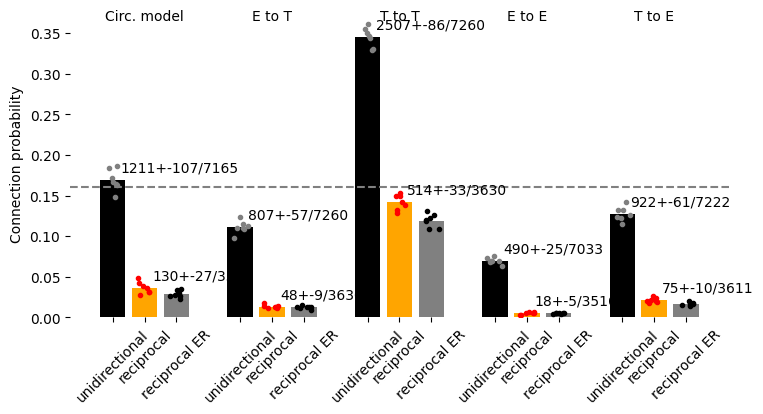

In [16]:
fig = plt.figure(figsize=(1.5 * len(df_Ps) + 1, 4))
i = 1
xticks = []; xticklbls = []; ttls = []
for k, df_P in df_Ps.items():
    ax = fig.gca()

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 0 + i
    y = df_P["connected"].sum() / df_P["sorted_pairs"].sum()
    mn = int(df_P["connected"].mean()); sd = int(df_P["connected"].std()); count = int(df_P["sorted_pairs"].mean())
    ax.bar(i, y, color="black")
    ax.plot(x, df_P["connected"] / df_P["sorted_pairs"], marker='.', color="grey", ls="None")
    ax.text(i + 0.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count))

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 1 + i
    y = df_P["reciprocal_pairs"].sum() / df_P["pairs"].sum()
    mn = int(df_P["reciprocal_pairs"].mean()); sd = int(df_P["reciprocal_pairs"].std()); count = int(df_P["pairs"].mean())
    ax.bar(i + 1, y, color="orange")
    ax.plot(x, df_P["reciprocal_pairs"] / df_P["pairs"], marker='.', color="red", ls="None")
    ax.text(i + 1.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count))

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 2 + i
    y = (df_P["connected"].sum() / df_P["sorted_pairs"].sum()) ** 2
    smpls = df_P["pairs"] * (df_P["connected"] / df_P["sorted_pairs"]) ** 2
    mn = int(smpls.mean()); sd = int(smpls.std())
    ax.bar(i + 2, y, color="grey")
    ax.plot(x, (df_P["connected"] / df_P["sorted_pairs"]) ** 2, marker='.', color="black", ls="None")
    # ax.text(2.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count_b))
    
    xticks.extend([i, i + 1, i + 2])
    xticklbls.extend(["unidirectional", "reciprocal", "reciprocal ER"])
    ttls.append(k)
    i = i + 4

ax.set_xticks(xticks); ax.set_xticklabels(xticklbls, rotation=45)
ax.set_frame_on(False)
ax.set_ylabel("Connection probability")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.16, 0.16], color="grey", ls="--")

ymx = ax.get_ylim()[1]
for _ttl, _x in zip(ttls, xticks[1::3]):
    ax.text(_x, ymx, _ttl, horizontalalignment="center", verticalalignment="top")

### Part IIa: Reciprocal connectivity at different scales

Systematic sampling at different scales. 

In [17]:
szs = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
all_counts = []
all_P = []
for sz_arg in szs:
    campaign_cfg = {
        "mv_cv": [[sz_arg**2, 0], [0, sz_arg**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
        "patch_kwargs": {
            "slice_thickness": sz_arg * 2.5,
            "n_samples": 200, # The number of times the patch sampling procedure will be applied
            "n_patch": 12 # Up to this number of neurons will be sampled together
        }
    }

    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    all_counts.append(counts)
    all_P.append(P)
    
all_counts = pandas.concat(all_counts, axis=0, keys=szs, names=["scale"])
all_P = pandas.concat(all_P, axis=0, keys=szs, names=["scale"])  

  1%|          | 2/200 [00:00<00:30,  6.40it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011377334594726562
Found 55 connected triads
Time spent classifying triads: 0.00512385368347168
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011916160583496094
Found 113 connected triads
Time spent classifying triads: 0.004366159439086914


  2%|▏         | 4/200 [00:00<00:31,  6.20it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009152889251708984
Found 25 connected triads
Time spent classifying triads: 0.002394437789916992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012187957763671875
Found 137 connected triads
Time spent classifying triads: 0.005274534225463867


  3%|▎         | 6/200 [00:00<00:31,  6.18it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012664794921875
Found 134 connected triads
Time spent classifying triads: 0.012310504913330078
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009226799011230469
Found 26 connected triads
Time spent classifying triads: 0.0010993480682373047


  4%|▍         | 8/200 [00:01<00:30,  6.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 2 connected triads
Time spent classifying triads: 0.000286102294921875
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 35 connected triads
Time spent classifying triads: 0.00144195556640625


  5%|▌         | 10/200 [00:01<00:29,  6.36it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011799335479736328
Found 89 connected triads
Time spent classifying triads: 0.008180379867553711
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007722377777099609
Found 7 connected triads
Time spent classifying triads: 0.0003712177276611328


  6%|▌         | 12/200 [00:01<00:30,  6.19it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009942054748535156
Found 40 connected triads
Time spent classifying triads: 0.003757953643798828
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011262893676757812
Found 98 connected triads
Time spent classifying triads: 0.003803730010986328


  7%|▋         | 14/200 [00:02<00:29,  6.23it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 25 connected triads
Time spent classifying triads: 0.002404451370239258
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 50 connected triads
Time spent classifying triads: 0.002001523971557617


  8%|▊         | 16/200 [00:02<00:29,  6.34it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000942230224609375
Found 25 connected triads
Time spent classifying triads: 0.002391338348388672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 134 connected triads
Time spent classifying triads: 0.005162954330444336


  9%|▉         | 18/200 [00:02<00:28,  6.34it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 52 connected triads
Time spent classifying triads: 0.0048542022705078125
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012257099151611328
Found 130 connected triads
Time spent classifying triads: 0.004983186721801758


 10%|█         | 20/200 [00:03<00:28,  6.29it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012736320495605469
Found 128 connected triads
Time spent classifying triads: 0.011765480041503906
Testing 66 potential triadic pairs
Time spent finding triads: 0.001232147216796875
Found 148 connected triads
Time spent classifying triads: 0.00565648078918457


 11%|█         | 22/200 [00:03<00:27,  6.38it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.00099945068359375
Found 33 connected triads
Time spent classifying triads: 0.003134489059448242
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009429454803466797
Found 36 connected triads
Time spent classifying triads: 0.0014672279357910156


 12%|█▏        | 24/200 [00:03<00:27,  6.33it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 27 connected triads
Time spent classifying triads: 0.00257110595703125
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011563301086425781
Found 100 connected triads
Time spent classifying triads: 0.003882884979248047


 13%|█▎        | 26/200 [00:04<00:27,  6.35it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013535022735595703
Found 172 connected triads
Time spent classifying triads: 0.015863656997680664
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012249946594238281
Found 133 connected triads
Time spent classifying triads: 0.005452632904052734


 14%|█▍        | 28/200 [00:04<00:26,  6.52it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010056495666503906
Found 37 connected triads
Time spent classifying triads: 0.003509998321533203
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009081363677978516
Found 32 connected triads
Time spent classifying triads: 0.0013208389282226562


 15%|█▌        | 30/200 [00:04<00:26,  6.40it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012497901916503906
Found 116 connected triads
Time spent classifying triads: 0.00834202766418457
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012059211730957031
Found 114 connected triads
Time spent classifying triads: 0.0043582916259765625


 16%|█▌        | 32/200 [00:05<00:26,  6.46it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011959075927734375
Found 100 connected triads
Time spent classifying triads: 0.009217023849487305
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009634494781494141
Found 38 connected triads
Time spent classifying triads: 0.0015406608581542969


 17%|█▋        | 34/200 [00:05<00:27,  6.06it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 42 connected triads
Time spent classifying triads: 0.003965616226196289
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 11 connected triads
Time spent classifying triads: 0.0005223751068115234


 18%|█▊        | 36/200 [00:05<00:26,  6.26it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010502338409423828
Found 51 connected triads
Time spent classifying triads: 0.004803657531738281
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011377334594726562
Found 101 connected triads
Time spent classifying triads: 0.003914833068847656


 19%|█▉        | 38/200 [00:06<00:25,  6.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012946128845214844
Found 135 connected triads
Time spent classifying triads: 0.012448310852050781
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 59 connected triads
Time spent classifying triads: 0.0023217201232910156


 20%|██        | 40/200 [00:06<00:25,  6.30it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001088857650756836
Found 63 connected triads
Time spent classifying triads: 0.0058746337890625
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010225772857666016
Found 56 connected triads
Time spent classifying triads: 0.0022110939025878906


 21%|██        | 42/200 [00:06<00:24,  6.48it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.001123189926147461
Found 73 connected triads
Time spent classifying triads: 0.006766080856323242
Testing 59 potential triadic pairs
Time spent finding triads: 0.00112152099609375
Found 85 connected triads
Time spent classifying triads: 0.003308534622192383


 22%|██▏       | 44/200 [00:06<00:24,  6.42it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011973381042480469
Found 90 connected triads
Time spent classifying triads: 0.008341550827026367
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008976459503173828
Found 36 connected triads
Time spent classifying triads: 0.00146484375


 23%|██▎       | 46/200 [00:07<00:23,  6.48it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009658336639404297
Found 28 connected triads
Time spent classifying triads: 0.0017299652099609375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012857913970947266
Found 169 connected triads
Time spent classifying triads: 0.006474733352661133


 24%|██▍       | 48/200 [00:07<00:24,  6.26it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 22 connected triads
Time spent classifying triads: 0.002134084701538086
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009176731109619141
Found 28 connected triads
Time spent classifying triads: 0.0011773109436035156


 25%|██▌       | 50/200 [00:07<00:24,  6.20it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 26 connected triads
Time spent classifying triads: 0.001840353012084961
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012302398681640625
Found 133 connected triads
Time spent classifying triads: 0.005080223083496094


 26%|██▌       | 52/200 [00:08<00:23,  6.30it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001234292984008789
Found 114 connected triads
Time spent classifying triads: 0.010526180267333984
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 18 connected triads
Time spent classifying triads: 0.0007984638214111328


 27%|██▋       | 54/200 [00:08<00:22,  6.41it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009961128234863281
Found 35 connected triads
Time spent classifying triads: 0.0020363330841064453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012965202331542969
Found 172 connected triads
Time spent classifying triads: 0.006565570831298828


 28%|██▊       | 56/200 [00:08<00:22,  6.46it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012614727020263672
Found 120 connected triads
Time spent classifying triads: 0.01102757453918457
Testing 66 potential triadic pairs
Time spent finding triads: 0.001226186752319336
Found 125 connected triads
Time spent classifying triads: 0.004846334457397461


 29%|██▉       | 58/200 [00:09<00:21,  6.58it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010113716125488281
Found 39 connected triads
Time spent classifying triads: 0.0036935806274414062
Testing 33 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 47 connected triads
Time spent classifying triads: 0.0018782615661621094


 30%|███       | 60/200 [00:09<00:21,  6.56it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012667179107666016
Found 123 connected triads
Time spent classifying triads: 0.010933637619018555
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 22 connected triads
Time spent classifying triads: 0.0009465217590332031


 31%|███       | 62/200 [00:09<00:22,  6.15it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013735294342041016
Found 189 connected triads
Time spent classifying triads: 0.017318010330200195
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010325908660888672
Found 65 connected triads
Time spent classifying triads: 0.0025420188903808594


 32%|███▏      | 64/200 [00:10<00:21,  6.29it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010657310485839844
Found 55 connected triads
Time spent classifying triads: 0.005058765411376953
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 122 connected triads
Time spent classifying triads: 0.004692792892456055


 33%|███▎      | 66/200 [00:10<00:21,  6.32it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011603832244873047
Found 72 connected triads
Time spent classifying triads: 0.006681680679321289
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 21 connected triads
Time spent classifying triads: 0.0009067058563232422


 34%|███▍      | 68/200 [00:10<00:20,  6.42it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012297630310058594
Found 112 connected triads
Time spent classifying triads: 0.010324239730834961
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011446475982666016
Found 94 connected triads
Time spent classifying triads: 0.003644227981567383


 35%|███▌      | 70/200 [00:11<00:20,  6.29it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010569095611572266
Found 50 connected triads
Time spent classifying triads: 0.004675149917602539
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012278556823730469
Found 142 connected triads
Time spent classifying triads: 0.0054569244384765625


 36%|███▌      | 72/200 [00:11<00:19,  6.42it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011584758758544922
Found 82 connected triads
Time spent classifying triads: 0.007573127746582031
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011749267578125
Found 101 connected triads
Time spent classifying triads: 0.0038907527923583984


 37%|███▋      | 74/200 [00:11<00:19,  6.31it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010914802551269531
Found 55 connected triads
Time spent classifying triads: 0.005138874053955078
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 46 connected triads
Time spent classifying triads: 0.001836538314819336


 38%|███▊      | 76/200 [00:12<00:19,  6.40it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010139942169189453
Found 40 connected triads
Time spent classifying triads: 0.003793478012084961
Testing 66 potential triadic pairs
Time spent finding triads: 0.001268625259399414
Found 150 connected triads
Time spent classifying triads: 0.005734920501708984


 39%|███▉      | 78/200 [00:12<00:19,  6.26it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.001216888427734375
Found 100 connected triads
Time spent classifying triads: 0.009284257888793945
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008978843688964844
Found 33 connected triads
Time spent classifying triads: 0.0013523101806640625


 40%|████      | 80/200 [00:12<00:18,  6.35it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012619495391845703
Found 122 connected triads
Time spent classifying triads: 0.00901651382446289
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011031627655029297
Found 85 connected triads
Time spent classifying triads: 0.0033257007598876953


 41%|████      | 82/200 [00:12<00:19,  6.10it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011866092681884766
Found 89 connected triads
Time spent classifying triads: 0.008251667022705078
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 117 connected triads
Time spent classifying triads: 0.004553794860839844


 42%|████▏     | 84/200 [00:13<00:18,  6.19it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010828971862792969
Found 52 connected triads
Time spent classifying triads: 0.0048885345458984375
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 84 connected triads
Time spent classifying triads: 0.0032651424407958984


 43%|████▎     | 86/200 [00:13<00:18,  6.31it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012133121490478516
Found 109 connected triads
Time spent classifying triads: 0.010056257247924805
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 17 connected triads
Time spent classifying triads: 0.0007605552673339844


 44%|████▍     | 88/200 [00:13<00:18,  6.09it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012657642364501953
Found 123 connected triads
Time spent classifying triads: 0.011375665664672852
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008759498596191406
Found 19 connected triads
Time spent classifying triads: 0.0008318424224853516


 45%|████▌     | 90/200 [00:14<00:18,  6.10it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 9 connected triads
Time spent classifying triads: 0.0009531974792480469
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010197162628173828
Found 55 connected triads
Time spent classifying triads: 0.002208232879638672


 46%|████▌     | 92/200 [00:14<00:17,  6.27it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001310110092163086
Found 142 connected triads
Time spent classifying triads: 0.006907463073730469
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 17 connected triads
Time spent classifying triads: 0.0007421970367431641


 47%|████▋     | 94/200 [00:14<00:16,  6.37it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011260509490966797
Found 67 connected triads
Time spent classifying triads: 0.006229877471923828
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011832714080810547
Found 108 connected triads
Time spent classifying triads: 0.0041790008544921875


 48%|████▊     | 96/200 [00:15<00:16,  6.49it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010106563568115234
Found 41 connected triads
Time spent classifying triads: 0.003861665725708008
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011010169982910156
Found 90 connected triads
Time spent classifying triads: 0.0034942626953125


 49%|████▉     | 98/200 [00:15<00:15,  6.54it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001310586929321289
Found 135 connected triads
Time spent classifying triads: 0.011973857879638672
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 7 connected triads
Time spent classifying triads: 0.0003726482391357422


 50%|█████     | 100/200 [00:15<00:15,  6.59it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010766983032226562
Found 59 connected triads
Time spent classifying triads: 0.005502223968505859
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010199546813964844
Found 64 connected triads
Time spent classifying triads: 0.0025277137756347656


 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 9 connected triads
Time spent classifying triads: 0.0009510517120361328
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010609626770019531
Found 64 connected triads
Time spent classifying triads: 0.002521991729736328


 52%|█████▏    | 104/200 [00:16<00:15,  6.03it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 93 connected triads
Time spent classifying triads: 0.008601188659667969
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012502670288085938
Found 135 connected triads
Time spent classifying triads: 0.0051975250244140625


 53%|█████▎    | 106/200 [00:16<00:15,  6.12it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011188983917236328
Found 71 connected triads
Time spent classifying triads: 0.006582975387573242
Testing 51 potential triadic pairs
Time spent finding triads: 0.00103759765625
Found 51 connected triads
Time spent classifying triads: 0.0020515918731689453


 54%|█████▍    | 108/200 [00:17<00:14,  6.37it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008876323699951172
Found 14 connected triads
Time spent classifying triads: 0.001402139663696289
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012602806091308594
Found 149 connected triads
Time spent classifying triads: 0.0056917667388916016


 55%|█████▌    | 110/200 [00:17<00:14,  6.20it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009663105010986328
Found 33 connected triads
Time spent classifying triads: 0.0031168460845947266
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010731220245361328
Found 67 connected triads
Time spent classifying triads: 0.0026412010192871094


 56%|█████▌    | 112/200 [00:17<00:13,  6.43it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 8 connected triads
Time spent classifying triads: 0.0008549690246582031
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011703968048095703
Found 102 connected triads
Time spent classifying triads: 0.004001140594482422


 57%|█████▋    | 114/200 [00:18<00:14,  6.12it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011780261993408203
Found 74 connected triads
Time spent classifying triads: 0.0036203861236572266
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009560585021972656
Found 45 connected triads
Time spent classifying triads: 0.0017902851104736328


 58%|█████▊    | 116/200 [00:18<00:13,  6.13it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011820793151855469
Found 75 connected triads
Time spent classifying triads: 0.006973743438720703
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010051727294921875
Found 51 connected triads
Time spent classifying triads: 0.002038240432739258


 59%|█████▉    | 118/200 [00:18<00:13,  5.93it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012590885162353516
Found 113 connected triads
Time spent classifying triads: 0.01043558120727539
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012483596801757812
Found 143 connected triads
Time spent classifying triads: 0.00547480583190918


 60%|██████    | 120/200 [00:19<00:13,  5.92it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011429786682128906
Found 67 connected triads
Time spent classifying triads: 0.006236076354980469
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009646415710449219
Found 39 connected triads
Time spent classifying triads: 0.0015957355499267578


 61%|██████    | 122/200 [00:19<00:13,  5.82it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 29 connected triads
Time spent classifying triads: 0.0027670860290527344
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009229183197021484
Found 32 connected triads
Time spent classifying triads: 0.0013098716735839844


 62%|██████▏   | 124/200 [00:19<00:12,  6.11it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012438297271728516
Found 113 connected triads
Time spent classifying triads: 0.010431528091430664
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 32 connected triads
Time spent classifying triads: 0.0013210773468017578


 63%|██████▎   | 126/200 [00:20<00:12,  6.04it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001146078109741211
Found 69 connected triads
Time spent classifying triads: 0.006400585174560547
Testing 55 potential triadic pairs
Time spent finding triads: 0.001079559326171875
Found 78 connected triads
Time spent classifying triads: 0.0030641555786132812


 64%|██████▍   | 128/200 [00:20<00:11,  6.03it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010962486267089844
Found 58 connected triads
Time spent classifying triads: 0.00541234016418457
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012359619140625
Found 139 connected triads
Time spent classifying triads: 0.005353450775146484


 65%|██████▌   | 130/200 [00:20<00:11,  6.13it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012078285217285156
Found 87 connected triads
Time spent classifying triads: 0.00804448127746582
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012264251708984375
Found 137 connected triads
Time spent classifying triads: 0.005256175994873047


 66%|██████▌   | 132/200 [00:21<00:10,  6.31it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012576580047607422
Found 121 connected triads
Time spent classifying triads: 0.01111912727355957
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010428428649902344
Found 73 connected triads
Time spent classifying triads: 0.002856016159057617


 67%|██████▋   | 134/200 [00:21<00:10,  6.23it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012156963348388672
Found 105 connected triads
Time spent classifying triads: 0.009705781936645508
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012059211730957031
Found 126 connected triads
Time spent classifying triads: 0.004843711853027344


 68%|██████▊   | 136/200 [00:21<00:09,  6.44it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009613037109375
Found 34 connected triads
Time spent classifying triads: 0.003214120864868164
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011005401611328125
Found 80 connected triads
Time spent classifying triads: 0.003123044967651367


 69%|██████▉   | 138/200 [00:22<00:09,  6.39it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012481212615966797
Found 107 connected triads
Time spent classifying triads: 0.009796619415283203
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011293888092041016
Found 91 connected triads
Time spent classifying triads: 0.004248857498168945


 70%|███████   | 140/200 [00:22<00:09,  6.57it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001056671142578125
Found 42 connected triads
Time spent classifying triads: 0.0024929046630859375
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009512901306152344
Found 41 connected triads
Time spent classifying triads: 0.0016467571258544922


 71%|███████   | 142/200 [00:22<00:08,  6.49it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012280941009521484
Found 96 connected triads
Time spent classifying triads: 0.008856534957885742
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012874603271484375
Found 160 connected triads
Time spent classifying triads: 0.0060956478118896484


 72%|███████▏  | 144/200 [00:22<00:08,  6.31it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009398460388183594
Found 24 connected triads
Time spent classifying triads: 0.002312898635864258
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011358261108398438
Found 91 connected triads
Time spent classifying triads: 0.003552675247192383


 73%|███████▎  | 146/200 [00:23<00:08,  6.40it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012633800506591797
Found 128 connected triads
Time spent classifying triads: 0.010122299194335938
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010135173797607422
Found 52 connected triads
Time spent classifying triads: 0.002063274383544922


 74%|███████▍  | 148/200 [00:23<00:08,  6.21it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010612010955810547
Found 46 connected triads
Time spent classifying triads: 0.004318714141845703
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 31 connected triads
Time spent classifying triads: 0.001287698745727539


 75%|███████▌  | 150/200 [00:23<00:08,  6.18it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 110 connected triads
Time spent classifying triads: 0.0076177120208740234
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011057853698730469
Found 81 connected triads
Time spent classifying triads: 0.003168821334838867


 76%|███████▌  | 152/200 [00:24<00:07,  6.02it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009999275207519531
Found 35 connected triads
Time spent classifying triads: 0.0033113956451416016
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011525154113769531
Found 104 connected triads
Time spent classifying triads: 0.0040395259857177734


 77%|███████▋  | 154/200 [00:24<00:07,  6.11it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009813308715820312
Found 28 connected triads
Time spent classifying triads: 0.002707242965698242
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012021064758300781
Found 116 connected triads
Time spent classifying triads: 0.004498958587646484


 78%|███████▊  | 156/200 [00:24<00:06,  6.30it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011050701141357422
Found 49 connected triads
Time spent classifying triads: 0.0046007633209228516
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 40 connected triads
Time spent classifying triads: 0.0016140937805175781


 79%|███████▉  | 158/200 [00:25<00:06,  6.29it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 53 connected triads
Time spent classifying triads: 0.0049326419830322266
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011589527130126953
Found 106 connected triads
Time spent classifying triads: 0.004121541976928711


 80%|████████  | 160/200 [00:25<00:06,  6.38it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009317398071289062
Found 23 connected triads
Time spent classifying triads: 0.002232074737548828
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 15 connected triads
Time spent classifying triads: 0.000682830810546875


 81%|████████  | 162/200 [00:25<00:06,  6.27it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012505054473876953
Found 116 connected triads
Time spent classifying triads: 0.010704994201660156
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009067058563232422
Found 32 connected triads
Time spent classifying triads: 0.00131988525390625


 82%|████████▏ | 164/200 [00:26<00:05,  6.14it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010159015655517578
Found 40 connected triads
Time spent classifying triads: 0.003765583038330078
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011680126190185547
Found 105 connected triads
Time spent classifying triads: 0.004078865051269531


 83%|████████▎ | 166/200 [00:26<00:05,  6.35it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001264333724975586
Found 107 connected triads
Time spent classifying triads: 0.004792213439941406
Testing 51 potential triadic pairs
Time spent finding triads: 0.001074075698852539
Found 71 connected triads
Time spent classifying triads: 0.0027904510498046875


 84%|████████▍ | 168/200 [00:26<00:05,  6.28it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012896060943603516
Found 140 connected triads
Time spent classifying triads: 0.012881040573120117
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011522769927978516
Found 104 connected triads
Time spent classifying triads: 0.004014730453491211


 85%|████████▌ | 170/200 [00:27<00:04,  6.01it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 5 connected triads
Time spent classifying triads: 0.0005748271942138672
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 21 connected triads
Time spent classifying triads: 0.0009055137634277344


 86%|████████▌ | 172/200 [00:27<00:04,  6.30it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010895729064941406
Found 53 connected triads
Time spent classifying triads: 0.0049779415130615234
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 30 connected triads
Time spent classifying triads: 0.0012385845184326172


 87%|████████▋ | 174/200 [00:27<00:04,  6.26it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010790824890136719
Found 57 connected triads
Time spent classifying triads: 0.005333900451660156
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009810924530029297
Found 43 connected triads
Time spent classifying triads: 0.0017328262329101562


 88%|████████▊ | 176/200 [00:28<00:03,  6.14it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013074874877929688
Found 147 connected triads
Time spent classifying triads: 0.013531684875488281
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 21 connected triads
Time spent classifying triads: 0.0009067058563232422


 89%|████████▉ | 178/200 [00:28<00:03,  6.05it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011606216430664062
Found 76 connected triads
Time spent classifying triads: 0.007023334503173828
Testing 12 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 12 connected triads
Time spent classifying triads: 0.0005681514739990234


 90%|█████████ | 180/200 [00:28<00:03,  6.24it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009605884552001953
Found 27 connected triads
Time spent classifying triads: 0.0025870800018310547
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 16 connected triads
Time spent classifying triads: 0.0007195472717285156


 91%|█████████ | 182/200 [00:29<00:02,  6.35it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011334419250488281
Found 64 connected triads
Time spent classifying triads: 0.005957365036010742
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010066032409667969
Found 48 connected triads
Time spent classifying triads: 0.0019245147705078125


 92%|█████████▏| 184/200 [00:29<00:02,  6.30it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001241922378540039
Found 113 connected triads
Time spent classifying triads: 0.010432958602905273
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011208057403564453
Found 84 connected triads
Time spent classifying triads: 0.0032758712768554688


 93%|█████████▎| 186/200 [00:29<00:02,  6.47it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001094818115234375
Found 64 connected triads
Time spent classifying triads: 0.0033371448516845703
Testing 52 potential triadic pairs
Time spent finding triads: 0.001054525375366211
Found 54 connected triads
Time spent classifying triads: 0.0021347999572753906


 94%|█████████▍| 188/200 [00:30<00:01,  6.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012874603271484375
Found 134 connected triads
Time spent classifying triads: 0.012361526489257812
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 24 connected triads
Time spent classifying triads: 0.0010082721710205078


 95%|█████████▌| 190/200 [00:30<00:01,  6.26it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010902881622314453
Found 55 connected triads
Time spent classifying triads: 0.002948760986328125
Testing 61 potential triadic pairs
Time spent finding triads: 0.001178741455078125
Found 113 connected triads
Time spent classifying triads: 0.00439906120300293


 96%|█████████▌| 192/200 [00:30<00:01,  6.23it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011217594146728516
Found 63 connected triads
Time spent classifying triads: 0.005887031555175781
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 21 connected triads
Time spent classifying triads: 0.0009210109710693359


 97%|█████████▋| 194/200 [00:30<00:00,  6.40it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 66 connected triads
Time spent classifying triads: 0.006163120269775391
Testing 12 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 12 connected triads
Time spent classifying triads: 0.0005688667297363281


 98%|█████████▊| 196/200 [00:31<00:00,  6.28it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011363029479980469
Found 72 connected triads
Time spent classifying triads: 0.006693840026855469
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009918212890625
Found 42 connected triads
Time spent classifying triads: 0.0016853809356689453


 99%|█████████▉| 198/200 [00:31<00:00,  6.42it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009472370147705078
Found 31 connected triads
Time spent classifying triads: 0.0029518604278564453
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008451938629150391
Found 18 connected triads
Time spent classifying triads: 0.0007860660552978516


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012428760528564453
Found 112 connected triads
Time spent classifying triads: 0.010339021682739258
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007874965667724609
Found 7 connected triads
Time spent classifying triads: 0.0003743171691894531



  1%|          | 2/200 [00:00<00:40,  4.87it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001010894775390625
Found 38 connected triads
Time spent classifying triads: 0.003612518310546875
Testing 12 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 8 connected triads
Time spent classifying triads: 0.0004246234893798828


  2%|▏         | 4/200 [00:00<00:38,  5.08it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012402534484863281
Found 95 connected triads
Time spent classifying triads: 0.008809089660644531
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007169246673583984
Found 0 connected triads
Time spent classifying triads: 7.200241088867188e-05
!


  3%|▎         | 6/200 [00:01<00:38,  5.03it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.001180887222290039
Found 76 connected triads
Time spent classifying triads: 0.007053375244140625
Testing 54 potential triadic pairs
Time spent finding triads: 0.001089334487915039
Found 72 connected triads
Time spent classifying triads: 0.002813100814819336


  4%|▎         | 7/200 [00:01<00:40,  4.71it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0013058185577392578
Found 5 connected triads
Time spent classifying triads: 0.0004889965057373047


  4%|▍         | 8/200 [00:01<00:44,  4.30it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.002012968063354492
Found 80 connected triads
Time spent classifying triads: 0.006003618240356445


  4%|▍         | 9/200 [00:01<00:44,  4.33it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 27 connected triads
Time spent classifying triads: 0.002593517303466797


  6%|▌         | 11/200 [00:02<00:41,  4.59it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 9 connected triads
Time spent classifying triads: 0.000949859619140625
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009098052978515625
Found 33 connected triads
Time spent classifying triads: 0.0013747215270996094


  6%|▌         | 12/200 [00:02<00:39,  4.71it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008983612060546875
Found 15 connected triads
Time spent classifying triads: 0.0015048980712890625


  7%|▋         | 14/200 [00:02<00:38,  4.81it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0012230873107910156
Found 26 connected triads
Time spent classifying triads: 0.002540111541748047
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010578632354736328
Found 55 connected triads
Time spent classifying triads: 0.002180814743041992


  8%|▊         | 15/200 [00:03<00:38,  4.79it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011279582977294922
Found 58 connected triads
Time spent classifying triads: 0.005455970764160156


  8%|▊         | 16/200 [00:03<00:38,  4.75it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 20 connected triads
Time spent classifying triads: 0.0019588470458984375


  8%|▊         | 17/200 [00:03<00:38,  4.77it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0014960765838623047
Found 44 connected triads
Time spent classifying triads: 0.004157543182373047


  9%|▉         | 18/200 [00:03<00:39,  4.60it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011229515075683594
Found 72 connected triads
Time spent classifying triads: 0.006702423095703125


 10%|▉         | 19/200 [00:04<00:39,  4.54it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 2 connected triads
Time spent classifying triads: 0.00029277801513671875


 10%|█         | 21/200 [00:04<00:38,  4.69it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001209259033203125
Found 83 connected triads
Time spent classifying triads: 0.0077190399169921875
Testing 40 potential triadic pairs
Time spent finding triads: 0.001008749008178711
Found 45 connected triads
Time spent classifying triads: 0.0017981529235839844


 11%|█         | 22/200 [00:04<00:38,  4.57it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012555122375488281
Found 112 connected triads
Time spent classifying triads: 0.010375022888183594
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 16 connected triads
Time spent classifying triads: 0.0007047653198242188


 12%|█▎        | 25/200 [00:05<00:35,  4.93it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 92 connected triads
Time spent classifying triads: 0.008484363555908203
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008974075317382812
Found 23 connected triads
Time spent classifying triads: 0.0009779930114746094


 13%|█▎        | 26/200 [00:05<00:35,  4.85it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001293182373046875
Found 132 connected triads
Time spent classifying triads: 0.012202262878417969


 14%|█▎        | 27/200 [00:05<00:36,  4.74it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 14%|█▍        | 28/200 [00:05<00:36,  4.66it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001100778579711914
Found 58 connected triads
Time spent classifying triads: 0.005409717559814453


 15%|█▌        | 30/200 [00:06<00:35,  4.83it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 17 connected triads
Time spent classifying triads: 0.0016736984252929688
Testing 66 potential triadic pairs
Time spent finding triads: 0.00118255615234375
Found 99 connected triads
Time spent classifying triads: 0.003836393356323242


 16%|█▌        | 32/200 [00:06<00:34,  4.83it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012662410736083984
Found 107 connected triads
Time spent classifying triads: 0.009847402572631836
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007755756378173828
Found 6 connected triads
Time spent classifying triads: 0.000335693359375


 16%|█▋        | 33/200 [00:07<00:35,  4.73it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 28 connected triads
Time spent classifying triads: 0.0026717185974121094


 17%|█▋        | 34/200 [00:07<00:35,  4.65it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008709430694580078
Found 13 connected triads
Time spent classifying triads: 0.0013265609741210938


 18%|█▊        | 36/200 [00:07<00:34,  4.76it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011134147644042969
Found 61 connected triads
Time spent classifying triads: 0.0056705474853515625
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009996891021728516
Found 47 connected triads
Time spent classifying triads: 0.0018503665924072266


 19%|█▉        | 38/200 [00:08<00:32,  4.91it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012614727020263672
Found 112 connected triads
Time spent classifying triads: 0.010322332382202148
Testing 54 potential triadic pairs
Time spent finding triads: 0.001081705093383789
Found 69 connected triads
Time spent classifying triads: 0.0026776790618896484


 20%|██        | 40/200 [00:08<00:32,  4.94it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 5 connected triads
Time spent classifying triads: 0.000583648681640625
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008723735809326172
Found 17 connected triads
Time spent classifying triads: 0.0007631778717041016


 21%|██        | 42/200 [00:08<00:32,  4.93it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 61 connected triads
Time spent classifying triads: 0.0056819915771484375
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007524490356445312
Found 2 connected triads
Time spent classifying triads: 0.0001811981201171875


 22%|██▏       | 44/200 [00:09<00:31,  4.91it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012078285217285156
Found 82 connected triads
Time spent classifying triads: 0.007592916488647461
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010180473327636719
Found 49 connected triads
Time spent classifying triads: 0.0019505023956298828


 23%|██▎       | 46/200 [00:09<00:30,  4.98it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009570121765136719
Found 21 connected triads
Time spent classifying triads: 0.002048015594482422
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 22 connected triads
Time spent classifying triads: 0.0009434223175048828


 24%|██▎       | 47/200 [00:09<00:30,  5.02it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010914802551269531
Found 44 connected triads
Time spent classifying triads: 0.004153013229370117


 24%|██▍       | 48/200 [00:10<00:31,  4.85it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011739730834960938
Found 81 connected triads
Time spent classifying triads: 0.004393100738525391


 25%|██▌       | 50/200 [00:10<00:30,  4.95it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 37 connected triads
Time spent classifying triads: 0.0035207271575927734
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009872913360595703
Found 48 connected triads
Time spent classifying triads: 0.0019087791442871094


 26%|██▌       | 51/200 [00:10<00:29,  5.01it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 30 connected triads
Time spent classifying triads: 0.002868175506591797


 26%|██▋       | 53/200 [00:11<00:29,  4.93it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011382102966308594
Found 67 connected triads
Time spent classifying triads: 0.006269931793212891
Testing 55 potential triadic pairs
Time spent finding triads: 0.001104116439819336
Found 75 connected triads
Time spent classifying triads: 0.002919435501098633


 27%|██▋       | 54/200 [00:11<00:29,  5.00it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012426376342773438
Found 117 connected triads
Time spent classifying triads: 0.006580352783203125


 28%|██▊       | 55/200 [00:11<00:30,  4.79it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 9 connected triads
Time spent classifying triads: 0.0009424686431884766


 28%|██▊       | 56/200 [00:11<00:30,  4.77it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0018155574798583984
Found 111 connected triads
Time spent classifying triads: 0.005466938018798828


 28%|██▊       | 57/200 [00:11<00:29,  4.81it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0013415813446044922
Found 8 connected triads
Time spent classifying triads: 0.0007107257843017578


 30%|██▉       | 59/200 [00:12<00:29,  4.84it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012140274047851562
Found 92 connected triads
Time spent classifying triads: 0.008511543273925781
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 75 connected triads
Time spent classifying triads: 0.0029201507568359375


 30%|███       | 60/200 [00:12<00:28,  4.85it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 68 connected triads
Time spent classifying triads: 0.0063784122467041016


 30%|███       | 61/200 [00:12<00:28,  4.82it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0017657279968261719
Found 30 connected triads
Time spent classifying triads: 0.002800464630126953


 32%|███▏      | 63/200 [00:13<00:28,  4.87it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008740425109863281
Found 12 connected triads
Time spent classifying triads: 0.0012359619140625
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009567737579345703
Found 37 connected triads
Time spent classifying triads: 0.001508951187133789


 32%|███▎      | 65/200 [00:13<00:27,  5.00it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001239776611328125
Found 102 connected triads
Time spent classifying triads: 0.009482383728027344
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009241104125976562
Found 35 connected triads
Time spent classifying triads: 0.0014371871948242188


 34%|███▎      | 67/200 [00:14<00:27,  4.91it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011138916015625
Found 58 connected triads
Time spent classifying triads: 0.003104686737060547
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 24 connected triads
Time spent classifying triads: 0.00101470947265625


 34%|███▍      | 69/200 [00:14<00:26,  4.88it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008828639984130859
Found 11 connected triads
Time spent classifying triads: 0.0011281967163085938
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010788440704345703
Found 64 connected triads
Time spent classifying triads: 0.0025234222412109375


 35%|███▌      | 70/200 [00:14<00:27,  4.78it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 8 connected triads
Time spent classifying triads: 0.0008568763732910156


 36%|███▌      | 71/200 [00:14<00:28,  4.60it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011568069458007812
Found 83 connected triads
Time spent classifying triads: 0.007716178894042969


 36%|███▌      | 72/200 [00:15<00:27,  4.64it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0013911724090576172
Found 32 connected triads
Time spent classifying triads: 0.002631664276123047


 36%|███▋      | 73/200 [00:15<00:27,  4.69it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.001405477523803711
Found 22 connected triads
Time spent classifying triads: 0.0021224021911621094
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011072158813476562
Found 73 connected triads


 37%|███▋      | 74/200 [00:15<00:26,  4.72it/s]

Time spent classifying triads: 0.004526853561401367


 38%|███▊      | 76/200 [00:15<00:25,  4.86it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0017986297607421875
Found 73 connected triads
Time spent classifying triads: 0.006804943084716797
Testing 44 potential triadic pairs
Time spent finding triads: 0.001018524169921875
Found 55 connected triads
Time spent classifying triads: 0.002201080322265625


 38%|███▊      | 77/200 [00:16<00:24,  4.97it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 5 connected triads
Time spent classifying triads: 0.0005819797515869141


 40%|███▉      | 79/200 [00:16<00:24,  5.00it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0016622543334960938
Found 35 connected triads
Time spent classifying triads: 0.002649068832397461
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009834766387939453
Found 45 connected triads
Time spent classifying triads: 0.001794576644897461


 40%|████      | 81/200 [00:16<00:24,  4.90it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012536048889160156
Found 97 connected triads
Time spent classifying triads: 0.008979558944702148
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 72 connected triads
Time spent classifying triads: 0.0027980804443359375


 42%|████▏     | 83/200 [00:17<00:23,  5.00it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 16 connected triads
Time spent classifying triads: 0.0016014575958251953
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009338855743408203
Found 32 connected triads
Time spent classifying triads: 0.0013327598571777344


 42%|████▎     | 85/200 [00:17<00:22,  5.13it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 26 connected triads
Time spent classifying triads: 0.002500295639038086
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 17 connected triads
Time spent classifying triads: 0.0007586479187011719


 43%|████▎     | 86/200 [00:17<00:22,  5.06it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009324550628662109
Found 19 connected triads
Time spent classifying triads: 0.0018734931945800781


 44%|████▎     | 87/200 [00:18<00:23,  4.90it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008854866027832031
Found 19 connected triads
Time spent classifying triads: 0.001859903335571289
Testing 58 potential triadic pairs
Time spent finding triads: 0.001123666763305664
Found 80 connected triads
Time spent classifying triads: 0.0031023025512695312


 44%|████▍     | 89/200 [00:18<00:22,  4.90it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009298324584960938
Found 23 connected triads
Time spent classifying triads: 0.002213716506958008


 46%|████▌     | 91/200 [00:18<00:22,  4.94it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012631416320800781
Found 118 connected triads
Time spent classifying triads: 0.0057849884033203125
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 52 connected triads
Time spent classifying triads: 0.0020570755004882812


 46%|████▌     | 92/200 [00:19<00:21,  4.97it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010385513305664062
Found 37 connected triads
Time spent classifying triads: 0.0035011768341064453


 47%|████▋     | 94/200 [00:19<00:21,  4.91it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009591579437255859
Found 28 connected triads
Time spent classifying triads: 0.0026814937591552734
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010845661163330078
Found 68 connected triads
Time spent classifying triads: 0.0026712417602539062


 48%|████▊     | 96/200 [00:19<00:21,  4.95it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011544227600097656
Found 63 connected triads
Time spent classifying triads: 0.005885124206542969
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007197856903076172
Found 0 connected triads
Time spent classifying triads: 7.224082946777344e-05
!


 48%|████▊     | 97/200 [00:20<00:20,  5.00it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010766983032226562
Found 50 connected triads
Time spent classifying triads: 0.00469517707824707


 50%|████▉     | 99/200 [00:20<00:20,  5.01it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0017397403717041016
Found 57 connected triads
Time spent classifying triads: 0.00530242919921875
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010027885437011719
Found 43 connected triads
Time spent classifying triads: 0.001708984375


 50%|█████     | 100/200 [00:20<00:20,  4.80it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 58 connected triads
Time spent classifying triads: 0.005447864532470703


 50%|█████     | 101/200 [00:21<00:20,  4.74it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010979175567626953
Found 56 connected triads
Time spent classifying triads: 0.003084421157836914


 51%|█████     | 102/200 [00:21<00:20,  4.68it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 3 connected triads
Time spent classifying triads: 0.0003917217254638672


 52%|█████▏    | 104/200 [00:21<00:19,  4.81it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011601448059082031
Found 76 connected triads
Time spent classifying triads: 0.007102489471435547
Testing 50 potential triadic pairs
Time spent finding triads: 0.001077890396118164
Found 73 connected triads
Time spent classifying triads: 0.0028548240661621094


 52%|█████▎    | 105/200 [00:21<00:20,  4.71it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010600090026855469
Found 43 connected triads
Time spent classifying triads: 0.0040607452392578125


 53%|█████▎    | 106/200 [00:22<00:20,  4.66it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 11 connected triads
Time spent classifying triads: 0.0011317729949951172


 54%|█████▎    | 107/200 [00:22<00:20,  4.56it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011446475982666016
Found 70 connected triads
Time spent classifying triads: 0.006530284881591797


 54%|█████▍    | 108/200 [00:22<00:20,  4.58it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001005411148071289
Found 42 connected triads
Time spent classifying triads: 0.003945827484130859


 55%|█████▍    | 109/200 [00:22<00:19,  4.59it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 16 connected triads
Time spent classifying triads: 0.0015811920166015625


 55%|█████▌    | 110/200 [00:22<00:19,  4.59it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011227130889892578
Found 62 connected triads
Time spent classifying triads: 0.005798816680908203


 56%|█████▌    | 112/200 [00:23<00:18,  4.74it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009753704071044922
Found 25 connected triads
Time spent classifying triads: 0.0024290084838867188
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 65 connected triads
Time spent classifying triads: 0.002548694610595703


 56%|█████▋    | 113/200 [00:23<00:18,  4.81it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011782646179199219
Found 72 connected triads
Time spent classifying triads: 0.006742000579833984


 57%|█████▋    | 114/200 [00:23<00:18,  4.74it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001027822494506836
Found 40 connected triads
Time spent classifying triads: 0.0037894248962402344


 58%|█████▊    | 116/200 [00:24<00:17,  4.84it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012166500091552734
Found 99 connected triads
Time spent classifying triads: 0.007832765579223633
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 14 connected triads
Time spent classifying triads: 0.0006318092346191406


 58%|█████▊    | 117/200 [00:24<00:17,  4.84it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012249946594238281
Found 93 connected triads
Time spent classifying triads: 0.008670330047607422


 59%|█████▉    | 118/200 [00:24<00:17,  4.73it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001026153564453125
Found 35 connected triads
Time spent classifying triads: 0.0033447742462158203
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007526874542236328
Found 4 connected triads
Time spent classifying triads: 0.00026679039001464844


 60%|██████    | 120/200 [00:25<00:16,  4.89it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011942386627197266
Found 88 connected triads
Time spent classifying triads: 0.0046176910400390625
Testing 39 potential triadic pairs
Time spent finding triads: 0.0011029243469238281
Found 38 connected triads
Time spent classifying triads: 0.003614187240600586


 61%|██████    | 122/200 [00:25<00:16,  4.79it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007889270782470703
Found 0 connected triads
Time spent classifying triads: 7.700920104980469e-05
!


 62%|██████▏   | 124/200 [00:25<00:15,  4.86it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.001621246337890625
Found 34 connected triads
Time spent classifying triads: 0.0028607845306396484
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 18 connected triads
Time spent classifying triads: 0.0007960796356201172


 62%|██████▎   | 125/200 [00:26<00:15,  4.80it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0013606548309326172
Found 89 connected triads
Time spent classifying triads: 0.008290767669677734
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 15 connected triads
Time spent classifying triads: 0.0013585090637207031


 64%|██████▍   | 128/200 [00:26<00:14,  4.96it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0012001991271972656
Found 83 connected triads
Time spent classifying triads: 0.007714748382568359
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 51 connected triads
Time spent classifying triads: 0.0020444393157958984


 65%|██████▌   | 130/200 [00:27<00:13,  5.06it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0011172294616699219
Found 58 connected triads
Time spent classifying triads: 0.005429744720458984
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 9 connected triads
Time spent classifying triads: 0.0004611015319824219


 66%|██████▌   | 132/200 [00:27<00:13,  5.02it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0012211799621582031
Found 104 connected triads
Time spent classifying triads: 0.009646177291870117
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010194778442382812
Found 64 connected triads
Time spent classifying triads: 0.0025255680084228516


 67%|██████▋   | 134/200 [00:27<00:13,  5.06it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000997304916381836
Found 29 connected triads
Time spent classifying triads: 0.0027914047241210938
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 16 connected triads
Time spent classifying triads: 0.0007119178771972656


 68%|██████▊   | 135/200 [00:28<00:13,  4.88it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010552406311035156
Found 42 connected triads
Time spent classifying triads: 0.003982067108154297


 68%|██████▊   | 136/200 [00:28<00:13,  4.77it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 7 connected triads
Time spent classifying triads: 0.0007665157318115234


 68%|██████▊   | 137/200 [00:28<00:13,  4.66it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011150836944580078
Found 56 connected triads
Time spent classifying triads: 0.0052759647369384766


 70%|██████▉   | 139/200 [00:28<00:12,  4.83it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0017118453979492188
Found 78 connected triads
Time spent classifying triads: 0.004473686218261719
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 15 connected triads
Time spent classifying triads: 0.0006852149963378906


 70%|███████   | 140/200 [00:29<00:12,  4.96it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 4 connected triads
Time spent classifying triads: 0.0004892349243164062


 70%|███████   | 141/200 [00:29<00:12,  4.87it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001623392105102539
Found 41 connected triads
Time spent classifying triads: 0.0036461353302001953


 71%|███████   | 142/200 [00:29<00:12,  4.72it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009591579437255859
Found 22 connected triads
Time spent classifying triads: 0.002150297164916992


 72%|███████▏  | 143/200 [00:29<00:12,  4.70it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.002110004425048828
Found 76 connected triads
Time spent classifying triads: 0.0036122798919677734
Testing 63 potential triadic pairs
Time spent finding triads: 0.001173257827758789
Found 94 connected triads
Time spent classifying triads: 0.0036439895629882812


 73%|███████▎  | 146/200 [00:30<00:11,  4.80it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008742809295654297
Found 14 connected triads
Time spent classifying triads: 0.00139617919921875
Testing 38 potential triadic pairs
Time spent finding triads: 0.000997781753540039
Found 52 connected triads
Time spent classifying triads: 0.0020813941955566406


 74%|███████▍  | 148/200 [00:30<00:10,  4.92it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012433528900146484
Found 110 connected triads
Time spent classifying triads: 0.010195016860961914
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010344982147216797
Found 64 connected triads
Time spent classifying triads: 0.0025124549865722656


 74%|███████▍  | 149/200 [00:30<00:10,  5.01it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009334087371826172
Found 22 connected triads
Time spent classifying triads: 0.0021517276763916016


 75%|███████▌  | 150/200 [00:31<00:10,  4.95it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0015180110931396484
Found 3 connected triads
Time spent classifying triads: 0.0003609657287597656


 76%|███████▌  | 151/200 [00:31<00:10,  4.81it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 16 connected triads
Time spent classifying triads: 0.0015826225280761719


 76%|███████▌  | 152/200 [00:31<00:10,  4.75it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0017766952514648438
Found 95 connected triads
Time spent classifying triads: 0.008536815643310547


 76%|███████▋  | 153/200 [00:31<00:09,  4.72it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009129047393798828
Found 19 connected triads
Time spent classifying triads: 0.0018634796142578125


 78%|███████▊  | 155/200 [00:32<00:09,  4.90it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0014667510986328125
Found 12 connected triads
Time spent classifying triads: 0.0012357234954833984
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009086132049560547
Found 36 connected triads
Time spent classifying triads: 0.0014646053314208984


 78%|███████▊  | 157/200 [00:32<00:08,  5.04it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009405612945556641
Found 24 connected triads
Time spent classifying triads: 0.002336740493774414
Testing 4 potential triadic pairs
Time spent finding triads: 0.00077056884765625
Found 4 connected triads
Time spent classifying triads: 0.0002627372741699219


 79%|███████▉  | 158/200 [00:32<00:08,  4.99it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 17 connected triads
Time spent classifying triads: 0.0016968250274658203


 80%|███████▉  | 159/200 [00:33<00:08,  4.85it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 37 connected triads
Time spent classifying triads: 0.003525972366333008


 80%|████████  | 160/200 [00:33<00:08,  4.72it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001125335693359375
Found 63 connected triads
Time spent classifying triads: 0.005894899368286133
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 8 connected triads
Time spent classifying triads: 0.0004239082336425781


 82%|████████▏ | 163/200 [00:33<00:07,  5.01it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011887550354003906
Found 71 connected triads
Time spent classifying triads: 0.006607532501220703
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009739398956298828
Found 42 connected triads
Time spent classifying triads: 0.0016880035400390625


 82%|████████▎ | 165/200 [00:34<00:06,  5.07it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 77 connected triads
Time spent classifying triads: 0.00717926025390625
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011289119720458984
Found 78 connected triads
Time spent classifying triads: 0.0030736923217773438


 84%|████████▎ | 167/200 [00:34<00:06,  5.04it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010333061218261719
Found 39 connected triads
Time spent classifying triads: 0.0037343502044677734
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011866092681884766
Found 108 connected triads
Time spent classifying triads: 0.004187345504760742


 84%|████████▍ | 168/200 [00:34<00:06,  5.08it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009822845458984375
Found 27 connected triads
Time spent classifying triads: 0.002596139907836914


 84%|████████▍ | 169/200 [00:35<00:06,  4.81it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001102447509765625
Found 61 connected triads
Time spent classifying triads: 0.005722522735595703
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007636547088623047
Found 6 connected triads
Time spent classifying triads: 0.0003464221954345703


 86%|████████▌ | 172/200 [00:35<00:05,  5.01it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012238025665283203
Found 79 connected triads
Time spent classifying triads: 0.00732111930847168
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009472370147705078
Found 35 connected triads
Time spent classifying triads: 0.001434326171875


 86%|████████▋ | 173/200 [00:35<00:05,  4.86it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001077413558959961
Found 52 connected triads
Time spent classifying triads: 0.004874229431152344


 87%|████████▋ | 174/200 [00:36<00:05,  4.71it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009799003601074219
Found 39 connected triads
Time spent classifying triads: 0.0036787986755371094


 88%|████████▊ | 175/200 [00:36<00:05,  4.67it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 51 connected triads
Time spent classifying triads: 0.004769086837768555


 88%|████████▊ | 177/200 [00:36<00:04,  4.89it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.00146484375
Found 6 connected triads
Time spent classifying triads: 0.0006804466247558594
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 10 connected triads
Time spent classifying triads: 0.0004870891571044922


 89%|████████▉ | 178/200 [00:36<00:04,  4.94it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 29 connected triads
Time spent classifying triads: 0.0027823448181152344


 90%|████████▉ | 179/200 [00:37<00:04,  4.86it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 18 connected triads
Time spent classifying triads: 0.0017685890197753906


 90%|█████████ | 181/200 [00:37<00:03,  4.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 2 connected triads
Time spent classifying triads: 0.000293731689453125
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 19 connected triads
Time spent classifying triads: 0.0008218288421630859


 91%|█████████ | 182/200 [00:37<00:03,  4.95it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001123666763305664
Found 62 connected triads
Time spent classifying triads: 0.005780696868896484
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010461807250976562
Found 65 connected triads
Time spent classifying triads: 0.005532026290893555


 92%|█████████▏| 184/200 [00:38<00:03,  4.96it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009911060333251953
Found 29 connected triads
Time spent classifying triads: 0.0027756690979003906


 93%|█████████▎| 186/200 [00:38<00:02,  4.92it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 16 connected triads
Time spent classifying triads: 0.0010728836059570312
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011317729949951172
Found 92 connected triads
Time spent classifying triads: 0.0035648345947265625


 94%|█████████▍| 188/200 [00:38<00:02,  5.09it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 27 connected triads
Time spent classifying triads: 0.002606630325317383
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009915828704833984
Found 41 connected triads
Time spent classifying triads: 0.0016641616821289062


 94%|█████████▍| 189/200 [00:39<00:02,  4.95it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 10 connected triads
Time spent classifying triads: 0.0010366439819335938


 95%|█████████▌| 190/200 [00:39<00:02,  4.84it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008876323699951172
Found 23 connected triads
Time spent classifying triads: 0.0022246837615966797


 96%|█████████▌| 191/200 [00:39<00:01,  4.67it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012493133544921875
Found 118 connected triads
Time spent classifying triads: 0.010921001434326172
Testing 59 potential triadic pairs
Time spent finding triads: 0.001131296157836914
Found 82 connected triads
Time spent classifying triads: 0.003357410430908203


 97%|█████████▋| 194/200 [00:40<00:01,  4.91it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001153707504272461
Found 73 connected triads
Time spent classifying triads: 0.00651240348815918
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 22 connected triads
Time spent classifying triads: 0.0009565353393554688


 98%|█████████▊| 195/200 [00:40<00:01,  4.94it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 4 connected triads
Time spent classifying triads: 0.0004899501800537109


 98%|█████████▊| 197/200 [00:40<00:00,  4.94it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012354850769042969
Found 107 connected triads
Time spent classifying triads: 0.0051250457763671875
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007605552673339844
Found 3 connected triads
Time spent classifying triads: 0.00022649765014648438


100%|█████████▉| 199/200 [00:41<00:00,  5.06it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009489059448242188
Found 20 connected triads
Time spent classifying triads: 0.0019502639770507812
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011167526245117188
Found 75 connected triads
Time spent classifying triads: 0.002948760986328125


100%|██████████| 200/200 [00:41<00:00,  4.83it/s]


Testing 58 potential triadic pairs
Time spent finding triads: 0.0011980533599853516
Found 81 connected triads
Time spent classifying triads: 0.007535219192504883


  0%|          | 1/200 [00:00<00:49,  4.04it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011327266693115234
Found 64 connected triads
Time spent classifying triads: 0.0059697628021240234


  1%|          | 2/200 [00:00<00:50,  3.91it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 20 connected triads
Time spent classifying triads: 0.0019516944885253906


  2%|▏         | 3/200 [00:00<00:48,  4.05it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010521411895751953
Found 48 connected triads
Time spent classifying triads: 0.0044934749603271484


  2%|▏         | 4/200 [00:01<00:49,  3.99it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 12 connected triads
Time spent classifying triads: 0.0012233257293701172


  2%|▎         | 5/200 [00:01<00:48,  4.03it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008871555328369141
Found 11 connected triads
Time spent classifying triads: 0.0011448860168457031


  3%|▎         | 6/200 [00:01<00:46,  4.15it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 25 connected triads
Time spent classifying triads: 0.0024213790893554688


  4%|▎         | 7/200 [00:01<00:46,  4.16it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009334087371826172
Found 26 connected triads
Time spent classifying triads: 0.0024983882904052734


  4%|▍         | 8/200 [00:01<00:46,  4.10it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012362003326416016
Found 107 connected triads
Time spent classifying triads: 0.009943246841430664


  4%|▍         | 9/200 [00:02<00:45,  4.18it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 13 connected triads
Time spent classifying triads: 0.001312255859375


  5%|▌         | 10/200 [00:02<00:47,  4.01it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009763240814208984
Found 28 connected triads
Time spent classifying triads: 0.002681255340576172


  6%|▌         | 11/200 [00:02<00:48,  3.87it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 9 connected triads
Time spent classifying triads: 0.0009517669677734375


  6%|▌         | 12/200 [00:02<00:47,  3.98it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 21 connected triads
Time spent classifying triads: 0.0020685195922851562


  6%|▋         | 13/200 [00:03<00:45,  4.10it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 5 connected triads
Time spent classifying triads: 0.0005784034729003906


  7%|▋         | 14/200 [00:03<00:45,  4.09it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 30 connected triads
Time spent classifying triads: 0.00286102294921875


  8%|▊         | 15/200 [00:03<00:46,  3.96it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010104179382324219
Found 34 connected triads
Time spent classifying triads: 0.0025331974029541016


  8%|▊         | 16/200 [00:04<00:47,  3.84it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010704994201660156
Found 42 connected triads
Time spent classifying triads: 0.003976345062255859


  8%|▊         | 17/200 [00:04<00:46,  3.96it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 25 connected triads
Time spent classifying triads: 0.0024356842041015625


  9%|▉         | 18/200 [00:04<00:45,  4.04it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008759498596191406
Found 11 connected triads
Time spent classifying triads: 0.0011374950408935547


 10%|▉         | 19/200 [00:04<00:45,  4.02it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010442733764648438
Found 47 connected triads
Time spent classifying triads: 0.0044307708740234375


 10%|█         | 20/200 [00:04<00:44,  4.07it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 10%|█         | 21/200 [00:05<00:45,  3.92it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010485649108886719
Found 35 connected triads
Time spent classifying triads: 0.0033299922943115234


 11%|█         | 22/200 [00:05<00:46,  3.82it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 10 connected triads
Time spent classifying triads: 0.0010464191436767578


 12%|█▏        | 23/200 [00:05<00:44,  4.01it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010802745819091797
Found 48 connected triads
Time spent classifying triads: 0.004530906677246094


 12%|█▏        | 24/200 [00:05<00:41,  4.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007839202880859375
Found 0 connected triads
Time spent classifying triads: 8.034706115722656e-05
!


 12%|█▎        | 25/200 [00:06<00:41,  4.24it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010886192321777344
Found 51 connected triads
Time spent classifying triads: 0.0047969818115234375


 13%|█▎        | 26/200 [00:06<00:40,  4.34it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 5 connected triads
Time spent classifying triads: 0.000576019287109375


 14%|█▎        | 27/200 [00:06<00:42,  4.09it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 11 connected triads
Time spent classifying triads: 0.0011429786682128906


 14%|█▍        | 28/200 [00:06<00:40,  4.22it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 10 connected triads
Time spent classifying triads: 0.0010418891906738281


 14%|█▍        | 29/200 [00:07<00:40,  4.21it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 26 connected triads
Time spent classifying triads: 0.0025217533111572266


 15%|█▌        | 30/200 [00:07<00:39,  4.31it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009467601776123047
Found 24 connected triads
Time spent classifying triads: 0.0016388893127441406


 16%|█▌        | 31/200 [00:07<00:41,  4.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 4 connected triads
Time spent classifying triads: 0.0004913806915283203


 16%|█▌        | 32/200 [00:07<00:40,  4.19it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 45 connected triads
Time spent classifying triads: 0.0026786327362060547


 16%|█▋        | 33/200 [00:08<00:41,  4.00it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 12 connected triads
Time spent classifying triads: 0.0012249946594238281


 17%|█▋        | 34/200 [00:08<00:40,  4.14it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 21 connected triads
Time spent classifying triads: 0.002061128616333008


 18%|█▊        | 35/200 [00:08<00:38,  4.26it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 6 connected triads
Time spent classifying triads: 0.0006837844848632812


 18%|█▊        | 36/200 [00:08<00:40,  4.04it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010592937469482422
Found 46 connected triads
Time spent classifying triads: 0.0043451786041259766


 18%|█▊        | 37/200 [00:09<00:38,  4.18it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011436939239501953
Found 70 connected triads
Time spent classifying triads: 0.0033578872680664062


 19%|█▉        | 38/200 [00:09<00:37,  4.30it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009593963623046875
Found 26 connected triads
Time spent classifying triads: 0.0025222301483154297


 20%|█▉        | 39/200 [00:09<00:39,  4.06it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 1 connected triads
Time spent classifying triads: 0.00019288063049316406


 20%|██        | 40/200 [00:09<00:38,  4.15it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009622573852539062
Found 23 connected triads
Time spent classifying triads: 0.002227306365966797


 20%|██        | 41/200 [00:10<00:37,  4.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 21%|██        | 42/200 [00:10<00:37,  4.23it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010304450988769531
Found 38 connected triads
Time spent classifying triads: 0.0035181045532226562


 22%|██▏       | 43/200 [00:10<00:37,  4.18it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 13 connected triads
Time spent classifying triads: 0.0013089179992675781


 22%|██▏       | 44/200 [00:10<00:37,  4.14it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011067390441894531
Found 55 connected triads
Time spent classifying triads: 0.005163431167602539


 22%|██▎       | 45/200 [00:10<00:36,  4.24it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001089334487915039
Found 51 connected triads
Time spent classifying triads: 0.004824399948120117


 23%|██▎       | 46/200 [00:11<00:36,  4.20it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008709430694580078
Found 17 connected triads
Time spent classifying triads: 0.0016734600067138672


 24%|██▎       | 47/200 [00:11<00:36,  4.16it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 12 connected triads
Time spent classifying triads: 0.0012156963348388672


 24%|██▍       | 48/200 [00:11<00:36,  4.13it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.00101470947265625
Found 31 connected triads
Time spent classifying triads: 0.002946138381958008


 24%|██▍       | 49/200 [00:11<00:38,  3.95it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 9 connected triads
Time spent classifying triads: 0.0009441375732421875


 25%|██▌       | 50/200 [00:12<00:38,  3.91it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011258125305175781
Found 63 connected triads
Time spent classifying triads: 0.005884885787963867


 26%|██▌       | 51/200 [00:12<00:37,  3.98it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 6 connected triads
Time spent classifying triads: 0.0006771087646484375


 26%|██▌       | 52/200 [00:12<00:35,  4.15it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009298324584960938
Found 21 connected triads
Time spent classifying triads: 0.0020482540130615234


 26%|██▋       | 53/200 [00:12<00:34,  4.23it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 6 connected triads
Time spent classifying triads: 0.00067901611328125


 27%|██▋       | 54/200 [00:13<00:36,  4.04it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010700225830078125
Found 53 connected triads
Time spent classifying triads: 0.002790689468383789


 28%|██▊       | 55/200 [00:13<00:37,  3.91it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 7 connected triads
Time spent classifying triads: 0.0007677078247070312


 28%|██▊       | 56/200 [00:13<00:36,  3.96it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 10 connected triads
Time spent classifying triads: 0.0010733604431152344


 28%|██▊       | 57/200 [00:13<00:35,  4.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 4 connected triads
Time spent classifying triads: 0.0004889965057373047


 29%|██▉       | 58/200 [00:14<00:36,  3.91it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 0 connected triads
Time spent classifying triads: 7.62939453125e-05
!


 30%|██▉       | 59/200 [00:14<00:34,  4.06it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 11 connected triads
Time spent classifying triads: 0.001140594482421875


 30%|███       | 60/200 [00:14<00:33,  4.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 1 connected triads
Time spent classifying triads: 0.00019240379333496094


 30%|███       | 61/200 [00:14<00:34,  3.98it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 27 connected triads
Time spent classifying triads: 0.002591371536254883


 31%|███       | 62/200 [00:15<00:35,  3.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 3 connected triads
Time spent classifying triads: 0.00040221214294433594


 32%|███▏      | 63/200 [00:15<00:34,  3.95it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.001191854476928711
Found 81 connected triads
Time spent classifying triads: 0.007561445236206055


 32%|███▏      | 64/200 [00:15<00:33,  4.01it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 3 connected triads
Time spent classifying triads: 0.00039505958557128906


 32%|███▎      | 65/200 [00:15<00:33,  4.03it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 7 connected triads
Time spent classifying triads: 0.0007650852203369141


 33%|███▎      | 66/200 [00:16<00:32,  4.08it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 34 connected triads
Time spent classifying triads: 0.0032422542572021484


 34%|███▎      | 67/200 [00:16<00:31,  4.16it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 18 connected triads
Time spent classifying triads: 0.0017833709716796875


 34%|███▍      | 68/200 [00:16<00:31,  4.21it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 17 connected triads
Time spent classifying triads: 0.0016834735870361328


 34%|███▍      | 69/200 [00:16<00:30,  4.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007770061492919922
Found 0 connected triads
Time spent classifying triads: 7.700920104980469e-05
!


 35%|███▌      | 70/200 [00:17<00:29,  4.36it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0019054412841796875
Found 61 connected triads
Time spent classifying triads: 0.005612373352050781


 36%|███▌      | 71/200 [00:17<00:30,  4.24it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001100778579711914
Found 61 connected triads
Time spent classifying triads: 0.005706310272216797


 36%|███▌      | 72/200 [00:17<00:29,  4.27it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001486063003540039
Found 67 connected triads
Time spent classifying triads: 0.006260871887207031


 36%|███▋      | 73/200 [00:17<00:30,  4.22it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009512901306152344
Found 27 connected triads
Time spent classifying triads: 0.0026373863220214844


 37%|███▋      | 74/200 [00:18<00:29,  4.33it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009262561798095703
Found 18 connected triads
Time spent classifying triads: 0.001783132553100586


 38%|███▊      | 75/200 [00:18<00:29,  4.30it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.001020669937133789
Found 31 connected triads
Time spent classifying triads: 0.0029654502868652344


 38%|███▊      | 76/200 [00:18<00:28,  4.38it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010454654693603516
Found 41 connected triads
Time spent classifying triads: 0.0031147003173828125


 38%|███▊      | 77/200 [00:18<00:28,  4.28it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 5 connected triads
Time spent classifying triads: 0.0005793571472167969


 39%|███▉      | 78/200 [00:19<00:30,  4.05it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 20 connected triads
Time spent classifying triads: 0.0017330646514892578


 40%|███▉      | 79/200 [00:19<00:29,  4.10it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009429454803466797
Found 20 connected triads
Time spent classifying triads: 0.0019860267639160156


 40%|████      | 80/200 [00:19<00:29,  4.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 3 connected triads
Time spent classifying triads: 0.00039196014404296875


 40%|████      | 81/200 [00:19<00:30,  3.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 7 connected triads
Time spent classifying triads: 0.0007560253143310547


 41%|████      | 82/200 [00:20<00:29,  4.03it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 15 connected triads
Time spent classifying triads: 0.0015041828155517578


 42%|████▏     | 83/200 [00:20<00:33,  3.52it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 21 connected triads
Time spent classifying triads: 0.002051830291748047


 42%|████▏     | 84/200 [00:20<00:31,  3.74it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010709762573242188
Found 53 connected triads
Time spent classifying triads: 0.004985809326171875


 42%|████▎     | 85/200 [00:20<00:29,  3.92it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011353492736816406
Found 62 connected triads
Time spent classifying triads: 0.0057985782623291016


 43%|████▎     | 86/200 [00:21<00:29,  3.84it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001062631607055664
Found 46 connected triads
Time spent classifying triads: 0.003356456756591797


 44%|████▎     | 87/200 [00:21<00:28,  3.92it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009341239929199219
Found 21 connected triads
Time spent classifying triads: 0.0020437240600585938


 44%|████▍     | 88/200 [00:21<00:28,  4.00it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009162425994873047
Found 19 connected triads
Time spent classifying triads: 0.001889944076538086


 44%|████▍     | 89/200 [00:21<00:27,  4.02it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008513927459716797
Found 12 connected triads
Time spent classifying triads: 0.0012218952178955078


 45%|████▌     | 90/200 [00:22<00:27,  4.02it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010213851928710938
Found 37 connected triads
Time spent classifying triads: 0.0035033226013183594


 46%|████▌     | 91/200 [00:22<00:26,  4.08it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.001111745834350586
Found 63 connected triads
Time spent classifying triads: 0.005886077880859375


 46%|████▌     | 92/200 [00:22<00:26,  4.14it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009248256683349609
Found 20 connected triads
Time spent classifying triads: 0.0019719600677490234


 46%|████▋     | 93/200 [00:22<00:25,  4.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007948875427246094
Found 1 connected triads
Time spent classifying triads: 0.00019025802612304688


 47%|████▋     | 94/200 [00:23<00:26,  3.94it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010061264038085938
Found 34 connected triads
Time spent classifying triads: 0.0032358169555664062


 48%|████▊     | 95/200 [00:23<00:25,  4.07it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 9 connected triads
Time spent classifying triads: 0.0009522438049316406


 48%|████▊     | 96/200 [00:23<00:24,  4.23it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 7 connected triads
Time spent classifying triads: 0.0007560253143310547


 48%|████▊     | 97/200 [00:23<00:24,  4.18it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008461475372314453
Found 9 connected triads
Time spent classifying triads: 0.0009555816650390625


 49%|████▉     | 98/200 [00:23<00:23,  4.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 1 connected triads
Time spent classifying triads: 0.0001914501190185547


 50%|████▉     | 99/200 [00:24<00:24,  4.04it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.00101470947265625
Found 37 connected triads
Time spent classifying triads: 0.003484010696411133


 50%|█████     | 100/200 [00:24<00:23,  4.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007777214050292969
Found 0 connected triads
Time spent classifying triads: 7.62939453125e-05
!


 50%|█████     | 101/200 [00:24<00:23,  4.25it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011444091796875
Found 68 connected triads
Time spent classifying triads: 0.006342649459838867


 51%|█████     | 102/200 [00:24<00:22,  4.34it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 12 connected triads
Time spent classifying triads: 0.0012233257293701172


 52%|█████▏    | 103/200 [00:25<00:21,  4.42it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009756088256835938
Found 32 connected triads
Time spent classifying triads: 0.0030608177185058594


 52%|█████▏    | 104/200 [00:25<00:22,  4.34it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010004043579101562
Found 34 connected triads
Time spent classifying triads: 0.003166675567626953


 52%|█████▎    | 105/200 [00:25<00:23,  4.08it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010800361633300781
Found 55 connected triads
Time spent classifying triads: 0.005146980285644531


 53%|█████▎    | 106/200 [00:25<00:23,  3.92it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 14 connected triads
Time spent classifying triads: 0.0014111995697021484


 54%|█████▎    | 107/200 [00:26<00:22,  4.08it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010218620300292969
Found 35 connected triads
Time spent classifying triads: 0.0033066272735595703


 54%|█████▍    | 108/200 [00:26<00:22,  4.08it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008943080902099609
Found 19 connected triads
Time spent classifying triads: 0.0018472671508789062


 55%|█████▍    | 109/200 [00:26<00:22,  4.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 1 connected triads
Time spent classifying triads: 0.0001900196075439453


 55%|█████▌    | 110/200 [00:26<00:22,  4.08it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011615753173828125
Found 97 connected triads
Time spent classifying triads: 0.008911371231079102


 56%|█████▌    | 111/200 [00:27<00:21,  4.16it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009326934814453125
Found 24 connected triads
Time spent classifying triads: 0.002313852310180664


 56%|█████▌    | 112/200 [00:27<00:20,  4.28it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 6 connected triads
Time spent classifying triads: 0.0006656646728515625


 56%|█████▋    | 113/200 [00:27<00:20,  4.19it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009381771087646484
Found 27 connected triads
Time spent classifying triads: 0.002591371536254883


 57%|█████▋    | 114/200 [00:27<00:20,  4.17it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009109973907470703
Found 15 connected triads
Time spent classifying triads: 0.0014901161193847656


 57%|█████▊    | 115/200 [00:28<00:20,  4.12it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011124610900878906
Found 63 connected triads
Time spent classifying triads: 0.005888462066650391


 58%|█████▊    | 116/200 [00:28<00:21,  3.95it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 4 connected triads
Time spent classifying triads: 0.0004885196685791016


 58%|█████▊    | 117/200 [00:28<00:21,  3.84it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 10 connected triads
Time spent classifying triads: 0.0010449886322021484


 59%|█████▉    | 118/200 [00:28<00:20,  4.03it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 13 connected triads
Time spent classifying triads: 0.0013091564178466797


 60%|█████▉    | 119/200 [00:29<00:20,  3.87it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001062154769897461
Found 45 connected triads
Time spent classifying triads: 0.004231929779052734


 60%|██████    | 120/200 [00:29<00:20,  3.92it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010497570037841797
Found 44 connected triads
Time spent classifying triads: 0.0021796226501464844


 60%|██████    | 121/200 [00:29<00:19,  4.09it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009846687316894531
Found 38 connected triads
Time spent classifying triads: 0.0035982131958007812


 61%|██████    | 122/200 [00:29<00:18,  4.15it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010306835174560547
Found 40 connected triads
Time spent classifying triads: 0.0037784576416015625


 62%|██████▏   | 123/200 [00:30<00:18,  4.10it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 19 connected triads
Time spent classifying triads: 0.0018777847290039062


 62%|██████▏   | 124/200 [00:30<00:18,  4.08it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010704994201660156
Found 48 connected triads
Time spent classifying triads: 0.004502773284912109


 62%|██████▎   | 125/200 [00:30<00:17,  4.20it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001005411148071289
Found 35 connected triads
Time spent classifying triads: 0.0033211708068847656


 63%|██████▎   | 126/200 [00:30<00:17,  4.15it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 6 connected triads
Time spent classifying triads: 0.0006730556488037109


 64%|██████▎   | 127/200 [00:31<00:17,  4.23it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010325908660888672
Found 37 connected triads
Time spent classifying triads: 0.003490924835205078


 64%|██████▍   | 128/200 [00:31<00:17,  4.15it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009851455688476562
Found 29 connected triads
Time spent classifying triads: 0.002774953842163086


 64%|██████▍   | 129/200 [00:31<00:17,  3.98it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010368824005126953
Found 44 connected triads
Time spent classifying triads: 0.0026047229766845703


 65%|██████▌   | 130/200 [00:31<00:17,  4.09it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010824203491210938
Found 56 connected triads
Time spent classifying triads: 0.005221128463745117


 66%|██████▌   | 131/200 [00:32<00:16,  4.10it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 5 connected triads
Time spent classifying triads: 0.0005748271942138672


 66%|██████▌   | 132/200 [00:32<00:16,  4.21it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0013620853424072266
Found 57 connected triads
Time spent classifying triads: 0.002859354019165039


 66%|██████▋   | 133/200 [00:32<00:16,  4.03it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 10 connected triads
Time spent classifying triads: 0.0010344982147216797


 67%|██████▋   | 134/200 [00:32<00:17,  3.87it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 37 connected triads
Time spent classifying triads: 0.0034859180450439453


 68%|██████▊   | 135/200 [00:33<00:16,  4.03it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 11 connected triads
Time spent classifying triads: 0.0010514259338378906


 68%|██████▊   | 136/200 [00:33<00:15,  4.07it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 20 connected triads
Time spent classifying triads: 0.001978635787963867


 68%|██████▊   | 137/200 [00:33<00:16,  3.94it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010914802551269531
Found 51 connected triads
Time spent classifying triads: 0.004766225814819336


 69%|██████▉   | 138/200 [00:33<00:15,  4.05it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 70%|██████▉   | 139/200 [00:34<00:14,  4.14it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 7 connected triads
Time spent classifying triads: 0.0007746219635009766


 70%|███████   | 140/200 [00:34<00:14,  4.28it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 29 connected triads
Time spent classifying triads: 0.002779245376586914


 70%|███████   | 141/200 [00:34<00:13,  4.36it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009853839874267578
Found 41 connected triads
Time spent classifying triads: 0.003889322280883789


 71%|███████   | 142/200 [00:34<00:14,  4.13it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 2 connected triads
Time spent classifying triads: 0.0002894401550292969


 72%|███████▏  | 143/200 [00:34<00:13,  4.13it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009031295776367188
Found 16 connected triads
Time spent classifying triads: 0.0015931129455566406


 72%|███████▏  | 144/200 [00:35<00:13,  4.13it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 8 connected triads
Time spent classifying triads: 0.0008547306060791016


 72%|███████▎  | 145/200 [00:35<00:13,  4.16it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 5 connected triads
Time spent classifying triads: 0.0005896091461181641


 73%|███████▎  | 146/200 [00:35<00:12,  4.26it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 5 connected triads
Time spent classifying triads: 0.000579833984375


 74%|███████▎  | 147/200 [00:35<00:12,  4.33it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009911060333251953
Found 31 connected triads
Time spent classifying triads: 0.002962827682495117


 74%|███████▍  | 148/200 [00:36<00:11,  4.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 1 connected triads
Time spent classifying triads: 0.00019240379333496094


 74%|███████▍  | 149/200 [00:36<00:12,  4.10it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 7 connected triads
Time spent classifying triads: 0.0007712841033935547


 75%|███████▌  | 150/200 [00:36<00:12,  3.90it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0012254714965820312
Found 64 connected triads
Time spent classifying triads: 0.0059931278228759766


 76%|███████▌  | 151/200 [00:36<00:12,  4.04it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.00112152099609375
Found 61 connected triads
Time spent classifying triads: 0.005721330642700195


 76%|███████▌  | 152/200 [00:37<00:11,  4.15it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011241436004638672
Found 72 connected triads
Time spent classifying triads: 0.006715536117553711


 76%|███████▋  | 153/200 [00:37<00:11,  3.97it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 23 connected triads
Time spent classifying triads: 0.002222299575805664


 77%|███████▋  | 154/200 [00:37<00:11,  4.15it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 5 connected triads
Time spent classifying triads: 0.0005767345428466797


 78%|███████▊  | 155/200 [00:37<00:10,  4.14it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 19 connected triads
Time spent classifying triads: 0.0018815994262695312


 78%|███████▊  | 156/200 [00:38<00:10,  4.18it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 19 connected triads
Time spent classifying triads: 0.0018987655639648438


 78%|███████▊  | 157/200 [00:38<00:10,  4.29it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009937286376953125
Found 32 connected triads
Time spent classifying triads: 0.003052234649658203


 79%|███████▉  | 158/200 [00:38<00:09,  4.22it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 8 connected triads
Time spent classifying triads: 0.0008511543273925781


 80%|███████▉  | 159/200 [00:38<00:09,  4.29it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 10 connected triads
Time spent classifying triads: 0.0010464191436767578


 80%|████████  | 160/200 [00:39<00:09,  4.09it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009617805480957031
Found 24 connected triads
Time spent classifying triads: 0.0023386478424072266


 80%|████████  | 161/200 [00:39<00:09,  4.08it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009527206420898438
Found 34 connected triads
Time spent classifying triads: 0.003233194351196289


 81%|████████  | 162/200 [00:39<00:08,  4.24it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009706020355224609
Found 30 connected triads
Time spent classifying triads: 0.0028753280639648438


 82%|████████▏ | 163/200 [00:39<00:08,  4.33it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010390281677246094
Found 41 connected triads
Time spent classifying triads: 0.0038912296295166016


 82%|████████▏ | 164/200 [00:39<00:08,  4.33it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011222362518310547
Found 63 connected triads
Time spent classifying triads: 0.003779888153076172


 82%|████████▎ | 165/200 [00:40<00:08,  4.36it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012123584747314453
Found 94 connected triads
Time spent classifying triads: 0.008002281188964844


 83%|████████▎ | 166/200 [00:40<00:07,  4.25it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 15 connected triads
Time spent classifying triads: 0.0014979839324951172


 84%|████████▎ | 167/200 [00:40<00:07,  4.33it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010967254638671875
Found 49 connected triads
Time spent classifying triads: 0.004586219787597656


 84%|████████▍ | 168/200 [00:40<00:07,  4.39it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010988712310791016
Found 54 connected triads
Time spent classifying triads: 0.005061626434326172


 84%|████████▍ | 169/200 [00:41<00:07,  4.11it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 10 connected triads
Time spent classifying triads: 0.0010423660278320312


 85%|████████▌ | 170/200 [00:41<00:07,  4.20it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009412765502929688
Found 24 connected triads
Time spent classifying triads: 0.0023326873779296875


 86%|████████▌ | 171/200 [00:41<00:06,  4.23it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009446144104003906
Found 19 connected triads
Time spent classifying triads: 0.0018813610076904297


 86%|████████▌ | 172/200 [00:41<00:06,  4.01it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010421276092529297
Found 47 connected triads
Time spent classifying triads: 0.004422426223754883


 86%|████████▋ | 173/200 [00:42<00:06,  4.14it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011200904846191406
Found 60 connected triads
Time spent classifying triads: 0.005627155303955078


 87%|████████▋ | 174/200 [00:42<00:06,  4.21it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010654926300048828
Found 52 connected triads
Time spent classifying triads: 0.004859209060668945


 88%|████████▊ | 175/200 [00:42<00:05,  4.30it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009822845458984375
Found 32 connected triads
Time spent classifying triads: 0.003051280975341797


 88%|████████▊ | 176/200 [00:42<00:05,  4.18it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011227130889892578
Found 69 connected triads
Time spent classifying triads: 0.0064389705657958984


 88%|████████▊ | 177/200 [00:43<00:05,  4.28it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 7 connected triads
Time spent classifying triads: 0.0007681846618652344


 89%|████████▉ | 178/200 [00:43<00:05,  4.35it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009806156158447266
Found 31 connected triads
Time spent classifying triads: 0.002960681915283203


 90%|████████▉ | 179/200 [00:43<00:04,  4.42it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 6 connected triads
Time spent classifying triads: 0.0006742477416992188


 90%|█████████ | 180/200 [00:43<00:04,  4.45it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 36 connected triads
Time spent classifying triads: 0.003425121307373047


 90%|█████████ | 181/200 [00:43<00:04,  4.31it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 11 connected triads
Time spent classifying triads: 0.0011334419250488281


 91%|█████████ | 182/200 [00:44<00:04,  4.10it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008702278137207031
Found 12 connected triads
Time spent classifying triads: 0.0012316703796386719


 92%|█████████▏| 183/200 [00:44<00:04,  4.17it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 6 connected triads
Time spent classifying triads: 0.0006806850433349609


 92%|█████████▏| 184/200 [00:44<00:03,  4.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007746219635009766
Found 0 connected triads
Time spent classifying triads: 7.62939453125e-05
!


 92%|█████████▎| 185/200 [00:44<00:03,  4.06it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 21 connected triads
Time spent classifying triads: 0.002058267593383789


 93%|█████████▎| 186/200 [00:45<00:03,  4.21it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 9 connected triads
Time spent classifying triads: 0.0009458065032958984


 94%|█████████▎| 187/200 [00:45<00:03,  4.27it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010843276977539062
Found 62 connected triads
Time spent classifying triads: 0.005819559097290039


 94%|█████████▍| 188/200 [00:45<00:02,  4.36it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 30 connected triads
Time spent classifying triads: 0.0028824806213378906


 94%|█████████▍| 189/200 [00:45<00:02,  4.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007765293121337891
Found 0 connected triads
Time spent classifying triads: 7.677078247070312e-05
!


 95%|█████████▌| 190/200 [00:46<00:02,  4.22it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0012173652648925781
Found 100 connected triads
Time spent classifying triads: 0.009315967559814453


 96%|█████████▌| 191/200 [00:46<00:02,  4.15it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010967254638671875
Found 54 connected triads
Time spent classifying triads: 0.0050771236419677734


 96%|█████████▌| 192/200 [00:46<00:02,  3.99it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 49 connected triads
Time spent classifying triads: 0.0046367645263671875


 96%|█████████▋| 193/200 [00:46<00:01,  3.86it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009398460388183594
Found 21 connected triads
Time spent classifying triads: 0.002251148223876953


 97%|█████████▋| 194/200 [00:47<00:01,  4.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 8.20159912109375e-05
!


 98%|█████████▊| 195/200 [00:47<00:01,  4.12it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 10 connected triads
Time spent classifying triads: 0.001039266586303711


 98%|█████████▊| 196/200 [00:47<00:00,  4.23it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001010894775390625
Found 37 connected triads
Time spent classifying triads: 0.0028221607208251953


 98%|█████████▊| 197/200 [00:47<00:00,  4.22it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 7 connected triads
Time spent classifying triads: 0.0007770061492919922


 99%|█████████▉| 198/200 [00:48<00:00,  4.16it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 13 connected triads
Time spent classifying triads: 0.0013222694396972656


100%|█████████▉| 199/200 [00:48<00:00,  4.25it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010290145874023438
Found 40 connected triads
Time spent classifying triads: 0.002036571502685547


100%|██████████| 200/200 [00:48<00:00,  4.12it/s]


Testing 5 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 5 connected triads
Time spent classifying triads: 0.0005831718444824219


  0%|          | 1/200 [00:00<00:50,  3.92it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


  1%|          | 2/200 [00:00<00:51,  3.83it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


  2%|▏         | 3/200 [00:00<00:51,  3.80it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 2 connected triads
Time spent classifying triads: 0.0003008842468261719


  2%|▏         | 4/200 [00:01<00:52,  3.73it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009458065032958984
Found 17 connected triads
Time spent classifying triads: 0.0016922950744628906


  2%|▎         | 5/200 [00:01<00:54,  3.57it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0010187625885009766
Found 29 connected triads
Time spent classifying triads: 0.0028078556060791016


  3%|▎         | 6/200 [00:01<00:54,  3.55it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008866786956787109
Found 10 connected triads
Time spent classifying triads: 0.0010819435119628906


  4%|▎         | 7/200 [00:01<00:55,  3.45it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 27 connected triads
Time spent classifying triads: 0.002603769302368164


  4%|▍         | 8/200 [00:02<00:54,  3.52it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 30 connected triads
Time spent classifying triads: 0.0028824806213378906


  4%|▍         | 9/200 [00:02<00:54,  3.50it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 4 connected triads
Time spent classifying triads: 0.0004971027374267578


  5%|▌         | 10/200 [00:02<00:56,  3.39it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009043216705322266
Found 13 connected triads
Time spent classifying triads: 0.0013194084167480469


  6%|▌         | 11/200 [00:03<00:53,  3.54it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 6 connected triads
Time spent classifying triads: 0.000675201416015625


  6%|▌         | 12/200 [00:03<00:52,  3.60it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 16 connected triads
Time spent classifying triads: 0.0015959739685058594


  6%|▋         | 13/200 [00:03<00:52,  3.58it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010445117950439453
Found 38 connected triads
Time spent classifying triads: 0.0036268234252929688


  7%|▋         | 14/200 [00:03<00:53,  3.49it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.001119852066040039
Found 50 connected triads
Time spent classifying triads: 0.004693031311035156


  8%|▊         | 15/200 [00:04<00:52,  3.51it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009944438934326172
Found 26 connected triads
Time spent classifying triads: 0.0025186538696289062


  8%|▊         | 16/200 [00:04<00:52,  3.51it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 3 connected triads
Time spent classifying triads: 0.00040912628173828125


  8%|▊         | 17/200 [00:04<00:51,  3.54it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 21 connected triads
Time spent classifying triads: 0.0020580291748046875


  9%|▉         | 18/200 [00:05<00:50,  3.59it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 9 connected triads
Time spent classifying triads: 0.0009603500366210938


 10%|▉         | 19/200 [00:05<00:49,  3.67it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 6 connected triads
Time spent classifying triads: 0.0006897449493408203


 10%|█         | 20/200 [00:05<00:48,  3.68it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 8 connected triads
Time spent classifying triads: 0.000873565673828125


 10%|█         | 21/200 [00:05<00:50,  3.57it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009090900421142578
Found 16 connected triads
Time spent classifying triads: 0.0016040802001953125


 11%|█         | 22/200 [00:06<00:50,  3.54it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 12%|█▏        | 23/200 [00:06<00:50,  3.53it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010347366333007812
Found 38 connected triads
Time spent classifying triads: 0.0036263465881347656


 12%|█▏        | 24/200 [00:06<00:49,  3.59it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009291172027587891
Found 16 connected triads
Time spent classifying triads: 0.0016133785247802734


 12%|█▎        | 25/200 [00:07<00:49,  3.57it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 13%|█▎        | 26/200 [00:07<00:49,  3.54it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 16 connected triads
Time spent classifying triads: 0.0016105175018310547


 14%|█▎        | 27/200 [00:07<00:49,  3.48it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 6 connected triads
Time spent classifying triads: 0.0006906986236572266


 14%|█▍        | 28/200 [00:07<00:48,  3.57it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 13 connected triads
Time spent classifying triads: 0.0013322830200195312


 14%|█▍        | 29/200 [00:08<00:47,  3.63it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 19 connected triads
Time spent classifying triads: 0.0018851757049560547


 15%|█▌        | 30/200 [00:08<00:46,  3.64it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009202957153320312
Found 18 connected triads
Time spent classifying triads: 0.0017769336700439453


 16%|█▌        | 31/200 [00:08<00:47,  3.58it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 16%|█▌        | 32/200 [00:08<00:46,  3.61it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 7 connected triads
Time spent classifying triads: 0.0007860660552978516


 16%|█▋        | 33/200 [00:09<00:46,  3.58it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 9 connected triads
Time spent classifying triads: 0.0009605884552001953


 17%|█▋        | 34/200 [00:09<00:46,  3.57it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009672641754150391
Found 28 connected triads
Time spent classifying triads: 0.0026960372924804688


 18%|█▊        | 35/200 [00:09<00:45,  3.65it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008509159088134766
Found 6 connected triads
Time spent classifying triads: 0.0006906986236572266


 18%|█▊        | 36/200 [00:10<00:44,  3.69it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011386871337890625
Found 61 connected triads
Time spent classifying triads: 0.0056989192962646484


 18%|█▊        | 37/200 [00:10<00:44,  3.67it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 2 connected triads
Time spent classifying triads: 0.00030040740966796875


 19%|█▉        | 38/200 [00:10<00:43,  3.72it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.00041365623474121094


 20%|█▉        | 39/200 [00:10<00:43,  3.73it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009558200836181641
Found 20 connected triads
Time spent classifying triads: 0.0019690990447998047


 20%|██        | 40/200 [00:11<00:43,  3.66it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 30 connected triads
Time spent classifying triads: 0.0028715133666992188


 20%|██        | 41/200 [00:11<00:43,  3.64it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 6 connected triads
Time spent classifying triads: 0.0006749629974365234


 21%|██        | 42/200 [00:11<00:42,  3.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 22%|██▏       | 43/200 [00:11<00:43,  3.64it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009911060333251953
Found 25 connected triads
Time spent classifying triads: 0.0024323463439941406


 22%|██▏       | 44/200 [00:12<00:42,  3.68it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009036064147949219
Found 13 connected triads
Time spent classifying triads: 0.0013401508331298828


 22%|██▎       | 45/200 [00:12<00:42,  3.61it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009624958038330078
Found 20 connected triads
Time spent classifying triads: 0.001971006393432617


 23%|██▎       | 46/200 [00:12<00:43,  3.57it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


 24%|██▎       | 47/200 [00:13<00:43,  3.55it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 24%|██▍       | 48/200 [00:13<00:42,  3.60it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0011026859283447266
Found 58 connected triads
Time spent classifying triads: 0.00542449951171875


 24%|██▍       | 49/200 [00:13<00:41,  3.64it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 4 connected triads
Time spent classifying triads: 0.0004982948303222656


 25%|██▌       | 50/200 [00:13<00:40,  3.67it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 16 connected triads
Time spent classifying triads: 0.001611948013305664


 26%|██▌       | 51/200 [00:14<00:40,  3.66it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.0002999305725097656


 26%|██▌       | 52/200 [00:14<00:40,  3.68it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 4 connected triads
Time spent classifying triads: 0.0004992485046386719


 26%|██▋       | 53/200 [00:14<00:39,  3.70it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009317398071289062
Found 13 connected triads
Time spent classifying triads: 0.0013315677642822266


 27%|██▋       | 54/200 [00:14<00:39,  3.68it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009198188781738281
Found 16 connected triads
Time spent classifying triads: 0.001588582992553711


 28%|██▊       | 55/200 [00:15<00:40,  3.58it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 4 connected triads
Time spent classifying triads: 0.0004947185516357422


 28%|██▊       | 56/200 [00:15<00:40,  3.59it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011210441589355469
Found 51 connected triads
Time spent classifying triads: 0.002903461456298828


 28%|██▊       | 57/200 [00:15<00:39,  3.62it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009036064147949219
Found 9 connected triads
Time spent classifying triads: 0.0009617805480957031


 29%|██▉       | 58/200 [00:16<00:38,  3.66it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 1 connected triads
Time spent classifying triads: 0.0002124309539794922


 30%|██▉       | 59/200 [00:16<00:38,  3.62it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 26 connected triads
Time spent classifying triads: 0.001829385757446289


 30%|███       | 60/200 [00:16<00:38,  3.62it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 8 connected triads
Time spent classifying triads: 0.0008771419525146484


 30%|███       | 61/200 [00:16<00:37,  3.67it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 7 connected triads
Time spent classifying triads: 0.0007758140563964844


 31%|███       | 62/200 [00:17<00:36,  3.74it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.0004076957702636719


 32%|███▏      | 63/200 [00:17<00:36,  3.73it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009164810180664062
Found 17 connected triads
Time spent classifying triads: 0.0016942024230957031


 32%|███▏      | 64/200 [00:17<00:37,  3.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 2 connected triads
Time spent classifying triads: 0.0003020763397216797


 32%|███▎      | 65/200 [00:17<00:36,  3.65it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009639263153076172
Found 26 connected triads
Time spent classifying triads: 0.002511262893676758


 33%|███▎      | 66/200 [00:18<00:36,  3.68it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 3 connected triads
Time spent classifying triads: 0.00040650367736816406


 34%|███▎      | 67/200 [00:18<00:35,  3.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 3 connected triads
Time spent classifying triads: 0.0004048347473144531


 34%|███▍      | 68/200 [00:18<00:35,  3.76it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 1 connected triads
Time spent classifying triads: 0.00020170211791992188


 34%|███▍      | 69/200 [00:19<00:36,  3.64it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 3 connected triads
Time spent classifying triads: 0.00041365623474121094


 35%|███▌      | 70/200 [00:19<00:35,  3.61it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 12 connected triads
Time spent classifying triads: 0.0012373924255371094


 36%|███▌      | 71/200 [00:19<00:36,  3.49it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


 36%|███▌      | 72/200 [00:19<00:35,  3.60it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009176731109619141
Found 14 connected triads
Time spent classifying triads: 0.001422882080078125


 36%|███▋      | 73/200 [00:20<00:35,  3.58it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010247230529785156
Found 38 connected triads
Time spent classifying triads: 0.002631664276123047


 37%|███▋      | 74/200 [00:20<00:35,  3.53it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 2 connected triads
Time spent classifying triads: 0.000301361083984375


 38%|███▊      | 75/200 [00:20<00:35,  3.55it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009708404541015625
Found 26 connected triads
Time spent classifying triads: 0.0025300979614257812


 38%|███▊      | 76/200 [00:21<00:35,  3.53it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 18 connected triads
Time spent classifying triads: 0.001844167709350586


 38%|███▊      | 77/200 [00:21<00:34,  3.60it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 31 connected triads
Time spent classifying triads: 0.0029680728912353516


 39%|███▉      | 78/200 [00:21<00:33,  3.68it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


 40%|███▉      | 79/200 [00:21<00:33,  3.59it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 14 connected triads
Time spent classifying triads: 0.0014286041259765625


 40%|████      | 80/200 [00:22<00:34,  3.52it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.00102996826171875
Found 32 connected triads
Time spent classifying triads: 0.003062009811401367


 40%|████      | 81/200 [00:22<00:32,  3.62it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009763240814208984
Found 23 connected triads
Time spent classifying triads: 0.002241373062133789


 41%|████      | 82/200 [00:22<00:32,  3.64it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010564327239990234
Found 36 connected triads
Time spent classifying triads: 0.003404855728149414


 42%|████▏     | 83/200 [00:22<00:31,  3.68it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 15 connected triads
Time spent classifying triads: 0.0015003681182861328


 42%|████▏     | 84/200 [00:23<00:31,  3.67it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009198188781738281
Found 14 connected triads
Time spent classifying triads: 0.0014185905456542969


 42%|████▎     | 85/200 [00:23<00:31,  3.63it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 16 connected triads
Time spent classifying triads: 0.0016143321990966797


 43%|████▎     | 86/200 [00:23<00:31,  3.68it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011637210845947266
Found 61 connected triads
Time spent classifying triads: 0.005694866180419922


 44%|████▎     | 87/200 [00:24<00:30,  3.66it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 27 connected triads
Time spent classifying triads: 0.002640962600708008


 44%|████▍     | 88/200 [00:24<00:31,  3.59it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.001043081283569336
Found 29 connected triads
Time spent classifying triads: 0.002786397933959961


 44%|████▍     | 89/200 [00:24<00:30,  3.62it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.0004069805145263672


 45%|████▌     | 90/200 [00:24<00:30,  3.59it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 1 connected triads
Time spent classifying triads: 0.0002028942108154297


 46%|████▌     | 91/200 [00:25<00:30,  3.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 46%|████▌     | 92/200 [00:25<00:29,  3.70it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 5 connected triads
Time spent classifying triads: 0.0005872249603271484


 46%|████▋     | 93/200 [00:25<00:29,  3.62it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008637905120849609
Found 7 connected triads
Time spent classifying triads: 0.0007793903350830078


 47%|████▋     | 94/200 [00:26<00:29,  3.59it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009706020355224609
Found 29 connected triads
Time spent classifying triads: 0.0027933120727539062


 48%|████▊     | 95/200 [00:26<00:28,  3.64it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.001026153564453125
Found 34 connected triads
Time spent classifying triads: 0.0032672882080078125


 48%|████▊     | 96/200 [00:26<00:28,  3.67it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0011146068572998047
Found 49 connected triads
Time spent classifying triads: 0.004628419876098633


 48%|████▊     | 97/200 [00:26<00:27,  3.68it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 4 connected triads
Time spent classifying triads: 0.0004992485046386719


 49%|████▉     | 98/200 [00:27<00:27,  3.65it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


 50%|████▉     | 99/200 [00:27<00:27,  3.62it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008790493011474609
Found 5 connected triads
Time spent classifying triads: 0.0005955696105957031


 50%|█████     | 100/200 [00:27<00:27,  3.68it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 50%|█████     | 101/200 [00:27<00:27,  3.65it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 7 connected triads
Time spent classifying triads: 0.0007946491241455078


 51%|█████     | 102/200 [00:28<00:26,  3.68it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 11 connected triads
Time spent classifying triads: 0.0011534690856933594


 52%|█████▏    | 103/200 [00:28<00:27,  3.59it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 23 connected triads
Time spent classifying triads: 0.0022521018981933594


 52%|█████▏    | 104/200 [00:28<00:26,  3.63it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009968280792236328
Found 24 connected triads
Time spent classifying triads: 0.0023508071899414062


 52%|█████▎    | 105/200 [00:29<00:26,  3.59it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 9 connected triads
Time spent classifying triads: 0.0009632110595703125


 53%|█████▎    | 106/200 [00:29<00:25,  3.67it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010085105895996094
Found 27 connected triads
Time spent classifying triads: 0.0025932788848876953


 54%|█████▎    | 107/200 [00:29<00:25,  3.71it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 7 connected triads
Time spent classifying triads: 0.0007762908935546875


 54%|█████▍    | 108/200 [00:29<00:25,  3.62it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010852813720703125
Found 42 connected triads
Time spent classifying triads: 0.0039746761322021484


 55%|█████▍    | 109/200 [00:30<00:25,  3.55it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009691715240478516
Found 22 connected triads
Time spent classifying triads: 0.0021500587463378906


 55%|█████▌    | 110/200 [00:30<00:25,  3.48it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009679794311523438
Found 22 connected triads
Time spent classifying triads: 0.002165079116821289


 56%|█████▌    | 111/200 [00:30<00:25,  3.50it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 6 connected triads
Time spent classifying triads: 0.0006952285766601562


 56%|█████▌    | 112/200 [00:30<00:24,  3.55it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 5 connected triads
Time spent classifying triads: 0.00060272216796875


 56%|█████▋    | 113/200 [00:31<00:24,  3.60it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 11 connected triads
Time spent classifying triads: 0.0011506080627441406


 57%|█████▋    | 114/200 [00:31<00:27,  3.15it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0016963481903076172
Found 37 connected triads
Time spent classifying triads: 0.003012418746948242


 57%|█████▊    | 115/200 [00:32<00:28,  2.99it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009582042694091797
Found 19 connected triads
Time spent classifying triads: 0.0018780231475830078


 58%|█████▊    | 116/200 [00:32<00:26,  3.18it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 10 connected triads
Time spent classifying triads: 0.001012563705444336


 58%|█████▊    | 117/200 [00:32<00:24,  3.34it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 4 connected triads
Time spent classifying triads: 0.0004930496215820312


 59%|█████▉    | 118/200 [00:32<00:24,  3.40it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009815692901611328
Found 33 connected triads
Time spent classifying triads: 0.0030546188354492188


 60%|█████▉    | 119/200 [00:33<00:23,  3.39it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 3 connected triads
Time spent classifying triads: 0.00040411949157714844


 60%|██████    | 120/200 [00:33<00:23,  3.47it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008692741394042969
Found 6 connected triads
Time spent classifying triads: 0.0006842613220214844


 60%|██████    | 121/200 [00:33<00:23,  3.43it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0011105537414550781
Found 54 connected triads
Time spent classifying triads: 0.0050945281982421875


 61%|██████    | 122/200 [00:34<00:22,  3.42it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 5 connected triads
Time spent classifying triads: 0.0006051063537597656


 62%|██████▏   | 123/200 [00:34<00:21,  3.54it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 2 connected triads
Time spent classifying triads: 0.00031113624572753906


 62%|██████▏   | 124/200 [00:34<00:20,  3.64it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 16 connected triads
Time spent classifying triads: 0.0015969276428222656


 62%|██████▎   | 125/200 [00:34<00:20,  3.70it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009520053863525391
Found 17 connected triads
Time spent classifying triads: 0.0016567707061767578


 63%|██████▎   | 126/200 [00:35<00:20,  3.66it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 16 connected triads
Time spent classifying triads: 0.0012068748474121094


 64%|██████▎   | 127/200 [00:35<00:19,  3.72it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009613037109375
Found 22 connected triads
Time spent classifying triads: 0.0018951892852783203


 64%|██████▍   | 128/200 [00:35<00:19,  3.75it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.00091552734375
Found 18 connected triads
Time spent classifying triads: 0.0017962455749511719


 64%|██████▍   | 129/200 [00:35<00:19,  3.72it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 9 connected triads
Time spent classifying triads: 0.0009722709655761719


 65%|██████▌   | 130/200 [00:36<00:18,  3.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 66%|██████▌   | 131/200 [00:36<00:19,  3.61it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001087188720703125
Found 45 connected triads
Time spent classifying triads: 0.004280805587768555


 66%|██████▌   | 132/200 [00:36<00:19,  3.54it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 27 connected triads
Time spent classifying triads: 0.0026171207427978516


 66%|██████▋   | 133/200 [00:36<00:18,  3.62it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 16 connected triads
Time spent classifying triads: 0.0016102790832519531


 67%|██████▋   | 134/200 [00:37<00:18,  3.60it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 7 connected triads
Time spent classifying triads: 0.000789642333984375


 68%|██████▊   | 135/200 [00:37<00:17,  3.64it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009906291961669922
Found 33 connected triads
Time spent classifying triads: 0.003157377243041992


 68%|██████▊   | 136/200 [00:37<00:17,  3.57it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 4 connected triads
Time spent classifying triads: 0.0005087852478027344


 68%|██████▊   | 137/200 [00:38<00:17,  3.50it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009212493896484375
Found 19 connected triads
Time spent classifying triads: 0.0018925666809082031


 69%|██████▉   | 138/200 [00:38<00:17,  3.49it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009467601776123047
Found 20 connected triads
Time spent classifying triads: 0.0019681453704833984


 70%|██████▉   | 139/200 [00:38<00:17,  3.54it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010559558868408203
Found 47 connected triads
Time spent classifying triads: 0.004457712173461914


 70%|███████   | 140/200 [00:38<00:16,  3.61it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009264945983886719
Found 14 connected triads
Time spent classifying triads: 0.0014324188232421875


 70%|███████   | 141/200 [00:39<00:16,  3.56it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.001012563705444336
Found 30 connected triads
Time spent classifying triads: 0.0028862953186035156


 71%|███████   | 142/200 [00:39<00:15,  3.64it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009589195251464844
Found 24 connected triads
Time spent classifying triads: 0.0020759105682373047


 72%|███████▏  | 143/200 [00:39<00:15,  3.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.225440979003906e-05
!


 72%|███████▏  | 144/200 [00:40<00:15,  3.72it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009229183197021484
Found 15 connected triads
Time spent classifying triads: 0.0015110969543457031


 72%|███████▎  | 145/200 [00:40<00:14,  3.73it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 25 connected triads
Time spent classifying triads: 0.0024330615997314453


 73%|███████▎  | 146/200 [00:40<00:14,  3.68it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 3 connected triads
Time spent classifying triads: 0.00040531158447265625


 74%|███████▎  | 147/200 [00:40<00:14,  3.59it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008883476257324219
Found 11 connected triads
Time spent classifying triads: 0.0011420249938964844


 74%|███████▍  | 148/200 [00:41<00:14,  3.63it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009560585021972656
Found 23 connected triads
Time spent classifying triads: 0.0022280216217041016


 74%|███████▍  | 149/200 [00:41<00:13,  3.68it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001081228256225586
Found 48 connected triads
Time spent classifying triads: 0.00453948974609375


 75%|███████▌  | 150/200 [00:41<00:13,  3.67it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 8 connected triads
Time spent classifying triads: 0.0008704662322998047


 76%|███████▌  | 151/200 [00:41<00:13,  3.75it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 6 connected triads
Time spent classifying triads: 0.0006928443908691406


 76%|███████▌  | 152/200 [00:42<00:12,  3.74it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 18 connected triads
Time spent classifying triads: 0.0017867088317871094


 76%|███████▋  | 153/200 [00:42<00:13,  3.60it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 28 connected triads
Time spent classifying triads: 0.002695798873901367


 77%|███████▋  | 154/200 [00:42<00:12,  3.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05
!


 78%|███████▊  | 155/200 [00:43<00:12,  3.56it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009813308715820312
Found 23 connected triads
Time spent classifying triads: 0.0022470951080322266


 78%|███████▊  | 156/200 [00:43<00:12,  3.60it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009622573852539062
Found 27 connected triads
Time spent classifying triads: 0.002586841583251953


 78%|███████▊  | 157/200 [00:43<00:11,  3.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05
!


 79%|███████▉  | 158/200 [00:43<00:11,  3.60it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009255409240722656
Found 16 connected triads
Time spent classifying triads: 0.0015935897827148438


 80%|███████▉  | 159/200 [00:44<00:11,  3.61it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0011410713195800781
Found 2 connected triads
Time spent classifying triads: 0.0003421306610107422


 80%|████████  | 160/200 [00:44<00:11,  3.59it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 80%|████████  | 161/200 [00:44<00:10,  3.63it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 6 connected triads
Time spent classifying triads: 0.0006935596466064453


 81%|████████  | 162/200 [00:44<00:10,  3.67it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 9 connected triads
Time spent classifying triads: 0.0009641647338867188


 82%|████████▏ | 163/200 [00:45<00:10,  3.68it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 18 connected triads
Time spent classifying triads: 0.0016520023345947266


 82%|████████▏ | 164/200 [00:45<00:09,  3.71it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010383129119873047
Found 35 connected triads
Time spent classifying triads: 0.0024955272674560547


 82%|████████▎ | 165/200 [00:45<00:09,  3.68it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 83%|████████▎ | 166/200 [00:46<00:09,  3.71it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010771751403808594
Found 44 connected triads
Time spent classifying triads: 0.004154205322265625


 84%|████████▎ | 167/200 [00:46<00:08,  3.71it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 9 connected triads
Time spent classifying triads: 0.0009679794311523438


 84%|████████▍ | 168/200 [00:46<00:08,  3.74it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 1 connected triads
Time spent classifying triads: 0.00020170211791992188


 84%|████████▍ | 169/200 [00:46<00:08,  3.76it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0011091232299804688
Found 54 connected triads
Time spent classifying triads: 0.0045850276947021484


 85%|████████▌ | 170/200 [00:47<00:08,  3.74it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010221004486083984
Found 29 connected triads
Time spent classifying triads: 0.0028188228607177734


 86%|████████▌ | 171/200 [00:47<00:07,  3.78it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 6 connected triads
Time spent classifying triads: 0.0006825923919677734


 86%|████████▌ | 172/200 [00:47<00:07,  3.76it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 4 connected triads
Time spent classifying triads: 0.0005125999450683594


 86%|████████▋ | 173/200 [00:47<00:07,  3.76it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009462833404541016
Found 19 connected triads
Time spent classifying triads: 0.0018901824951171875


 87%|████████▋ | 174/200 [00:48<00:06,  3.78it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 88%|████████▊ | 175/200 [00:48<00:06,  3.68it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 11 connected triads
Time spent classifying triads: 0.0011444091796875


 88%|████████▊ | 176/200 [00:48<00:06,  3.61it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 6 connected triads
Time spent classifying triads: 0.0006778240203857422


 88%|████████▊ | 177/200 [00:49<00:06,  3.52it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009527206420898438
Found 23 connected triads
Time spent classifying triads: 0.002240419387817383


 89%|████████▉ | 178/200 [00:49<00:06,  3.58it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0004949569702148438


 90%|████████▉ | 179/200 [00:49<00:05,  3.52it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 26 connected triads
Time spent classifying triads: 0.0025157928466796875


 90%|█████████ | 180/200 [00:49<00:05,  3.55it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010738372802734375
Found 53 connected triads
Time spent classifying triads: 0.0049664974212646484


 90%|█████████ | 181/200 [00:50<00:05,  3.49it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.001020193099975586
Found 34 connected triads
Time spent classifying triads: 0.0018100738525390625


 91%|█████████ | 182/200 [00:50<00:05,  3.48it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 10 connected triads
Time spent classifying triads: 0.0010495185852050781


 92%|█████████▏| 183/200 [00:50<00:04,  3.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 92%|█████████▏| 184/200 [00:51<00:04,  3.66it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009124279022216797
Found 13 connected triads
Time spent classifying triads: 0.0013439655303955078


 92%|█████████▎| 185/200 [00:51<00:04,  3.58it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 6 connected triads
Time spent classifying triads: 0.0006966590881347656


 93%|█████████▎| 186/200 [00:51<00:03,  3.54it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009062290191650391
Found 10 connected triads
Time spent classifying triads: 0.0010592937469482422


 94%|█████████▎| 187/200 [00:51<00:03,  3.47it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 7 connected triads
Time spent classifying triads: 0.0007801055908203125


 94%|█████████▍| 188/200 [00:52<00:03,  3.36it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 7 connected triads
Time spent classifying triads: 0.0007772445678710938


 94%|█████████▍| 189/200 [00:52<00:03,  3.36it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 8 connected triads
Time spent classifying triads: 0.0008673667907714844


 95%|█████████▌| 190/200 [00:52<00:02,  3.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 96%|█████████▌| 191/200 [00:53<00:02,  3.46it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 4 connected triads
Time spent classifying triads: 0.0005114078521728516


 96%|█████████▌| 192/200 [00:53<00:02,  3.53it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009183883666992188
Found 12 connected triads
Time spent classifying triads: 0.0012412071228027344


 96%|█████████▋| 193/200 [00:53<00:01,  3.53it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 5 connected triads
Time spent classifying triads: 0.0005946159362792969


 97%|█████████▋| 194/200 [00:53<00:01,  3.59it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0011050701141357422
Found 47 connected triads
Time spent classifying triads: 0.004442691802978516


 98%|█████████▊| 195/200 [00:54<00:01,  3.60it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 4 connected triads
Time spent classifying triads: 0.0004940032958984375


 98%|█████████▊| 196/200 [00:54<00:01,  3.67it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 98%|█████████▊| 197/200 [00:54<00:00,  3.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 3 connected triads
Time spent classifying triads: 0.00040841102600097656


 99%|█████████▉| 198/200 [00:54<00:00,  3.73it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 7 connected triads
Time spent classifying triads: 0.0007681846618652344


100%|█████████▉| 199/200 [00:55<00:00,  3.69it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009918212890625
Found 25 connected triads
Time spent classifying triads: 0.002418041229248047


100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


Testing 48 potential triadic pairs
Time spent finding triads: 0.0011432170867919922
Found 62 connected triads
Time spent classifying triads: 0.005803346633911133


  0%|          | 1/200 [00:00<01:06,  3.01it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 11 connected triads
Time spent classifying triads: 0.001157999038696289


  1%|          | 2/200 [00:00<01:05,  3.01it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009751319885253906
Found 22 connected triads
Time spent classifying triads: 0.0021567344665527344


  2%|▏         | 3/200 [00:01<01:06,  2.96it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 3 connected triads
Time spent classifying triads: 0.0004177093505859375


  2%|▏         | 4/200 [00:01<01:05,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


  2%|▎         | 5/200 [00:01<01:04,  3.04it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


  3%|▎         | 6/200 [00:02<01:05,  2.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 3 connected triads
Time spent classifying triads: 0.0005552768707275391


  4%|▎         | 7/200 [00:02<01:07,  2.87it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 13 connected triads
Time spent classifying triads: 0.0013246536254882812


  4%|▍         | 8/200 [00:02<01:08,  2.82it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 6 connected triads
Time spent classifying triads: 0.0006964206695556641


  4%|▍         | 9/200 [00:03<01:05,  2.91it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 14 connected triads
Time spent classifying triads: 0.0014216899871826172


  5%|▌         | 10/200 [00:03<01:04,  2.94it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 7 connected triads
Time spent classifying triads: 0.0007841587066650391


  6%|▌         | 11/200 [00:03<01:05,  2.90it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 9 connected triads
Time spent classifying triads: 0.0009658336639404297


  6%|▌         | 12/200 [00:04<01:06,  2.83it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008962154388427734
Found 12 connected triads
Time spent classifying triads: 0.0012497901916503906


  6%|▋         | 13/200 [00:04<01:05,  2.85it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 4 connected triads
Time spent classifying triads: 0.0005021095275878906


  7%|▋         | 14/200 [00:04<01:05,  2.85it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


  8%|▊         | 15/200 [00:05<01:04,  2.85it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


  8%|▊         | 16/200 [00:05<01:03,  2.92it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 6 connected triads
Time spent classifying triads: 0.0006961822509765625


  8%|▊         | 17/200 [00:05<01:01,  2.96it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009233951568603516
Found 13 connected triads
Time spent classifying triads: 0.001340627670288086


  9%|▉         | 18/200 [00:06<01:01,  2.95it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008625984191894531
Found 4 connected triads
Time spent classifying triads: 0.0005130767822265625


 10%|▉         | 19/200 [00:06<01:01,  2.94it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 10 connected triads
Time spent classifying triads: 0.0010519027709960938


 10%|█         | 20/200 [00:06<01:01,  2.92it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 4 connected triads
Time spent classifying triads: 0.0005047321319580078


 10%|█         | 21/200 [00:07<01:00,  2.96it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 19 connected triads
Time spent classifying triads: 0.001878499984741211


 11%|█         | 22/200 [00:07<00:59,  2.99it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009696483612060547
Found 21 connected triads
Time spent classifying triads: 0.002056121826171875


 12%|█▏        | 23/200 [00:07<00:59,  2.99it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009481906890869141
Found 20 connected triads
Time spent classifying triads: 0.0019783973693847656


 12%|█▏        | 24/200 [00:08<00:59,  2.95it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 22 connected triads
Time spent classifying triads: 0.0021626949310302734


 12%|█▎        | 25/200 [00:08<01:00,  2.88it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 3 connected triads
Time spent classifying triads: 0.00040030479431152344


 13%|█▎        | 26/200 [00:08<01:00,  2.88it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 15 connected triads
Time spent classifying triads: 0.0015130043029785156


 14%|█▎        | 27/200 [00:09<01:00,  2.85it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 14%|█▍        | 28/200 [00:09<00:59,  2.87it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 1 connected triads
Time spent classifying triads: 0.00021004676818847656


 14%|█▍        | 29/200 [00:09<01:00,  2.84it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 15%|█▌        | 30/200 [00:10<00:59,  2.87it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 3 connected triads
Time spent classifying triads: 0.0004220008850097656


 16%|█▌        | 31/200 [00:10<00:59,  2.85it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 18 connected triads
Time spent classifying triads: 0.0017986297607421875


 16%|█▌        | 32/200 [00:11<00:58,  2.85it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 16%|█▋        | 33/200 [00:11<00:58,  2.83it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009310245513916016
Found 14 connected triads
Time spent classifying triads: 0.0014312267303466797


 17%|█▋        | 34/200 [00:11<00:57,  2.87it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009744167327880859
Found 23 connected triads
Time spent classifying triads: 0.002252817153930664


 18%|█▊        | 35/200 [00:12<00:56,  2.94it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 18%|█▊        | 36/200 [00:12<00:57,  2.86it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 9 connected triads
Time spent classifying triads: 0.001065969467163086


 18%|█▊        | 37/200 [00:12<00:57,  2.81it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011246204376220703
Found 51 connected triads
Time spent classifying triads: 0.004805326461791992


 19%|█▉        | 38/200 [00:13<00:57,  2.81it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 20%|█▉        | 39/200 [00:13<00:55,  2.89it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 12 connected triads
Time spent classifying triads: 0.001234292984008789


 20%|██        | 40/200 [00:13<00:54,  2.91it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 6 connected triads
Time spent classifying triads: 0.0006916522979736328


 20%|██        | 41/200 [00:14<00:54,  2.92it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 6 connected triads
Time spent classifying triads: 0.0006897449493408203


 21%|██        | 42/200 [00:14<00:53,  2.97it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 8 connected triads
Time spent classifying triads: 0.0008740425109863281


 22%|██▏       | 43/200 [00:14<00:51,  3.03it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008897781372070312
Found 9 connected triads
Time spent classifying triads: 0.0009655952453613281


 22%|██▏       | 44/200 [00:15<00:51,  3.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 2 connected triads
Time spent classifying triads: 0.00031280517578125


 22%|██▎       | 45/200 [00:15<00:51,  2.99it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009806156158447266
Found 27 connected triads
Time spent classifying triads: 0.0026044845581054688


 23%|██▎       | 46/200 [00:15<00:52,  2.94it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008642673492431641
Found 4 connected triads
Time spent classifying triads: 0.0005102157592773438


 24%|██▎       | 47/200 [00:16<00:52,  2.89it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 24%|██▍       | 48/200 [00:16<00:51,  2.92it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 5 connected triads
Time spent classifying triads: 0.000598907470703125


 24%|██▍       | 49/200 [00:16<00:50,  2.97it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 2 connected triads
Time spent classifying triads: 0.0003006458282470703


 25%|██▌       | 50/200 [00:17<00:50,  2.96it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 9 connected triads
Time spent classifying triads: 0.0009763240814208984


 26%|██▌       | 51/200 [00:17<00:51,  2.89it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 8 connected triads
Time spent classifying triads: 0.0008752346038818359


 26%|██▌       | 52/200 [00:17<00:51,  2.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 26%|██▋       | 53/200 [00:18<00:51,  2.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 9.465217590332031e-05
!


 27%|██▋       | 54/200 [00:18<00:49,  2.93it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009353160858154297
Found 17 connected triads
Time spent classifying triads: 0.001697540283203125


 28%|██▊       | 55/200 [00:18<00:50,  2.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.000885009765625
Found 8 connected triads
Time spent classifying triads: 0.0009067058563232422


 28%|██▊       | 56/200 [00:19<00:50,  2.82it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 18 connected triads
Time spent classifying triads: 0.0017781257629394531


 28%|██▊       | 57/200 [00:19<00:51,  2.80it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.00040650367736816406


 29%|██▉       | 58/200 [00:19<00:49,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 30%|██▉       | 59/200 [00:20<00:49,  2.85it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 16 connected triads
Time spent classifying triads: 0.0016090869903564453


 30%|███       | 60/200 [00:20<00:49,  2.85it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.00040531158447265625


 30%|███       | 61/200 [00:21<00:47,  2.91it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010733604431152344
Found 36 connected triads
Time spent classifying triads: 0.0034368038177490234


 31%|███       | 62/200 [00:21<00:47,  2.90it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009479522705078125
Found 16 connected triads
Time spent classifying triads: 0.0016050338745117188


 32%|███▏      | 63/200 [00:21<00:47,  2.87it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.000873565673828125
Found 6 connected triads
Time spent classifying triads: 0.0006940364837646484


 32%|███▏      | 64/200 [00:22<00:46,  2.93it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009019374847412109
Found 9 connected triads
Time spent classifying triads: 0.0009706020355224609


 32%|███▎      | 65/200 [00:22<00:45,  2.97it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 6 connected triads
Time spent classifying triads: 0.0006787776947021484


 33%|███▎      | 66/200 [00:22<00:47,  2.85it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009326934814453125
Found 23 connected triads
Time spent classifying triads: 0.0022420883178710938


 34%|███▎      | 67/200 [00:23<00:45,  2.90it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008652210235595703
Found 5 connected triads
Time spent classifying triads: 0.00060272216796875


 34%|███▍      | 68/200 [00:23<00:44,  2.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 7 connected triads
Time spent classifying triads: 0.0007765293121337891


 34%|███▍      | 69/200 [00:23<00:43,  2.98it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.0002162456512451172


 35%|███▌      | 70/200 [00:24<00:44,  2.89it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 3 connected triads
Time spent classifying triads: 0.0004100799560546875


 36%|███▌      | 71/200 [00:24<00:44,  2.90it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000904083251953125
Found 14 connected triads
Time spent classifying triads: 0.0014243125915527344


 36%|███▌      | 72/200 [00:24<00:44,  2.87it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 6 connected triads
Time spent classifying triads: 0.0006906986236572266


 36%|███▋      | 73/200 [00:25<00:43,  2.93it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009229183197021484
Found 14 connected triads
Time spent classifying triads: 0.0014255046844482422


 37%|███▋      | 74/200 [00:25<00:42,  2.97it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 6 connected triads
Time spent classifying triads: 0.0006868839263916016


 38%|███▊      | 75/200 [00:25<00:42,  2.92it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009946823120117188
Found 24 connected triads
Time spent classifying triads: 0.0023365020751953125


 38%|███▊      | 76/200 [00:26<00:43,  2.86it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 38%|███▊      | 77/200 [00:26<00:42,  2.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 2 connected triads
Time spent classifying triads: 0.00030231475830078125


 39%|███▉      | 78/200 [00:26<00:42,  2.86it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009593963623046875
Found 19 connected triads
Time spent classifying triads: 0.0018901824951171875


 40%|███▉      | 79/200 [00:27<00:42,  2.83it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009508132934570312
Found 19 connected triads
Time spent classifying triads: 0.0018856525421142578


 40%|████      | 80/200 [00:27<00:42,  2.81it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 17 connected triads
Time spent classifying triads: 0.0016431808471679688


 40%|████      | 81/200 [00:27<00:41,  2.85it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 14 connected triads
Time spent classifying triads: 0.0014405250549316406


 41%|████      | 82/200 [00:28<00:41,  2.86it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008828639984130859
Found 7 connected triads
Time spent classifying triads: 0.0007977485656738281


 42%|████▏     | 83/200 [00:28<00:40,  2.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 3 connected triads
Time spent classifying triads: 0.0004062652587890625


 42%|████▏     | 84/200 [00:28<00:40,  2.86it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.000873565673828125
Found 6 connected triads
Time spent classifying triads: 0.0006861686706542969


 42%|████▎     | 85/200 [00:29<00:39,  2.92it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 43%|████▎     | 86/200 [00:29<00:38,  2.98it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008878707885742188
Found 8 connected triads
Time spent classifying triads: 0.0008761882781982422


 44%|████▎     | 87/200 [00:29<00:38,  2.90it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 6 connected triads
Time spent classifying triads: 0.0006794929504394531


 44%|████▍     | 88/200 [00:30<00:37,  2.95it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 6 connected triads
Time spent classifying triads: 0.0006840229034423828


 44%|████▍     | 89/200 [00:30<00:38,  2.87it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009515285491943359
Found 20 connected triads
Time spent classifying triads: 0.001971006393432617


 45%|████▌     | 90/200 [00:31<00:37,  2.91it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009212493896484375
Found 14 connected triads
Time spent classifying triads: 0.0013082027435302734


 46%|████▌     | 91/200 [00:31<00:36,  2.95it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008862018585205078
Found 7 connected triads
Time spent classifying triads: 0.0007944107055664062


 46%|████▌     | 92/200 [00:31<00:36,  2.97it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009710788726806641
Found 22 connected triads
Time spent classifying triads: 0.0021636486053466797


 46%|████▋     | 93/200 [00:31<00:35,  2.99it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 13 connected triads
Time spent classifying triads: 0.0013468265533447266


 47%|████▋     | 94/200 [00:32<00:36,  2.92it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 48%|████▊     | 95/200 [00:32<00:35,  2.97it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010178089141845703
Found 29 connected triads
Time spent classifying triads: 0.0027892589569091797


 48%|████▊     | 96/200 [00:33<00:35,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 48%|████▊     | 97/200 [00:33<00:34,  2.98it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009045600891113281
Found 11 connected triads
Time spent classifying triads: 0.001146078109741211


 49%|████▉     | 98/200 [00:33<00:33,  3.00it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 3 connected triads
Time spent classifying triads: 0.00040221214294433594


 50%|████▉     | 99/200 [00:34<00:34,  2.96it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 4 connected triads
Time spent classifying triads: 0.0005123615264892578


 50%|█████     | 100/200 [00:34<00:33,  3.00it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 20 connected triads
Time spent classifying triads: 0.0019774436950683594


 50%|█████     | 101/200 [00:34<00:33,  2.94it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009355545043945312
Found 17 connected triads
Time spent classifying triads: 0.0017085075378417969


 51%|█████     | 102/200 [00:35<00:32,  3.00it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 9 connected triads
Time spent classifying triads: 0.0009601116180419922


 52%|█████▏    | 103/200 [00:35<00:32,  3.02it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010318756103515625
Found 34 connected triads
Time spent classifying triads: 0.0032563209533691406


 52%|█████▏    | 104/200 [00:35<00:32,  3.00it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 3 connected triads
Time spent classifying triads: 0.00040411949157714844


 52%|█████▎    | 105/200 [00:36<00:32,  2.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 3 connected triads
Time spent classifying triads: 0.00041484832763671875


 53%|█████▎    | 106/200 [00:36<00:32,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 54%|█████▎    | 107/200 [00:36<00:31,  2.94it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 8 connected triads
Time spent classifying triads: 0.0008869171142578125


 54%|█████▍    | 108/200 [00:37<00:32,  2.85it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 3 connected triads
Time spent classifying triads: 0.0004069805145263672


 55%|█████▍    | 109/200 [00:37<00:31,  2.90it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 14 connected triads
Time spent classifying triads: 0.0014300346374511719


 55%|█████▌    | 110/200 [00:37<00:30,  2.95it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 7 connected triads
Time spent classifying triads: 0.0007851123809814453


 56%|█████▌    | 111/200 [00:38<00:30,  2.89it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008516311645507812
Found 4 connected triads
Time spent classifying triads: 0.0005064010620117188


 56%|█████▌    | 112/200 [00:38<00:29,  2.96it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 8 connected triads
Time spent classifying triads: 0.0008733272552490234


 56%|█████▋    | 113/200 [00:38<00:29,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 9.512901306152344e-05
!


 57%|█████▋    | 114/200 [00:39<00:28,  3.01it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 6 connected triads
Time spent classifying triads: 0.0006957054138183594


 57%|█████▊    | 115/200 [00:39<00:28,  3.03it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 7 connected triads
Time spent classifying triads: 0.0007834434509277344


 58%|█████▊    | 116/200 [00:39<00:27,  3.01it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 9 connected triads
Time spent classifying triads: 0.0009534358978271484


 58%|█████▊    | 117/200 [00:40<00:28,  2.96it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 10 connected triads
Time spent classifying triads: 0.0010480880737304688


 59%|█████▉    | 118/200 [00:40<00:27,  2.99it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 8 connected triads
Time spent classifying triads: 0.0008692741394042969


 60%|█████▉    | 119/200 [00:40<00:27,  2.98it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 6 connected triads
Time spent classifying triads: 0.0006909370422363281


 60%|██████    | 120/200 [00:41<00:26,  3.01it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008797645568847656
Found 9 connected triads
Time spent classifying triads: 0.0009763240814208984


 60%|██████    | 121/200 [00:41<00:26,  3.02it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008940696716308594
Found 11 connected triads
Time spent classifying triads: 0.0011682510375976562


 61%|██████    | 122/200 [00:41<00:26,  2.91it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009036064147949219
Found 11 connected triads
Time spent classifying triads: 0.0011463165283203125


 62%|██████▏   | 123/200 [00:42<00:26,  2.87it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 2 connected triads
Time spent classifying triads: 0.00030493736267089844


 62%|██████▏   | 124/200 [00:42<00:26,  2.92it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 31 connected triads
Time spent classifying triads: 0.0029909610748291016


 62%|██████▎   | 125/200 [00:42<00:26,  2.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 4 connected triads
Time spent classifying triads: 0.0005152225494384766


 63%|██████▎   | 126/200 [00:43<00:25,  2.87it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 64%|██████▎   | 127/200 [00:43<00:25,  2.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05
!


 64%|██████▍   | 128/200 [00:43<00:25,  2.82it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009114742279052734
Found 12 connected triads
Time spent classifying triads: 0.0012359619140625


 64%|██████▍   | 129/200 [00:44<00:25,  2.75it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009756088256835938
Found 24 connected triads
Time spent classifying triads: 0.002341032028198242


 65%|██████▌   | 130/200 [00:44<00:24,  2.83it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008943080902099609
Found 13 connected triads
Time spent classifying triads: 0.0013298988342285156


 66%|██████▌   | 131/200 [00:44<00:23,  2.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 8 connected triads
Time spent classifying triads: 0.0008254051208496094


 66%|██████▌   | 132/200 [00:45<00:23,  2.96it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 66%|██████▋   | 133/200 [00:45<00:22,  2.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 3 connected triads
Time spent classifying triads: 0.0004143714904785156


 67%|██████▋   | 134/200 [00:45<00:22,  2.96it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0009407997131347656
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 68%|██████▊   | 135/200 [00:46<00:21,  2.95it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000993490219116211
Found 25 connected triads
Time spent classifying triads: 0.0024335384368896484


 68%|██████▊   | 136/200 [00:46<00:22,  2.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008876323699951172
Found 10 connected triads
Time spent classifying triads: 0.0010538101196289062


 68%|██████▊   | 137/200 [00:46<00:21,  2.94it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009715557098388672
Found 21 connected triads
Time spent classifying triads: 0.002065896987915039


 69%|██████▉   | 138/200 [00:47<00:21,  2.89it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009183883666992188
Found 17 connected triads
Time spent classifying triads: 0.0016984939575195312


 70%|██████▉   | 139/200 [00:47<00:21,  2.86it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008895397186279297
Found 10 connected triads
Time spent classifying triads: 0.0010573863983154297


 70%|███████   | 140/200 [00:48<00:20,  2.94it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 11 connected triads
Time spent classifying triads: 0.0011496543884277344


 70%|███████   | 141/200 [00:48<00:20,  2.90it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


 71%|███████   | 142/200 [00:48<00:20,  2.83it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008828639984130859
Found 10 connected triads
Time spent classifying triads: 0.0010533332824707031


 72%|███████▏  | 143/200 [00:49<00:19,  2.86it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007765293121337891
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05
!


 72%|███████▏  | 144/200 [00:49<00:19,  2.86it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 16 connected triads
Time spent classifying triads: 0.0015981197357177734


 72%|███████▎  | 145/200 [00:49<00:18,  2.91it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 2 connected triads
Time spent classifying triads: 0.0003211498260498047


 73%|███████▎  | 146/200 [00:50<00:18,  2.88it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.00020360946655273438


 74%|███████▎  | 147/200 [00:50<00:18,  2.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.0003037452697753906


 74%|███████▍  | 148/200 [00:50<00:17,  2.91it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 10 connected triads
Time spent classifying triads: 0.0010542869567871094


 74%|███████▍  | 149/200 [00:51<00:17,  2.88it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 6 connected triads
Time spent classifying triads: 0.0007038116455078125


 75%|███████▌  | 150/200 [00:51<00:17,  2.93it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 7 connected triads
Time spent classifying triads: 0.0007677078247070312


 76%|███████▌  | 151/200 [00:51<00:16,  3.00it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009157657623291016
Found 14 connected triads
Time spent classifying triads: 0.0014050006866455078


 76%|███████▌  | 152/200 [00:52<00:16,  2.91it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 76%|███████▋  | 153/200 [00:52<00:16,  2.86it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 6 connected triads
Time spent classifying triads: 0.0006964206695556641


 77%|███████▋  | 154/200 [00:52<00:16,  2.87it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008668899536132812
Found 4 connected triads
Time spent classifying triads: 0.0005011558532714844


 78%|███████▊  | 155/200 [00:53<00:15,  2.94it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008938312530517578
Found 8 connected triads
Time spent classifying triads: 0.0008738040924072266


 78%|███████▊  | 156/200 [00:53<00:14,  2.97it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009679794311523438
Found 19 connected triads
Time spent classifying triads: 0.0018801689147949219


 78%|███████▊  | 157/200 [00:53<00:14,  2.95it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 3 connected triads
Time spent classifying triads: 0.0004146099090576172


 79%|███████▉  | 158/200 [00:54<00:14,  2.99it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 9 connected triads
Time spent classifying triads: 0.0009644031524658203


 80%|███████▉  | 159/200 [00:54<00:13,  2.95it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 11 connected triads
Time spent classifying triads: 0.0011506080627441406


 80%|████████  | 160/200 [00:54<00:13,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05
!


 80%|████████  | 161/200 [00:55<00:12,  3.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 6 connected triads
Time spent classifying triads: 0.0006935596466064453


 81%|████████  | 162/200 [00:55<00:12,  2.96it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 7 connected triads
Time spent classifying triads: 0.0007832050323486328


 82%|████████▏ | 163/200 [00:55<00:12,  2.91it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 11 connected triads
Time spent classifying triads: 0.0011436939239501953


 82%|████████▏ | 164/200 [00:56<00:12,  2.90it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008885860443115234
Found 11 connected triads
Time spent classifying triads: 0.0011432170867919922


 82%|████████▎ | 165/200 [00:56<00:11,  2.97it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 83%|████████▎ | 166/200 [00:56<00:11,  2.96it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 84%|████████▎ | 167/200 [00:57<00:11,  2.95it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 5 connected triads
Time spent classifying triads: 0.0005970001220703125


 84%|████████▍ | 168/200 [00:57<00:10,  2.99it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 18 connected triads
Time spent classifying triads: 0.001787424087524414


 84%|████████▍ | 169/200 [00:57<00:10,  3.04it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 3 connected triads
Time spent classifying triads: 0.0004019737243652344


 85%|████████▌ | 170/200 [00:58<00:10,  2.97it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009098052978515625
Found 11 connected triads
Time spent classifying triads: 0.0011472702026367188


 86%|████████▌ | 171/200 [00:58<00:10,  2.89it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 9 connected triads
Time spent classifying triads: 0.0009703636169433594


 86%|████████▌ | 172/200 [00:58<00:09,  2.86it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009374618530273438
Found 17 connected triads
Time spent classifying triads: 0.0016818046569824219


 86%|████████▋ | 173/200 [00:59<00:09,  2.84it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009281635284423828
Found 13 connected triads
Time spent classifying triads: 0.0013425350189208984


 87%|████████▋ | 174/200 [00:59<00:08,  2.89it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 88%|████████▊ | 175/200 [01:00<00:08,  2.93it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 8 connected triads
Time spent classifying triads: 0.0008752346038818359


 88%|████████▊ | 176/200 [01:00<00:08,  2.91it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 88%|████████▊ | 177/200 [01:00<00:07,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 1 connected triads
Time spent classifying triads: 0.00020360946655273438


 89%|████████▉ | 178/200 [01:01<00:07,  2.95it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 90%|████████▉ | 179/200 [01:01<00:07,  2.98it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 90%|█████████ | 180/200 [01:01<00:06,  2.97it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 90%|█████████ | 181/200 [01:02<00:06,  3.00it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 4 connected triads
Time spent classifying triads: 0.0005152225494384766


 91%|█████████ | 182/200 [01:02<00:06,  2.97it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 2 connected triads
Time spent classifying triads: 0.0003037452697753906


 92%|█████████▏| 183/200 [01:02<00:05,  2.92it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05
!


 92%|█████████▏| 184/200 [01:03<00:05,  2.96it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007565021514892578
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05
!


 92%|█████████▎| 185/200 [01:03<00:04,  3.01it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 93%|█████████▎| 186/200 [01:03<00:04,  2.96it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 8 connected triads
Time spent classifying triads: 0.0008718967437744141


 94%|█████████▎| 187/200 [01:04<00:04,  2.91it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009527206420898438
Found 25 connected triads
Time spent classifying triads: 0.0024187564849853516


 94%|█████████▍| 188/200 [01:04<00:04,  2.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 3 connected triads
Time spent classifying triads: 0.0004062652587890625


 94%|█████████▍| 189/200 [01:04<00:03,  2.92it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008981227874755859
Found 10 connected triads
Time spent classifying triads: 0.0010514259338378906


 95%|█████████▌| 190/200 [01:05<00:03,  2.95it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05
!


 96%|█████████▌| 191/200 [01:05<00:03,  2.83it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 29 connected triads
Time spent classifying triads: 0.002781391143798828


 96%|█████████▌| 192/200 [01:05<00:02,  2.83it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 96%|█████████▋| 193/200 [01:06<00:02,  2.92it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 97%|█████████▋| 194/200 [01:06<00:02,  2.91it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 12 connected triads
Time spent classifying triads: 0.0012466907501220703


 98%|█████████▊| 195/200 [01:06<00:01,  2.96it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 11 connected triads
Time spent classifying triads: 0.0011527538299560547


 98%|█████████▊| 196/200 [01:07<00:01,  3.02it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009748935699462891
Found 21 connected triads
Time spent classifying triads: 0.002078533172607422


 98%|█████████▊| 197/200 [01:07<00:01,  2.94it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 11 connected triads
Time spent classifying triads: 0.0011494159698486328


 99%|█████████▉| 198/200 [01:07<00:00,  2.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 4 connected triads
Time spent classifying triads: 0.0004954338073730469


100%|█████████▉| 199/200 [01:08<00:00,  2.85it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009737014770507812
Found 20 connected triads
Time spent classifying triads: 0.0019686222076416016


100%|██████████| 200/200 [01:08<00:00,  2.92it/s]


Testing 16 potential triadic pairs
Time spent finding triads: 0.0009233951568603516
Found 14 connected triads
Time spent classifying triads: 0.0014128684997558594


  0%|          | 1/200 [00:00<01:05,  3.02it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 9 connected triads
Time spent classifying triads: 0.0009694099426269531


  1%|          | 2/200 [00:00<01:08,  2.90it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 9 connected triads
Time spent classifying triads: 0.0009708404541015625


  2%|▏         | 3/200 [00:01<01:11,  2.75it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


  2%|▏         | 4/200 [00:01<01:08,  2.85it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


  2%|▎         | 5/200 [00:01<01:08,  2.84it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0010211467742919922
Found 32 connected triads
Time spent classifying triads: 0.003078937530517578


  3%|▎         | 6/200 [00:02<01:09,  2.78it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 4 connected triads
Time spent classifying triads: 0.0004999637603759766


  4%|▎         | 7/200 [00:02<01:13,  2.63it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008962154388427734
Found 11 connected triads
Time spent classifying triads: 0.0011477470397949219


  4%|▍         | 8/200 [00:02<01:10,  2.72it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 9 connected triads
Time spent classifying triads: 0.0009658336639404297


  4%|▍         | 9/200 [00:03<01:09,  2.75it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 2 connected triads
Time spent classifying triads: 0.0003104209899902344


  5%|▌         | 10/200 [00:03<01:08,  2.77it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


  6%|▌         | 11/200 [00:03<01:06,  2.82it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


  6%|▌         | 12/200 [00:04<01:08,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


  6%|▋         | 13/200 [00:04<01:08,  2.74it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


  7%|▋         | 14/200 [00:05<01:08,  2.71it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


  8%|▊         | 15/200 [00:05<01:11,  2.59it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 4 connected triads
Time spent classifying triads: 0.0005123615264892578


  8%|▊         | 16/200 [00:05<01:09,  2.63it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 6 connected triads
Time spent classifying triads: 0.0006949901580810547


  8%|▊         | 17/200 [00:06<01:09,  2.64it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 4 connected triads
Time spent classifying triads: 0.0004985332489013672


  9%|▉         | 18/200 [00:06<01:07,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 10%|▉         | 19/200 [00:06<01:06,  2.73it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 1 connected triads
Time spent classifying triads: 0.0002124309539794922


 10%|█         | 20/200 [00:07<01:04,  2.77it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 7 connected triads
Time spent classifying triads: 0.0007801055908203125


 10%|█         | 21/200 [00:07<01:04,  2.78it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 11%|█         | 22/200 [00:08<01:03,  2.80it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 14 connected triads
Time spent classifying triads: 0.0014376640319824219


 12%|█▏        | 23/200 [00:08<01:03,  2.77it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 12%|█▏        | 24/200 [00:08<01:06,  2.65it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 3 connected triads
Time spent classifying triads: 0.0004184246063232422


 12%|█▎        | 25/200 [00:09<01:07,  2.58it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 7 connected triads
Time spent classifying triads: 0.0007712841033935547


 13%|█▎        | 26/200 [00:09<01:06,  2.62it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 14%|█▎        | 27/200 [00:09<01:05,  2.63it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 5 connected triads
Time spent classifying triads: 0.0006041526794433594


 14%|█▍        | 28/200 [00:10<01:07,  2.54it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009090900421142578
Found 12 connected triads
Time spent classifying triads: 0.0012340545654296875


 14%|█▍        | 29/200 [00:10<01:11,  2.38it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008697509765625
Found 9 connected triads
Time spent classifying triads: 0.0009608268737792969


 15%|█▌        | 30/200 [00:11<01:07,  2.52it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 7 connected triads
Time spent classifying triads: 0.0007803440093994141


 16%|█▌        | 31/200 [00:11<01:05,  2.60it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 9 connected triads
Time spent classifying triads: 0.0009636878967285156


 16%|█▌        | 32/200 [00:11<01:03,  2.65it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 4 connected triads
Time spent classifying triads: 0.0005133152008056641


 16%|█▋        | 33/200 [00:12<01:01,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 17%|█▋        | 34/200 [00:12<01:00,  2.75it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 18%|█▊        | 35/200 [00:12<00:59,  2.80it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 18%|█▊        | 36/200 [00:13<01:00,  2.72it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 3 connected triads
Time spent classifying triads: 0.0004208087921142578


 18%|█▊        | 37/200 [00:13<00:59,  2.73it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008668899536132812
Found 6 connected triads
Time spent classifying triads: 0.0006306171417236328


 19%|█▉        | 38/200 [00:14<01:00,  2.68it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 5 connected triads
Time spent classifying triads: 0.0006108283996582031


 20%|█▉        | 39/200 [00:14<00:57,  2.78it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 20%|██        | 40/200 [00:14<00:56,  2.81it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 3 connected triads
Time spent classifying triads: 0.0004210472106933594


 20%|██        | 41/200 [00:15<00:56,  2.82it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 1 connected triads
Time spent classifying triads: 0.00021266937255859375


 21%|██        | 42/200 [00:15<00:57,  2.73it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 8 connected triads
Time spent classifying triads: 0.0008974075317382812


 22%|██▏       | 43/200 [00:15<00:55,  2.82it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 5 connected triads
Time spent classifying triads: 0.0005922317504882812


 22%|██▏       | 44/200 [00:16<00:55,  2.80it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 15 connected triads
Time spent classifying triads: 0.00150299072265625


 22%|██▎       | 45/200 [00:16<00:56,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 23%|██▎       | 46/200 [00:16<00:55,  2.75it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008876323699951172
Found 8 connected triads
Time spent classifying triads: 0.0008685588836669922


 24%|██▎       | 47/200 [00:17<00:55,  2.76it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.00021409988403320312


 24%|██▍       | 48/200 [00:17<00:56,  2.68it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 1 connected triads
Time spent classifying triads: 0.00020384788513183594


 24%|██▍       | 49/200 [00:18<00:55,  2.74it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009865760803222656
Found 28 connected triads
Time spent classifying triads: 0.002710103988647461


 25%|██▌       | 50/200 [00:18<00:55,  2.70it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0013871192932128906
Found 19 connected triads
Time spent classifying triads: 0.001901388168334961


 26%|██▌       | 51/200 [00:18<00:54,  2.76it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 2 connected triads
Time spent classifying triads: 0.0003199577331542969


 26%|██▌       | 52/200 [00:19<00:52,  2.80it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 6 connected triads
Time spent classifying triads: 0.0006921291351318359


 26%|██▋       | 53/200 [00:19<00:51,  2.84it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 1 connected triads
Time spent classifying triads: 0.00020360946655273438


 27%|██▋       | 54/200 [00:19<00:51,  2.84it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0004925727844238281


 28%|██▊       | 55/200 [00:20<00:52,  2.77it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 13 connected triads
Time spent classifying triads: 0.0013387203216552734


 28%|██▊       | 56/200 [00:20<00:51,  2.80it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009119510650634766
Found 12 connected triads
Time spent classifying triads: 0.0012383460998535156


 28%|██▊       | 57/200 [00:20<00:52,  2.72it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 5 connected triads
Time spent classifying triads: 0.0006060600280761719


 29%|██▉       | 58/200 [00:21<00:51,  2.78it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.249282836914062e-05
!


 30%|██▉       | 59/200 [00:21<00:49,  2.84it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 30%|███       | 60/200 [00:21<00:49,  2.82it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 30%|███       | 61/200 [00:22<00:49,  2.82it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 9 connected triads
Time spent classifying triads: 0.0009660720825195312


 31%|███       | 62/200 [00:22<00:49,  2.81it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 3 connected triads
Time spent classifying triads: 0.000415802001953125


 32%|███▏      | 63/200 [00:23<00:47,  2.86it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 32%|███▏      | 64/200 [00:23<00:47,  2.88it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 2 connected triads
Time spent classifying triads: 0.0003154277801513672


 32%|███▎      | 65/200 [00:23<00:46,  2.90it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009012222290039062
Found 11 connected triads
Time spent classifying triads: 0.0011470317840576172


 33%|███▎      | 66/200 [00:24<00:45,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 34%|███▎      | 67/200 [00:24<00:45,  2.94it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 4 connected triads
Time spent classifying triads: 0.0005109310150146484


 34%|███▍      | 68/200 [00:24<00:47,  2.80it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 11 connected triads
Time spent classifying triads: 0.0011525154113769531


 34%|███▍      | 69/200 [00:25<00:47,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 35%|███▌      | 70/200 [00:25<00:46,  2.79it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009107589721679688
Found 12 connected triads
Time spent classifying triads: 0.0012407302856445312


 36%|███▌      | 71/200 [00:25<00:45,  2.83it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 36%|███▌      | 72/200 [00:26<00:44,  2.87it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 36%|███▋      | 73/200 [00:26<00:44,  2.85it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 7 connected triads
Time spent classifying triads: 0.0007872581481933594


 37%|███▋      | 74/200 [00:26<00:44,  2.86it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 3 connected triads
Time spent classifying triads: 0.00040459632873535156


 38%|███▊      | 75/200 [00:27<00:43,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 38%|███▊      | 76/200 [00:27<00:48,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0014221668243408203
Found 1 connected triads
Time spent classifying triads: 0.0002257823944091797


 38%|███▊      | 77/200 [00:28<00:52,  2.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 39%|███▉      | 78/200 [00:28<00:49,  2.46it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 13 connected triads
Time spent classifying triads: 0.0013365745544433594


 40%|███▉      | 79/200 [00:28<00:48,  2.49it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008776187896728516
Found 6 connected triads
Time spent classifying triads: 0.0006837844848632812


 40%|████      | 80/200 [00:29<00:47,  2.52it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 3 connected triads
Time spent classifying triads: 0.0004162788391113281


 40%|████      | 81/200 [00:29<00:45,  2.61it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 41%|████      | 82/200 [00:30<00:44,  2.67it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 2 connected triads
Time spent classifying triads: 0.0003025531768798828


 42%|████▏     | 83/200 [00:30<00:44,  2.63it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 2 connected triads
Time spent classifying triads: 0.00030612945556640625


 42%|████▏     | 84/200 [00:30<00:42,  2.72it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 2 connected triads
Time spent classifying triads: 0.000324249267578125


 42%|████▎     | 85/200 [00:31<00:41,  2.76it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.0004258155822753906


 43%|████▎     | 86/200 [00:31<00:40,  2.82it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


 44%|████▎     | 87/200 [00:31<00:40,  2.76it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 44%|████▍     | 88/200 [00:32<00:42,  2.66it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 27 connected triads
Time spent classifying triads: 0.002634763717651367


 44%|████▍     | 89/200 [00:32<00:41,  2.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 45%|████▌     | 90/200 [00:32<00:40,  2.71it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008981227874755859
Found 10 connected triads
Time spent classifying triads: 0.001073598861694336


 46%|████▌     | 91/200 [00:33<00:39,  2.76it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 46%|████▌     | 92/200 [00:33<00:38,  2.81it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 46%|████▋     | 93/200 [00:34<00:37,  2.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 3 connected triads
Time spent classifying triads: 0.00042128562927246094


 47%|████▋     | 94/200 [00:34<00:36,  2.90it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 48%|████▊     | 95/200 [00:34<00:37,  2.80it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 27 connected triads
Time spent classifying triads: 0.0026154518127441406


 48%|████▊     | 96/200 [00:35<00:37,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007867813110351562
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05
!


 48%|████▊     | 97/200 [00:35<00:36,  2.81it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009169578552246094
Found 15 connected triads
Time spent classifying triads: 0.0015063285827636719


 49%|████▉     | 98/200 [00:35<00:35,  2.85it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 50%|████▉     | 99/200 [00:36<00:35,  2.84it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008671283721923828
Found 7 connected triads
Time spent classifying triads: 0.0007772445678710938


 50%|█████     | 100/200 [00:36<00:34,  2.86it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.00092315673828125
Found 16 connected triads
Time spent classifying triads: 0.0016088485717773438


 50%|█████     | 101/200 [00:36<00:35,  2.77it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 24 connected triads
Time spent classifying triads: 0.0023241043090820312


 51%|█████     | 102/200 [00:37<00:34,  2.82it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05
!


 52%|█████▏    | 103/200 [00:37<00:35,  2.75it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 8 connected triads
Time spent classifying triads: 0.0008752346038818359


 52%|█████▏    | 104/200 [00:37<00:35,  2.70it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 52%|█████▎    | 105/200 [00:38<00:35,  2.68it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 11 connected triads
Time spent classifying triads: 0.0011403560638427734


 53%|█████▎    | 106/200 [00:38<00:34,  2.75it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 3 connected triads
Time spent classifying triads: 0.0004038810729980469


 54%|█████▎    | 107/200 [00:39<00:33,  2.80it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05
!


 54%|█████▍    | 108/200 [00:39<00:32,  2.81it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008461475372314453
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 55%|█████▍    | 109/200 [00:39<00:33,  2.73it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 6 connected triads
Time spent classifying triads: 0.0007040500640869141


 55%|█████▌    | 110/200 [00:40<00:32,  2.76it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 6 connected triads
Time spent classifying triads: 0.0006778240203857422


 56%|█████▌    | 111/200 [00:40<00:31,  2.79it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 4 connected triads
Time spent classifying triads: 0.0005087852478027344


 56%|█████▌    | 112/200 [00:40<00:30,  2.84it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 56%|█████▋    | 113/200 [00:41<00:31,  2.79it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 57%|█████▋    | 114/200 [00:41<00:30,  2.80it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 5 connected triads
Time spent classifying triads: 0.000583648681640625


 57%|█████▊    | 115/200 [00:41<00:29,  2.87it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 1 connected triads
Time spent classifying triads: 0.00020122528076171875


 58%|█████▊    | 116/200 [00:42<00:30,  2.77it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 7 connected triads
Time spent classifying triads: 0.000774383544921875


 58%|█████▊    | 117/200 [00:42<00:29,  2.83it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 0 connected triads
Time spent classifying triads: 9.632110595703125e-05
!


 59%|█████▉    | 118/200 [00:42<00:28,  2.85it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 8 connected triads
Time spent classifying triads: 0.0008749961853027344


 60%|█████▉    | 119/200 [00:43<00:27,  2.90it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 60%|██████    | 120/200 [00:43<00:27,  2.93it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 3 connected triads
Time spent classifying triads: 0.00040650367736816406


 60%|██████    | 121/200 [00:44<00:27,  2.83it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 61%|██████    | 122/200 [00:44<00:27,  2.85it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05
!


 62%|██████▏   | 123/200 [00:44<00:26,  2.86it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009615421295166016
Found 17 connected triads
Time spent classifying triads: 0.0016968250274658203


 62%|██████▏   | 124/200 [00:45<00:26,  2.85it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009906291961669922
Found 26 connected triads
Time spent classifying triads: 0.0025162696838378906


 62%|██████▎   | 125/200 [00:45<00:26,  2.84it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 7 connected triads
Time spent classifying triads: 0.0007874965667724609


 63%|██████▎   | 126/200 [00:45<00:27,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 64%|██████▎   | 127/200 [00:46<00:26,  2.76it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 2 connected triads
Time spent classifying triads: 0.00030112266540527344


 64%|██████▍   | 128/200 [00:46<00:25,  2.83it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 5 connected triads
Time spent classifying triads: 0.0005946159362792969


 64%|██████▍   | 129/200 [00:46<00:24,  2.86it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 5 connected triads
Time spent classifying triads: 0.0006012916564941406


 65%|██████▌   | 130/200 [00:47<00:25,  2.78it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 3 connected triads
Time spent classifying triads: 0.00040435791015625


 66%|██████▌   | 131/200 [00:47<00:24,  2.81it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 5 connected triads
Time spent classifying triads: 0.0005958080291748047


 66%|██████▌   | 132/200 [00:47<00:24,  2.73it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


 66%|██████▋   | 133/200 [00:48<00:24,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 67%|██████▋   | 134/200 [00:48<00:23,  2.76it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 6 connected triads
Time spent classifying triads: 0.0006799697875976562


 68%|██████▊   | 135/200 [00:49<00:23,  2.81it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 3 connected triads
Time spent classifying triads: 0.00040650367736816406


 68%|██████▊   | 136/200 [00:49<00:22,  2.82it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009446144104003906
Found 17 connected triads
Time spent classifying triads: 0.0017006397247314453


 68%|██████▊   | 137/200 [00:49<00:22,  2.85it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 69%|██████▉   | 138/200 [00:50<00:21,  2.84it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009632110595703125
Found 21 connected triads
Time spent classifying triads: 0.002085447311401367


 70%|██████▉   | 139/200 [00:50<00:21,  2.86it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 2 connected triads
Time spent classifying triads: 0.00030040740966796875


 70%|███████   | 140/200 [00:50<00:20,  2.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008461475372314453
Found 4 connected triads
Time spent classifying triads: 0.0005092620849609375


 70%|███████   | 141/200 [00:51<00:20,  2.89it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009486675262451172
Found 19 connected triads
Time spent classifying triads: 0.0018756389617919922


 71%|███████   | 142/200 [00:51<00:19,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 72%|███████▏  | 143/200 [00:51<00:19,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05
!


 72%|███████▏  | 144/200 [00:52<00:19,  2.81it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 7 connected triads
Time spent classifying triads: 0.0007967948913574219


 72%|███████▎  | 145/200 [00:52<00:19,  2.82it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001066446304321289
Found 41 connected triads
Time spent classifying triads: 0.0039064884185791016


 73%|███████▎  | 146/200 [00:52<00:19,  2.73it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 24 connected triads
Time spent classifying triads: 0.0023353099822998047


 74%|███████▎  | 147/200 [00:53<00:19,  2.76it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 10 connected triads
Time spent classifying triads: 0.0010600090026855469


 74%|███████▍  | 148/200 [00:53<00:18,  2.78it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008952617645263672
Found 10 connected triads
Time spent classifying triads: 0.0010631084442138672


 74%|███████▍  | 149/200 [00:53<00:18,  2.72it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 1 connected triads
Time spent classifying triads: 0.00021123886108398438


 75%|███████▌  | 150/200 [00:54<00:18,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 76%|███████▌  | 151/200 [00:54<00:18,  2.66it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 76%|███████▌  | 152/200 [00:55<00:18,  2.64it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 76%|███████▋  | 153/200 [00:55<00:17,  2.71it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 37 connected triads
Time spent classifying triads: 0.0035212039947509766


 77%|███████▋  | 154/200 [00:55<00:16,  2.79it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 78%|███████▊  | 155/200 [00:56<00:16,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 78%|███████▊  | 156/200 [00:56<00:15,  2.78it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 3 connected triads
Time spent classifying triads: 0.00042700767517089844


 78%|███████▊  | 157/200 [00:56<00:15,  2.72it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009033679962158203
Found 11 connected triads
Time spent classifying triads: 0.001138925552368164


 79%|███████▉  | 158/200 [00:57<00:15,  2.80it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 80%|███████▉  | 159/200 [00:57<00:14,  2.84it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010061264038085938
Found 32 connected triads
Time spent classifying triads: 0.002667665481567383


 80%|████████  | 160/200 [00:57<00:14,  2.76it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 80%|████████  | 161/200 [00:58<00:13,  2.81it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


 81%|████████  | 162/200 [00:58<00:13,  2.83it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 82%|████████▏ | 163/200 [00:59<00:12,  2.85it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 82%|████████▏ | 164/200 [00:59<00:12,  2.85it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008733272552490234
Found 6 connected triads
Time spent classifying triads: 0.0007016658782958984


 82%|████████▎ | 165/200 [00:59<00:12,  2.76it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.001001119613647461
Found 27 connected triads
Time spent classifying triads: 0.0026085376739501953


 83%|████████▎ | 166/200 [01:00<00:12,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 84%|████████▎ | 167/200 [01:00<00:11,  2.76it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 5 connected triads
Time spent classifying triads: 0.0005893707275390625


 84%|████████▍ | 168/200 [01:00<00:11,  2.78it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009450912475585938
Found 19 connected triads
Time spent classifying triads: 0.0018727779388427734


 84%|████████▍ | 169/200 [01:01<00:10,  2.83it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0009291172027587891
Found 9 connected triads
Time spent classifying triads: 0.0009601116180419922


 85%|████████▌ | 170/200 [01:01<00:10,  2.83it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 9 connected triads
Time spent classifying triads: 0.0009596347808837891


 86%|████████▌ | 171/200 [01:01<00:10,  2.75it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008952617645263672
Found 11 connected triads
Time spent classifying triads: 0.0011410713195800781


 86%|████████▌ | 172/200 [01:02<00:10,  2.70it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008602142333984375
Found 5 connected triads
Time spent classifying triads: 0.0005922317504882812


 86%|████████▋ | 173/200 [01:02<00:09,  2.81it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


 87%|████████▋ | 174/200 [01:02<00:09,  2.86it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 88%|████████▊ | 175/200 [01:03<00:08,  2.86it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 6 connected triads
Time spent classifying triads: 0.0006899833679199219


 88%|████████▊ | 176/200 [01:03<00:08,  2.87it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


 88%|████████▊ | 177/200 [01:04<00:08,  2.87it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 5 connected triads
Time spent classifying triads: 0.0006005764007568359


 89%|████████▉ | 178/200 [01:04<00:07,  2.85it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008656978607177734
Found 7 connected triads
Time spent classifying triads: 0.0007681846618652344


 90%|████████▉ | 179/200 [01:04<00:07,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 90%|█████████ | 180/200 [01:05<00:06,  2.89it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 8 connected triads
Time spent classifying triads: 0.0008723735809326172


 90%|█████████ | 181/200 [01:05<00:06,  2.93it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008575916290283203
Found 4 connected triads
Time spent classifying triads: 0.00051116943359375


 91%|█████████ | 182/200 [01:05<00:06,  2.80it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 9 connected triads
Time spent classifying triads: 0.0009646415710449219


 92%|█████████▏| 183/200 [01:06<00:05,  2.84it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 5 connected triads
Time spent classifying triads: 0.0006051063537597656


 92%|█████████▏| 184/200 [01:06<00:05,  2.84it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 16 connected triads
Time spent classifying triads: 0.001603841781616211


 92%|█████████▎| 185/200 [01:06<00:05,  2.76it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 93%|█████████▎| 186/200 [01:07<00:05,  2.78it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 4 connected triads
Time spent classifying triads: 0.0005059242248535156


 94%|█████████▎| 187/200 [01:07<00:04,  2.82it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 94%|█████████▍| 188/200 [01:07<00:04,  2.90it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 94%|█████████▍| 189/200 [01:08<00:03,  2.89it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008776187896728516
Found 11 connected triads
Time spent classifying triads: 0.0011539459228515625


 95%|█████████▌| 190/200 [01:08<00:03,  2.79it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 4 connected triads
Time spent classifying triads: 0.0004982948303222656


 96%|█████████▌| 191/200 [01:08<00:03,  2.83it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


 96%|█████████▌| 192/200 [01:09<00:02,  2.85it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0011210441589355469
Found 51 connected triads
Time spent classifying triads: 0.0026590824127197266


 96%|█████████▋| 193/200 [01:09<00:02,  2.83it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009036064147949219
Found 9 connected triads
Time spent classifying triads: 0.000965118408203125


 97%|█████████▋| 194/200 [01:10<00:02,  2.75it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 7 connected triads
Time spent classifying triads: 0.0007846355438232422


 98%|█████████▊| 195/200 [01:10<00:01,  2.69it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010929107666015625
Found 55 connected triads
Time spent classifying triads: 0.0051424503326416016


 98%|█████████▊| 196/200 [01:10<00:01,  2.76it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 9 connected triads
Time spent classifying triads: 0.0011875629425048828


 98%|█████████▊| 197/200 [01:11<00:01,  2.78it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 99%|█████████▉| 198/200 [01:11<00:00,  2.73it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


100%|█████████▉| 199/200 [01:11<00:00,  2.80it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 15 connected triads
Time spent classifying triads: 0.0015175342559814453


100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


Testing 2 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


  0%|          | 1/200 [00:00<01:16,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 8.20159912109375e-05
!


  1%|          | 2/200 [00:00<01:17,  2.55it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 9 connected triads
Time spent classifying triads: 0.0009715557098388672


  2%|▏         | 3/200 [00:01<01:17,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


  2%|▏         | 4/200 [00:01<01:16,  2.56it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008673667907714844
Found 5 connected triads
Time spent classifying triads: 0.0006020069122314453


  2%|▎         | 5/200 [00:01<01:14,  2.61it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 4 connected triads
Time spent classifying triads: 0.0005004405975341797


  3%|▎         | 6/200 [00:02<01:14,  2.62it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 3 connected triads
Time spent classifying triads: 0.0004184246063232422


  4%|▎         | 7/200 [00:02<01:13,  2.63it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


  4%|▍         | 8/200 [00:03<01:12,  2.65it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


  4%|▍         | 9/200 [00:03<01:12,  2.64it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 2 connected triads
Time spent classifying triads: 0.00031280517578125


  5%|▌         | 10/200 [00:03<01:12,  2.61it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 6 connected triads
Time spent classifying triads: 0.0006873607635498047


  6%|▌         | 11/200 [00:04<01:12,  2.61it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


  6%|▌         | 12/200 [00:04<01:11,  2.62it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


  6%|▋         | 13/200 [00:04<01:11,  2.61it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 4 connected triads
Time spent classifying triads: 0.0005064010620117188


  7%|▋         | 14/200 [00:05<01:10,  2.63it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 2 connected triads
Time spent classifying triads: 0.00030112266540527344


  8%|▊         | 15/200 [00:05<01:09,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


  8%|▊         | 16/200 [00:06<01:08,  2.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


  8%|▊         | 17/200 [00:06<01:08,  2.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


  9%|▉         | 18/200 [00:06<01:08,  2.66it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 6 connected triads
Time spent classifying triads: 0.0007011890411376953


 10%|▉         | 19/200 [00:07<01:07,  2.66it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 5 connected triads
Time spent classifying triads: 0.0006172657012939453


 10%|█         | 20/200 [00:07<01:07,  2.67it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 8 connected triads
Time spent classifying triads: 0.0008642673492431641


 10%|█         | 21/200 [00:07<01:06,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 11%|█         | 22/200 [00:08<01:06,  2.67it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 12%|█▏        | 23/200 [00:08<01:06,  2.65it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008890628814697266
Found 4 connected triads
Time spent classifying triads: 0.0005054473876953125


 12%|█▏        | 24/200 [00:09<01:06,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 1 connected triads
Time spent classifying triads: 0.00020241737365722656


 12%|█▎        | 25/200 [00:09<01:05,  2.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 13%|█▎        | 26/200 [00:09<01:06,  2.62it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 4 connected triads
Time spent classifying triads: 0.0005075931549072266


 14%|█▎        | 27/200 [00:10<01:06,  2.61it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 2 connected triads
Time spent classifying triads: 0.0003094673156738281


 14%|█▍        | 28/200 [00:10<01:05,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


 14%|█▍        | 29/200 [00:11<01:05,  2.61it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 15%|█▌        | 30/200 [00:11<01:04,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007636547088623047
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05
!


 16%|█▌        | 31/200 [00:11<01:04,  2.60it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 2 connected triads
Time spent classifying triads: 0.0003097057342529297


 16%|█▌        | 32/200 [00:12<01:04,  2.59it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 7 connected triads
Time spent classifying triads: 0.000789642333984375


 16%|█▋        | 33/200 [00:12<01:04,  2.60it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


 17%|█▋        | 34/200 [00:12<01:05,  2.55it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 18%|█▊        | 35/200 [00:13<01:04,  2.55it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009124279022216797
Found 12 connected triads
Time spent classifying triads: 0.001245737075805664


 18%|█▊        | 36/200 [00:13<01:03,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 18%|█▊        | 37/200 [00:14<01:02,  2.60it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 19%|█▉        | 38/200 [00:14<01:02,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 20%|█▉        | 39/200 [00:14<01:02,  2.58it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009241104125976562
Found 18 connected triads
Time spent classifying triads: 0.0018055438995361328


 20%|██        | 40/200 [00:15<01:01,  2.59it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 4 connected triads
Time spent classifying triads: 0.0005116462707519531


 20%|██        | 41/200 [00:15<01:00,  2.62it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 5 connected triads
Time spent classifying triads: 0.0005917549133300781


 21%|██        | 42/200 [00:16<00:59,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 22%|██▏       | 43/200 [00:16<00:59,  2.64it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 22%|██▏       | 44/200 [00:16<00:59,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 22%|██▎       | 45/200 [00:17<00:59,  2.61it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 13 connected triads
Time spent classifying triads: 0.0013234615325927734


 23%|██▎       | 46/200 [00:17<00:59,  2.61it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 24%|██▎       | 47/200 [00:17<00:58,  2.62it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 24%|██▍       | 48/200 [00:18<00:58,  2.60it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 7 connected triads
Time spent classifying triads: 0.0007739067077636719


 24%|██▍       | 49/200 [00:18<00:58,  2.59it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008516311645507812
Found 3 connected triads
Time spent classifying triads: 0.0004172325134277344


 25%|██▌       | 50/200 [00:19<00:57,  2.61it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 26%|██▌       | 51/200 [00:19<00:57,  2.61it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 26%|██▌       | 52/200 [00:19<00:56,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


 26%|██▋       | 53/200 [00:20<00:56,  2.59it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 4 connected triads
Time spent classifying triads: 0.00051116943359375


 27%|██▋       | 54/200 [00:20<00:57,  2.54it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007953643798828125
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 28%|██▊       | 55/200 [00:21<00:56,  2.57it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000774383544921875
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05
!


 28%|██▊       | 56/200 [00:21<00:55,  2.58it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008711814880371094
Found 6 connected triads
Time spent classifying triads: 0.0006825923919677734


 28%|██▊       | 57/200 [00:21<00:54,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 9.608268737792969e-05
!


 29%|██▉       | 58/200 [00:22<00:54,  2.62it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 30%|██▉       | 59/200 [00:22<00:53,  2.63it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 30%|███       | 60/200 [00:22<00:52,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 1 connected triads
Time spent classifying triads: 0.0002028942108154297


 30%|███       | 61/200 [00:23<00:52,  2.65it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008592605590820312
Found 5 connected triads
Time spent classifying triads: 0.0005869865417480469


 31%|███       | 62/200 [00:23<00:51,  2.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


 32%|███▏      | 63/200 [00:24<00:51,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 32%|███▏      | 64/200 [00:24<00:51,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 32%|███▎      | 65/200 [00:24<00:51,  2.60it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 2 connected triads
Time spent classifying triads: 0.00030159950256347656


 33%|███▎      | 66/200 [00:25<00:51,  2.62it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 4 connected triads
Time spent classifying triads: 0.000507354736328125


 34%|███▎      | 67/200 [00:25<00:50,  2.63it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 34%|███▍      | 68/200 [00:25<00:50,  2.62it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009226799011230469
Found 16 connected triads
Time spent classifying triads: 0.0016026496887207031


 34%|███▍      | 69/200 [00:26<00:49,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 35%|███▌      | 70/200 [00:26<00:49,  2.64it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 5 connected triads
Time spent classifying triads: 0.0005967617034912109


 36%|███▌      | 71/200 [00:27<00:49,  2.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 2 connected triads
Time spent classifying triads: 0.00030159950256347656


 36%|███▌      | 72/200 [00:27<00:50,  2.55it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 6 connected triads
Time spent classifying triads: 0.0006935596466064453


 36%|███▋      | 73/200 [00:27<00:49,  2.58it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009012222290039062
Found 10 connected triads
Time spent classifying triads: 0.0010714530944824219


 37%|███▋      | 74/200 [00:28<00:49,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007719993591308594
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 38%|███▊      | 75/200 [00:28<00:48,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 38%|███▊      | 76/200 [00:29<00:47,  2.59it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 3 connected triads
Time spent classifying triads: 0.0004208087921142578


 38%|███▊      | 77/200 [00:29<00:47,  2.58it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 6 connected triads
Time spent classifying triads: 0.0006947517395019531


 39%|███▉      | 78/200 [00:29<00:47,  2.57it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.0003199577331542969


 40%|███▉      | 79/200 [00:30<00:46,  2.58it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 40%|████      | 80/200 [00:30<00:46,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 40%|████      | 81/200 [00:31<00:46,  2.58it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 7 connected triads
Time spent classifying triads: 0.0007853507995605469


 41%|████      | 82/200 [00:31<00:46,  2.54it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 8.225440979003906e-05
!


 42%|████▏     | 83/200 [00:31<00:46,  2.51it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 6 connected triads
Time spent classifying triads: 0.0009610652923583984


 42%|████▏     | 84/200 [00:32<00:47,  2.44it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 42%|████▎     | 85/200 [00:32<00:45,  2.50it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009503364562988281
Found 24 connected triads
Time spent classifying triads: 0.0023450851440429688


 43%|████▎     | 86/200 [00:33<00:44,  2.54it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 4 connected triads
Time spent classifying triads: 0.0005090236663818359


 44%|████▎     | 87/200 [00:33<00:43,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007762908935546875
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05
!


 44%|████▍     | 88/200 [00:33<00:42,  2.61it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 44%|████▍     | 89/200 [00:34<00:42,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 45%|████▌     | 90/200 [00:34<00:42,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05
!


 46%|████▌     | 91/200 [00:34<00:41,  2.63it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 46%|████▌     | 92/200 [00:35<00:41,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 46%|████▋     | 93/200 [00:35<00:40,  2.61it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 47%|████▋     | 94/200 [00:36<00:40,  2.60it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 48%|████▊     | 95/200 [00:36<00:40,  2.60it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 2 connected triads
Time spent classifying triads: 0.0003192424774169922


 48%|████▊     | 96/200 [00:36<00:40,  2.58it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0005052089691162109


 48%|████▊     | 97/200 [00:37<00:39,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 49%|████▉     | 98/200 [00:37<00:39,  2.58it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 16 connected triads
Time spent classifying triads: 0.001605987548828125


 50%|████▉     | 99/200 [00:38<00:39,  2.57it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008871555328369141
Found 6 connected triads
Time spent classifying triads: 0.0006959438323974609


 50%|█████     | 100/200 [00:38<00:39,  2.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 50%|█████     | 101/200 [00:38<00:39,  2.53it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 5 connected triads
Time spent classifying triads: 0.0006005764007568359


 51%|█████     | 102/200 [00:39<00:38,  2.52it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 2 connected triads
Time spent classifying triads: 0.0003116130828857422


 52%|█████▏    | 103/200 [00:39<00:39,  2.48it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 4 connected triads
Time spent classifying triads: 0.0005006790161132812


 52%|█████▏    | 104/200 [00:40<00:39,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 52%|█████▎    | 105/200 [00:40<00:38,  2.50it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008556842803955078
Found 8 connected triads
Time spent classifying triads: 0.0008730888366699219


 53%|█████▎    | 106/200 [00:40<00:37,  2.52it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 54%|█████▎    | 107/200 [00:41<00:36,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 54%|█████▍    | 108/200 [00:41<00:35,  2.60it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 7 connected triads
Time spent classifying triads: 0.0007832050323486328


 55%|█████▍    | 109/200 [00:41<00:35,  2.60it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 8 connected triads
Time spent classifying triads: 0.00087738037109375


 55%|█████▌    | 110/200 [00:42<00:34,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


 56%|█████▌    | 111/200 [00:42<00:34,  2.59it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 1 connected triads
Time spent classifying triads: 0.000213623046875


 56%|█████▌    | 112/200 [00:43<00:34,  2.59it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 56%|█████▋    | 113/200 [00:43<00:34,  2.54it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009443759918212891
Found 16 connected triads
Time spent classifying triads: 0.0016102790832519531


 57%|█████▋    | 114/200 [00:43<00:34,  2.51it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 57%|█████▊    | 115/200 [00:44<00:33,  2.52it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 8 connected triads
Time spent classifying triads: 0.0008838176727294922


 58%|█████▊    | 116/200 [00:44<00:32,  2.55it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 58%|█████▊    | 117/200 [00:45<00:32,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 59%|█████▉    | 118/200 [00:45<00:31,  2.57it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009312629699707031
Found 16 connected triads
Time spent classifying triads: 0.0016188621520996094


 60%|█████▉    | 119/200 [00:45<00:31,  2.57it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 21 connected triads
Time spent classifying triads: 0.002077341079711914


 60%|██████    | 120/200 [00:46<00:31,  2.56it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.001001596450805664
Found 28 connected triads
Time spent classifying triads: 0.0027136802673339844


 60%|██████    | 121/200 [00:46<00:30,  2.57it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 14 connected triads
Time spent classifying triads: 0.0014226436614990234


 61%|██████    | 122/200 [00:47<00:30,  2.53it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 62%|██████▏   | 123/200 [00:47<00:30,  2.52it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 1 connected triads
Time spent classifying triads: 0.00020384788513183594


 62%|██████▏   | 124/200 [00:47<00:30,  2.47it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 1 connected triads
Time spent classifying triads: 0.00020265579223632812


 62%|██████▎   | 125/200 [00:48<00:29,  2.52it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 4 connected triads
Time spent classifying triads: 0.0005040168762207031


 63%|██████▎   | 126/200 [00:48<00:28,  2.55it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


 64%|██████▎   | 127/200 [00:49<00:28,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 64%|██████▍   | 128/200 [00:49<00:27,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


 64%|██████▍   | 129/200 [00:49<00:27,  2.60it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008261203765869141
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 65%|██████▌   | 130/200 [00:50<00:26,  2.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 2 connected triads
Time spent classifying triads: 0.0003161430358886719


 66%|██████▌   | 131/200 [00:50<00:25,  2.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05
!


 66%|██████▌   | 132/200 [00:50<00:25,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


 66%|██████▋   | 133/200 [00:51<00:25,  2.65it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 2 connected triads
Time spent classifying triads: 0.00030612945556640625


 67%|██████▋   | 134/200 [00:51<00:25,  2.56it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008673667907714844
Found 8 connected triads
Time spent classifying triads: 0.0008709430694580078


 68%|██████▊   | 135/200 [00:52<00:25,  2.58it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009121894836425781
Found 13 connected triads
Time spent classifying triads: 0.0013308525085449219


 68%|██████▊   | 136/200 [00:52<00:24,  2.61it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 68%|██████▊   | 137/200 [00:52<00:24,  2.60it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 1 connected triads
Time spent classifying triads: 0.0002155303955078125


 69%|██████▉   | 138/200 [00:53<00:23,  2.63it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


 70%|██████▉   | 139/200 [00:53<00:23,  2.63it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008513927459716797
Found 4 connected triads
Time spent classifying triads: 0.0005171298980712891


 70%|███████   | 140/200 [00:53<00:22,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05
!


 70%|███████   | 141/200 [00:54<00:22,  2.59it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008971691131591797
Found 10 connected triads
Time spent classifying triads: 0.0009045600891113281


 71%|███████   | 142/200 [00:54<00:22,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 72%|███████▏  | 143/200 [00:55<00:22,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 72%|███████▏  | 144/200 [00:55<00:22,  2.48it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 72%|███████▎  | 145/200 [00:55<00:21,  2.52it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 8 connected triads
Time spent classifying triads: 0.0008721351623535156


 73%|███████▎  | 146/200 [00:56<00:21,  2.56it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0009062290191650391
Found 13 connected triads
Time spent classifying triads: 0.0013260841369628906


 74%|███████▎  | 147/200 [00:56<00:20,  2.57it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 74%|███████▍  | 148/200 [00:57<00:20,  2.56it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009212493896484375
Found 12 connected triads
Time spent classifying triads: 0.0012378692626953125


 74%|███████▍  | 149/200 [00:57<00:19,  2.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 75%|███████▌  | 150/200 [00:57<00:19,  2.55it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 3 connected triads
Time spent classifying triads: 0.00040268898010253906


 76%|███████▌  | 151/200 [00:58<00:19,  2.54it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 76%|███████▌  | 152/200 [00:58<00:18,  2.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 1 connected triads
Time spent classifying triads: 0.0002014636993408203


 76%|███████▋  | 153/200 [00:59<00:18,  2.49it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009653568267822266
Found 19 connected triads
Time spent classifying triads: 0.0018813610076904297


 77%|███████▋  | 154/200 [00:59<00:18,  2.52it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 78%|███████▊  | 155/200 [00:59<00:17,  2.52it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.00089263916015625
Found 9 connected triads
Time spent classifying triads: 0.0009703636169433594


 78%|███████▊  | 156/200 [01:00<00:17,  2.54it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 78%|███████▊  | 157/200 [01:00<00:16,  2.57it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 79%|███████▉  | 158/200 [01:01<00:16,  2.58it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 9.274482727050781e-05
!


 80%|███████▉  | 159/200 [01:01<00:15,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05
!


 80%|████████  | 160/200 [01:01<00:15,  2.58it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 3 connected triads
Time spent classifying triads: 0.0004189014434814453


 80%|████████  | 161/200 [01:02<00:15,  2.57it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 10 connected triads
Time spent classifying triads: 0.0010557174682617188


 81%|████████  | 162/200 [01:02<00:14,  2.56it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 10 connected triads
Time spent classifying triads: 0.0010509490966796875


 82%|████████▏ | 163/200 [01:02<00:14,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008187294006347656
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 82%|████████▏ | 164/200 [01:03<00:14,  2.56it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 2 connected triads
Time spent classifying triads: 0.0003104209899902344


 82%|████████▎ | 165/200 [01:03<00:13,  2.61it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 83%|████████▎ | 166/200 [01:04<00:12,  2.63it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 84%|████████▎ | 167/200 [01:04<00:12,  2.61it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 9 connected triads
Time spent classifying triads: 0.0009572505950927734


 84%|████████▍ | 168/200 [01:04<00:12,  2.59it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 2 connected triads
Time spent classifying triads: 0.0003185272216796875


 84%|████████▍ | 169/200 [01:05<00:11,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 85%|████████▌ | 170/200 [01:05<00:11,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 86%|████████▌ | 171/200 [01:06<00:11,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 86%|████████▌ | 172/200 [01:06<00:10,  2.62it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 3 connected triads
Time spent classifying triads: 0.0004153251647949219


 86%|████████▋ | 173/200 [01:06<00:10,  2.52it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 2 connected triads
Time spent classifying triads: 0.0003027915954589844


 87%|████████▋ | 174/200 [01:07<00:10,  2.46it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 5 connected triads
Time spent classifying triads: 0.0005984306335449219


 88%|████████▊ | 175/200 [01:07<00:10,  2.48it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 88%|████████▊ | 176/200 [01:08<00:09,  2.52it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009198188781738281
Found 13 connected triads
Time spent classifying triads: 0.0013294219970703125


 88%|████████▊ | 177/200 [01:08<00:08,  2.56it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 89%|████████▉ | 178/200 [01:08<00:08,  2.56it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009634494781494141
Found 19 connected triads
Time spent classifying triads: 0.0018846988677978516


 90%|████████▉ | 179/200 [01:09<00:08,  2.57it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 90%|█████████ | 180/200 [01:09<00:07,  2.57it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 1 connected triads
Time spent classifying triads: 0.0002110004425048828


 90%|█████████ | 181/200 [01:09<00:07,  2.60it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 91%|█████████ | 182/200 [01:10<00:07,  2.56it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 3 connected triads
Time spent classifying triads: 0.00041556358337402344


 92%|█████████▏| 183/200 [01:10<00:06,  2.59it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 92%|█████████▏| 184/200 [01:11<00:06,  2.55it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 92%|█████████▎| 185/200 [01:11<00:05,  2.57it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 9 connected triads
Time spent classifying triads: 0.0009672641754150391


 93%|█████████▎| 186/200 [01:11<00:05,  2.57it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 9 connected triads
Time spent classifying triads: 0.0009701251983642578


 94%|█████████▎| 187/200 [01:12<00:05,  2.57it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 3 connected triads
Time spent classifying triads: 0.0004286766052246094


 94%|█████████▍| 188/200 [01:12<00:04,  2.57it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 5 connected triads
Time spent classifying triads: 0.0005939006805419922


 94%|█████████▍| 189/200 [01:13<00:04,  2.60it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 1 connected triads
Time spent classifying triads: 0.000213623046875


 95%|█████████▌| 190/200 [01:13<00:03,  2.62it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 96%|█████████▌| 191/200 [01:13<00:03,  2.63it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 3 connected triads
Time spent classifying triads: 0.0004220008850097656


 96%|█████████▌| 192/200 [01:14<00:03,  2.57it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 3 connected triads
Time spent classifying triads: 0.0004162788391113281


 96%|█████████▋| 193/200 [01:14<00:02,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 97%|█████████▋| 194/200 [01:15<00:02,  2.51it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05
!


 98%|█████████▊| 195/200 [01:15<00:01,  2.55it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05
!


 98%|█████████▊| 196/200 [01:15<00:01,  2.57it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 98%|█████████▊| 197/200 [01:16<00:01,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0014405250549316406
Found 1 connected triads
Time spent classifying triads: 0.00023102760314941406


 99%|█████████▉| 198/200 [01:16<00:00,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


100%|█████████▉| 199/200 [01:17<00:00,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


Testing 0 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


  0%|          | 1/200 [00:00<01:21,  2.43it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 2 connected triads
Time spent classifying triads: 0.0003046989440917969


  1%|          | 2/200 [00:00<01:21,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


  2%|▏         | 3/200 [00:01<01:21,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


  2%|▏         | 4/200 [00:01<01:22,  2.38it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 3 connected triads
Time spent classifying triads: 0.0004088878631591797


  2%|▎         | 5/200 [00:02<01:22,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007672309875488281
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


  3%|▎         | 6/200 [00:02<01:21,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


  4%|▎         | 7/200 [00:02<01:22,  2.34it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008723735809326172
Found 7 connected triads
Time spent classifying triads: 0.0007784366607666016


  4%|▍         | 8/200 [00:03<01:23,  2.29it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 3 connected triads
Time spent classifying triads: 0.0004088878631591797


  4%|▍         | 9/200 [00:03<01:24,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


  5%|▌         | 10/200 [00:04<01:22,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


  6%|▌         | 11/200 [00:04<01:21,  2.32it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 4 connected triads
Time spent classifying triads: 0.0005173683166503906


  6%|▌         | 12/200 [00:05<01:20,  2.32it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 2 connected triads
Time spent classifying triads: 0.0003027915954589844


  6%|▋         | 13/200 [00:05<01:20,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


  7%|▋         | 14/200 [00:05<01:18,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


  8%|▊         | 15/200 [00:06<01:18,  2.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


  8%|▊         | 16/200 [00:06<01:19,  2.33it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


  8%|▊         | 17/200 [00:07<01:19,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


  9%|▉         | 18/200 [00:07<01:20,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 10%|▉         | 19/200 [00:08<01:20,  2.24it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 1 connected triads
Time spent classifying triads: 0.00020241737365722656


 10%|█         | 20/200 [00:08<01:18,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 10%|█         | 21/200 [00:09<01:16,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 11%|█         | 22/200 [00:09<01:15,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 12%|█▏        | 23/200 [00:09<01:14,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 12%|█▏        | 24/200 [00:10<01:14,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 12%|█▎        | 25/200 [00:10<01:13,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 13%|█▎        | 26/200 [00:11<01:13,  2.36it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


 14%|█▎        | 27/200 [00:11<01:14,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 14%|█▍        | 28/200 [00:12<01:14,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007770061492919922
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05
!


 14%|█▍        | 29/200 [00:12<01:13,  2.31it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 16 connected triads
Time spent classifying triads: 0.0016045570373535156


 15%|█▌        | 30/200 [00:12<01:12,  2.33it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 16 connected triads
Time spent classifying triads: 0.0016024112701416016


 16%|█▌        | 31/200 [00:13<01:11,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 3 connected triads
Time spent classifying triads: 0.0004062652587890625


 16%|█▌        | 32/200 [00:13<01:10,  2.37it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008869171142578125
Found 8 connected triads
Time spent classifying triads: 0.0008747577667236328


 16%|█▋        | 33/200 [00:14<01:10,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 17%|█▋        | 34/200 [00:14<01:10,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 1 connected triads
Time spent classifying triads: 0.00021147727966308594


 18%|█▊        | 35/200 [00:14<01:09,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 18%|█▊        | 36/200 [00:15<01:10,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


 18%|█▊        | 37/200 [00:15<01:11,  2.27it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 2 connected triads
Time spent classifying triads: 0.0003180503845214844


 19%|█▉        | 38/200 [00:16<01:12,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 1 connected triads
Time spent classifying triads: 0.0002167224884033203


 20%|█▉        | 39/200 [00:16<01:10,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 20%|██        | 40/200 [00:17<01:08,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 20%|██        | 41/200 [00:17<01:08,  2.33it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 2 connected triads
Time spent classifying triads: 0.0003046989440917969


 21%|██        | 42/200 [00:18<01:06,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05
!


 22%|██▏       | 43/200 [00:18<01:06,  2.37it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 6 connected triads
Time spent classifying triads: 0.0007009506225585938


 22%|██▏       | 44/200 [00:18<01:05,  2.38it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 4 connected triads
Time spent classifying triads: 0.0005023479461669922


 22%|██▎       | 45/200 [00:19<01:04,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 23%|██▎       | 46/200 [00:19<01:05,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 1 connected triads
Time spent classifying triads: 0.00021791458129882812


 24%|██▎       | 47/200 [00:20<01:05,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 24%|██▍       | 48/200 [00:20<01:07,  2.26it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008878707885742188
Found 13 connected triads
Time spent classifying triads: 0.0013289451599121094


 24%|██▍       | 49/200 [00:21<01:05,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007622241973876953
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05
!


 25%|██▌       | 50/200 [00:21<01:04,  2.33it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 8 connected triads
Time spent classifying triads: 0.0008792877197265625


 26%|██▌       | 51/200 [00:21<01:03,  2.34it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 26%|██▌       | 52/200 [00:22<01:02,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 1 connected triads
Time spent classifying triads: 0.00021076202392578125


 26%|██▋       | 53/200 [00:22<01:01,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 27%|██▋       | 54/200 [00:23<01:01,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 28%|██▊       | 55/200 [00:23<01:01,  2.37it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008721351623535156
Found 4 connected triads
Time spent classifying triads: 0.0005121231079101562


 28%|██▊       | 56/200 [00:23<01:01,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 28%|██▊       | 57/200 [00:24<01:02,  2.30it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 6 connected triads
Time spent classifying triads: 0.0006864070892333984


 29%|██▉       | 58/200 [00:24<01:02,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 30%|██▉       | 59/200 [00:25<01:01,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 30%|███       | 60/200 [00:25<01:00,  2.33it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 2 connected triads
Time spent classifying triads: 0.0003180503845214844


 30%|███       | 61/200 [00:26<00:58,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 31%|███       | 62/200 [00:26<00:58,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 32%|███▏      | 63/200 [00:26<00:57,  2.36it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 4 connected triads
Time spent classifying triads: 0.0005061626434326172


 32%|███▏      | 64/200 [00:27<00:57,  2.38it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008423328399658203
Found 3 connected triads
Time spent classifying triads: 0.0004189014434814453


 32%|███▎      | 65/200 [00:27<00:57,  2.36it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


 33%|███▎      | 66/200 [00:28<00:56,  2.36it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 2 connected triads
Time spent classifying triads: 0.00031447410583496094


 34%|███▎      | 67/200 [00:28<00:57,  2.33it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 1 connected triads
Time spent classifying triads: 0.00044465065002441406


 34%|███▍      | 68/200 [00:29<00:58,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


 34%|███▍      | 69/200 [00:29<00:58,  2.24it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 3 connected triads
Time spent classifying triads: 0.0004050731658935547


 35%|███▌      | 70/200 [00:30<00:56,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 36%|███▌      | 71/200 [00:30<00:55,  2.31it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 2 connected triads
Time spent classifying triads: 0.00032329559326171875


 36%|███▌      | 72/200 [00:30<00:54,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 36%|███▋      | 73/200 [00:31<00:53,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 0 connected triads
Time spent classifying triads: 9.274482727050781e-05
!


 37%|███▋      | 74/200 [00:31<00:53,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008530616760253906
Found 3 connected triads
Time spent classifying triads: 0.0005695819854736328


 38%|███▊      | 75/200 [00:32<00:52,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05
!


 38%|███▊      | 76/200 [00:32<00:52,  2.38it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 3 connected triads
Time spent classifying triads: 0.0004086494445800781


 38%|███▊      | 77/200 [00:32<00:52,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 1 connected triads
Time spent classifying triads: 0.000209808349609375


 39%|███▉      | 78/200 [00:33<00:52,  2.32it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 6 connected triads
Time spent classifying triads: 0.0006809234619140625


 40%|███▉      | 79/200 [00:33<00:52,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 40%|████      | 80/200 [00:34<00:51,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 40%|████      | 81/200 [00:34<00:50,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05
!


 41%|████      | 82/200 [00:35<00:49,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 42%|████▏     | 83/200 [00:35<00:48,  2.40it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009477138519287109
Found 16 connected triads
Time spent classifying triads: 0.0016162395477294922


 42%|████▏     | 84/200 [00:35<00:47,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 0 connected triads
Time spent classifying triads: 9.560585021972656e-05
!


 42%|████▎     | 85/200 [00:36<00:47,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


 43%|████▎     | 86/200 [00:36<00:47,  2.41it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


 44%|████▎     | 87/200 [00:37<00:47,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008695125579833984
Found 6 connected triads
Time spent classifying triads: 0.0006926059722900391


 44%|████▍     | 88/200 [00:37<00:47,  2.36it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 5 connected triads
Time spent classifying triads: 0.0005881786346435547


 44%|████▍     | 89/200 [00:38<00:46,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 45%|████▌     | 90/200 [00:38<00:45,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 46%|████▌     | 91/200 [00:38<00:45,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 46%|████▌     | 92/200 [00:39<00:45,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 6 connected triads
Time spent classifying triads: 0.0006799697875976562


 46%|████▋     | 93/200 [00:39<00:44,  2.40it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 1 connected triads
Time spent classifying triads: 0.0002124309539794922


 47%|████▋     | 94/200 [00:40<00:44,  2.40it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 48%|████▊     | 95/200 [00:40<00:43,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 2 connected triads
Time spent classifying triads: 0.00030231475830078125


 48%|████▊     | 96/200 [00:40<00:43,  2.36it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 3 connected triads
Time spent classifying triads: 0.0004119873046875


 48%|████▊     | 97/200 [00:41<00:44,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 49%|████▉     | 98/200 [00:41<00:45,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.0002162456512451172


 50%|████▉     | 99/200 [00:42<00:43,  2.30it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 4 connected triads
Time spent classifying triads: 0.0004947185516357422


 50%|█████     | 100/200 [00:42<00:42,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007874965667724609
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05
!


 50%|█████     | 101/200 [00:43<00:42,  2.35it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 51%|█████     | 102/200 [00:43<00:41,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 52%|█████▏    | 103/200 [00:43<00:40,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05
!


 52%|█████▏    | 104/200 [00:44<00:39,  2.41it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 4 connected triads
Time spent classifying triads: 0.0005002021789550781


 52%|█████▎    | 105/200 [00:44<00:39,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


 53%|█████▎    | 106/200 [00:45<00:39,  2.37it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 8 connected triads
Time spent classifying triads: 0.0008761882781982422


 54%|█████▎    | 107/200 [00:45<00:39,  2.34it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 54%|█████▍    | 108/200 [00:46<00:40,  2.26it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 6 connected triads
Time spent classifying triads: 0.0006823539733886719


 55%|█████▍    | 109/200 [00:46<00:39,  2.31it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 2 connected triads
Time spent classifying triads: 0.0003135204315185547


 55%|█████▌    | 110/200 [00:46<00:38,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 56%|█████▌    | 111/200 [00:47<00:37,  2.35it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 56%|█████▌    | 112/200 [00:47<00:37,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 1 connected triads
Time spent classifying triads: 0.00021767616271972656


 56%|█████▋    | 113/200 [00:48<00:36,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 57%|█████▋    | 114/200 [00:48<00:35,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 57%|█████▊    | 115/200 [00:48<00:35,  2.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 58%|█████▊    | 116/200 [00:49<00:34,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 58%|█████▊    | 117/200 [00:49<00:34,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 59%|█████▉    | 118/200 [00:50<00:34,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 60%|█████▉    | 119/200 [00:50<00:33,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05
!


 60%|██████    | 120/200 [00:51<00:33,  2.39it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 60%|██████    | 121/200 [00:51<00:33,  2.39it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008513927459716797
Found 4 connected triads
Time spent classifying triads: 0.0005021095275878906


 61%|██████    | 122/200 [00:51<00:32,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 6 connected triads
Time spent classifying triads: 0.0006887912750244141


 62%|██████▏   | 123/200 [00:52<00:32,  2.39it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 5 connected triads
Time spent classifying triads: 0.0005974769592285156


 62%|██████▏   | 124/200 [00:52<00:31,  2.40it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 6 connected triads
Time spent classifying triads: 0.0006694793701171875


 62%|██████▎   | 125/200 [00:53<00:31,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 1 connected triads
Time spent classifying triads: 0.00021719932556152344


 63%|██████▎   | 126/200 [00:53<00:31,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 64%|██████▎   | 127/200 [00:54<00:32,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 64%|██████▍   | 128/200 [00:54<00:31,  2.31it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 6 connected triads
Time spent classifying triads: 0.0006964206695556641


 64%|██████▍   | 129/200 [00:54<00:30,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 65%|██████▌   | 130/200 [00:55<00:29,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05
!


 66%|██████▌   | 131/200 [00:55<00:28,  2.40it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 3 connected triads
Time spent classifying triads: 0.00041556358337402344


 66%|██████▌   | 132/200 [00:56<00:28,  2.39it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 66%|██████▋   | 133/200 [00:56<00:28,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 67%|██████▋   | 134/200 [00:57<00:27,  2.39it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008878707885742188
Found 8 connected triads
Time spent classifying triads: 0.000873565673828125


 68%|██████▊   | 135/200 [00:57<00:27,  2.36it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 2 connected triads
Time spent classifying triads: 0.0003018379211425781


 68%|██████▊   | 136/200 [00:57<00:27,  2.36it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 4 connected triads
Time spent classifying triads: 0.0005033016204833984


 68%|██████▊   | 137/200 [00:58<00:27,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 1 connected triads
Time spent classifying triads: 0.00021910667419433594


 69%|██████▉   | 138/200 [00:58<00:26,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007648468017578125
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05
!


 70%|██████▉   | 139/200 [00:59<00:25,  2.37it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008893013000488281
Found 12 connected triads
Time spent classifying triads: 0.001249551773071289


 70%|███████   | 140/200 [00:59<00:25,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 70%|███████   | 141/200 [00:59<00:24,  2.39it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 71%|███████   | 142/200 [01:00<00:24,  2.38it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 2 connected triads
Time spent classifying triads: 0.0003123283386230469


 72%|███████▏  | 143/200 [01:00<00:24,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 72%|███████▏  | 144/200 [01:01<00:23,  2.37it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 5 connected triads
Time spent classifying triads: 0.0006089210510253906


 72%|███████▎  | 145/200 [01:01<00:23,  2.34it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009002685546875
Found 14 connected triads
Time spent classifying triads: 0.0014255046844482422


 73%|███████▎  | 146/200 [01:02<00:23,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 74%|███████▎  | 147/200 [01:02<00:23,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 74%|███████▍  | 148/200 [01:03<00:22,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 74%|███████▍  | 149/200 [01:03<00:21,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 0 connected triads
Time spent classifying triads: 9.369850158691406e-05
!


 75%|███████▌  | 150/200 [01:03<00:21,  2.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 1 connected triads
Time spent classifying triads: 0.00021076202392578125


 76%|███████▌  | 151/200 [01:04<00:20,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


 76%|███████▌  | 152/200 [01:04<00:20,  2.38it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 4 connected triads
Time spent classifying triads: 0.0005109310150146484


 76%|███████▋  | 153/200 [01:05<00:19,  2.37it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 4 connected triads
Time spent classifying triads: 0.0004956722259521484


 77%|███████▋  | 154/200 [01:05<00:19,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 78%|███████▊  | 155/200 [01:05<00:19,  2.36it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009233951568603516
Found 16 connected triads
Time spent classifying triads: 0.0016086101531982422


 78%|███████▊  | 156/200 [01:06<00:18,  2.34it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 6 connected triads
Time spent classifying triads: 0.0006837844848632812


 78%|███████▊  | 157/200 [01:06<00:18,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 79%|███████▉  | 158/200 [01:07<00:18,  2.30it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 3 connected triads
Time spent classifying triads: 0.0004086494445800781


 80%|███████▉  | 159/200 [01:07<00:17,  2.33it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 80%|████████  | 160/200 [01:08<00:17,  2.35it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 5 connected triads
Time spent classifying triads: 0.0005958080291748047


 80%|████████  | 161/200 [01:08<00:16,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 81%|████████  | 162/200 [01:08<00:16,  2.37it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05
!


 82%|████████▏ | 163/200 [01:09<00:15,  2.35it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008804798126220703
Found 7 connected triads
Time spent classifying triads: 0.0007836818695068359


 82%|████████▏ | 164/200 [01:09<00:15,  2.37it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 2 connected triads
Time spent classifying triads: 0.0003066062927246094


 82%|████████▎ | 165/200 [01:10<00:14,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 83%|████████▎ | 166/200 [01:10<00:14,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 84%|████████▎ | 167/200 [01:11<00:14,  2.26it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 3 connected triads
Time spent classifying triads: 0.00042057037353515625


 84%|████████▍ | 168/200 [01:11<00:13,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 2 connected triads
Time spent classifying triads: 0.0003113746643066406


 84%|████████▍ | 169/200 [01:11<00:13,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 85%|████████▌ | 170/200 [01:12<00:12,  2.36it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 2 connected triads
Time spent classifying triads: 0.0002980232238769531


 86%|████████▌ | 171/200 [01:12<00:12,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 1 connected triads
Time spent classifying triads: 0.00021576881408691406


 86%|████████▌ | 172/200 [01:13<00:11,  2.39it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 12 connected triads
Time spent classifying triads: 0.0012271404266357422


 86%|████████▋ | 173/200 [01:13<00:11,  2.40it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008513927459716797
Found 3 connected triads
Time spent classifying triads: 0.00040841102600097656


 87%|████████▋ | 174/200 [01:14<00:10,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008251667022705078
Found 2 connected triads
Time spent classifying triads: 0.0003037452697753906


 88%|████████▊ | 175/200 [01:14<00:10,  2.37it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 5 connected triads
Time spent classifying triads: 0.0005970001220703125


 88%|████████▊ | 176/200 [01:14<00:10,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.00021886825561523438


 88%|████████▊ | 177/200 [01:15<00:10,  2.27it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


 89%|████████▉ | 178/200 [01:15<00:09,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 90%|████████▉ | 179/200 [01:16<00:09,  2.33it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 90%|█████████ | 180/200 [01:16<00:08,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 9.274482727050781e-05
!


 90%|█████████ | 181/200 [01:17<00:08,  2.37it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008871555328369141
Found 10 connected triads
Time spent classifying triads: 0.0010542869567871094


 91%|█████████ | 182/200 [01:17<00:07,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 92%|█████████▏| 183/200 [01:17<00:07,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 92%|█████████▏| 184/200 [01:18<00:06,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 92%|█████████▎| 185/200 [01:18<00:06,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 93%|█████████▎| 186/200 [01:19<00:05,  2.34it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 9 connected triads
Time spent classifying triads: 0.0009732246398925781


 94%|█████████▎| 187/200 [01:19<00:05,  2.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.00021505355834960938


 94%|█████████▍| 188/200 [01:19<00:05,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007600784301757812
Found 0 connected triads
Time spent classifying triads: 9.965896606445312e-05
!


 94%|█████████▍| 189/200 [01:20<00:04,  2.38it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 6 connected triads
Time spent classifying triads: 0.0006895065307617188


 95%|█████████▌| 190/200 [01:20<00:04,  2.40it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007872581481933594
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05
!


 96%|█████████▌| 191/200 [01:21<00:03,  2.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 1 connected triads
Time spent classifying triads: 0.0002105236053466797


 96%|█████████▌| 192/200 [01:21<00:03,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 1 connected triads
Time spent classifying triads: 0.00021338462829589844


 96%|█████████▋| 193/200 [01:22<00:02,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 97%|█████████▋| 194/200 [01:22<00:02,  2.35it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 6 connected triads
Time spent classifying triads: 0.0006909370422363281


 98%|█████████▊| 195/200 [01:22<00:02,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007634162902832031
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 98%|█████████▊| 196/200 [01:23<00:01,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05
!


 98%|█████████▊| 197/200 [01:23<00:01,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 0 connected triads
Time spent classifying triads: 0.00010061264038085938
!


 99%|█████████▉| 198/200 [01:24<00:00,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


100%|█████████▉| 199/200 [01:24<00:00,  2.36it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 2 connected triads
Time spent classifying triads: 0.0003139972686767578


  0%|          | 1/200 [00:00<01:27,  2.27it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 8 connected triads
Time spent classifying triads: 0.0008740425109863281


  1%|          | 2/200 [00:00<01:28,  2.23it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 4 connected triads
Time spent classifying triads: 0.0004975795745849609


  2%|▏         | 3/200 [00:01<01:29,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05
!


  2%|▏         | 4/200 [00:01<01:28,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


  2%|▎         | 5/200 [00:02<01:28,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


  3%|▎         | 6/200 [00:02<01:27,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


  4%|▎         | 7/200 [00:03<01:25,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


  4%|▍         | 8/200 [00:03<01:25,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


  4%|▍         | 9/200 [00:04<01:27,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


  5%|▌         | 10/200 [00:04<01:28,  2.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 3 connected triads
Time spent classifying triads: 0.0004107952117919922


  6%|▌         | 11/200 [00:05<01:29,  2.11it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008485317230224609
Found 3 connected triads
Time spent classifying triads: 0.0004177093505859375


  6%|▌         | 12/200 [00:05<01:29,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00077056884765625
Found 0 connected triads
Time spent classifying triads: 9.512901306152344e-05
!


  6%|▋         | 13/200 [00:06<01:37,  1.92it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05
!


  7%|▋         | 14/200 [00:06<01:33,  1.99it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 0 connected triads
Time spent classifying triads: 9.584426879882812e-05
!


  8%|▊         | 16/200 [00:07<01:27,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


  8%|▊         | 17/200 [00:07<01:25,  2.13it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


  9%|▉         | 18/200 [00:08<01:23,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 10%|▉         | 19/200 [00:08<01:23,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 9.703636169433594e-05
!


 10%|█         | 20/200 [00:09<01:22,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 10%|█         | 21/200 [00:09<01:21,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 11%|█         | 22/200 [00:10<01:21,  2.17it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 2 connected triads
Time spent classifying triads: 0.0003020763397216797


 12%|█▏        | 23/200 [00:10<01:21,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 12%|█▏        | 24/200 [00:11<01:19,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 12%|█▎        | 25/200 [00:11<01:18,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 13%|█▎        | 26/200 [00:12<01:17,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007727146148681641
Found 0 connected triads
Time spent classifying triads: 9.369850158691406e-05
!


 14%|█▎        | 27/200 [00:12<01:17,  2.23it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 7 connected triads
Time spent classifying triads: 0.0007796287536621094


 14%|█▍        | 28/200 [00:12<01:16,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 14%|█▍        | 29/200 [00:13<01:16,  2.23it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 4 connected triads
Time spent classifying triads: 0.0004944801330566406


 15%|█▌        | 30/200 [00:13<01:16,  2.23it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.0003268718719482422


 16%|█▌        | 31/200 [00:14<01:15,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 16%|█▌        | 32/200 [00:14<01:15,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 16%|█▋        | 33/200 [00:15<01:15,  2.22it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 4 connected triads
Time spent classifying triads: 0.0004963874816894531


 17%|█▋        | 34/200 [00:15<01:14,  2.22it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 5 connected triads
Time spent classifying triads: 0.0005903244018554688


 18%|█▊        | 35/200 [00:16<01:14,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007731914520263672
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05
!


 18%|█▊        | 36/200 [00:16<01:13,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007688999176025391
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 18%|█▊        | 37/200 [00:16<01:13,  2.21it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 6 connected triads
Time spent classifying triads: 0.0006814002990722656


 19%|█▉        | 38/200 [00:17<01:12,  2.22it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 4 connected triads
Time spent classifying triads: 0.0004949569702148438


 20%|█▉        | 39/200 [00:17<01:11,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 20%|██        | 40/200 [00:18<01:11,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.225440979003906e-05
!


 20%|██        | 41/200 [00:18<01:10,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007541179656982422
Found 0 connected triads
Time spent classifying triads: 0.0001010894775390625
!


 21%|██        | 42/200 [00:19<01:10,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 1 connected triads
Time spent classifying triads: 0.0002148151397705078


 22%|██▏       | 43/200 [00:19<01:10,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


 22%|██▏       | 44/200 [00:20<01:10,  2.23it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 8 connected triads
Time spent classifying triads: 0.0008718967437744141


 22%|██▎       | 45/200 [00:20<01:09,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 23%|██▎       | 46/200 [00:21<01:09,  2.21it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 2 connected triads
Time spent classifying triads: 0.000308990478515625


 24%|██▎       | 47/200 [00:21<01:08,  2.23it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 6 connected triads
Time spent classifying triads: 0.0006814002990722656


 24%|██▍       | 48/200 [00:21<01:08,  2.23it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 4 connected triads
Time spent classifying triads: 0.0005125999450683594


 24%|██▍       | 49/200 [00:22<01:08,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 25%|██▌       | 50/200 [00:22<01:07,  2.21it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 5 connected triads
Time spent classifying triads: 0.0005879402160644531


 26%|██▌       | 51/200 [00:23<01:07,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 26%|██▌       | 52/200 [00:23<01:06,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 26%|██▋       | 53/200 [00:24<01:06,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 1 connected triads
Time spent classifying triads: 0.00020384788513183594


 27%|██▋       | 54/200 [00:24<01:06,  2.21it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 28%|██▊       | 55/200 [00:25<01:05,  2.21it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 2 connected triads
Time spent classifying triads: 0.00030517578125


 28%|██▊       | 56/200 [00:25<01:04,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05
!


 28%|██▊       | 57/200 [00:25<01:04,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 29%|██▉       | 58/200 [00:26<01:03,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


 30%|██▉       | 59/200 [00:26<01:03,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007679462432861328
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 30%|███       | 60/200 [00:27<01:03,  2.21it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008616447448730469
Found 7 connected triads
Time spent classifying triads: 0.0007777214050292969


 30%|███       | 61/200 [00:27<01:02,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05
!


 31%|███       | 62/200 [00:28<01:02,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 32%|███▏      | 63/200 [00:28<01:02,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 32%|███▏      | 64/200 [00:29<01:01,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 32%|███▎      | 65/200 [00:29<01:01,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 33%|███▎      | 66/200 [00:30<01:00,  2.21it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0009071826934814453
Found 11 connected triads
Time spent classifying triads: 0.0011508464813232422


 34%|███▎      | 67/200 [00:30<01:00,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 34%|███▍      | 68/200 [00:30<01:00,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 34%|███▍      | 69/200 [00:31<00:59,  2.20it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 3 connected triads
Time spent classifying triads: 0.0004203319549560547


 35%|███▌      | 70/200 [00:31<00:58,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


 36%|███▌      | 71/200 [00:32<00:58,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 1 connected triads
Time spent classifying triads: 0.00021505355834960938


 36%|███▌      | 72/200 [00:32<00:57,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 36%|███▋      | 73/200 [00:33<00:57,  2.21it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.001039266586303711
Found 3 connected triads
Time spent classifying triads: 0.0004181861877441406


 37%|███▋      | 74/200 [00:33<01:06,  1.89it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.001361846923828125
Found 0 connected triads
Time spent classifying triads: 0.00015091896057128906
!


 38%|███▊      | 75/200 [00:34<01:06,  1.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 38%|███▊      | 76/200 [00:34<01:02,  1.97it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 38%|███▊      | 77/200 [00:35<00:59,  2.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007674694061279297
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


 39%|███▉      | 78/200 [00:35<00:58,  2.09it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.0004055500030517578


 40%|███▉      | 79/200 [00:36<00:56,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 40%|████      | 80/200 [00:36<00:56,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 1 connected triads
Time spent classifying triads: 0.00021505355834960938


 40%|████      | 81/200 [00:37<00:55,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008120536804199219
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 41%|████      | 82/200 [00:37<00:54,  2.16it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 4 connected triads
Time spent classifying triads: 0.0005030632019042969


 42%|████▏     | 83/200 [00:38<00:53,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007688999176025391
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05
!


 42%|████▏     | 84/200 [00:38<00:52,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 2 connected triads
Time spent classifying triads: 0.00030517578125


 42%|████▎     | 85/200 [00:38<00:52,  2.18it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 4 connected triads
Time spent classifying triads: 0.0004878044128417969


 43%|████▎     | 86/200 [00:39<00:51,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 44%|████▎     | 87/200 [00:39<00:51,  2.21it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.0002105236053466797


 44%|████▍     | 88/200 [00:40<00:50,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05
!


 44%|████▍     | 89/200 [00:40<00:49,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007643699645996094
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05
!


 45%|████▌     | 90/200 [00:41<00:49,  2.22it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 3 connected triads
Time spent classifying triads: 0.0006382465362548828


 46%|████▌     | 91/200 [00:41<00:49,  2.22it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 3 connected triads
Time spent classifying triads: 0.0004143714904785156


 46%|████▌     | 92/200 [00:42<00:48,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 46%|████▋     | 93/200 [00:42<00:48,  2.22it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 47%|████▋     | 94/200 [00:43<00:47,  2.23it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 5 connected triads
Time spent classifying triads: 0.0005981922149658203


 48%|████▊     | 95/200 [00:43<00:46,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007679462432861328
Found 0 connected triads
Time spent classifying triads: 0.00010204315185546875
!


 48%|████▊     | 96/200 [00:43<00:46,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 48%|████▊     | 97/200 [00:44<00:46,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 1 connected triads
Time spent classifying triads: 0.00020933151245117188


 49%|████▉     | 98/200 [00:44<00:45,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 50%|████▉     | 99/200 [00:45<00:44,  2.25it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 4 connected triads
Time spent classifying triads: 0.0005121231079101562


 50%|█████     | 100/200 [00:45<00:44,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 50%|█████     | 101/200 [00:46<00:43,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


 51%|█████     | 102/200 [00:46<00:43,  2.23it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 6 connected triads
Time spent classifying triads: 0.0006864070892333984


 52%|█████▏    | 103/200 [00:47<00:44,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 52%|█████▏    | 104/200 [00:47<00:43,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 52%|█████▎    | 105/200 [00:47<00:42,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 53%|█████▎    | 106/200 [00:48<00:42,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007886886596679688
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 54%|█████▎    | 107/200 [00:48<00:41,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05
!


 54%|█████▍    | 108/200 [00:49<00:41,  2.23it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 2 connected triads
Time spent classifying triads: 0.00030994415283203125


 55%|█████▍    | 109/200 [00:49<00:40,  2.24it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 3 connected triads
Time spent classifying triads: 0.00040459632873535156


 55%|█████▌    | 110/200 [00:50<00:40,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 56%|█████▌    | 111/200 [00:50<00:40,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 56%|█████▌    | 112/200 [00:51<00:39,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 56%|█████▋    | 113/200 [00:51<00:38,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007617473602294922
Found 0 connected triads
Time spent classifying triads: 9.465217590332031e-05
!


 57%|█████▋    | 114/200 [00:51<00:37,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 57%|█████▊    | 115/200 [00:52<00:37,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 58%|█████▊    | 116/200 [00:52<00:37,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 58%|█████▊    | 117/200 [00:53<00:36,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 59%|█████▉    | 118/200 [00:53<00:36,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 1 connected triads
Time spent classifying triads: 0.00021457672119140625


 60%|█████▉    | 119/200 [00:54<00:36,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 60%|██████    | 120/200 [00:54<00:35,  2.24it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 6 connected triads
Time spent classifying triads: 0.0006849765777587891


 60%|██████    | 121/200 [00:55<00:35,  2.21it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 11 connected triads
Time spent classifying triads: 0.0011506080627441406


 61%|██████    | 122/200 [00:55<00:35,  2.20it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 4 connected triads
Time spent classifying triads: 0.0005075931549072266


 62%|██████▏   | 123/200 [00:56<00:34,  2.21it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 62%|██████▏   | 124/200 [00:56<00:34,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007555484771728516
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05
!


 62%|██████▎   | 125/200 [00:56<00:33,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 63%|██████▎   | 126/200 [00:57<00:33,  2.22it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 9 connected triads
Time spent classifying triads: 0.0009648799896240234


 64%|██████▎   | 127/200 [00:57<00:32,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 64%|██████▍   | 128/200 [00:58<00:32,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 64%|██████▍   | 129/200 [00:58<00:31,  2.22it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 4 connected triads
Time spent classifying triads: 0.000499725341796875


 65%|██████▌   | 130/200 [00:59<00:31,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 0 connected triads
Time spent classifying triads: 9.465217590332031e-05
!


 66%|██████▌   | 131/200 [00:59<00:31,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 66%|██████▌   | 132/200 [01:00<00:30,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 66%|██████▋   | 133/200 [01:00<00:29,  2.24it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 6 connected triads
Time spent classifying triads: 0.0006856918334960938


 67%|██████▋   | 134/200 [01:00<00:29,  2.25it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 2 connected triads
Time spent classifying triads: 0.0003120899200439453


 68%|██████▊   | 135/200 [01:01<00:28,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


 68%|██████▊   | 136/200 [01:01<00:28,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05
!


 68%|██████▊   | 137/200 [01:02<00:27,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007560253143310547
Found 0 connected triads
Time spent classifying triads: 0.00010466575622558594
!


 69%|██████▉   | 138/200 [01:02<00:27,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 70%|██████▉   | 139/200 [01:03<00:27,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 1 connected triads
Time spent classifying triads: 0.00021576881408691406


 70%|███████   | 140/200 [01:03<00:26,  2.24it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 4 connected triads
Time spent classifying triads: 0.0004966259002685547


 70%|███████   | 141/200 [01:04<00:26,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 1 connected triads
Time spent classifying triads: 0.0002143383026123047


 71%|███████   | 142/200 [01:04<00:25,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 72%|███████▏  | 143/200 [01:04<00:25,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 72%|███████▏  | 144/200 [01:05<00:25,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 1 connected triads
Time spent classifying triads: 0.00020360946655273438


 72%|███████▎  | 145/200 [01:05<00:24,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 73%|███████▎  | 146/200 [01:06<00:23,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 74%|███████▎  | 147/200 [01:06<00:23,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 74%|███████▍  | 148/200 [01:07<00:23,  2.24it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 74%|███████▍  | 149/200 [01:07<00:22,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 75%|███████▌  | 150/200 [01:08<00:22,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 76%|███████▌  | 151/200 [01:08<00:21,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 76%|███████▌  | 152/200 [01:08<00:21,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 76%|███████▋  | 153/200 [01:09<00:20,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.249282836914062e-05
!


 77%|███████▋  | 154/200 [01:09<00:20,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 78%|███████▊  | 155/200 [01:10<00:19,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 78%|███████▊  | 156/200 [01:10<00:19,  2.24it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 2 connected triads
Time spent classifying triads: 0.00031948089599609375


 78%|███████▊  | 157/200 [01:11<00:19,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 2 connected triads
Time spent classifying triads: 0.0003142356872558594


 79%|███████▉  | 158/200 [01:11<00:18,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 0.00011229515075683594
!


 80%|███████▉  | 159/200 [01:12<00:18,  2.21it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 5 connected triads
Time spent classifying triads: 0.0005970001220703125


 80%|████████  | 160/200 [01:12<00:17,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 80%|████████  | 161/200 [01:12<00:17,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 81%|████████  | 162/200 [01:13<00:16,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 82%|████████▏ | 163/200 [01:13<00:16,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 82%|████████▏ | 164/200 [01:14<00:16,  2.22it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 82%|████████▎ | 165/200 [01:14<00:15,  2.23it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 3 connected triads
Time spent classifying triads: 0.00041866302490234375


 83%|████████▎ | 166/200 [01:15<00:15,  2.26it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 84%|████████▎ | 167/200 [01:15<00:14,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 84%|████████▍ | 168/200 [01:16<00:14,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000774383544921875
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05
!


 84%|████████▍ | 169/200 [01:16<00:13,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 85%|████████▌ | 170/200 [01:16<00:13,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05
!


 86%|████████▌ | 171/200 [01:17<00:13,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 86%|████████▌ | 172/200 [01:17<00:12,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 86%|████████▋ | 173/200 [01:18<00:11,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007634162902832031
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05
!


 87%|████████▋ | 174/200 [01:18<00:11,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 88%|████████▊ | 175/200 [01:19<00:10,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 88%|████████▊ | 176/200 [01:19<00:10,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007581710815429688
Found 0 connected triads
Time spent classifying triads: 0.00010228157043457031
!


 88%|████████▊ | 177/200 [01:20<00:10,  2.27it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 4 connected triads
Time spent classifying triads: 0.0005006790161132812


 89%|████████▉ | 178/200 [01:20<00:09,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 90%|████████▉ | 179/200 [01:20<00:09,  2.25it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 90%|█████████ | 180/200 [01:21<00:08,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 90%|█████████ | 181/200 [01:21<00:08,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 91%|█████████ | 182/200 [01:22<00:07,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.00020885467529296875


 92%|█████████▏| 183/200 [01:22<00:07,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000827789306640625
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 92%|█████████▏| 184/200 [01:23<00:07,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 92%|█████████▎| 185/200 [01:23<00:06,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007617473602294922
Found 0 connected triads
Time spent classifying triads: 9.369850158691406e-05
!


 93%|█████████▎| 186/200 [01:24<00:06,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007643699645996094
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 94%|█████████▎| 187/200 [01:24<00:05,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007643699645996094
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05
!


 94%|█████████▍| 188/200 [01:24<00:05,  2.26it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008597373962402344
Found 6 connected triads
Time spent classifying triads: 0.0006985664367675781


 94%|█████████▍| 189/200 [01:25<00:04,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 95%|█████████▌| 190/200 [01:25<00:04,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 96%|█████████▌| 191/200 [01:26<00:03,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 96%|█████████▌| 192/200 [01:26<00:03,  2.24it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008780956268310547
Found 7 connected triads
Time spent classifying triads: 0.0007865428924560547


 96%|█████████▋| 193/200 [01:27<00:03,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 1 connected triads
Time spent classifying triads: 0.0002181529998779297


 97%|█████████▋| 194/200 [01:27<00:02,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 98%|█████████▊| 195/200 [01:28<00:02,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 98%|█████████▊| 196/200 [01:28<00:01,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 0 connected triads
Time spent classifying triads: 8.296966552734375e-05
!


 98%|█████████▊| 197/200 [01:28<00:01,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05
!


 99%|█████████▉| 198/200 [01:29<00:00,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007596015930175781
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


100%|█████████▉| 199/200 [01:29<00:00,  2.26it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


Testing 0 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05
!


  0%|          | 1/200 [00:00<01:27,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007693767547607422
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


  1%|          | 2/200 [00:00<01:30,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05
!


  2%|▏         | 3/200 [00:01<01:33,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


  2%|▏         | 4/200 [00:01<01:33,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


  2%|▎         | 5/200 [00:02<01:31,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 0 connected triads
Time spent classifying triads: 9.512901306152344e-05
!


  3%|▎         | 6/200 [00:02<01:30,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


  4%|▎         | 7/200 [00:03<01:30,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


  4%|▍         | 8/200 [00:03<01:29,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007741451263427734
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


  4%|▍         | 9/200 [00:04<01:29,  2.12it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 2 connected triads
Time spent classifying triads: 0.0004992485046386719


  5%|▌         | 10/200 [00:04<01:28,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


  6%|▌         | 11/200 [00:05<01:29,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


  6%|▌         | 12/200 [00:05<01:29,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


  7%|▋         | 14/200 [00:06<01:28,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


  8%|▊         | 15/200 [00:07<01:27,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007538795471191406
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05
!


  8%|▊         | 16/200 [00:07<01:27,  2.11it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 2 connected triads
Time spent classifying triads: 0.0003039836883544922


  8%|▊         | 17/200 [00:07<01:25,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007567405700683594
Found 0 connected triads
Time spent classifying triads: 9.274482727050781e-05
!


  9%|▉         | 18/200 [00:08<01:24,  2.15it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 6 connected triads
Time spent classifying triads: 0.0006945133209228516


 10%|▉         | 19/200 [00:08<01:24,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 10%|█         | 20/200 [00:09<01:23,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 10%|█         | 21/200 [00:09<01:22,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05
!


 11%|█         | 22/200 [00:10<01:22,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 12%|█▏        | 23/200 [00:10<01:23,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 12%|█▏        | 24/200 [00:11<01:22,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 0 connected triads
Time spent classifying triads: 8.249282836914062e-05
!


 12%|█▎        | 25/200 [00:11<01:22,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 13%|█▎        | 26/200 [00:12<01:21,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008187294006347656
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 14%|█▎        | 27/200 [00:12<01:21,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 14%|█▍        | 28/200 [00:13<01:20,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 14%|█▍        | 29/200 [00:13<01:18,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 15%|█▌        | 30/200 [00:14<01:18,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 16%|█▌        | 31/200 [00:14<01:18,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 16%|█▌        | 32/200 [00:14<01:19,  2.12it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 16%|█▋        | 33/200 [00:15<01:18,  2.13it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008454322814941406
Found 4 connected triads
Time spent classifying triads: 0.000499725341796875


 17%|█▋        | 34/200 [00:15<01:16,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008001327514648438
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 18%|█▊        | 35/200 [00:16<01:17,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 18%|█▊        | 36/200 [00:16<01:18,  2.10it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 19%|█▉        | 38/200 [00:17<01:16,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 20%|█▉        | 39/200 [00:18<01:16,  2.12it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 14 connected triads
Time spent classifying triads: 0.0014197826385498047


 20%|██        | 40/200 [00:18<01:16,  2.10it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 20%|██        | 41/200 [00:19<01:15,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.00021219253540039062


 21%|██        | 42/200 [00:19<01:13,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007653236389160156
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 22%|██▏       | 43/200 [00:20<01:12,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05
!


 22%|██▏       | 44/200 [00:20<01:12,  2.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008513927459716797
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 22%|██▎       | 45/200 [00:21<01:12,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007605552673339844
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05
!


 23%|██▎       | 46/200 [00:21<01:13,  2.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 24%|██▎       | 47/200 [00:22<01:11,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 24%|██▍       | 48/200 [00:22<01:11,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 0 connected triads
Time spent classifying triads: 9.5367431640625e-05
!


 24%|██▍       | 49/200 [00:22<01:10,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007567405700683594
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05
!


 25%|██▌       | 50/200 [00:23<01:10,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05
!


 26%|██▌       | 51/200 [00:23<01:09,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 26%|██▌       | 52/200 [00:24<01:09,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 26%|██▋       | 53/200 [00:24<01:08,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 0 connected triads
Time spent classifying triads: 0.00010251998901367188
!


 27%|██▋       | 54/200 [00:25<01:08,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 28%|██▊       | 55/200 [00:25<01:08,  2.12it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.00084686279296875
Found 3 connected triads
Time spent classifying triads: 0.000408172607421875


 28%|██▊       | 56/200 [00:26<01:08,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05
!


 28%|██▊       | 57/200 [00:26<01:07,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 29%|██▉       | 58/200 [00:27<01:06,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 30%|██▉       | 59/200 [00:27<01:06,  2.11it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008471012115478516
Found 3 connected triads
Time spent classifying triads: 0.0006363391876220703


 30%|███       | 60/200 [00:28<01:06,  2.10it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 5 connected triads
Time spent classifying triads: 0.00058746337890625


 30%|███       | 61/200 [00:28<01:06,  2.10it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 2 connected triads
Time spent classifying triads: 0.00031638145446777344


 31%|███       | 62/200 [00:29<01:04,  2.13it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 3 connected triads
Time spent classifying triads: 0.00041174888610839844


 32%|███▏      | 63/200 [00:29<01:04,  2.11it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 4 connected triads
Time spent classifying triads: 0.0005080699920654297


 32%|███▏      | 64/200 [00:30<01:04,  2.11it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 4 connected triads
Time spent classifying triads: 0.0004973411560058594


 32%|███▎      | 65/200 [00:30<01:03,  2.13it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 33%|███▎      | 66/200 [00:31<01:03,  2.11it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 5 connected triads
Time spent classifying triads: 0.0006046295166015625


 34%|███▎      | 67/200 [00:31<01:02,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 1 connected triads
Time spent classifying triads: 0.00020575523376464844


 34%|███▍      | 68/200 [00:31<01:01,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007579326629638672
Found 0 connected triads
Time spent classifying triads: 0.00010204315185546875
!


 34%|███▍      | 69/200 [00:32<01:01,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 35%|███▌      | 70/200 [00:32<01:00,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007572174072265625
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05
!


 36%|███▌      | 71/200 [00:33<00:59,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05
!


 36%|███▌      | 72/200 [00:33<00:59,  2.14it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 2 connected triads
Time spent classifying triads: 0.0003123283386230469


 36%|███▋      | 73/200 [00:34<00:59,  2.12it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 2 connected triads
Time spent classifying triads: 0.0003025531768798828


 37%|███▋      | 74/200 [00:34<01:00,  2.10it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 7 connected triads
Time spent classifying triads: 0.0007860660552978516


 38%|███▊      | 75/200 [00:35<00:58,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007576942443847656
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05
!


 38%|███▊      | 76/200 [00:35<00:57,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 1 connected triads
Time spent classifying triads: 0.000213623046875


 38%|███▊      | 77/200 [00:36<00:57,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 1 connected triads
Time spent classifying triads: 0.0002162456512451172


 39%|███▉      | 78/200 [00:36<00:56,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05
!


 40%|███▉      | 79/200 [00:37<00:57,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05
!


 40%|████      | 80/200 [00:37<00:56,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 40%|████      | 81/200 [00:38<00:55,  2.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 3 connected triads
Time spent classifying triads: 0.0004189014434814453


 41%|████      | 82/200 [00:38<00:55,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05
!


 42%|████▏     | 83/200 [00:38<00:54,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 42%|████▏     | 84/200 [00:39<00:53,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 42%|████▎     | 85/200 [00:39<00:53,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 43%|████▎     | 86/200 [00:40<00:52,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.225440979003906e-05
!


 44%|████▎     | 87/200 [00:40<00:52,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 44%|████▍     | 88/200 [00:41<00:52,  2.12it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.00030112266540527344


 44%|████▍     | 89/200 [00:41<00:51,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05
!


 45%|████▌     | 90/200 [00:42<00:51,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008022785186767578
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 46%|████▌     | 91/200 [00:42<00:51,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008080005645751953
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05
!


 46%|████▌     | 92/200 [00:43<00:50,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 46%|████▋     | 93/200 [00:43<00:50,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 47%|████▋     | 94/200 [00:44<00:49,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 48%|████▊     | 95/200 [00:44<00:49,  2.12it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 48%|████▊     | 96/200 [00:45<00:49,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 48%|████▊     | 97/200 [00:45<00:48,  2.14it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 2 connected triads
Time spent classifying triads: 0.0003085136413574219


 49%|████▉     | 98/200 [00:45<00:46,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007627010345458984
Found 0 connected triads
Time spent classifying triads: 9.369850158691406e-05
!


 50%|████▉     | 99/200 [00:46<00:47,  2.14it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 4 connected triads
Time spent classifying triads: 0.0005145072937011719


 50%|█████     | 100/200 [00:46<00:46,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 50%|█████     | 101/200 [00:47<00:46,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05
!


 51%|█████     | 102/200 [00:47<00:46,  2.11it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 7 connected triads
Time spent classifying triads: 0.0007839202880859375


 52%|█████▏    | 103/200 [00:48<00:45,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


 52%|█████▏    | 104/200 [00:48<00:45,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 52%|█████▎    | 105/200 [00:49<00:44,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007708072662353516
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05
!


 53%|█████▎    | 106/200 [00:49<00:43,  2.15it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 6 connected triads
Time spent classifying triads: 0.0006914138793945312


 54%|█████▎    | 107/200 [00:50<00:43,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 54%|█████▍    | 108/200 [00:50<00:43,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007719993591308594
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05
!


 55%|█████▍    | 109/200 [00:51<00:42,  2.13it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 2 connected triads
Time spent classifying triads: 0.0003147125244140625


 55%|█████▌    | 110/200 [00:51<00:41,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05
!


 56%|█████▌    | 111/200 [00:52<00:41,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 56%|█████▌    | 112/200 [00:52<00:41,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 56%|█████▋    | 113/200 [00:52<00:40,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.0003170967102050781


 57%|█████▋    | 114/200 [00:53<00:40,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


 57%|█████▊    | 115/200 [00:53<00:39,  2.13it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 2 connected triads
Time spent classifying triads: 0.00030875205993652344


 58%|█████▊    | 116/200 [00:54<00:39,  2.14it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


 58%|█████▊    | 117/200 [00:54<00:38,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05
!


 59%|█████▉    | 118/200 [00:55<00:38,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 60%|█████▉    | 119/200 [00:55<00:37,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05
!


 60%|██████    | 120/200 [00:56<00:37,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.0002028942108154297


 60%|██████    | 121/200 [00:56<00:36,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 61%|██████    | 122/200 [00:57<00:36,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05
!


 62%|██████▏   | 123/200 [00:57<00:35,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008392333984375
Found 1 connected triads
Time spent classifying triads: 0.00021600723266601562


 62%|██████▏   | 124/200 [00:58<00:34,  2.19it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 6 connected triads
Time spent classifying triads: 0.0006916522979736328


 62%|██████▎   | 125/200 [00:58<00:34,  2.18it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 3 connected triads
Time spent classifying triads: 0.0004143714904785156


 63%|██████▎   | 126/200 [00:58<00:33,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 64%|██████▎   | 127/200 [00:59<00:33,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 64%|██████▍   | 128/200 [00:59<00:32,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007622241973876953
Found 0 connected triads
Time spent classifying triads: 9.417533874511719e-05
!


 64%|██████▍   | 129/200 [01:00<00:32,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 65%|██████▌   | 130/200 [01:00<00:32,  2.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 66%|██████▌   | 131/200 [01:01<00:32,  2.12it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 66%|██████▌   | 132/200 [01:01<00:32,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 66%|██████▋   | 133/200 [01:02<00:31,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007736682891845703
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05
!


 67%|██████▋   | 134/200 [01:02<00:30,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 68%|██████▊   | 135/200 [01:03<00:29,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007691383361816406
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05
!


 68%|██████▊   | 136/200 [01:03<00:29,  2.16it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0011081695556640625
Found 4 connected triads
Time spent classifying triads: 0.0005121231079101562


 68%|██████▊   | 137/200 [01:04<00:34,  1.84it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0014142990112304688
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


 69%|██████▉   | 138/200 [01:04<00:34,  1.78it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 3 connected triads
Time spent classifying triads: 0.0004055500030517578


 70%|██████▉   | 139/200 [01:05<00:33,  1.85it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008444786071777344
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 70%|███████   | 140/200 [01:05<00:31,  1.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008382797241210938
Found 3 connected triads
Time spent classifying triads: 0.0004105567932128906


 70%|███████   | 141/200 [01:06<00:29,  1.99it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05
!


 71%|███████   | 142/200 [01:06<00:28,  2.04it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05
!


 72%|███████▏  | 143/200 [01:07<00:27,  2.08it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 72%|███████▏  | 144/200 [01:07<00:26,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05
!


 72%|███████▎  | 145/200 [01:08<00:25,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007586479187011719
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05
!


 73%|███████▎  | 146/200 [01:08<00:25,  2.13it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 3 connected triads
Time spent classifying triads: 0.0004169940948486328


 74%|███████▎  | 147/200 [01:09<00:24,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007548332214355469
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05
!


 74%|███████▍  | 148/200 [01:09<00:24,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05
!


 74%|███████▍  | 149/200 [01:10<00:24,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 75%|███████▌  | 150/200 [01:10<00:23,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 76%|███████▌  | 151/200 [01:11<00:23,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05
!


 76%|███████▌  | 152/200 [01:11<00:22,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 76%|███████▋  | 153/200 [01:11<00:22,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 77%|███████▋  | 154/200 [01:12<00:21,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007674694061279297
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05
!


 78%|███████▊  | 155/200 [01:12<00:21,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05
!


 78%|███████▊  | 156/200 [01:13<00:20,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 78%|███████▊  | 157/200 [01:13<00:21,  2.05it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 4 connected triads
Time spent classifying triads: 0.0005054473876953125


 79%|███████▉  | 158/200 [01:14<00:20,  2.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


 80%|███████▉  | 159/200 [01:14<00:19,  2.10it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05
!


 80%|████████  | 160/200 [01:15<00:19,  2.09it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 3 connected triads
Time spent classifying triads: 0.00040459632873535156


 80%|████████  | 161/200 [01:15<00:18,  2.12it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 81%|████████  | 162/200 [01:16<00:17,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 82%|████████▏ | 163/200 [01:16<00:17,  2.14it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 7 connected triads
Time spent classifying triads: 0.0007929801940917969


 82%|████████▏ | 164/200 [01:17<00:17,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 82%|████████▎ | 165/200 [01:17<00:16,  2.06it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 83%|████████▎ | 166/200 [01:18<00:16,  2.03it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007624626159667969
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05
!


 84%|████████▎ | 167/200 [01:18<00:16,  1.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 9.632110595703125e-05
!


 84%|████████▍ | 168/200 [01:19<00:15,  2.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00077056884765625
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05
!


 84%|████████▍ | 169/200 [01:19<00:15,  2.04it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 85%|████████▌ | 170/200 [01:20<00:14,  2.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007660388946533203
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05
!


 86%|████████▌ | 171/200 [01:20<00:14,  2.05it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 86%|████████▌ | 172/200 [01:21<00:13,  2.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 86%|████████▋ | 173/200 [01:21<00:12,  2.10it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 14 connected triads
Time spent classifying triads: 0.0011143684387207031


 87%|████████▋ | 174/200 [01:22<00:12,  2.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 1 connected triads
Time spent classifying triads: 0.0002181529998779297


 88%|████████▊ | 175/200 [01:22<00:11,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05
!


 88%|████████▊ | 176/200 [01:23<00:11,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05
!


 88%|████████▊ | 177/200 [01:23<00:10,  2.10it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008485317230224609
Found 5 connected triads
Time spent classifying triads: 0.0005996227264404297


 89%|████████▉ | 178/200 [01:23<00:10,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 0 connected triads
Time spent classifying triads: 9.632110595703125e-05
!


 90%|████████▉ | 179/200 [01:24<00:09,  2.14it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05
!


 90%|█████████ | 180/200 [01:24<00:09,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05
!


 90%|█████████ | 181/200 [01:25<00:08,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05
!


 91%|█████████ | 182/200 [01:25<00:08,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05
!


 92%|█████████▏| 183/200 [01:26<00:07,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05
!


 92%|█████████▏| 184/200 [01:26<00:07,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


 92%|█████████▎| 185/200 [01:27<00:07,  2.07it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 93%|█████████▎| 186/200 [01:27<00:06,  2.09it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008656978607177734
Found 5 connected triads
Time spent classifying triads: 0.0005931854248046875


 94%|█████████▎| 187/200 [01:28<00:06,  2.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05
!


 94%|█████████▍| 188/200 [01:28<00:05,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 94%|█████████▍| 189/200 [01:29<00:05,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007581710815429688
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05
!


 95%|█████████▌| 190/200 [01:29<00:04,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007658004760742188
Found 0 connected triads
Time spent classifying triads: 9.322166442871094e-05
!


 96%|█████████▌| 191/200 [01:30<00:04,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05
!


 96%|█████████▌| 192/200 [01:30<00:03,  2.15it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008447170257568359
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 96%|█████████▋| 193/200 [01:31<00:03,  2.11it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 2 connected triads
Time spent classifying triads: 0.00030612945556640625


 97%|█████████▋| 194/200 [01:31<00:02,  2.07it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05
!


 98%|█████████▊| 195/200 [01:32<00:02,  2.03it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 3 connected triads
Time spent classifying triads: 0.0004150867462158203


 98%|█████████▊| 196/200 [01:32<00:01,  2.03it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 98%|█████████▊| 197/200 [01:33<00:01,  2.04it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 4 connected triads
Time spent classifying triads: 0.0005028247833251953


 99%|█████████▉| 198/200 [01:33<00:00,  2.06it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05
!


100%|█████████▉| 199/200 [01:33<00:00,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05
!


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05
!


Actual "true" over-/under-experession without sampling.

In [18]:
P_uni_ttl = M.matrix.nnz / (len(M) * (len(M) - 1))
P_rec_ttl = M.to_reciprocal().matrix.nnz / (len(M) * (len(M) - 1))

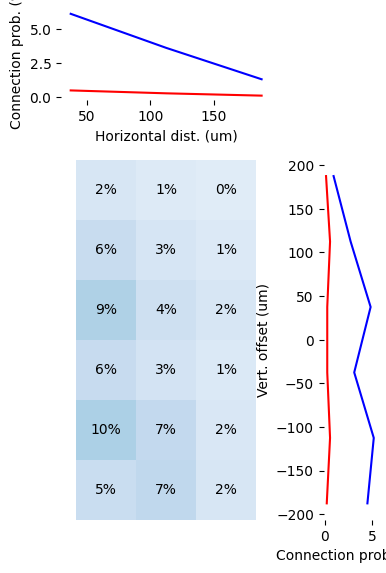

In [19]:
deltas["horizontal"] = numpy.abs(deltas["horizontal"])
deltas = deltas[numpy.any(deltas != 0, axis=1)]

hbins = numpy.arange(0, 300, 75)
hbinc = 0.5 * (hbins[:-1] + hbins[1:])
vbins = numpy.arange(-225, 300, 75)
vbinc = 0.5 * (vbins[:-1] + vbins[1:])
deltas["hbins"] = numpy.digitize(deltas["horizontal"], bins=hbins[:-1]) - 1
deltas["vbins"] = numpy.digitize(deltas["vertical"], bins=vbins[:-1]) - 1



fig = plt.figure(figsize=(3.5, 6.))
ax_c = fig.add_axes([0.1, 0.1, 0.6, 0.6])
ax_t = fig.add_axes([0.1, 0.8, 0.6, 0.15])
ax_r = fig.add_axes([0.85, 0.1, 0.15, 0.6])

tst = deltas.reset_index().groupby("hbins")["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)
ax_t.plot(hbinc[tst.index], 100 * tst["reciprocal"] / tst["pairs"], color="red")
ax_t.plot(hbinc[tst.index], 100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], color="blue")
ax_t.set_xlabel("Horizontal dist. (um)")
ax_t.set_ylabel("Connection prob. (%)")
ax_t.set_frame_on(False)

tst = deltas.reset_index().groupby("vbins")["level_1"].value_counts().unstack("level_1", fill_value=0).drop(-1)
tst["pairs"] = tst.sum(axis=1)
ax_r.plot(100 * tst["reciprocal"] / tst["pairs"], vbinc[tst.index], color="red")
ax_r.plot(100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], vbinc[tst.index], color="blue")
ax_r.set_ylabel("Vert. offset (um)")
ax_r.set_xlabel("Connection prob. (%)")
ax_r.set_frame_on(False)

tst = deltas.reset_index().groupby(["hbins", "vbins"])["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)

tstP = (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"]

ax_c.imshow(tstP.unstack("hbins").drop(-1), cmap="Blues", clim=[-0.05, 0.4],
           extent=[hbins[0], hbins[-1], vbins[-1], vbins[0]])
ax_c.set_ylim(sorted(ax_c.set_ylim()))
ax_c.set_xticks([]); ax_c.set_yticks([]); ax_c.set_frame_on(False)

for hb, hv in enumerate(hbinc):
    for vb, vv in enumerate(vbinc):
        v = tstP[(hb, vb)]
        ax_c.text(hv, vv, "{0}%".format(int(numpy.round(100 * v))),
                 verticalalignment="center", horizontalalignment="center")

#### Show that distance matters
Second panel shows that when sampling at higher distances the reciprocity increases.

Black arrow indicates where a Peng et al.-like sampling is found

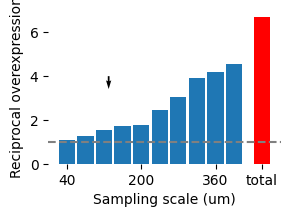

In [20]:
fig = plt.figure(figsize=(3, 2.0))
ax = fig.gca()

x = all_P.index.to_frame()["scale"].values
x_extra = x[-1] + 1.5 * numpy.mean(numpy.diff(x))
ax.bar(x, all_P['reciprocal'] / (all_P['unidirectional'] ** 2), width=35)
ax.bar(x_extra, P_rec_ttl / (P_uni_ttl ** 2), width=35, color="red")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1, 1], color="grey", ls="--")
ax.quiver([130], [4], [0], [-2])
ticks = x[::4]
ax.set_xticks(list(ticks) + [x_extra])
ax.set_xticklabels(list(ticks) + ["total"])
ax.set_xlabel("Sampling scale (um)")
ax.set_ylabel("Reciprocal overexpression")
ax.set_frame_on(False)

#### Part IIa: Triad motifs at different scales

Text(0, 0.5, 'Sampling scale(um)')

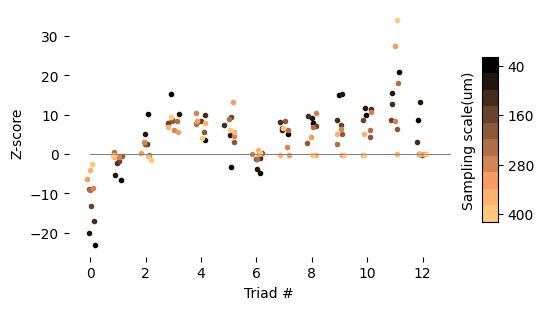

In [21]:
from matplotlib import cm
fig = plt.figure(figsize=(5, 2.75))
ax = fig.add_axes([0.025, 0.025, 0.8, 0.9])

lvls = all_counts.index.levels[0]
cols = cm.copper(numpy.linspace(0, 1, len(lvls)))

for lvl, col in zip(lvls, cols):
    x = all_counts.columns + 0.4 * (numpy.random.rand(len(all_counts.columns)) - 0.5)
    ax.plot(x, all_counts.loc[lvl].mean(), color=col, ls="None", marker='o', ms=3)
    ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

ax = fig.add_axes([0.85, 0.15, 0.035, 0.6])
c = cols.reshape((-1, 1, 4))
ax.imshow(c)
ax.set_xticks([]); ax.yaxis.tick_right()
ticks = numpy.arange(0, len(lvls), 3)
ax.set_yticks(ticks)
ax.set_yticklabels(lvls.values[ticks])
ax.set_ylabel("Sampling scale(um)")